In [1]:
import os

In [2]:
from __future__ import print_function
from pathlib import Path
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
import zipfile

There are 20579 pictures of dogs.


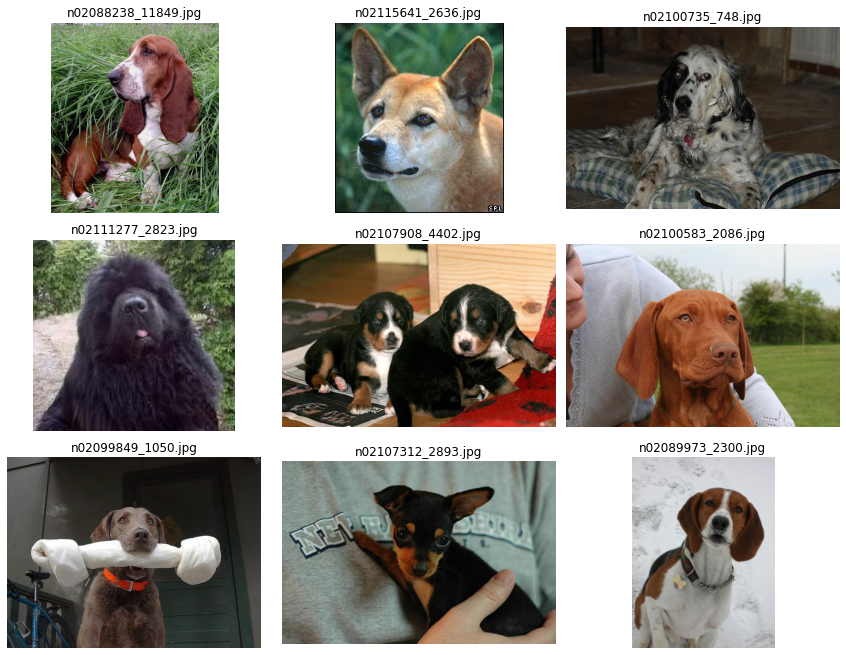

In [3]:
PATH = '../input/generativedogimages/all-dogs/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [4]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('../input/generativedogimages/all-dogs/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

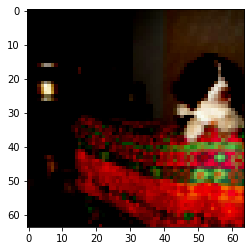

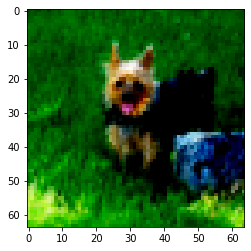

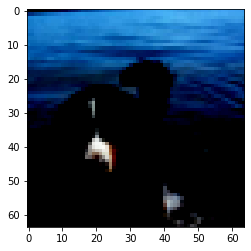

In [5]:
for i in range(3):
    plt.imshow(imgs[i])
    plt.show()

In [6]:
# INITIALIZATION can move it
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(Generator, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = Generator()
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

In [8]:
# Defining the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)
    
    
# Creating the discriminator
netD = Discriminator()
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 100 # play with me
LR = 0.001
criterion = nn.BCELoss()
netG = netG.to(device)
netD = netD.to(device)
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))
G_losses = []
D_losses = []

In [10]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [11]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, 100, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

[0/100][0/644] Loss_D: 1.6694; Loss_G: 25.0299
[0/100][1/644] Loss_D: 6.0955; Loss_G: 30.4891
[0/100][2/644] Loss_D: 5.4944; Loss_G: 14.0701
[0/100][3/644] Loss_D: 87.5977; Loss_G: 0.4248
[0/100][4/644] Loss_D: 16.5847; Loss_G: 23.8512
[0/100][5/644] Loss_D: 0.5942; Loss_G: 21.1287
[0/100][6/644] Loss_D: 0.1397; Loss_G: 11.6316
[0/100][7/644] Loss_D: 25.0804; Loss_G: 22.9731
[0/100][8/644] Loss_D: 2.3008; Loss_G: 22.3691
[0/100][9/644] Loss_D: 1.0190; Loss_G: 17.8344
[0/100][10/644] Loss_D: 0.2440; Loss_G: 9.9632
[0/100][11/644] Loss_D: 46.8198; Loss_G: 9.1659
[0/100][12/644] Loss_D: 1.1707; Loss_G: 17.4399
[0/100][13/644] Loss_D: 2.3841; Loss_G: 12.5485
[0/100][14/644] Loss_D: 7.8684; Loss_G: 11.3749
[0/100][15/644] Loss_D: 1.9189; Loss_G: 9.1072
[0/100][16/644] Loss_D: 2.3102; Loss_G: 3.5489
[0/100][17/644] Loss_D: 2.4179; Loss_G: 4.7013
[0/100][18/644] Loss_D: 0.6981; Loss_G: 5.4298
[0/100][19/644] Loss_D: 1.1244; Loss_G: 3.4444
[0/100][20/644] Loss_D: 0.9911; Loss_G: 3.1612
[0/100]

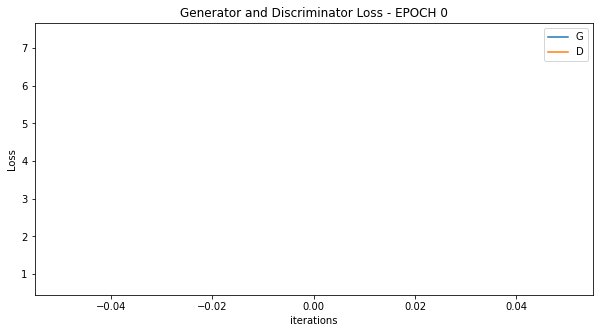

[0/100][321/644] Loss_D: 0.7769; Loss_G: 7.3420
[0/100][322/644] Loss_D: 1.6351; Loss_G: 2.3284
[0/100][323/644] Loss_D: 2.9744; Loss_G: 5.0697
[0/100][324/644] Loss_D: 0.7727; Loss_G: 4.3941
[0/100][325/644] Loss_D: 1.1267; Loss_G: 1.8087
[0/100][326/644] Loss_D: 1.2904; Loss_G: 4.9679
[0/100][327/644] Loss_D: 1.3104; Loss_G: 2.1632
[0/100][328/644] Loss_D: 0.9451; Loss_G: 2.0876
[0/100][329/644] Loss_D: 0.7160; Loss_G: 5.3863
[0/100][330/644] Loss_D: 0.4250; Loss_G: 4.4606
[0/100][331/644] Loss_D: 0.5133; Loss_G: 1.6681
[0/100][332/644] Loss_D: 2.8241; Loss_G: 6.9401
[0/100][333/644] Loss_D: 3.5878; Loss_G: 1.4432
[0/100][334/644] Loss_D: 1.1066; Loss_G: 2.4583
[0/100][335/644] Loss_D: 1.0482; Loss_G: 3.5094
[0/100][336/644] Loss_D: 0.8403; Loss_G: 2.1948
[0/100][337/644] Loss_D: 0.4897; Loss_G: 3.2912
[0/100][338/644] Loss_D: 0.4845; Loss_G: 3.0390
[0/100][339/644] Loss_D: 0.6936; Loss_G: 3.5777
[0/100][340/644] Loss_D: 0.8508; Loss_G: 2.2709
[0/100][341/644] Loss_D: 0.9000; Loss_G:

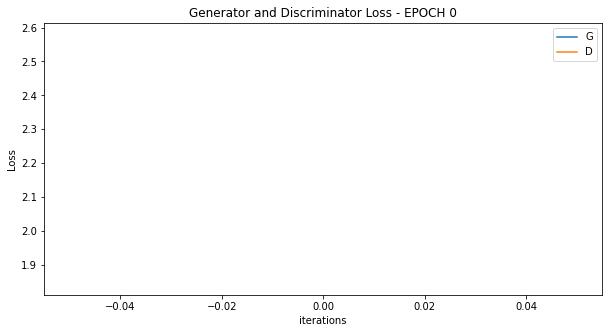

[0/100][643/644] Loss_D: 1.8481; Loss_G: 2.5769
[1/100][0/644] Loss_D: 2.4887; Loss_G: 2.9115
[1/100][1/644] Loss_D: 2.4808; Loss_G: 3.2242
[1/100][2/644] Loss_D: 1.9211; Loss_G: 2.0303
[1/100][3/644] Loss_D: 1.8582; Loss_G: 1.1210
[1/100][4/644] Loss_D: 1.5279; Loss_G: 2.3756
[1/100][5/644] Loss_D: 1.2018; Loss_G: 2.5034
[1/100][6/644] Loss_D: 1.3455; Loss_G: 1.5789
[1/100][7/644] Loss_D: 1.0334; Loss_G: 1.7930
[1/100][8/644] Loss_D: 0.9019; Loss_G: 2.5121
[1/100][9/644] Loss_D: 0.9174; Loss_G: 2.3118
[1/100][10/644] Loss_D: 0.7797; Loss_G: 2.4071
[1/100][11/644] Loss_D: 1.0473; Loss_G: 2.5744
[1/100][12/644] Loss_D: 0.9916; Loss_G: 2.5069
[1/100][13/644] Loss_D: 1.1696; Loss_G: 2.7621
[1/100][14/644] Loss_D: 1.2002; Loss_G: 3.5317
[1/100][15/644] Loss_D: 1.1634; Loss_G: 2.4406
[1/100][16/644] Loss_D: 1.7195; Loss_G: 5.5176
[1/100][17/644] Loss_D: 1.5453; Loss_G: 3.9901
[1/100][18/644] Loss_D: 2.1513; Loss_G: 3.0868
[1/100][19/644] Loss_D: 1.9803; Loss_G: 3.3237
[1/100][20/644] Loss_D

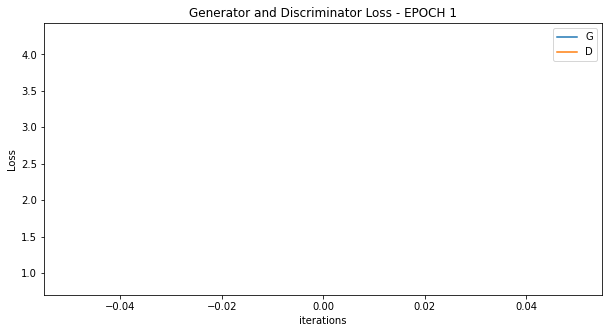

[1/100][321/644] Loss_D: 0.8711; Loss_G: 4.2603
[1/100][322/644] Loss_D: 1.1669; Loss_G: 1.2125
[1/100][323/644] Loss_D: 1.9440; Loss_G: 5.4797
[1/100][324/644] Loss_D: 2.5036; Loss_G: 1.6479
[1/100][325/644] Loss_D: 1.2894; Loss_G: 1.3892
[1/100][326/644] Loss_D: 1.5828; Loss_G: 3.7331
[1/100][327/644] Loss_D: 1.0324; Loss_G: 2.8926
[1/100][328/644] Loss_D: 1.1218; Loss_G: 1.1337
[1/100][329/644] Loss_D: 0.9882; Loss_G: 2.7965
[1/100][330/644] Loss_D: 0.7735; Loss_G: 3.9596
[1/100][331/644] Loss_D: 0.8049; Loss_G: 2.3386
[1/100][332/644] Loss_D: 0.9919; Loss_G: 3.0369
[1/100][333/644] Loss_D: 0.8763; Loss_G: 2.5380
[1/100][334/644] Loss_D: 0.8450; Loss_G: 3.8041
[1/100][335/644] Loss_D: 0.6014; Loss_G: 3.6268
[1/100][336/644] Loss_D: 0.6321; Loss_G: 2.7547
[1/100][337/644] Loss_D: 1.8964; Loss_G: 6.1616
[1/100][338/644] Loss_D: 3.7935; Loss_G: 1.0744
[1/100][339/644] Loss_D: 1.1023; Loss_G: 2.6692
[1/100][340/644] Loss_D: 1.1705; Loss_G: 3.8173
[1/100][341/644] Loss_D: 0.7689; Loss_G:

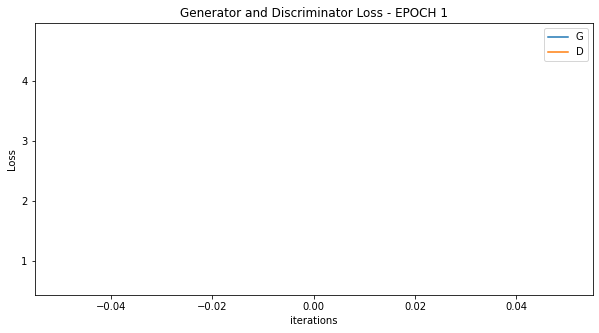

[1/100][643/644] Loss_D: 0.6436; Loss_G: 4.7520
[2/100][0/644] Loss_D: 1.0739; Loss_G: 3.2386
[2/100][1/644] Loss_D: 1.7353; Loss_G: 1.3973
[2/100][2/644] Loss_D: 1.1167; Loss_G: 2.9606
[2/100][3/644] Loss_D: 1.1584; Loss_G: 1.9679
[2/100][4/644] Loss_D: 1.1016; Loss_G: 2.4252
[2/100][5/644] Loss_D: 1.2742; Loss_G: 2.6749
[2/100][6/644] Loss_D: 1.1515; Loss_G: 1.8151
[2/100][7/644] Loss_D: 1.9748; Loss_G: 2.8150
[2/100][8/644] Loss_D: 1.5239; Loss_G: 3.9937
[2/100][9/644] Loss_D: 1.7121; Loss_G: 1.0915
[2/100][10/644] Loss_D: 2.3262; Loss_G: 3.1238
[2/100][11/644] Loss_D: 1.2780; Loss_G: 2.0788
[2/100][12/644] Loss_D: 1.5042; Loss_G: 1.1572
[2/100][13/644] Loss_D: 1.4123; Loss_G: 2.3281
[2/100][14/644] Loss_D: 1.0106; Loss_G: 2.3370
[2/100][15/644] Loss_D: 0.6835; Loss_G: 2.6843
[2/100][16/644] Loss_D: 1.4394; Loss_G: 1.6261
[2/100][17/644] Loss_D: 1.2381; Loss_G: 2.8869
[2/100][18/644] Loss_D: 1.4065; Loss_G: 2.0513
[2/100][19/644] Loss_D: 1.5224; Loss_G: 3.1166
[2/100][20/644] Loss_D

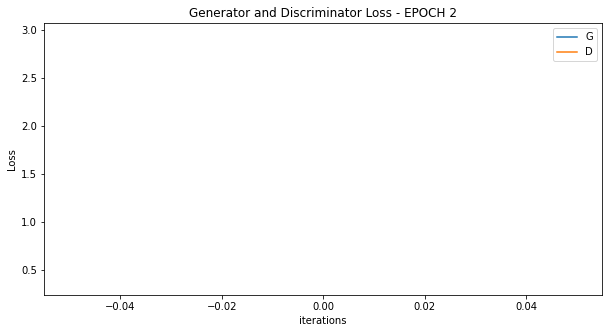

[2/100][321/644] Loss_D: 0.3710; Loss_G: 2.9402
[2/100][322/644] Loss_D: 0.7894; Loss_G: 4.1861
[2/100][323/644] Loss_D: 0.7836; Loss_G: 2.4655
[2/100][324/644] Loss_D: 0.6400; Loss_G: 3.9700
[2/100][325/644] Loss_D: 0.7156; Loss_G: 4.6312
[2/100][326/644] Loss_D: 0.6691; Loss_G: 3.7220
[2/100][327/644] Loss_D: 0.9313; Loss_G: 2.9909
[2/100][328/644] Loss_D: 0.8591; Loss_G: 2.5282
[2/100][329/644] Loss_D: 0.7079; Loss_G: 2.5514
[2/100][330/644] Loss_D: 1.0826; Loss_G: 1.9300
[2/100][331/644] Loss_D: 0.6906; Loss_G: 2.9823
[2/100][332/644] Loss_D: 0.7744; Loss_G: 3.2149
[2/100][333/644] Loss_D: 1.2126; Loss_G: 2.2849
[2/100][334/644] Loss_D: 0.8849; Loss_G: 5.2213
[2/100][335/644] Loss_D: 1.4099; Loss_G: 1.0237
[2/100][336/644] Loss_D: 0.9630; Loss_G: 4.3378
[2/100][337/644] Loss_D: 1.2883; Loss_G: 2.1677
[2/100][338/644] Loss_D: 1.0011; Loss_G: 4.6936
[2/100][339/644] Loss_D: 1.0674; Loss_G: 2.3465
[2/100][340/644] Loss_D: 0.8289; Loss_G: 2.2692
[2/100][341/644] Loss_D: 1.2484; Loss_G:

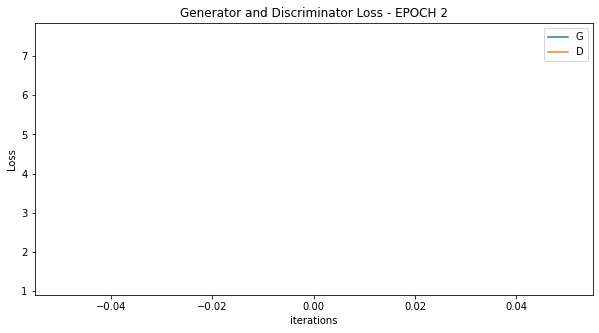

[2/100][643/644] Loss_D: 1.2242; Loss_G: 7.5223
[3/100][0/644] Loss_D: 1.0534; Loss_G: 2.4331
[3/100][1/644] Loss_D: 1.2733; Loss_G: 3.1655
[3/100][2/644] Loss_D: 1.1980; Loss_G: 2.9966
[3/100][3/644] Loss_D: 1.0728; Loss_G: 3.8872
[3/100][4/644] Loss_D: 1.0015; Loss_G: 2.5462
[3/100][5/644] Loss_D: 1.2933; Loss_G: 2.8640
[3/100][6/644] Loss_D: 0.9352; Loss_G: 4.0325
[3/100][7/644] Loss_D: 0.5676; Loss_G: 3.7655
[3/100][8/644] Loss_D: 0.6096; Loss_G: 2.2446
[3/100][9/644] Loss_D: 0.8344; Loss_G: 4.6627
[3/100][10/644] Loss_D: 0.4875; Loss_G: 3.6428
[3/100][11/644] Loss_D: 0.4855; Loss_G: 3.1752
[3/100][12/644] Loss_D: 1.2966; Loss_G: 6.0692
[3/100][13/644] Loss_D: 3.1858; Loss_G: 0.7820
[3/100][14/644] Loss_D: 2.3017; Loss_G: 5.7960
[3/100][15/644] Loss_D: 1.3538; Loss_G: 3.1285
[3/100][16/644] Loss_D: 0.7812; Loss_G: 2.4698
[3/100][17/644] Loss_D: 0.9739; Loss_G: 4.6366
[3/100][18/644] Loss_D: 0.9874; Loss_G: 1.8765
[3/100][19/644] Loss_D: 1.2434; Loss_G: 5.5461
[3/100][20/644] Loss_D

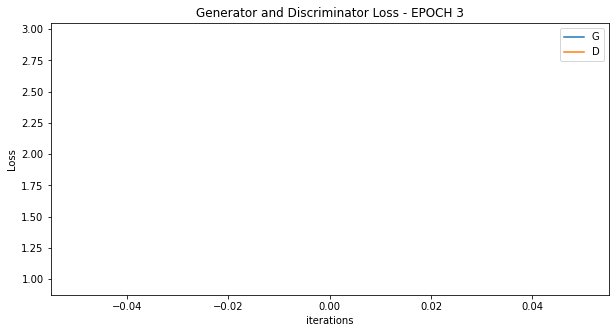

[3/100][321/644] Loss_D: 0.9724; Loss_G: 2.9510
[3/100][322/644] Loss_D: 1.0859; Loss_G: 3.2052
[3/100][323/644] Loss_D: 0.9890; Loss_G: 2.3547
[3/100][324/644] Loss_D: 1.4488; Loss_G: 3.6521
[3/100][325/644] Loss_D: 1.2424; Loss_G: 1.7916
[3/100][326/644] Loss_D: 1.2410; Loss_G: 3.4634
[3/100][327/644] Loss_D: 1.0571; Loss_G: 2.3055
[3/100][328/644] Loss_D: 0.8675; Loss_G: 4.1581
[3/100][329/644] Loss_D: 0.7316; Loss_G: 2.8587
[3/100][330/644] Loss_D: 0.7744; Loss_G: 2.6243
[3/100][331/644] Loss_D: 1.3500; Loss_G: 4.3471
[3/100][332/644] Loss_D: 1.1705; Loss_G: 2.4762
[3/100][333/644] Loss_D: 1.1350; Loss_G: 1.6329
[3/100][334/644] Loss_D: 1.1224; Loss_G: 2.8791
[3/100][335/644] Loss_D: 1.3372; Loss_G: 2.8347
[3/100][336/644] Loss_D: 1.2986; Loss_G: 1.7756
[3/100][337/644] Loss_D: 1.1283; Loss_G: 3.3292
[3/100][338/644] Loss_D: 0.9120; Loss_G: 3.6731
[3/100][339/644] Loss_D: 0.8360; Loss_G: 2.2319
[3/100][340/644] Loss_D: 1.0245; Loss_G: 3.1577
[3/100][341/644] Loss_D: 1.2156; Loss_G:

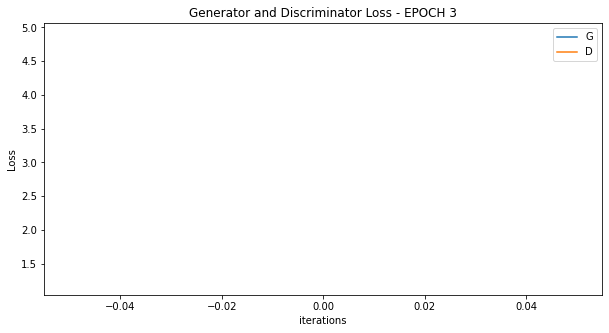

[3/100][643/644] Loss_D: 1.2247; Loss_G: 4.8810
[4/100][0/644] Loss_D: 1.8336; Loss_G: 3.4298
[4/100][1/644] Loss_D: 1.0852; Loss_G: 2.8600
[4/100][2/644] Loss_D: 0.8529; Loss_G: 1.5860
[4/100][3/644] Loss_D: 1.1731; Loss_G: 4.4892
[4/100][4/644] Loss_D: 1.2518; Loss_G: 2.3092
[4/100][5/644] Loss_D: 0.4902; Loss_G: 2.6345
[4/100][6/644] Loss_D: 0.5986; Loss_G: 3.5557
[4/100][7/644] Loss_D: 1.1016; Loss_G: 2.6749
[4/100][8/644] Loss_D: 1.0418; Loss_G: 4.1739
[4/100][9/644] Loss_D: 1.6729; Loss_G: 0.9141
[4/100][10/644] Loss_D: 1.6657; Loss_G: 4.3088
[4/100][11/644] Loss_D: 1.6731; Loss_G: 1.0871
[4/100][12/644] Loss_D: 1.5863; Loss_G: 3.2884
[4/100][13/644] Loss_D: 1.0124; Loss_G: 2.5067
[4/100][14/644] Loss_D: 1.3606; Loss_G: 2.6304
[4/100][15/644] Loss_D: 1.0665; Loss_G: 2.1253
[4/100][16/644] Loss_D: 0.9865; Loss_G: 2.8054
[4/100][17/644] Loss_D: 1.0010; Loss_G: 2.2947
[4/100][18/644] Loss_D: 1.2455; Loss_G: 2.1215
[4/100][19/644] Loss_D: 1.3211; Loss_G: 2.8399
[4/100][20/644] Loss_D

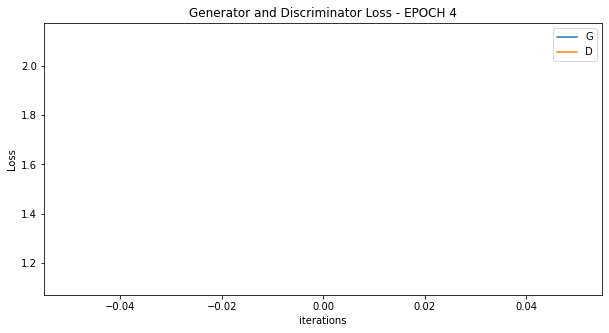

[4/100][321/644] Loss_D: 1.1207; Loss_G: 2.1240
[4/100][322/644] Loss_D: 0.7472; Loss_G: 1.8563
[4/100][323/644] Loss_D: 1.0982; Loss_G: 2.6678
[4/100][324/644] Loss_D: 1.1926; Loss_G: 1.1411
[4/100][325/644] Loss_D: 1.3823; Loss_G: 2.2941
[4/100][326/644] Loss_D: 1.1335; Loss_G: 2.0510
[4/100][327/644] Loss_D: 1.4796; Loss_G: 1.4821
[4/100][328/644] Loss_D: 1.4704; Loss_G: 3.6194
[4/100][329/644] Loss_D: 1.7001; Loss_G: 0.8450
[4/100][330/644] Loss_D: 1.9175; Loss_G: 3.6431
[4/100][331/644] Loss_D: 1.7006; Loss_G: 1.8173
[4/100][332/644] Loss_D: 1.2328; Loss_G: 1.4588
[4/100][333/644] Loss_D: 0.8953; Loss_G: 2.3814
[4/100][334/644] Loss_D: 1.2292; Loss_G: 2.7418
[4/100][335/644] Loss_D: 0.8970; Loss_G: 1.7461
[4/100][336/644] Loss_D: 1.0991; Loss_G: 2.3046
[4/100][337/644] Loss_D: 0.8936; Loss_G: 2.2355
[4/100][338/644] Loss_D: 1.1991; Loss_G: 1.4798
[4/100][339/644] Loss_D: 1.2570; Loss_G: 2.5967
[4/100][340/644] Loss_D: 0.7210; Loss_G: 2.6173
[4/100][341/644] Loss_D: 1.0021; Loss_G:

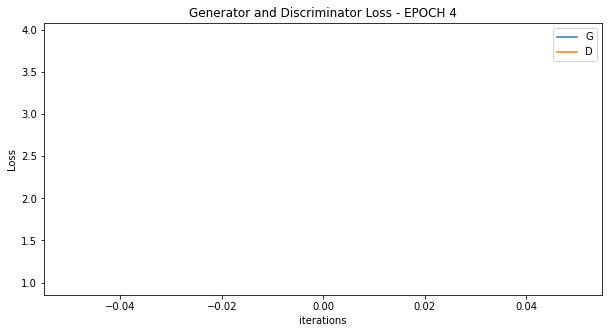

[4/100][643/644] Loss_D: 1.0020; Loss_G: 3.9328
[5/100][0/644] Loss_D: 1.6102; Loss_G: 3.9403
[5/100][1/644] Loss_D: 1.0300; Loss_G: 2.3105
[5/100][2/644] Loss_D: 1.1319; Loss_G: 1.1844
[5/100][3/644] Loss_D: 1.6235; Loss_G: 3.4192
[5/100][4/644] Loss_D: 1.2414; Loss_G: 1.3581
[5/100][5/644] Loss_D: 1.0266; Loss_G: 2.1358
[5/100][6/644] Loss_D: 1.6239; Loss_G: 3.8739
[5/100][7/644] Loss_D: 1.7165; Loss_G: 1.0886
[5/100][8/644] Loss_D: 1.4834; Loss_G: 2.8206
[5/100][9/644] Loss_D: 1.1605; Loss_G: 1.5999
[5/100][10/644] Loss_D: 1.0187; Loss_G: 2.6881
[5/100][11/644] Loss_D: 0.9244; Loss_G: 1.7281
[5/100][12/644] Loss_D: 1.0460; Loss_G: 2.2241
[5/100][13/644] Loss_D: 1.2852; Loss_G: 2.5640
[5/100][14/644] Loss_D: 2.1736; Loss_G: 0.5276
[5/100][15/644] Loss_D: 1.7701; Loss_G: 2.5350
[5/100][16/644] Loss_D: 1.1386; Loss_G: 2.6943
[5/100][17/644] Loss_D: 1.3718; Loss_G: 0.9755
[5/100][18/644] Loss_D: 1.0796; Loss_G: 2.5718
[5/100][19/644] Loss_D: 1.2524; Loss_G: 2.7889
[5/100][20/644] Loss_D

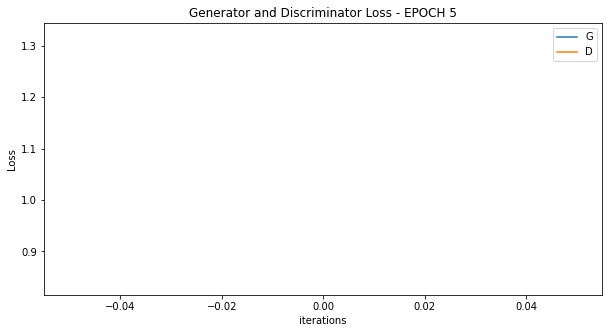

[5/100][321/644] Loss_D: 1.3200; Loss_G: 0.8397
[5/100][322/644] Loss_D: 1.3166; Loss_G: 2.4554
[5/100][323/644] Loss_D: 1.2453; Loss_G: 2.0056
[5/100][324/644] Loss_D: 1.2324; Loss_G: 1.0799
[5/100][325/644] Loss_D: 1.3453; Loss_G: 1.8675
[5/100][326/644] Loss_D: 1.0350; Loss_G: 2.3312
[5/100][327/644] Loss_D: 1.0885; Loss_G: 1.6806
[5/100][328/644] Loss_D: 0.9030; Loss_G: 1.6914
[5/100][329/644] Loss_D: 1.0485; Loss_G: 2.6925
[5/100][330/644] Loss_D: 0.9255; Loss_G: 2.0506
[5/100][331/644] Loss_D: 1.1399; Loss_G: 1.2318
[5/100][332/644] Loss_D: 1.1170; Loss_G: 2.3887
[5/100][333/644] Loss_D: 1.0523; Loss_G: 2.8830
[5/100][334/644] Loss_D: 1.3793; Loss_G: 0.8994
[5/100][335/644] Loss_D: 1.7448; Loss_G: 2.1976
[5/100][336/644] Loss_D: 1.2899; Loss_G: 2.3161
[5/100][337/644] Loss_D: 1.3791; Loss_G: 1.3423
[5/100][338/644] Loss_D: 1.4186; Loss_G: 2.7141
[5/100][339/644] Loss_D: 1.6350; Loss_G: 1.7488
[5/100][340/644] Loss_D: 1.4092; Loss_G: 1.4591
[5/100][341/644] Loss_D: 1.5912; Loss_G:

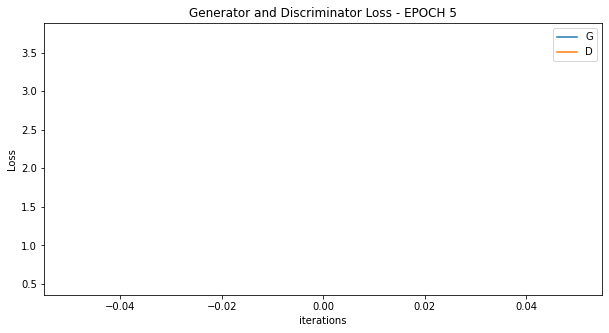

[5/100][643/644] Loss_D: 0.5186; Loss_G: 3.7224
[6/100][0/644] Loss_D: 1.1860; Loss_G: 2.3179
[6/100][1/644] Loss_D: 1.2635; Loss_G: 1.9581
[6/100][2/644] Loss_D: 1.3256; Loss_G: 1.8620
[6/100][3/644] Loss_D: 1.0840; Loss_G: 2.1480
[6/100][4/644] Loss_D: 1.2402; Loss_G: 1.8990
[6/100][5/644] Loss_D: 1.3672; Loss_G: 2.4884
[6/100][6/644] Loss_D: 1.3801; Loss_G: 1.1740
[6/100][7/644] Loss_D: 1.3713; Loss_G: 3.0022
[6/100][8/644] Loss_D: 1.3494; Loss_G: 1.1014
[6/100][9/644] Loss_D: 1.0693; Loss_G: 2.0491
[6/100][10/644] Loss_D: 0.8030; Loss_G: 3.1176
[6/100][11/644] Loss_D: 0.9993; Loss_G: 1.1652
[6/100][12/644] Loss_D: 0.9311; Loss_G: 2.5098
[6/100][13/644] Loss_D: 1.0272; Loss_G: 1.4128
[6/100][14/644] Loss_D: 1.5403; Loss_G: 1.9464
[6/100][15/644] Loss_D: 1.3314; Loss_G: 2.1099
[6/100][16/644] Loss_D: 1.1301; Loss_G: 1.2237
[6/100][17/644] Loss_D: 1.1187; Loss_G: 2.8579
[6/100][18/644] Loss_D: 1.0388; Loss_G: 1.2684
[6/100][19/644] Loss_D: 1.4869; Loss_G: 2.0273
[6/100][20/644] Loss_D

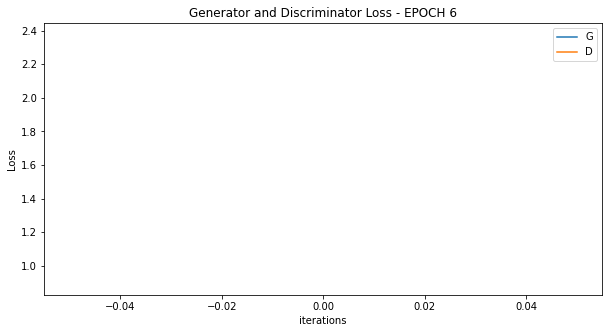

[6/100][321/644] Loss_D: 0.9003; Loss_G: 2.3713
[6/100][322/644] Loss_D: 0.8544; Loss_G: 2.2630
[6/100][323/644] Loss_D: 1.0792; Loss_G: 1.4353
[6/100][324/644] Loss_D: 0.8880; Loss_G: 2.2817
[6/100][325/644] Loss_D: 0.9635; Loss_G: 2.7502
[6/100][326/644] Loss_D: 1.0530; Loss_G: 1.1839
[6/100][327/644] Loss_D: 1.2374; Loss_G: 2.3908
[6/100][328/644] Loss_D: 1.3891; Loss_G: 1.9311
[6/100][329/644] Loss_D: 1.2969; Loss_G: 1.4212
[6/100][330/644] Loss_D: 1.4232; Loss_G: 2.4742
[6/100][331/644] Loss_D: 2.0839; Loss_G: 0.5655
[6/100][332/644] Loss_D: 1.5063; Loss_G: 2.9469
[6/100][333/644] Loss_D: 1.1501; Loss_G: 1.3130
[6/100][334/644] Loss_D: 1.2588; Loss_G: 1.7155
[6/100][335/644] Loss_D: 1.4492; Loss_G: 3.8167
[6/100][336/644] Loss_D: 2.0996; Loss_G: 0.5818
[6/100][337/644] Loss_D: 1.6787; Loss_G: 2.4741
[6/100][338/644] Loss_D: 1.0505; Loss_G: 2.1280
[6/100][339/644] Loss_D: 1.2041; Loss_G: 1.8119
[6/100][340/644] Loss_D: 1.1953; Loss_G: 1.5702
[6/100][341/644] Loss_D: 1.3144; Loss_G:

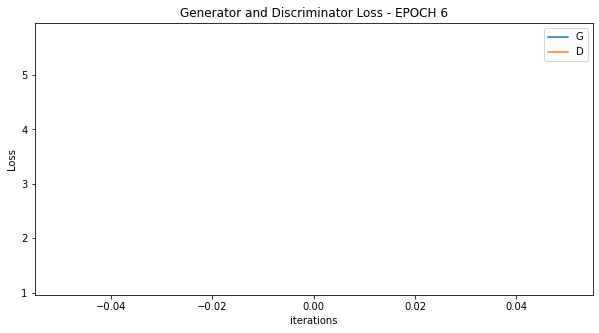

[6/100][643/644] Loss_D: 1.1883; Loss_G: 5.7262
[7/100][0/644] Loss_D: 1.8815; Loss_G: 3.8863
[7/100][1/644] Loss_D: 1.1189; Loss_G: 2.4488
[7/100][2/644] Loss_D: 1.3557; Loss_G: 1.0647
[7/100][3/644] Loss_D: 1.0658; Loss_G: 2.8769
[7/100][4/644] Loss_D: 1.2945; Loss_G: 2.6328
[7/100][5/644] Loss_D: 1.4659; Loss_G: 1.8333
[7/100][6/644] Loss_D: 1.5487; Loss_G: 2.1449
[7/100][7/644] Loss_D: 1.5168; Loss_G: 2.6182
[7/100][8/644] Loss_D: 1.3514; Loss_G: 1.3212
[7/100][9/644] Loss_D: 1.5963; Loss_G: 2.7859
[7/100][10/644] Loss_D: 0.9892; Loss_G: 2.1774
[7/100][11/644] Loss_D: 1.5915; Loss_G: 1.0755
[7/100][12/644] Loss_D: 1.5686; Loss_G: 2.5612
[7/100][13/644] Loss_D: 0.8936; Loss_G: 2.6786
[7/100][14/644] Loss_D: 1.2707; Loss_G: 1.2413
[7/100][15/644] Loss_D: 1.0962; Loss_G: 2.5785
[7/100][16/644] Loss_D: 1.2483; Loss_G: 2.1118
[7/100][17/644] Loss_D: 1.0500; Loss_G: 1.8631
[7/100][18/644] Loss_D: 1.3566; Loss_G: 1.9771
[7/100][19/644] Loss_D: 1.0716; Loss_G: 2.4961
[7/100][20/644] Loss_D

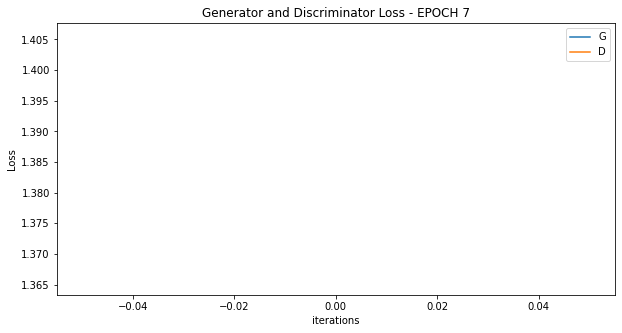

[7/100][321/644] Loss_D: 1.4056; Loss_G: 1.3654
[7/100][322/644] Loss_D: 1.6182; Loss_G: 2.2798
[7/100][323/644] Loss_D: 1.2582; Loss_G: 1.5009
[7/100][324/644] Loss_D: 1.0563; Loss_G: 1.3147
[7/100][325/644] Loss_D: 1.3641; Loss_G: 3.0367
[7/100][326/644] Loss_D: 0.8006; Loss_G: 1.9928
[7/100][327/644] Loss_D: 0.9603; Loss_G: 1.6155
[7/100][328/644] Loss_D: 0.9007; Loss_G: 2.8784
[7/100][329/644] Loss_D: 1.0886; Loss_G: 1.5614
[7/100][330/644] Loss_D: 1.0767; Loss_G: 1.4294
[7/100][331/644] Loss_D: 1.5672; Loss_G: 2.3637
[7/100][332/644] Loss_D: 0.7971; Loss_G: 1.6447
[7/100][333/644] Loss_D: 1.1493; Loss_G: 2.7669
[7/100][334/644] Loss_D: 0.8848; Loss_G: 1.8588
[7/100][335/644] Loss_D: 1.0861; Loss_G: 2.4741
[7/100][336/644] Loss_D: 1.1601; Loss_G: 0.9637
[7/100][337/644] Loss_D: 1.3860; Loss_G: 2.6855
[7/100][338/644] Loss_D: 0.7844; Loss_G: 2.1617
[7/100][339/644] Loss_D: 1.1303; Loss_G: 1.2139
[7/100][340/644] Loss_D: 1.0300; Loss_G: 2.5825
[7/100][341/644] Loss_D: 1.0543; Loss_G:

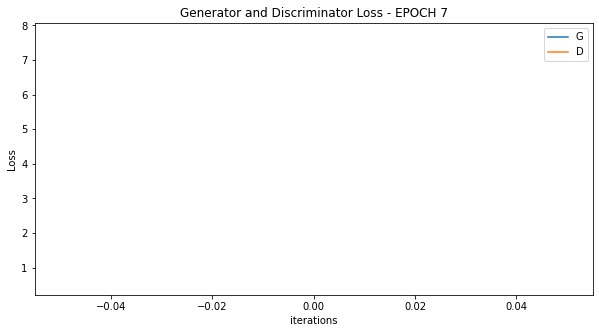

[7/100][643/644] Loss_D: 0.5720; Loss_G: 7.7100
[8/100][0/644] Loss_D: 0.9051; Loss_G: 2.9609
[8/100][1/644] Loss_D: 0.8490; Loss_G: 1.9170
[8/100][2/644] Loss_D: 0.8969; Loss_G: 2.4510
[8/100][3/644] Loss_D: 0.9321; Loss_G: 3.0350
[8/100][4/644] Loss_D: 1.3026; Loss_G: 1.1601
[8/100][5/644] Loss_D: 1.3638; Loss_G: 3.5146
[8/100][6/644] Loss_D: 1.2689; Loss_G: 2.8175
[8/100][7/644] Loss_D: 0.7467; Loss_G: 1.7859
[8/100][8/644] Loss_D: 1.0742; Loss_G: 2.5661
[8/100][9/644] Loss_D: 0.6078; Loss_G: 2.4240
[8/100][10/644] Loss_D: 1.3048; Loss_G: 1.4946
[8/100][11/644] Loss_D: 1.1253; Loss_G: 4.2163
[8/100][12/644] Loss_D: 1.3856; Loss_G: 1.7187
[8/100][13/644] Loss_D: 1.0456; Loss_G: 2.5629
[8/100][14/644] Loss_D: 0.8815; Loss_G: 2.8968
[8/100][15/644] Loss_D: 0.5382; Loss_G: 2.5326
[8/100][16/644] Loss_D: 0.5986; Loss_G: 2.3830
[8/100][17/644] Loss_D: 0.7867; Loss_G: 2.7456
[8/100][18/644] Loss_D: 1.1159; Loss_G: 2.5576
[8/100][19/644] Loss_D: 0.6129; Loss_G: 2.2301
[8/100][20/644] Loss_D

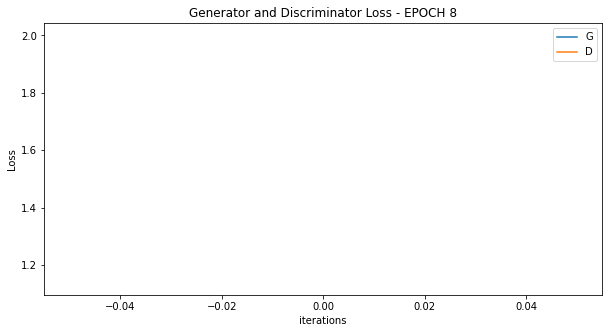

[8/100][321/644] Loss_D: 1.1389; Loss_G: 2.0002
[8/100][322/644] Loss_D: 0.8828; Loss_G: 3.1303
[8/100][323/644] Loss_D: 0.8220; Loss_G: 2.6915
[8/100][324/644] Loss_D: 1.1622; Loss_G: 2.2485
[8/100][325/644] Loss_D: 0.7825; Loss_G: 2.8402
[8/100][326/644] Loss_D: 1.0196; Loss_G: 2.5637
[8/100][327/644] Loss_D: 0.7584; Loss_G: 3.3069
[8/100][328/644] Loss_D: 0.9408; Loss_G: 1.8138
[8/100][329/644] Loss_D: 1.2326; Loss_G: 1.8757
[8/100][330/644] Loss_D: 0.6970; Loss_G: 4.4952
[8/100][331/644] Loss_D: 1.2088; Loss_G: 1.3622
[8/100][332/644] Loss_D: 0.9070; Loss_G: 3.7773
[8/100][333/644] Loss_D: 0.9408; Loss_G: 2.2833
[8/100][334/644] Loss_D: 0.9369; Loss_G: 2.6050
[8/100][335/644] Loss_D: 0.8487; Loss_G: 2.4321
[8/100][336/644] Loss_D: 0.5122; Loss_G: 3.3043
[8/100][337/644] Loss_D: 0.8035; Loss_G: 2.1102
[8/100][338/644] Loss_D: 0.5511; Loss_G: 3.0337
[8/100][339/644] Loss_D: 0.9691; Loss_G: 2.3389
[8/100][340/644] Loss_D: 0.5583; Loss_G: 2.9424
[8/100][341/644] Loss_D: 0.5526; Loss_G:

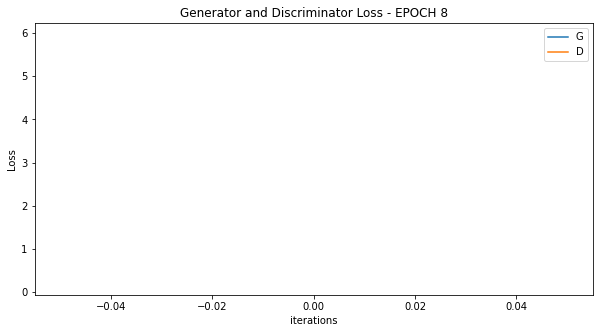

[8/100][643/644] Loss_D: 0.2250; Loss_G: 5.9429
[9/100][0/644] Loss_D: 0.7208; Loss_G: 2.6992
[9/100][1/644] Loss_D: 0.3872; Loss_G: 3.4760
[9/100][2/644] Loss_D: 2.0428; Loss_G: 0.6481
[9/100][3/644] Loss_D: 1.9214; Loss_G: 4.4435
[9/100][4/644] Loss_D: 0.6226; Loss_G: 3.7252
[9/100][5/644] Loss_D: 0.6990; Loss_G: 2.5337
[9/100][6/644] Loss_D: 0.7709; Loss_G: 1.7265
[9/100][7/644] Loss_D: 1.2218; Loss_G: 4.5316
[9/100][8/644] Loss_D: 1.3737; Loss_G: 1.9658
[9/100][9/644] Loss_D: 0.8291; Loss_G: 2.6389
[9/100][10/644] Loss_D: 0.3628; Loss_G: 4.0349
[9/100][11/644] Loss_D: 0.6688; Loss_G: 3.0767
[9/100][12/644] Loss_D: 0.9083; Loss_G: 2.0197
[9/100][13/644] Loss_D: 0.9612; Loss_G: 3.1998
[9/100][14/644] Loss_D: 0.9475; Loss_G: 1.9986
[9/100][15/644] Loss_D: 0.8130; Loss_G: 3.1503
[9/100][16/644] Loss_D: 0.9499; Loss_G: 1.1901
[9/100][17/644] Loss_D: 1.3505; Loss_G: 4.8072
[9/100][18/644] Loss_D: 0.6750; Loss_G: 3.4121
[9/100][19/644] Loss_D: 0.4892; Loss_G: 2.2769
[9/100][20/644] Loss_D

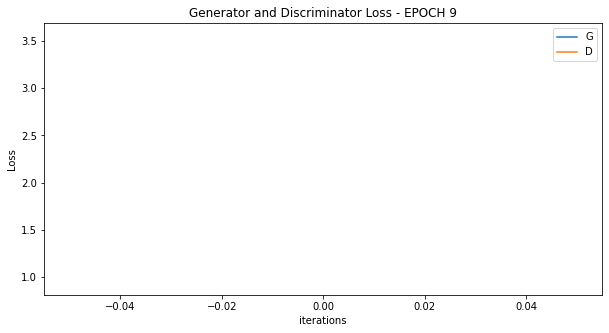

[9/100][321/644] Loss_D: 0.9429; Loss_G: 3.5606
[9/100][322/644] Loss_D: 0.6919; Loss_G: 2.5387
[9/100][323/644] Loss_D: 0.9552; Loss_G: 1.8606
[9/100][324/644] Loss_D: 1.1147; Loss_G: 4.1620
[9/100][325/644] Loss_D: 1.0879; Loss_G: 1.6933
[9/100][326/644] Loss_D: 0.8868; Loss_G: 3.7613
[9/100][327/644] Loss_D: 0.7794; Loss_G: 2.0591
[9/100][328/644] Loss_D: 1.0502; Loss_G: 2.5932
[9/100][329/644] Loss_D: 0.9760; Loss_G: 2.6624
[9/100][330/644] Loss_D: 0.7493; Loss_G: 3.9793
[9/100][331/644] Loss_D: 0.9812; Loss_G: 1.5615
[9/100][332/644] Loss_D: 0.7661; Loss_G: 3.5382
[9/100][333/644] Loss_D: 0.9569; Loss_G: 1.7220
[9/100][334/644] Loss_D: 0.9569; Loss_G: 3.0602
[9/100][335/644] Loss_D: 0.7899; Loss_G: 3.5226
[9/100][336/644] Loss_D: 0.7024; Loss_G: 1.8623
[9/100][337/644] Loss_D: 0.7098; Loss_G: 1.6778
[9/100][338/644] Loss_D: 1.5949; Loss_G: 5.2360
[9/100][339/644] Loss_D: 2.0970; Loss_G: 0.6805
[9/100][340/644] Loss_D: 1.4622; Loss_G: 3.2121
[9/100][341/644] Loss_D: 0.9302; Loss_G:

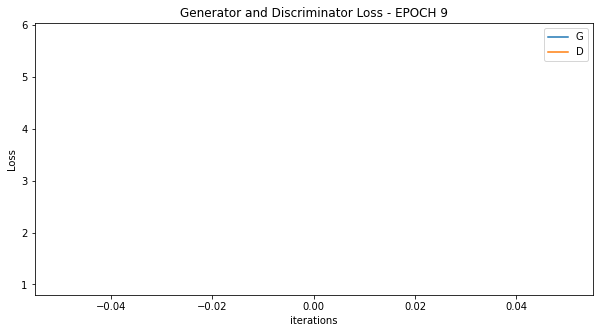

[9/100][643/644] Loss_D: 1.0368; Loss_G: 5.8047
[10/100][0/644] Loss_D: 1.1110; Loss_G: 3.2417
[10/100][1/644] Loss_D: 1.2802; Loss_G: 1.3732
[10/100][2/644] Loss_D: 1.7118; Loss_G: 5.3769
[10/100][3/644] Loss_D: 1.6660; Loss_G: 2.0121
[10/100][4/644] Loss_D: 0.8122; Loss_G: 1.6756
[10/100][5/644] Loss_D: 1.2163; Loss_G: 4.6282
[10/100][6/644] Loss_D: 0.8635; Loss_G: 3.4913
[10/100][7/644] Loss_D: 0.7447; Loss_G: 2.4549
[10/100][8/644] Loss_D: 0.9959; Loss_G: 3.4120
[10/100][9/644] Loss_D: 0.8025; Loss_G: 2.6367
[10/100][10/644] Loss_D: 1.3015; Loss_G: 1.1604
[10/100][11/644] Loss_D: 1.4497; Loss_G: 4.4594
[10/100][12/644] Loss_D: 1.4353; Loss_G: 1.6608
[10/100][13/644] Loss_D: 0.9943; Loss_G: 2.3179
[10/100][14/644] Loss_D: 0.7214; Loss_G: 3.0374
[10/100][15/644] Loss_D: 0.9255; Loss_G: 2.5263
[10/100][16/644] Loss_D: 0.7681; Loss_G: 2.8340
[10/100][17/644] Loss_D: 0.9100; Loss_G: 1.9808
[10/100][18/644] Loss_D: 0.8439; Loss_G: 4.4181
[10/100][19/644] Loss_D: 1.1835; Loss_G: 1.3156
[1

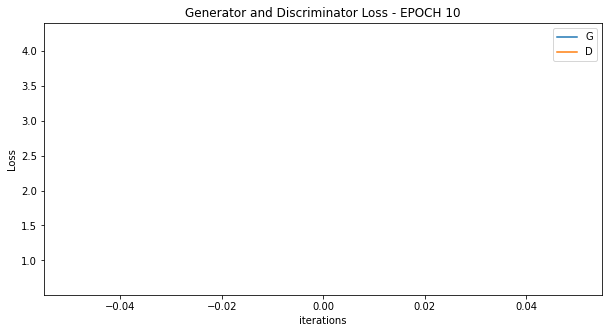

[10/100][321/644] Loss_D: 0.6837; Loss_G: 4.2243
[10/100][322/644] Loss_D: 1.1371; Loss_G: 1.2617
[10/100][323/644] Loss_D: 0.8398; Loss_G: 3.6479
[10/100][324/644] Loss_D: 0.8728; Loss_G: 2.4300
[10/100][325/644] Loss_D: 0.8111; Loss_G: 2.7439
[10/100][326/644] Loss_D: 0.7801; Loss_G: 3.1058
[10/100][327/644] Loss_D: 0.7257; Loss_G: 1.6978
[10/100][328/644] Loss_D: 0.8501; Loss_G: 3.8070
[10/100][329/644] Loss_D: 0.9684; Loss_G: 3.2025
[10/100][330/644] Loss_D: 0.8238; Loss_G: 1.1972
[10/100][331/644] Loss_D: 0.8154; Loss_G: 4.2391
[10/100][332/644] Loss_D: 0.9497; Loss_G: 2.3063
[10/100][333/644] Loss_D: 0.5928; Loss_G: 3.2409
[10/100][334/644] Loss_D: 0.7833; Loss_G: 2.0227
[10/100][335/644] Loss_D: 1.0022; Loss_G: 2.1117
[10/100][336/644] Loss_D: 0.9424; Loss_G: 4.2381
[10/100][337/644] Loss_D: 0.8497; Loss_G: 1.9007
[10/100][338/644] Loss_D: 0.7321; Loss_G: 1.9000
[10/100][339/644] Loss_D: 0.9932; Loss_G: 4.8474
[10/100][340/644] Loss_D: 1.4268; Loss_G: 1.2016
[10/100][341/644] Lo

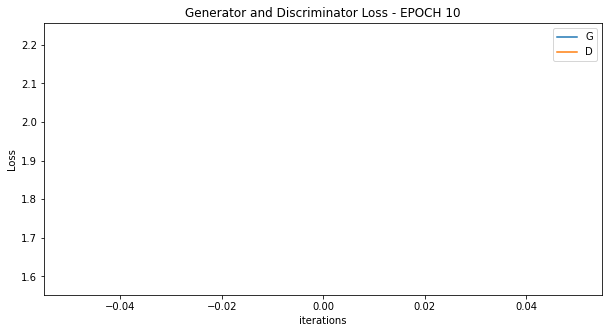

[10/100][643/644] Loss_D: 2.2247; Loss_G: 1.5842
[11/100][0/644] Loss_D: 3.8067; Loss_G: 4.0943
[11/100][1/644] Loss_D: 1.8027; Loss_G: 2.4034
[11/100][2/644] Loss_D: 1.6409; Loss_G: 1.5036
[11/100][3/644] Loss_D: 1.0935; Loss_G: 4.1956
[11/100][4/644] Loss_D: 1.1706; Loss_G: 2.4343
[11/100][5/644] Loss_D: 0.8468; Loss_G: 2.0345
[11/100][6/644] Loss_D: 1.3443; Loss_G: 2.5478
[11/100][7/644] Loss_D: 1.2656; Loss_G: 4.6605
[11/100][8/644] Loss_D: 1.5041; Loss_G: 1.6616
[11/100][9/644] Loss_D: 1.0887; Loss_G: 1.9984
[11/100][10/644] Loss_D: 1.5313; Loss_G: 4.5088
[11/100][11/644] Loss_D: 1.5927; Loss_G: 1.2710
[11/100][12/644] Loss_D: 1.3156; Loss_G: 2.8129
[11/100][13/644] Loss_D: 0.9305; Loss_G: 2.7717
[11/100][14/644] Loss_D: 1.0134; Loss_G: 2.1550
[11/100][15/644] Loss_D: 0.6997; Loss_G: 2.5462
[11/100][16/644] Loss_D: 0.9154; Loss_G: 2.8733
[11/100][17/644] Loss_D: 0.8453; Loss_G: 2.9200
[11/100][18/644] Loss_D: 0.8814; Loss_G: 2.5443
[11/100][19/644] Loss_D: 0.9058; Loss_G: 2.2750
[

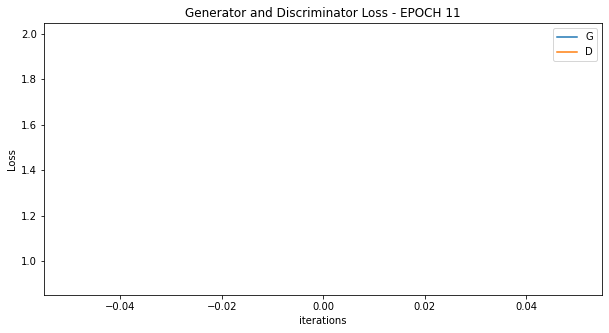

[11/100][321/644] Loss_D: 0.9063; Loss_G: 1.9930
[11/100][322/644] Loss_D: 0.9265; Loss_G: 3.2233
[11/100][323/644] Loss_D: 0.5207; Loss_G: 4.0088
[11/100][324/644] Loss_D: 1.2489; Loss_G: 0.9746
[11/100][325/644] Loss_D: 0.6436; Loss_G: 2.9498
[11/100][326/644] Loss_D: 0.9087; Loss_G: 4.1215
[11/100][327/644] Loss_D: 0.3728; Loss_G: 3.1659
[11/100][328/644] Loss_D: 0.7976; Loss_G: 0.7436
[11/100][329/644] Loss_D: 1.2885; Loss_G: 4.1431
[11/100][330/644] Loss_D: 0.7888; Loss_G: 2.5384
[11/100][331/644] Loss_D: 0.9379; Loss_G: 2.3479
[11/100][332/644] Loss_D: 1.3370; Loss_G: 1.6155
[11/100][333/644] Loss_D: 1.3709; Loss_G: 5.2401
[11/100][334/644] Loss_D: 1.6869; Loss_G: 0.7766
[11/100][335/644] Loss_D: 1.0667; Loss_G: 4.4519
[11/100][336/644] Loss_D: 0.6234; Loss_G: 2.3377
[11/100][337/644] Loss_D: 0.5684; Loss_G: 2.6339
[11/100][338/644] Loss_D: 0.8517; Loss_G: 3.2297
[11/100][339/644] Loss_D: 0.6288; Loss_G: 2.4849
[11/100][340/644] Loss_D: 0.7488; Loss_G: 1.9743
[11/100][341/644] Lo

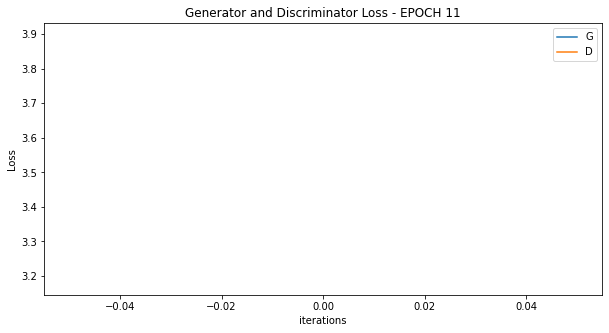

[11/100][643/644] Loss_D: 3.1812; Loss_G: 3.8966
[12/100][0/644] Loss_D: 1.7901; Loss_G: 4.4655
[12/100][1/644] Loss_D: 1.5982; Loss_G: 2.8646
[12/100][2/644] Loss_D: 0.9030; Loss_G: 2.1523
[12/100][3/644] Loss_D: 1.2720; Loss_G: 3.3836
[12/100][4/644] Loss_D: 1.1404; Loss_G: 2.2218
[12/100][5/644] Loss_D: 1.3525; Loss_G: 4.0262
[12/100][6/644] Loss_D: 1.6684; Loss_G: 1.3600
[12/100][7/644] Loss_D: 1.0119; Loss_G: 2.6018
[12/100][8/644] Loss_D: 1.1238; Loss_G: 4.4281
[12/100][9/644] Loss_D: 0.8286; Loss_G: 2.9273
[12/100][10/644] Loss_D: 1.4668; Loss_G: 1.7112
[12/100][11/644] Loss_D: 1.3136; Loss_G: 4.9881
[12/100][12/644] Loss_D: 0.7532; Loss_G: 2.6929
[12/100][13/644] Loss_D: 0.9781; Loss_G: 3.4483
[12/100][14/644] Loss_D: 0.8406; Loss_G: 2.5011
[12/100][15/644] Loss_D: 0.5570; Loss_G: 2.9209
[12/100][16/644] Loss_D: 1.2038; Loss_G: 4.1026
[12/100][17/644] Loss_D: 0.8654; Loss_G: 2.0845
[12/100][18/644] Loss_D: 0.8726; Loss_G: 4.8640
[12/100][19/644] Loss_D: 1.0565; Loss_G: 1.6319
[

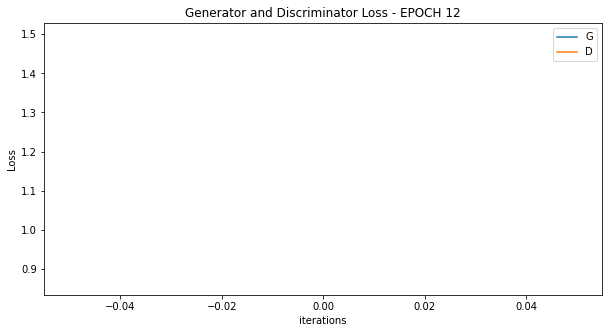

[12/100][321/644] Loss_D: 0.8656; Loss_G: 1.4970
[12/100][322/644] Loss_D: 0.9856; Loss_G: 5.3888
[12/100][323/644] Loss_D: 1.2669; Loss_G: 1.5572
[12/100][324/644] Loss_D: 0.9634; Loss_G: 3.6981
[12/100][325/644] Loss_D: 0.8725; Loss_G: 1.8981
[12/100][326/644] Loss_D: 1.1625; Loss_G: 3.8424
[12/100][327/644] Loss_D: 0.9802; Loss_G: 2.6518
[12/100][328/644] Loss_D: 0.5641; Loss_G: 2.6920
[12/100][329/644] Loss_D: 0.6234; Loss_G: 3.3901
[12/100][330/644] Loss_D: 0.4508; Loss_G: 3.2836
[12/100][331/644] Loss_D: 0.8202; Loss_G: 1.7866
[12/100][332/644] Loss_D: 0.9397; Loss_G: 4.6696
[12/100][333/644] Loss_D: 1.3772; Loss_G: 1.0698
[12/100][334/644] Loss_D: 1.0825; Loss_G: 3.8833
[12/100][335/644] Loss_D: 0.5637; Loss_G: 3.3152
[12/100][336/644] Loss_D: 0.9202; Loss_G: 2.1143
[12/100][337/644] Loss_D: 0.6303; Loss_G: 3.1902
[12/100][338/644] Loss_D: 0.7111; Loss_G: 3.4675
[12/100][339/644] Loss_D: 0.7086; Loss_G: 2.7125
[12/100][340/644] Loss_D: 0.6520; Loss_G: 2.0321
[12/100][341/644] Lo

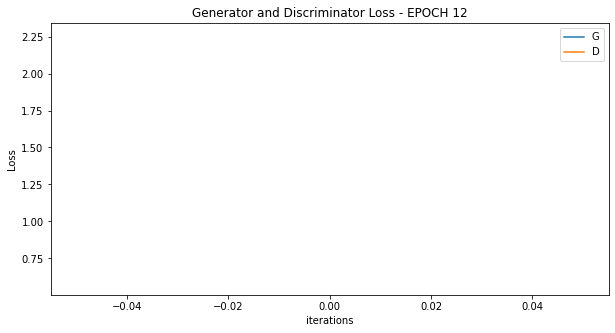

[12/100][643/644] Loss_D: 2.2581; Loss_G: 0.5877
[13/100][0/644] Loss_D: 2.8229; Loss_G: 6.7583
[13/100][1/644] Loss_D: 2.7045; Loss_G: 0.6970
[13/100][2/644] Loss_D: 2.1319; Loss_G: 3.8302
[13/100][3/644] Loss_D: 1.6478; Loss_G: 1.6681
[13/100][4/644] Loss_D: 1.4310; Loss_G: 2.2309
[13/100][5/644] Loss_D: 1.5822; Loss_G: 2.5876
[13/100][6/644] Loss_D: 1.8439; Loss_G: 1.8575
[13/100][7/644] Loss_D: 1.7749; Loss_G: 1.5625
[13/100][8/644] Loss_D: 1.8210; Loss_G: 5.1278
[13/100][9/644] Loss_D: 2.6932; Loss_G: 0.4731
[13/100][10/644] Loss_D: 2.1655; Loss_G: 4.3847
[13/100][11/644] Loss_D: 1.0909; Loss_G: 2.7250
[13/100][12/644] Loss_D: 0.5274; Loss_G: 2.0974
[13/100][13/644] Loss_D: 1.1584; Loss_G: 2.9833
[13/100][14/644] Loss_D: 0.8693; Loss_G: 3.1202
[13/100][15/644] Loss_D: 1.1538; Loss_G: 3.2505
[13/100][16/644] Loss_D: 0.8802; Loss_G: 1.8765
[13/100][17/644] Loss_D: 1.3095; Loss_G: 2.0696
[13/100][18/644] Loss_D: 1.0736; Loss_G: 4.4575
[13/100][19/644] Loss_D: 0.7702; Loss_G: 2.0643
[

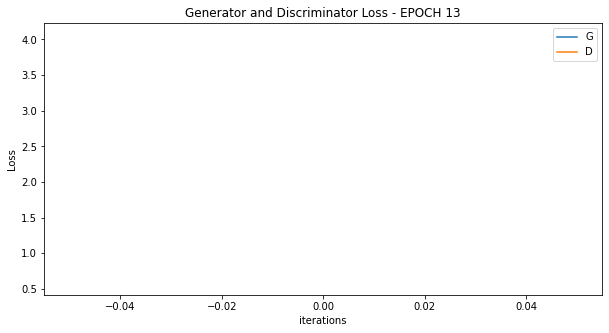

[13/100][321/644] Loss_D: 0.5894; Loss_G: 4.0579
[13/100][322/644] Loss_D: 0.8444; Loss_G: 3.0086
[13/100][323/644] Loss_D: 0.4591; Loss_G: 2.6412
[13/100][324/644] Loss_D: 0.3707; Loss_G: 3.1773
[13/100][325/644] Loss_D: 0.5856; Loss_G: 3.7698
[13/100][326/644] Loss_D: 0.1911; Loss_G: 4.8662
[13/100][327/644] Loss_D: 0.4191; Loss_G: 2.2579
[13/100][328/644] Loss_D: 0.5582; Loss_G: 2.1278
[13/100][329/644] Loss_D: 0.5797; Loss_G: 4.5743
[13/100][330/644] Loss_D: 1.2613; Loss_G: 0.5678
[13/100][331/644] Loss_D: 1.5513; Loss_G: 5.3895
[13/100][332/644] Loss_D: 1.6269; Loss_G: 0.6052
[13/100][333/644] Loss_D: 1.0161; Loss_G: 4.9215
[13/100][334/644] Loss_D: 0.4041; Loss_G: 4.2706
[13/100][335/644] Loss_D: 0.8754; Loss_G: 1.1505
[13/100][336/644] Loss_D: 1.1504; Loss_G: 4.7037
[13/100][337/644] Loss_D: 0.6249; Loss_G: 3.1971
[13/100][338/644] Loss_D: 0.4354; Loss_G: 3.4051
[13/100][339/644] Loss_D: 0.6473; Loss_G: 1.6374
[13/100][340/644] Loss_D: 1.0284; Loss_G: 5.9377
[13/100][341/644] Lo

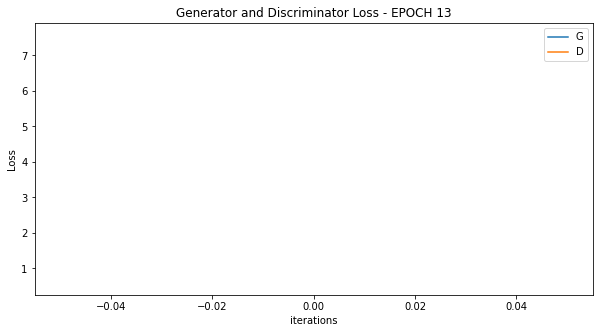

[13/100][643/644] Loss_D: 0.6041; Loss_G: 7.5654
[14/100][0/644] Loss_D: 0.8839; Loss_G: 3.9704
[14/100][1/644] Loss_D: 1.2770; Loss_G: 4.5152
[14/100][2/644] Loss_D: 1.2817; Loss_G: 0.8879
[14/100][3/644] Loss_D: 1.8222; Loss_G: 5.8577
[14/100][4/644] Loss_D: 0.9778; Loss_G: 2.6169
[14/100][5/644] Loss_D: 0.4711; Loss_G: 2.3742
[14/100][6/644] Loss_D: 0.6978; Loss_G: 4.3561
[14/100][7/644] Loss_D: 0.5749; Loss_G: 3.1398
[14/100][8/644] Loss_D: 0.5757; Loss_G: 2.2901
[14/100][9/644] Loss_D: 1.0116; Loss_G: 2.6238
[14/100][10/644] Loss_D: 0.3505; Loss_G: 3.4098
[14/100][11/644] Loss_D: 0.4787; Loss_G: 3.7864
[14/100][12/644] Loss_D: 0.7144; Loss_G: 2.9141
[14/100][13/644] Loss_D: 0.3424; Loss_G: 3.1295
[14/100][14/644] Loss_D: 0.6286; Loss_G: 3.2324
[14/100][15/644] Loss_D: 0.2445; Loss_G: 3.6744
[14/100][16/644] Loss_D: 0.4433; Loss_G: 3.1078
[14/100][17/644] Loss_D: 0.6429; Loss_G: 1.6488
[14/100][18/644] Loss_D: 0.9244; Loss_G: 5.6117
[14/100][19/644] Loss_D: 0.9926; Loss_G: 2.6143
[

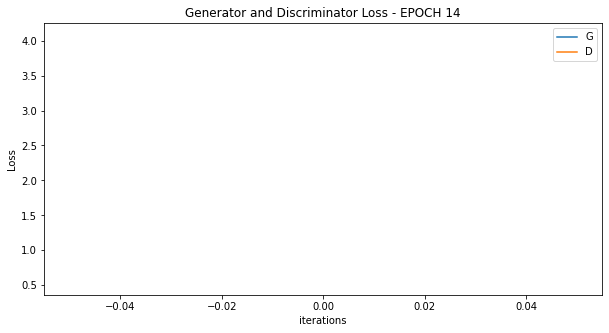

[14/100][321/644] Loss_D: 0.5394; Loss_G: 4.0757
[14/100][322/644] Loss_D: 0.6557; Loss_G: 1.9501
[14/100][323/644] Loss_D: 0.5453; Loss_G: 3.6658
[14/100][324/644] Loss_D: 0.4795; Loss_G: 3.5299
[14/100][325/644] Loss_D: 0.4567; Loss_G: 2.7676
[14/100][326/644] Loss_D: 0.4824; Loss_G: 3.3644
[14/100][327/644] Loss_D: 0.4691; Loss_G: 2.9304
[14/100][328/644] Loss_D: 0.6867; Loss_G: 3.2229
[14/100][329/644] Loss_D: 0.5000; Loss_G: 4.4532
[14/100][330/644] Loss_D: 0.6396; Loss_G: 2.7572
[14/100][331/644] Loss_D: 0.4961; Loss_G: 1.8546
[14/100][332/644] Loss_D: 1.4836; Loss_G: 4.2047
[14/100][333/644] Loss_D: 0.7083; Loss_G: 2.6314
[14/100][334/644] Loss_D: 0.4028; Loss_G: 2.6291
[14/100][335/644] Loss_D: 0.7225; Loss_G: 3.8561
[14/100][336/644] Loss_D: 0.4033; Loss_G: 3.1423
[14/100][337/644] Loss_D: 0.4741; Loss_G: 2.8235
[14/100][338/644] Loss_D: 0.7547; Loss_G: 3.8415
[14/100][339/644] Loss_D: 0.5655; Loss_G: 3.0714
[14/100][340/644] Loss_D: 0.6287; Loss_G: 2.4733
[14/100][341/644] Lo

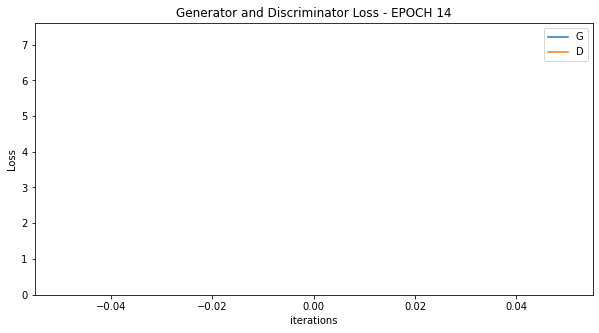

[14/100][643/644] Loss_D: 0.3393; Loss_G: 7.2596
[15/100][0/644] Loss_D: 0.8318; Loss_G: 4.2717
[15/100][1/644] Loss_D: 0.4963; Loss_G: 3.6938
[15/100][2/644] Loss_D: 0.7308; Loss_G: 1.6036
[15/100][3/644] Loss_D: 1.1701; Loss_G: 6.6166
[15/100][4/644] Loss_D: 0.4008; Loss_G: 4.3504
[15/100][5/644] Loss_D: 0.1662; Loss_G: 3.6835
[15/100][6/644] Loss_D: 0.5619; Loss_G: 2.8671
[15/100][7/644] Loss_D: 0.5926; Loss_G: 3.7942
[15/100][8/644] Loss_D: 0.6297; Loss_G: 3.2794
[15/100][9/644] Loss_D: 0.7511; Loss_G: 4.7570
[15/100][10/644] Loss_D: 0.8050; Loss_G: 1.6738
[15/100][11/644] Loss_D: 0.7627; Loss_G: 4.0460
[15/100][12/644] Loss_D: 0.5518; Loss_G: 4.6634
[15/100][13/644] Loss_D: 0.7534; Loss_G: 1.5735
[15/100][14/644] Loss_D: 0.5191; Loss_G: 3.5759
[15/100][15/644] Loss_D: 0.6164; Loss_G: 4.8972
[15/100][16/644] Loss_D: 0.4105; Loss_G: 2.8446
[15/100][17/644] Loss_D: 0.3473; Loss_G: 2.9052
[15/100][18/644] Loss_D: 0.8461; Loss_G: 4.3272
[15/100][19/644] Loss_D: 0.6671; Loss_G: 1.9801
[

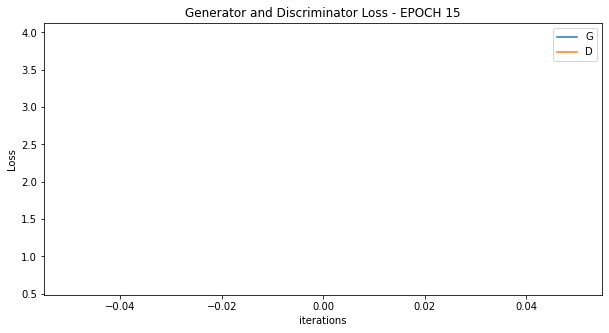

[15/100][321/644] Loss_D: 0.6525; Loss_G: 3.9611
[15/100][322/644] Loss_D: 0.4888; Loss_G: 3.3736
[15/100][323/644] Loss_D: 0.5641; Loss_G: 2.5323
[15/100][324/644] Loss_D: 0.5849; Loss_G: 3.4341
[15/100][325/644] Loss_D: 0.7640; Loss_G: 5.1677
[15/100][326/644] Loss_D: 0.4981; Loss_G: 2.8483
[15/100][327/644] Loss_D: 0.4163; Loss_G: 4.4507
[15/100][328/644] Loss_D: 0.5020; Loss_G: 2.4044
[15/100][329/644] Loss_D: 0.7337; Loss_G: 3.8658
[15/100][330/644] Loss_D: 0.4925; Loss_G: 3.3081
[15/100][331/644] Loss_D: 0.9998; Loss_G: 2.7374
[15/100][332/644] Loss_D: 0.1794; Loss_G: 4.0356
[15/100][333/644] Loss_D: 0.3545; Loss_G: 4.2549
[15/100][334/644] Loss_D: 0.5160; Loss_G: 2.3068
[15/100][335/644] Loss_D: 1.0623; Loss_G: 5.8845
[15/100][336/644] Loss_D: 0.5094; Loss_G: 3.6197
[15/100][337/644] Loss_D: 1.0324; Loss_G: 1.0991
[15/100][338/644] Loss_D: 1.5136; Loss_G: 6.5795
[15/100][339/644] Loss_D: 0.6598; Loss_G: 2.8073
[15/100][340/644] Loss_D: 0.3610; Loss_G: 3.3695
[15/100][341/644] Lo

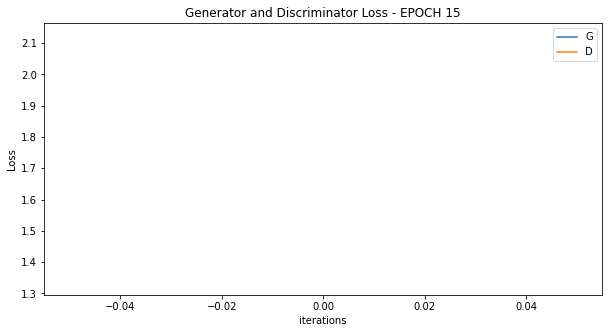

[15/100][643/644] Loss_D: 1.3348; Loss_G: 2.1252
[16/100][0/644] Loss_D: 5.0617; Loss_G: 6.6993
[16/100][1/644] Loss_D: 1.4342; Loss_G: 2.5632
[16/100][2/644] Loss_D: 1.2097; Loss_G: 1.4332
[16/100][3/644] Loss_D: 1.0005; Loss_G: 5.6781
[16/100][4/644] Loss_D: 0.7197; Loss_G: 2.9411
[16/100][5/644] Loss_D: 0.5910; Loss_G: 3.5272
[16/100][6/644] Loss_D: 1.0357; Loss_G: 5.2925
[16/100][7/644] Loss_D: 0.6560; Loss_G: 3.3356
[16/100][8/644] Loss_D: 1.0567; Loss_G: 3.6165
[16/100][9/644] Loss_D: 0.7810; Loss_G: 3.7422
[16/100][10/644] Loss_D: 0.9118; Loss_G: 3.1641
[16/100][11/644] Loss_D: 1.1930; Loss_G: 3.1612
[16/100][12/644] Loss_D: 0.4318; Loss_G: 4.6498
[16/100][13/644] Loss_D: 0.7788; Loss_G: 3.5210
[16/100][14/644] Loss_D: 0.5721; Loss_G: 1.9164
[16/100][15/644] Loss_D: 0.6077; Loss_G: 4.3828
[16/100][16/644] Loss_D: 0.5248; Loss_G: 3.2901
[16/100][17/644] Loss_D: 0.7481; Loss_G: 4.8475
[16/100][18/644] Loss_D: 0.7746; Loss_G: 2.0401
[16/100][19/644] Loss_D: 0.9103; Loss_G: 3.7051
[

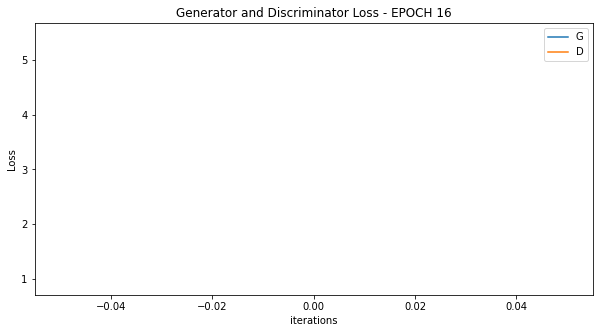

[16/100][321/644] Loss_D: 0.9342; Loss_G: 5.4484
[16/100][322/644] Loss_D: 0.6657; Loss_G: 2.6615
[16/100][323/644] Loss_D: 0.9574; Loss_G: 4.6781
[16/100][324/644] Loss_D: 0.6027; Loss_G: 2.9574
[16/100][325/644] Loss_D: 0.8382; Loss_G: 3.4502
[16/100][326/644] Loss_D: 0.6794; Loss_G: 1.6887
[16/100][327/644] Loss_D: 1.0440; Loss_G: 6.1951
[16/100][328/644] Loss_D: 0.4642; Loss_G: 4.0625
[16/100][329/644] Loss_D: 1.0515; Loss_G: 1.1592
[16/100][330/644] Loss_D: 1.0223; Loss_G: 6.8099
[16/100][331/644] Loss_D: 0.4583; Loss_G: 3.9610
[16/100][332/644] Loss_D: 0.4070; Loss_G: 2.2971
[16/100][333/644] Loss_D: 0.2003; Loss_G: 3.3762
[16/100][334/644] Loss_D: 0.2460; Loss_G: 4.9888
[16/100][335/644] Loss_D: 0.4336; Loss_G: 4.0494
[16/100][336/644] Loss_D: 0.8351; Loss_G: 2.0940
[16/100][337/644] Loss_D: 0.3487; Loss_G: 3.4713
[16/100][338/644] Loss_D: 0.3464; Loss_G: 4.5441
[16/100][339/644] Loss_D: 0.5644; Loss_G: 3.2292
[16/100][340/644] Loss_D: 0.5029; Loss_G: 3.1300
[16/100][341/644] Lo

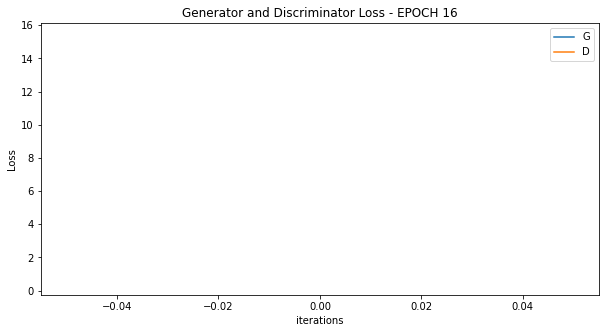

[16/100][643/644] Loss_D: 0.4889; Loss_G: 15.3928
[17/100][0/644] Loss_D: 0.7383; Loss_G: 1.7635
[17/100][1/644] Loss_D: 0.7838; Loss_G: 2.9891
[17/100][2/644] Loss_D: 1.1958; Loss_G: 5.6590
[17/100][3/644] Loss_D: 0.4111; Loss_G: 3.4071
[17/100][4/644] Loss_D: 0.9681; Loss_G: 2.9491
[17/100][5/644] Loss_D: 0.8013; Loss_G: 5.1327
[17/100][6/644] Loss_D: 0.9430; Loss_G: 2.6471
[17/100][7/644] Loss_D: 0.4178; Loss_G: 4.5300
[17/100][8/644] Loss_D: 0.3796; Loss_G: 5.5865
[17/100][9/644] Loss_D: 1.0216; Loss_G: 1.4361
[17/100][10/644] Loss_D: 0.6494; Loss_G: 4.7365
[17/100][11/644] Loss_D: 0.5197; Loss_G: 3.7381
[17/100][12/644] Loss_D: 0.2669; Loss_G: 4.0439
[17/100][13/644] Loss_D: 0.5943; Loss_G: 2.2906
[17/100][14/644] Loss_D: 0.6163; Loss_G: 5.3152
[17/100][15/644] Loss_D: 0.2973; Loss_G: 4.0644
[17/100][16/644] Loss_D: 0.4216; Loss_G: 2.4849
[17/100][17/644] Loss_D: 0.5454; Loss_G: 4.6090
[17/100][18/644] Loss_D: 0.4190; Loss_G: 4.2436
[17/100][19/644] Loss_D: 0.8648; Loss_G: 1.9286


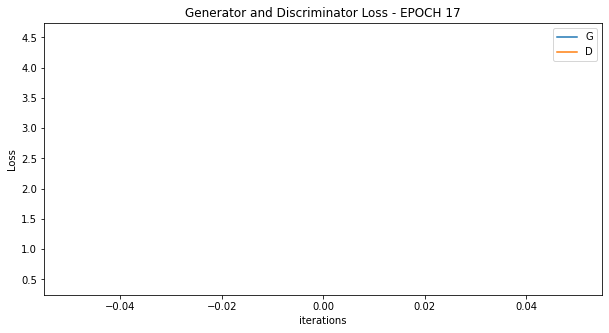

[17/100][321/644] Loss_D: 0.4490; Loss_G: 4.5347
[17/100][322/644] Loss_D: 0.1946; Loss_G: 4.2413
[17/100][323/644] Loss_D: 0.6124; Loss_G: 1.4027
[17/100][324/644] Loss_D: 1.0910; Loss_G: 6.9565
[17/100][325/644] Loss_D: 0.6596; Loss_G: 1.8880
[17/100][326/644] Loss_D: 0.6281; Loss_G: 6.6191
[17/100][327/644] Loss_D: 1.0903; Loss_G: 1.9648
[17/100][328/644] Loss_D: 0.7372; Loss_G: 4.2257
[17/100][329/644] Loss_D: 0.4021; Loss_G: 5.4575
[17/100][330/644] Loss_D: 1.2752; Loss_G: 0.9429
[17/100][331/644] Loss_D: 1.1036; Loss_G: 5.9280
[17/100][332/644] Loss_D: 0.2382; Loss_G: 5.4825
[17/100][333/644] Loss_D: 0.7730; Loss_G: 2.2674
[17/100][334/644] Loss_D: 0.5308; Loss_G: 5.0926
[17/100][335/644] Loss_D: 0.3733; Loss_G: 5.5165
[17/100][336/644] Loss_D: 1.3802; Loss_G: 0.4560
[17/100][337/644] Loss_D: 2.2231; Loss_G: 8.1059
[17/100][338/644] Loss_D: 0.7613; Loss_G: 2.3631
[17/100][339/644] Loss_D: 0.7644; Loss_G: 2.0212
[17/100][340/644] Loss_D: 1.2418; Loss_G: 8.1289
[17/100][341/644] Lo

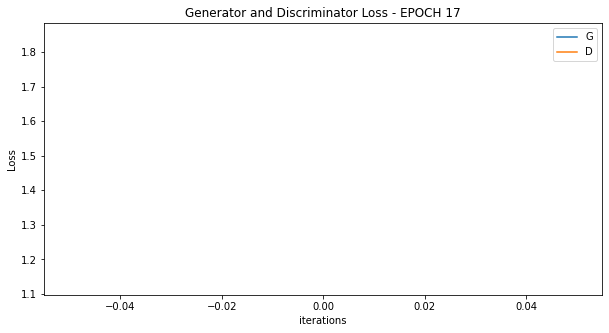

[17/100][643/644] Loss_D: 1.8483; Loss_G: 1.1331
[18/100][0/644] Loss_D: 1.1956; Loss_G: 5.9550
[18/100][1/644] Loss_D: 0.5162; Loss_G: 5.7249
[18/100][2/644] Loss_D: 0.7596; Loss_G: 2.1310
[18/100][3/644] Loss_D: 0.6967; Loss_G: 4.6770
[18/100][4/644] Loss_D: 0.7714; Loss_G: 4.1003
[18/100][5/644] Loss_D: 0.4440; Loss_G: 4.4036
[18/100][6/644] Loss_D: 0.5827; Loss_G: 2.5361
[18/100][7/644] Loss_D: 0.7647; Loss_G: 4.3796
[18/100][8/644] Loss_D: 0.6675; Loss_G: 2.0358
[18/100][9/644] Loss_D: 0.6381; Loss_G: 4.2133
[18/100][10/644] Loss_D: 0.4974; Loss_G: 5.7672
[18/100][11/644] Loss_D: 0.7473; Loss_G: 2.7656
[18/100][12/644] Loss_D: 0.7154; Loss_G: 2.9807
[18/100][13/644] Loss_D: 0.6225; Loss_G: 5.0322
[18/100][14/644] Loss_D: 0.4213; Loss_G: 5.1850
[18/100][15/644] Loss_D: 0.7826; Loss_G: 2.8470
[18/100][16/644] Loss_D: 0.5708; Loss_G: 4.9065
[18/100][17/644] Loss_D: 0.1735; Loss_G: 4.9092
[18/100][18/644] Loss_D: 0.1945; Loss_G: 3.8921
[18/100][19/644] Loss_D: 0.9165; Loss_G: 1.8233
[

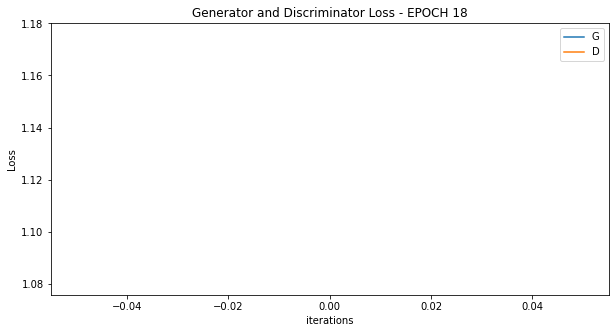

[18/100][321/644] Loss_D: 1.0805; Loss_G: 1.1754
[18/100][322/644] Loss_D: 0.9700; Loss_G: 6.1591
[18/100][323/644] Loss_D: 0.4109; Loss_G: 3.8742
[18/100][324/644] Loss_D: 1.0992; Loss_G: 0.8734
[18/100][325/644] Loss_D: 1.4407; Loss_G: 7.1483
[18/100][326/644] Loss_D: 0.6011; Loss_G: 3.7518
[18/100][327/644] Loss_D: 0.6245; Loss_G: 3.8020
[18/100][328/644] Loss_D: 0.3147; Loss_G: 3.8119
[18/100][329/644] Loss_D: 0.5657; Loss_G: 2.3191
[18/100][330/644] Loss_D: 0.4146; Loss_G: 4.2480
[18/100][331/644] Loss_D: 0.4348; Loss_G: 4.5924
[18/100][332/644] Loss_D: 0.3977; Loss_G: 4.0231
[18/100][333/644] Loss_D: 0.3599; Loss_G: 3.1429
[18/100][334/644] Loss_D: 0.5293; Loss_G: 3.1523
[18/100][335/644] Loss_D: 0.2393; Loss_G: 4.1326
[18/100][336/644] Loss_D: 0.6045; Loss_G: 1.5974
[18/100][337/644] Loss_D: 0.5966; Loss_G: 4.4528
[18/100][338/644] Loss_D: 0.5717; Loss_G: 5.0596
[18/100][339/644] Loss_D: 0.1241; Loss_G: 4.8698
[18/100][340/644] Loss_D: 1.3653; Loss_G: 0.6898
[18/100][341/644] Lo

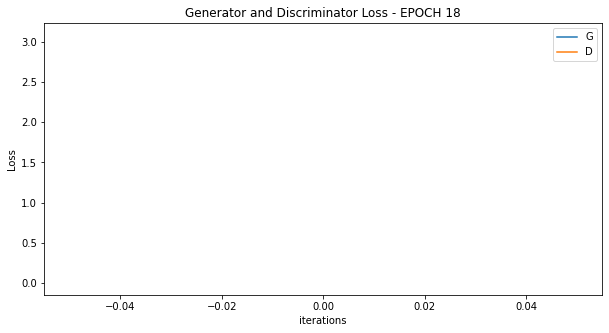

[18/100][643/644] Loss_D: 3.0784; Loss_G: 0.0093
[19/100][0/644] Loss_D: 8.5765; Loss_G: 6.2153
[19/100][1/644] Loss_D: 1.4778; Loss_G: 1.6698
[19/100][2/644] Loss_D: 2.8140; Loss_G: 6.3994
[19/100][3/644] Loss_D: 1.8517; Loss_G: 0.0748
[19/100][4/644] Loss_D: 4.9687; Loss_G: 9.2669
[19/100][5/644] Loss_D: 1.5565; Loss_G: 1.7377
[19/100][6/644] Loss_D: 1.7912; Loss_G: 7.2653
[19/100][7/644] Loss_D: 4.9995; Loss_G: 0.4105
[19/100][8/644] Loss_D: 1.2453; Loss_G: 3.3225
[19/100][9/644] Loss_D: 1.5512; Loss_G: 9.3466
[19/100][10/644] Loss_D: 3.1245; Loss_G: 2.0643
[19/100][11/644] Loss_D: 1.7865; Loss_G: 3.2541
[19/100][12/644] Loss_D: 0.7800; Loss_G: 5.5834
[19/100][13/644] Loss_D: 1.0970; Loss_G: 2.1753
[19/100][14/644] Loss_D: 0.5275; Loss_G: 4.4137
[19/100][15/644] Loss_D: 1.6495; Loss_G: 4.7396
[19/100][16/644] Loss_D: 1.0565; Loss_G: 2.2221
[19/100][17/644] Loss_D: 0.8601; Loss_G: 4.0523
[19/100][18/644] Loss_D: 0.5422; Loss_G: 3.1232
[19/100][19/644] Loss_D: 1.1437; Loss_G: 6.4869
[

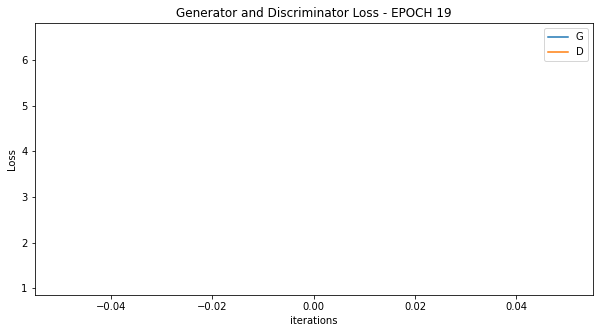

[19/100][321/644] Loss_D: 1.1257; Loss_G: 6.5406
[19/100][322/644] Loss_D: 0.3281; Loss_G: 4.3070
[19/100][323/644] Loss_D: 0.3461; Loss_G: 3.1394
[19/100][324/644] Loss_D: 0.2110; Loss_G: 3.1879
[19/100][325/644] Loss_D: 0.5077; Loss_G: 3.8398
[19/100][326/644] Loss_D: 0.9344; Loss_G: 1.5740
[19/100][327/644] Loss_D: 0.9247; Loss_G: 5.2668
[19/100][328/644] Loss_D: 0.2620; Loss_G: 4.8150
[19/100][329/644] Loss_D: 0.4906; Loss_G: 2.3656
[19/100][330/644] Loss_D: 0.4446; Loss_G: 4.6353
[19/100][331/644] Loss_D: 0.3422; Loss_G: 3.7580
[19/100][332/644] Loss_D: 0.3287; Loss_G: 3.3494
[19/100][333/644] Loss_D: 0.3415; Loss_G: 2.7787
[19/100][334/644] Loss_D: 0.5191; Loss_G: 5.9482
[19/100][335/644] Loss_D: 0.3971; Loss_G: 4.2847
[19/100][336/644] Loss_D: 0.2312; Loss_G: 4.1540
[19/100][337/644] Loss_D: 0.2279; Loss_G: 4.0755
[19/100][338/644] Loss_D: 0.4581; Loss_G: 2.4358
[19/100][339/644] Loss_D: 0.3596; Loss_G: 4.7786
[19/100][340/644] Loss_D: 0.3685; Loss_G: 4.9555
[19/100][341/644] Lo

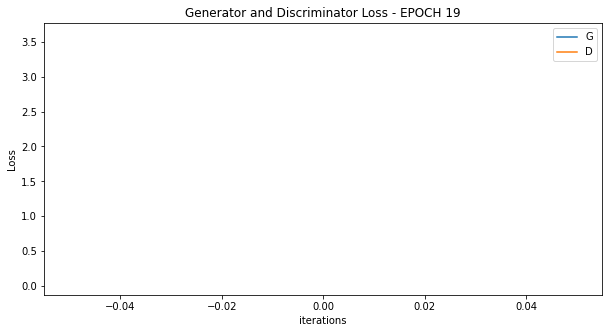

[19/100][643/644] Loss_D: 0.0488; Loss_G: 3.5950
[20/100][0/644] Loss_D: 2.6096; Loss_G: 8.5502
[20/100][1/644] Loss_D: 1.3988; Loss_G: 1.8882
[20/100][2/644] Loss_D: 0.8934; Loss_G: 4.5604
[20/100][3/644] Loss_D: 0.2369; Loss_G: 4.3888
[20/100][4/644] Loss_D: 0.2675; Loss_G: 3.5976
[20/100][5/644] Loss_D: 0.3516; Loss_G: 2.6783
[20/100][6/644] Loss_D: 1.0017; Loss_G: 7.8141
[20/100][7/644] Loss_D: 2.1064; Loss_G: 1.2633
[20/100][8/644] Loss_D: 0.5654; Loss_G: 4.1618
[20/100][9/644] Loss_D: 0.2472; Loss_G: 5.8587
[20/100][10/644] Loss_D: 0.2906; Loss_G: 4.4094
[20/100][11/644] Loss_D: 0.2084; Loss_G: 3.9654
[20/100][12/644] Loss_D: 0.5439; Loss_G: 3.0662
[20/100][13/644] Loss_D: 0.8324; Loss_G: 6.1602
[20/100][14/644] Loss_D: 0.3052; Loss_G: 4.3594
[20/100][15/644] Loss_D: 0.4229; Loss_G: 2.0468
[20/100][16/644] Loss_D: 0.7372; Loss_G: 6.3591
[20/100][17/644] Loss_D: 1.3321; Loss_G: 0.7659
[20/100][18/644] Loss_D: 1.6451; Loss_G: 8.2750
[20/100][19/644] Loss_D: 0.6834; Loss_G: 2.6722
[

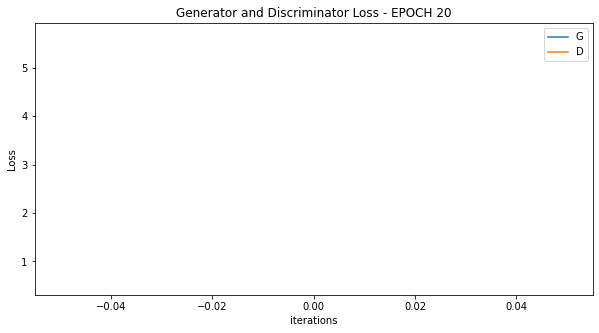

[20/100][321/644] Loss_D: 0.5656; Loss_G: 5.6670
[20/100][322/644] Loss_D: 0.2825; Loss_G: 4.5319
[20/100][323/644] Loss_D: 0.4633; Loss_G: 3.8793
[20/100][324/644] Loss_D: 0.2561; Loss_G: 3.1815
[20/100][325/644] Loss_D: 0.7794; Loss_G: 2.8537
[20/100][326/644] Loss_D: 0.3291; Loss_G: 6.2226
[20/100][327/644] Loss_D: 0.6381; Loss_G: 2.0596
[20/100][328/644] Loss_D: 0.3827; Loss_G: 5.2582
[20/100][329/644] Loss_D: 0.4160; Loss_G: 5.6390
[20/100][330/644] Loss_D: 0.4917; Loss_G: 2.9508
[20/100][331/644] Loss_D: 0.5317; Loss_G: 4.5578
[20/100][332/644] Loss_D: 0.1842; Loss_G: 4.0974
[20/100][333/644] Loss_D: 0.4811; Loss_G: 3.8960
[20/100][334/644] Loss_D: 0.3019; Loss_G: 4.4171
[20/100][335/644] Loss_D: 0.1760; Loss_G: 4.5873
[20/100][336/644] Loss_D: 0.5348; Loss_G: 2.1740
[20/100][337/644] Loss_D: 0.2104; Loss_G: 4.8227
[20/100][338/644] Loss_D: 0.2514; Loss_G: 5.1056
[20/100][339/644] Loss_D: 0.2749; Loss_G: 4.3855
[20/100][340/644] Loss_D: 0.3900; Loss_G: 2.5185
[20/100][341/644] Lo

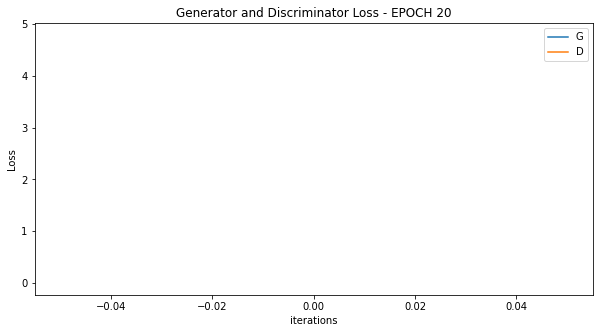

[20/100][643/644] Loss_D: 4.7847; Loss_G: 0.0112
[21/100][0/644] Loss_D: 4.1862; Loss_G: 8.5806
[21/100][1/644] Loss_D: 1.8428; Loss_G: 0.2979
[21/100][2/644] Loss_D: 3.7096; Loss_G: 10.5671
[21/100][3/644] Loss_D: 2.8218; Loss_G: 1.3568
[21/100][4/644] Loss_D: 1.9365; Loss_G: 6.9175
[21/100][5/644] Loss_D: 1.1327; Loss_G: 3.7041
[21/100][6/644] Loss_D: 0.7292; Loss_G: 3.3479
[21/100][7/644] Loss_D: 0.5430; Loss_G: 4.4114
[21/100][8/644] Loss_D: 0.6685; Loss_G: 6.9083
[21/100][9/644] Loss_D: 3.1690; Loss_G: 0.2709
[21/100][10/644] Loss_D: 3.2477; Loss_G: 7.4956
[21/100][11/644] Loss_D: 0.3855; Loss_G: 5.1668
[21/100][12/644] Loss_D: 0.5804; Loss_G: 2.1892
[21/100][13/644] Loss_D: 0.7261; Loss_G: 5.2883
[21/100][14/644] Loss_D: 1.6197; Loss_G: 1.8491
[21/100][15/644] Loss_D: 1.0731; Loss_G: 6.1700
[21/100][16/644] Loss_D: 1.8486; Loss_G: 0.7539
[21/100][17/644] Loss_D: 1.1771; Loss_G: 6.3642
[21/100][18/644] Loss_D: 1.6270; Loss_G: 2.8866
[21/100][19/644] Loss_D: 0.9739; Loss_G: 5.5634


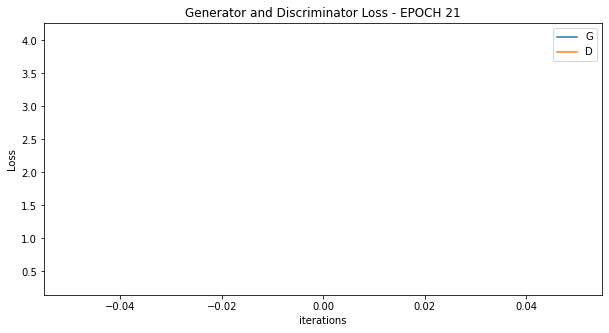

[21/100][321/644] Loss_D: 0.3318; Loss_G: 4.0774
[21/100][322/644] Loss_D: 0.3800; Loss_G: 3.7649
[21/100][323/644] Loss_D: 0.4608; Loss_G: 2.9808
[21/100][324/644] Loss_D: 0.1975; Loss_G: 4.4256
[21/100][325/644] Loss_D: 0.5311; Loss_G: 5.7874
[21/100][326/644] Loss_D: 1.8584; Loss_G: 1.0863
[21/100][327/644] Loss_D: 1.1746; Loss_G: 4.5194
[21/100][328/644] Loss_D: 0.3487; Loss_G: 4.8608
[21/100][329/644] Loss_D: 0.1078; Loss_G: 5.1933
[21/100][330/644] Loss_D: 0.7621; Loss_G: 1.8267
[21/100][331/644] Loss_D: 0.6692; Loss_G: 3.8683
[21/100][332/644] Loss_D: 0.3099; Loss_G: 3.5344
[21/100][333/644] Loss_D: 0.4749; Loss_G: 2.5924
[21/100][334/644] Loss_D: 0.6577; Loss_G: 5.9241
[21/100][335/644] Loss_D: 0.4003; Loss_G: 3.8282
[21/100][336/644] Loss_D: 0.5411; Loss_G: 3.4048
[21/100][337/644] Loss_D: 0.5178; Loss_G: 2.3264
[21/100][338/644] Loss_D: 0.8411; Loss_G: 6.2832
[21/100][339/644] Loss_D: 0.3158; Loss_G: 4.3681
[21/100][340/644] Loss_D: 0.4935; Loss_G: 1.7023
[21/100][341/644] Lo

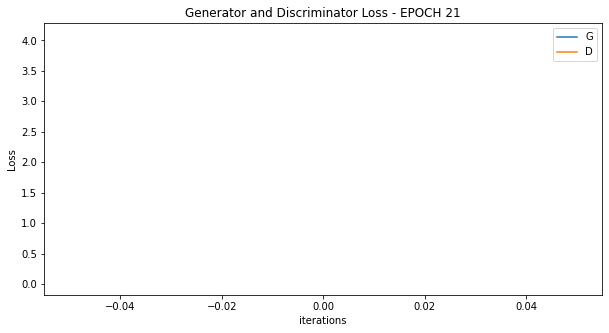

[21/100][643/644] Loss_D: 4.0813; Loss_G: 0.0277
[22/100][0/644] Loss_D: 6.0344; Loss_G: 7.6333
[22/100][1/644] Loss_D: 0.3710; Loss_G: 3.1788
[22/100][2/644] Loss_D: 1.1391; Loss_G: 0.0046
[22/100][3/644] Loss_D: 7.1055; Loss_G: 15.5337
[22/100][4/644] Loss_D: 7.2465; Loss_G: 1.6092
[22/100][5/644] Loss_D: 0.8970; Loss_G: 0.5106
[22/100][6/644] Loss_D: 3.6496; Loss_G: 9.4571
[22/100][7/644] Loss_D: 3.1599; Loss_G: 0.9159
[22/100][8/644] Loss_D: 1.4501; Loss_G: 6.0889
[22/100][9/644] Loss_D: 1.2054; Loss_G: 2.1582
[22/100][10/644] Loss_D: 0.8125; Loss_G: 3.5707
[22/100][11/644] Loss_D: 0.7899; Loss_G: 3.0889
[22/100][12/644] Loss_D: 1.1788; Loss_G: 5.4398
[22/100][13/644] Loss_D: 1.1906; Loss_G: 1.6505
[22/100][14/644] Loss_D: 1.5071; Loss_G: 5.7058
[22/100][15/644] Loss_D: 0.5746; Loss_G: 3.4437
[22/100][16/644] Loss_D: 0.5752; Loss_G: 4.8569
[22/100][17/644] Loss_D: 0.9789; Loss_G: 1.8313
[22/100][18/644] Loss_D: 1.0235; Loss_G: 5.5615
[22/100][19/644] Loss_D: 1.0659; Loss_G: 2.4522


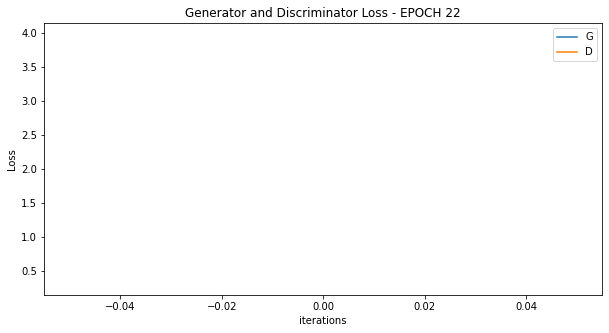

[22/100][321/644] Loss_D: 0.3316; Loss_G: 3.9602
[22/100][322/644] Loss_D: 0.3567; Loss_G: 5.6927
[22/100][323/644] Loss_D: 0.6541; Loss_G: 2.6527
[22/100][324/644] Loss_D: 0.6139; Loss_G: 5.8418
[22/100][325/644] Loss_D: 0.6356; Loss_G: 2.6976
[22/100][326/644] Loss_D: 0.5073; Loss_G: 1.4534
[22/100][327/644] Loss_D: 1.3456; Loss_G: 7.4386
[22/100][328/644] Loss_D: 0.3636; Loss_G: 5.2684
[22/100][329/644] Loss_D: 0.2210; Loss_G: 3.9116
[22/100][330/644] Loss_D: 0.2820; Loss_G: 3.6111
[22/100][331/644] Loss_D: 0.4469; Loss_G: 3.5284
[22/100][332/644] Loss_D: 0.3688; Loss_G: 6.0960
[22/100][333/644] Loss_D: 0.3278; Loss_G: 4.6141
[22/100][334/644] Loss_D: 0.4253; Loss_G: 2.8588
[22/100][335/644] Loss_D: 0.5105; Loss_G: 1.6084
[22/100][336/644] Loss_D: 0.8439; Loss_G: 6.7140
[22/100][337/644] Loss_D: 0.5805; Loss_G: 3.1758
[22/100][338/644] Loss_D: 0.2541; Loss_G: 3.4708
[22/100][339/644] Loss_D: 0.5992; Loss_G: 3.5346
[22/100][340/644] Loss_D: 0.3411; Loss_G: 5.5475
[22/100][341/644] Lo

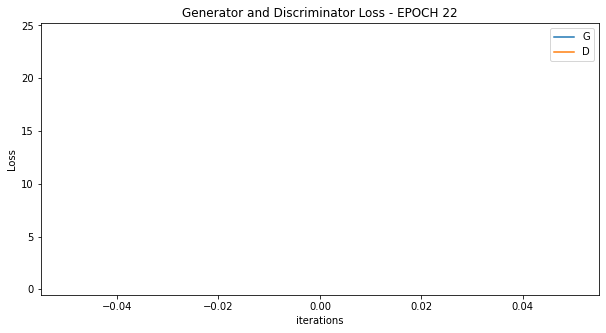

[22/100][643/644] Loss_D: 0.6472; Loss_G: 24.0633
[23/100][0/644] Loss_D: 1.7076; Loss_G: 1.0676
[23/100][1/644] Loss_D: 1.2600; Loss_G: 6.3692
[23/100][2/644] Loss_D: 1.3216; Loss_G: 1.5140
[23/100][3/644] Loss_D: 1.2805; Loss_G: 4.7310
[23/100][4/644] Loss_D: 0.3812; Loss_G: 5.1579
[23/100][5/644] Loss_D: 0.7073; Loss_G: 3.6118
[23/100][6/644] Loss_D: 0.4880; Loss_G: 3.2101
[23/100][7/644] Loss_D: 0.8183; Loss_G: 2.9878
[23/100][8/644] Loss_D: 0.9130; Loss_G: 7.7427
[23/100][9/644] Loss_D: 1.1726; Loss_G: 1.4645
[23/100][10/644] Loss_D: 0.9379; Loss_G: 7.1261
[23/100][11/644] Loss_D: 0.9551; Loss_G: 1.7291
[23/100][12/644] Loss_D: 0.7978; Loss_G: 4.2865
[23/100][13/644] Loss_D: 0.2879; Loss_G: 5.0151
[23/100][14/644] Loss_D: 0.4864; Loss_G: 5.7157
[23/100][15/644] Loss_D: 0.2721; Loss_G: 4.7249
[23/100][16/644] Loss_D: 0.2848; Loss_G: 4.4497
[23/100][17/644] Loss_D: 0.5071; Loss_G: 2.6916
[23/100][18/644] Loss_D: 0.6091; Loss_G: 4.9994
[23/100][19/644] Loss_D: 0.1956; Loss_G: 4.2586


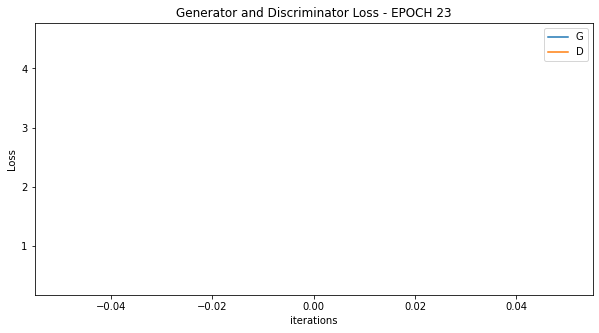

[23/100][321/644] Loss_D: 0.3866; Loss_G: 4.5563
[23/100][322/644] Loss_D: 0.5750; Loss_G: 1.7065
[23/100][323/644] Loss_D: 1.0019; Loss_G: 7.6679
[23/100][324/644] Loss_D: 0.3687; Loss_G: 5.0379
[23/100][325/644] Loss_D: 0.1836; Loss_G: 4.3468
[23/100][326/644] Loss_D: 0.5945; Loss_G: 1.6242
[23/100][327/644] Loss_D: 1.0372; Loss_G: 7.5757
[23/100][328/644] Loss_D: 0.5646; Loss_G: 3.7160
[23/100][329/644] Loss_D: 0.1670; Loss_G: 2.6594
[23/100][330/644] Loss_D: 0.5775; Loss_G: 6.3714
[23/100][331/644] Loss_D: 0.4308; Loss_G: 4.7169
[23/100][332/644] Loss_D: 0.2890; Loss_G: 2.8715
[23/100][333/644] Loss_D: 0.3149; Loss_G: 4.8081
[23/100][334/644] Loss_D: 0.2887; Loss_G: 3.5657
[23/100][335/644] Loss_D: 0.2820; Loss_G: 4.3725
[23/100][336/644] Loss_D: 0.1294; Loss_G: 4.6227
[23/100][337/644] Loss_D: 0.1959; Loss_G: 3.6437
[23/100][338/644] Loss_D: 0.4137; Loss_G: 5.4480
[23/100][339/644] Loss_D: 0.3931; Loss_G: 3.4180
[23/100][340/644] Loss_D: 0.2512; Loss_G: 3.9411
[23/100][341/644] Lo

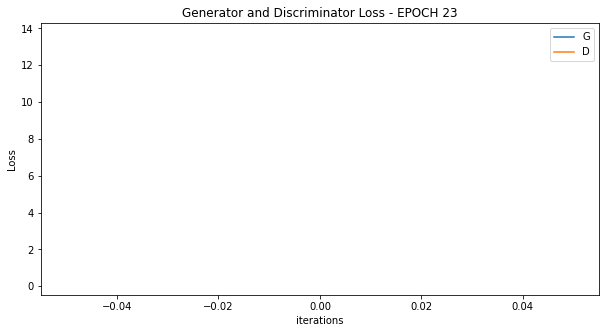

[23/100][643/644] Loss_D: 0.2071; Loss_G: 13.6200
[24/100][0/644] Loss_D: 1.8906; Loss_G: 10.8081
[24/100][1/644] Loss_D: 2.2966; Loss_G: 1.6911
[24/100][2/644] Loss_D: 0.6430; Loss_G: 5.1557
[24/100][3/644] Loss_D: 0.2980; Loss_G: 4.4343
[24/100][4/644] Loss_D: 0.6599; Loss_G: 3.9037
[24/100][5/644] Loss_D: 0.6907; Loss_G: 2.6816
[24/100][6/644] Loss_D: 0.9262; Loss_G: 7.9315
[24/100][7/644] Loss_D: 0.7885; Loss_G: 2.9986
[24/100][8/644] Loss_D: 0.1819; Loss_G: 3.7404
[24/100][9/644] Loss_D: 0.4952; Loss_G: 6.2731
[24/100][10/644] Loss_D: 0.3118; Loss_G: 4.3108
[24/100][11/644] Loss_D: 0.1416; Loss_G: 3.9900
[24/100][12/644] Loss_D: 0.4900; Loss_G: 5.4655
[24/100][13/644] Loss_D: 0.3314; Loss_G: 3.8493
[24/100][14/644] Loss_D: 0.3032; Loss_G: 2.5353
[24/100][15/644] Loss_D: 0.7717; Loss_G: 7.5186
[24/100][16/644] Loss_D: 0.7371; Loss_G: 3.1503
[24/100][17/644] Loss_D: 0.2225; Loss_G: 4.0069
[24/100][18/644] Loss_D: 0.4073; Loss_G: 2.9968
[24/100][19/644] Loss_D: 0.4979; Loss_G: 6.7348

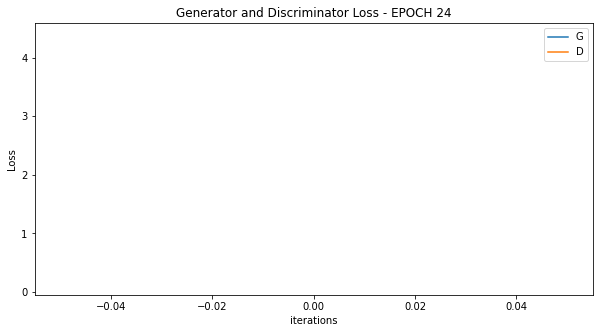

[24/100][321/644] Loss_D: 0.1651; Loss_G: 4.3786
[24/100][322/644] Loss_D: 0.2356; Loss_G: 5.1056
[24/100][323/644] Loss_D: 0.1581; Loss_G: 5.1052
[24/100][324/644] Loss_D: 0.3183; Loss_G: 5.2473
[24/100][325/644] Loss_D: 0.5769; Loss_G: 3.1808
[24/100][326/644] Loss_D: 0.4657; Loss_G: 5.2890
[24/100][327/644] Loss_D: 0.3256; Loss_G: 3.5962
[24/100][328/644] Loss_D: 0.3468; Loss_G: 3.8413
[24/100][329/644] Loss_D: 0.3112; Loss_G: 4.2020
[24/100][330/644] Loss_D: 0.2664; Loss_G: 5.2130
[24/100][331/644] Loss_D: 0.2791; Loss_G: 4.3295
[24/100][332/644] Loss_D: 0.2215; Loss_G: 4.0850
[24/100][333/644] Loss_D: 0.3455; Loss_G: 4.7575
[24/100][334/644] Loss_D: 0.4503; Loss_G: 3.3232
[24/100][335/644] Loss_D: 0.1670; Loss_G: 3.7383
[24/100][336/644] Loss_D: 0.3730; Loss_G: 5.2350
[24/100][337/644] Loss_D: 0.5050; Loss_G: 1.9144
[24/100][338/644] Loss_D: 0.7082; Loss_G: 8.7588
[24/100][339/644] Loss_D: 0.4684; Loss_G: 4.1598
[24/100][340/644] Loss_D: 0.2052; Loss_G: 2.7930
[24/100][341/644] Lo

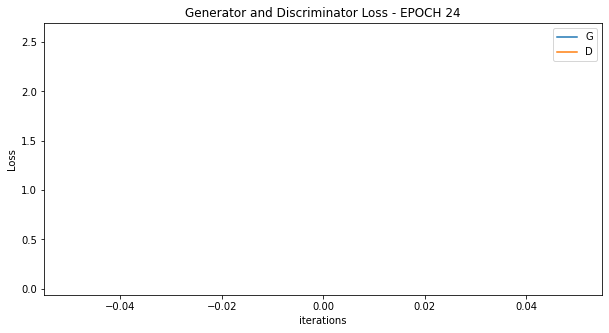

[24/100][643/644] Loss_D: 2.5686; Loss_G: 0.0648
[25/100][0/644] Loss_D: 6.7039; Loss_G: 9.1327
[25/100][1/644] Loss_D: 2.0261; Loss_G: 1.7106
[25/100][2/644] Loss_D: 2.0860; Loss_G: 9.2687
[25/100][3/644] Loss_D: 2.3815; Loss_G: 0.7196
[25/100][4/644] Loss_D: 1.4491; Loss_G: 8.3101
[25/100][5/644] Loss_D: 1.0088; Loss_G: 2.6818
[25/100][6/644] Loss_D: 0.7725; Loss_G: 4.7666
[25/100][7/644] Loss_D: 0.8053; Loss_G: 6.0217
[25/100][8/644] Loss_D: 1.0369; Loss_G: 2.1685
[25/100][9/644] Loss_D: 1.4526; Loss_G: 6.6050
[25/100][10/644] Loss_D: 0.6897; Loss_G: 3.3744
[25/100][11/644] Loss_D: 1.1418; Loss_G: 7.7804
[25/100][12/644] Loss_D: 2.5332; Loss_G: 0.5641
[25/100][13/644] Loss_D: 1.0410; Loss_G: 4.5152
[25/100][14/644] Loss_D: 1.0624; Loss_G: 7.7118
[25/100][15/644] Loss_D: 0.3358; Loss_G: 6.9992
[25/100][16/644] Loss_D: 0.7827; Loss_G: 2.2062
[25/100][17/644] Loss_D: 0.4429; Loss_G: 3.1699
[25/100][18/644] Loss_D: 0.6857; Loss_G: 4.4870
[25/100][19/644] Loss_D: 0.6201; Loss_G: 4.7758
[

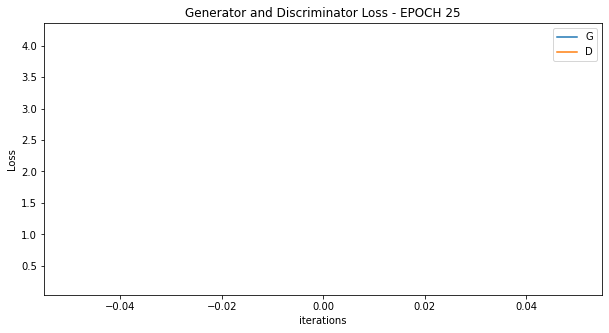

[25/100][321/644] Loss_D: 0.2348; Loss_G: 4.1640
[25/100][322/644] Loss_D: 0.5943; Loss_G: 1.9547
[25/100][323/644] Loss_D: 0.4443; Loss_G: 4.5172
[25/100][324/644] Loss_D: 0.2916; Loss_G: 3.7640
[25/100][325/644] Loss_D: 0.2911; Loss_G: 4.2689
[25/100][326/644] Loss_D: 0.2199; Loss_G: 4.7014
[25/100][327/644] Loss_D: 0.5162; Loss_G: 2.0631
[25/100][328/644] Loss_D: 0.3138; Loss_G: 5.2536
[25/100][329/644] Loss_D: 0.2397; Loss_G: 4.9742
[25/100][330/644] Loss_D: 0.3761; Loss_G: 2.8282
[25/100][331/644] Loss_D: 0.4069; Loss_G: 5.7445
[25/100][332/644] Loss_D: 0.2292; Loss_G: 4.5878
[25/100][333/644] Loss_D: 0.2374; Loss_G: 3.0791
[25/100][334/644] Loss_D: 0.3138; Loss_G: 3.7494
[25/100][335/644] Loss_D: 0.1194; Loss_G: 4.7106
[25/100][336/644] Loss_D: 0.1570; Loss_G: 4.2081
[25/100][337/644] Loss_D: 0.0986; Loss_G: 4.4143
[25/100][338/644] Loss_D: 0.5294; Loss_G: 2.1821
[25/100][339/644] Loss_D: 0.4810; Loss_G: 5.8884
[25/100][340/644] Loss_D: 0.1455; Loss_G: 5.3870
[25/100][341/644] Lo

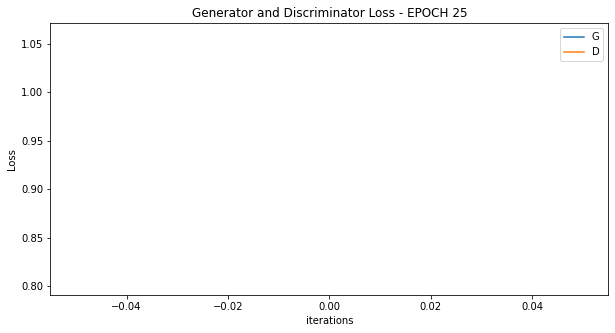

[25/100][643/644] Loss_D: 1.0587; Loss_G: 0.8038
[26/100][0/644] Loss_D: 5.8395; Loss_G: 11.1215
[26/100][1/644] Loss_D: 0.4620; Loss_G: 5.3550
[26/100][2/644] Loss_D: 0.7198; Loss_G: 1.8303
[26/100][3/644] Loss_D: 0.8717; Loss_G: 10.2082
[26/100][4/644] Loss_D: 0.8700; Loss_G: 3.9742
[26/100][5/644] Loss_D: 0.5447; Loss_G: 6.1358
[26/100][6/644] Loss_D: 0.7098; Loss_G: 1.9917
[26/100][7/644] Loss_D: 0.5137; Loss_G: 6.4016
[26/100][8/644] Loss_D: 0.5574; Loss_G: 3.1382
[26/100][9/644] Loss_D: 0.6596; Loss_G: 7.4279
[26/100][10/644] Loss_D: 0.9037; Loss_G: 1.9960
[26/100][11/644] Loss_D: 0.4674; Loss_G: 3.4055
[26/100][12/644] Loss_D: 0.5204; Loss_G: 6.8898
[26/100][13/644] Loss_D: 0.6052; Loss_G: 3.1938
[26/100][14/644] Loss_D: 0.2997; Loss_G: 4.7046
[26/100][15/644] Loss_D: 0.6082; Loss_G: 7.4577
[26/100][16/644] Loss_D: 0.9465; Loss_G: 2.8603
[26/100][17/644] Loss_D: 0.7568; Loss_G: 4.9150
[26/100][18/644] Loss_D: 0.1659; Loss_G: 4.8167
[26/100][19/644] Loss_D: 0.2250; Loss_G: 5.5983

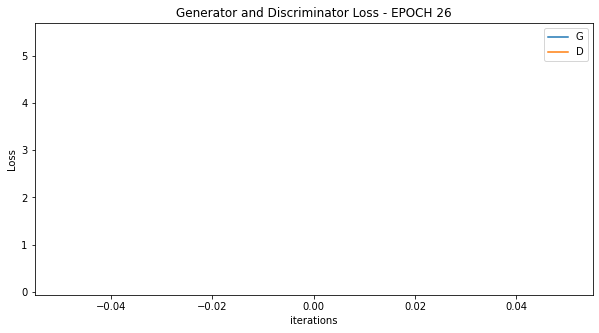

[26/100][321/644] Loss_D: 0.2001; Loss_G: 5.4318
[26/100][322/644] Loss_D: 0.2362; Loss_G: 3.8766
[26/100][323/644] Loss_D: 0.2149; Loss_G: 3.6811
[26/100][324/644] Loss_D: 0.2868; Loss_G: 3.1936
[26/100][325/644] Loss_D: 0.8578; Loss_G: 9.2997
[26/100][326/644] Loss_D: 0.7289; Loss_G: 4.6948
[26/100][327/644] Loss_D: 0.3754; Loss_G: 1.0128
[26/100][328/644] Loss_D: 1.0309; Loss_G: 8.6284
[26/100][329/644] Loss_D: 0.2362; Loss_G: 4.9330
[26/100][330/644] Loss_D: 0.0562; Loss_G: 4.6229
[26/100][331/644] Loss_D: 0.1756; Loss_G: 3.5940
[26/100][332/644] Loss_D: 0.1805; Loss_G: 5.1061
[26/100][333/644] Loss_D: 0.3865; Loss_G: 2.9191
[26/100][334/644] Loss_D: 0.3136; Loss_G: 6.1241
[26/100][335/644] Loss_D: 0.3578; Loss_G: 3.5800
[26/100][336/644] Loss_D: 0.1608; Loss_G: 4.6213
[26/100][337/644] Loss_D: 0.3534; Loss_G: 3.1276
[26/100][338/644] Loss_D: 0.2421; Loss_G: 4.8032
[26/100][339/644] Loss_D: 0.1566; Loss_G: 5.2186
[26/100][340/644] Loss_D: 0.2520; Loss_G: 4.5212
[26/100][341/644] Lo

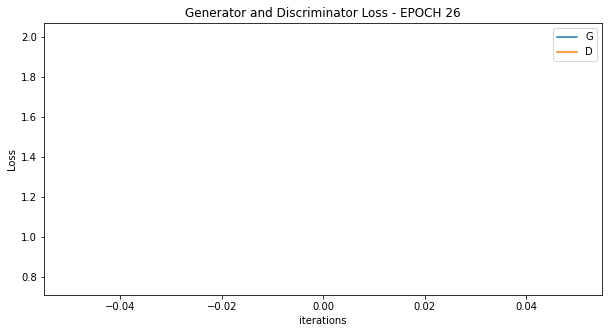

[26/100][643/644] Loss_D: 0.7717; Loss_G: 2.0074
[27/100][0/644] Loss_D: 1.8604; Loss_G: 9.8412
[27/100][1/644] Loss_D: 1.6135; Loss_G: 1.4441
[27/100][2/644] Loss_D: 0.4243; Loss_G: 5.0443
[27/100][3/644] Loss_D: 0.4776; Loss_G: 5.6611
[27/100][4/644] Loss_D: 0.5811; Loss_G: 2.9313
[27/100][5/644] Loss_D: 0.7821; Loss_G: 4.6749
[27/100][6/644] Loss_D: 0.7268; Loss_G: 4.4527
[27/100][7/644] Loss_D: 0.2651; Loss_G: 4.2112
[27/100][8/644] Loss_D: 0.8163; Loss_G: 5.7685
[27/100][9/644] Loss_D: 0.9230; Loss_G: 2.0192
[27/100][10/644] Loss_D: 0.4846; Loss_G: 5.3140
[27/100][11/644] Loss_D: 0.3749; Loss_G: 3.8952
[27/100][12/644] Loss_D: 0.3515; Loss_G: 5.0426
[27/100][13/644] Loss_D: 0.1489; Loss_G: 4.9266
[27/100][14/644] Loss_D: 0.5095; Loss_G: 3.0174
[27/100][15/644] Loss_D: 0.2012; Loss_G: 3.4767
[27/100][16/644] Loss_D: 0.7920; Loss_G: 8.3112
[27/100][17/644] Loss_D: 1.1094; Loss_G: 2.9517
[27/100][18/644] Loss_D: 0.3927; Loss_G: 3.6504
[27/100][19/644] Loss_D: 0.6396; Loss_G: 6.3401
[

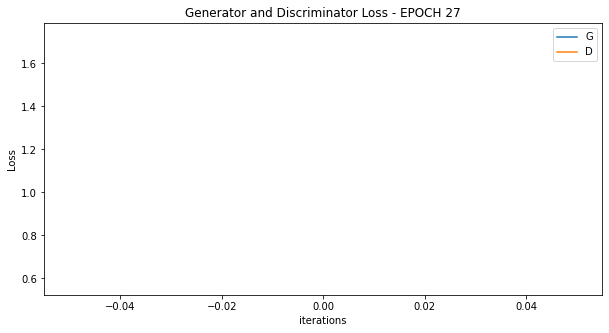

[27/100][321/644] Loss_D: 1.7306; Loss_G: 0.5810
[27/100][322/644] Loss_D: 1.3305; Loss_G: 8.3721
[27/100][323/644] Loss_D: 0.3651; Loss_G: 3.1027
[27/100][324/644] Loss_D: 0.4611; Loss_G: 7.9139
[27/100][325/644] Loss_D: 1.8004; Loss_G: 0.3051
[27/100][326/644] Loss_D: 1.4118; Loss_G: 7.8958
[27/100][327/644] Loss_D: 0.2649; Loss_G: 4.4676
[27/100][328/644] Loss_D: 0.2689; Loss_G: 3.0644
[27/100][329/644] Loss_D: 0.5494; Loss_G: 6.9754
[27/100][330/644] Loss_D: 0.5302; Loss_G: 4.4937
[27/100][331/644] Loss_D: 0.3227; Loss_G: 4.3247
[27/100][332/644] Loss_D: 0.3292; Loss_G: 4.0577
[27/100][333/644] Loss_D: 0.1460; Loss_G: 5.1048
[27/100][334/644] Loss_D: 0.2201; Loss_G: 5.0414
[27/100][335/644] Loss_D: 0.2067; Loss_G: 4.3001
[27/100][336/644] Loss_D: 0.2389; Loss_G: 3.5805
[27/100][337/644] Loss_D: 0.0891; Loss_G: 3.4910
[27/100][338/644] Loss_D: 0.6538; Loss_G: 7.6833
[27/100][339/644] Loss_D: 0.2101; Loss_G: 6.1011
[27/100][340/644] Loss_D: 0.0740; Loss_G: 4.5325
[27/100][341/644] Lo

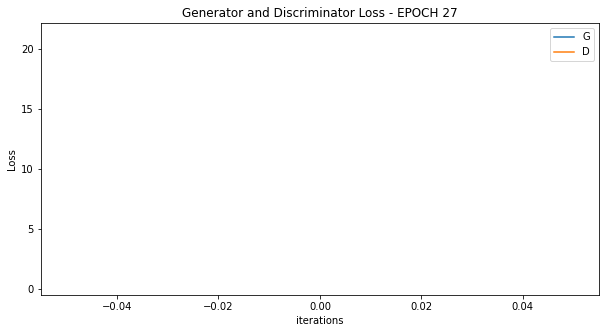

[27/100][643/644] Loss_D: 0.5440; Loss_G: 21.1395
[28/100][0/644] Loss_D: 0.3285; Loss_G: 4.8328
[28/100][1/644] Loss_D: 0.4999; Loss_G: 3.3352
[28/100][2/644] Loss_D: 0.6549; Loss_G: 1.1071
[28/100][3/644] Loss_D: 2.5889; Loss_G: 13.6398
[28/100][4/644] Loss_D: 1.3895; Loss_G: 3.1473
[28/100][5/644] Loss_D: 0.3270; Loss_G: 1.9851
[28/100][6/644] Loss_D: 1.6191; Loss_G: 11.0039
[28/100][7/644] Loss_D: 0.6366; Loss_G: 7.4600
[28/100][8/644] Loss_D: 2.4141; Loss_G: 0.0857
[28/100][9/644] Loss_D: 4.8056; Loss_G: 9.0608
[28/100][10/644] Loss_D: 0.4352; Loss_G: 4.4196
[28/100][11/644] Loss_D: 1.0877; Loss_G: 0.9497
[28/100][12/644] Loss_D: 1.1722; Loss_G: 9.5232
[28/100][13/644] Loss_D: 1.3647; Loss_G: 1.8447
[28/100][14/644] Loss_D: 0.5502; Loss_G: 6.2194
[28/100][15/644] Loss_D: 0.2132; Loss_G: 5.9252
[28/100][16/644] Loss_D: 0.5573; Loss_G: 3.5904
[28/100][17/644] Loss_D: 0.2407; Loss_G: 3.1172
[28/100][18/644] Loss_D: 0.7204; Loss_G: 6.5338
[28/100][19/644] Loss_D: 0.2583; Loss_G: 4.874

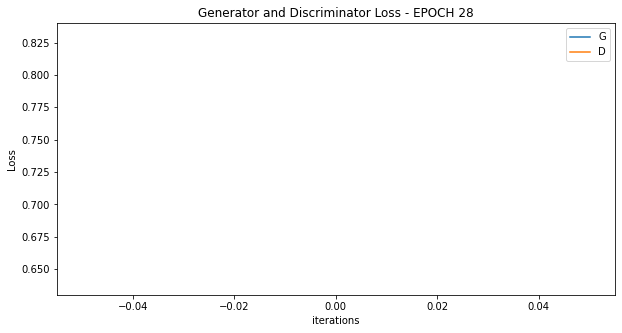

[28/100][321/644] Loss_D: 0.6396; Loss_G: 0.8305
[28/100][322/644] Loss_D: 1.2875; Loss_G: 8.6139
[28/100][323/644] Loss_D: 0.2553; Loss_G: 7.0089
[28/100][324/644] Loss_D: 0.7591; Loss_G: 1.8294
[28/100][325/644] Loss_D: 0.4997; Loss_G: 5.3105
[28/100][326/644] Loss_D: 0.0958; Loss_G: 5.2809
[28/100][327/644] Loss_D: 0.3863; Loss_G: 2.8132
[28/100][328/644] Loss_D: 0.8744; Loss_G: 8.2448
[28/100][329/644] Loss_D: 0.7108; Loss_G: 4.0021
[28/100][330/644] Loss_D: 0.3668; Loss_G: 4.3283
[28/100][331/644] Loss_D: 0.1079; Loss_G: 4.4784
[28/100][332/644] Loss_D: 0.3070; Loss_G: 4.2483
[28/100][333/644] Loss_D: 0.6262; Loss_G: 2.3754
[28/100][334/644] Loss_D: 0.7874; Loss_G: 7.1871
[28/100][335/644] Loss_D: 0.1209; Loss_G: 5.5775
[28/100][336/644] Loss_D: 0.1930; Loss_G: 3.7710
[28/100][337/644] Loss_D: 0.1436; Loss_G: 4.0864
[28/100][338/644] Loss_D: 0.4497; Loss_G: 5.3661
[28/100][339/644] Loss_D: 0.2658; Loss_G: 4.4385
[28/100][340/644] Loss_D: 0.5061; Loss_G: 3.3805
[28/100][341/644] Lo

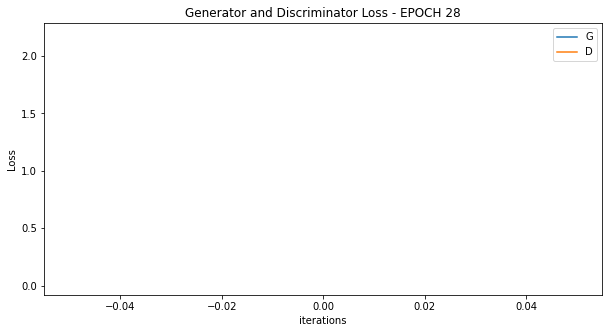

[28/100][643/644] Loss_D: 2.1807; Loss_G: 0.0274
[29/100][0/644] Loss_D: 4.8135; Loss_G: 10.6769
[29/100][1/644] Loss_D: 2.3597; Loss_G: 0.1484
[29/100][2/644] Loss_D: 5.9679; Loss_G: 13.3831
[29/100][3/644] Loss_D: 7.4603; Loss_G: 0.3318
[29/100][4/644] Loss_D: 3.7930; Loss_G: 11.1124
[29/100][5/644] Loss_D: 2.8487; Loss_G: 0.4967
[29/100][6/644] Loss_D: 1.6377; Loss_G: 7.7729
[29/100][7/644] Loss_D: 1.0773; Loss_G: 5.0453
[29/100][8/644] Loss_D: 0.4983; Loss_G: 6.2948
[29/100][9/644] Loss_D: 1.3282; Loss_G: 2.5151
[29/100][10/644] Loss_D: 0.7621; Loss_G: 4.4412
[29/100][11/644] Loss_D: 1.3805; Loss_G: 4.9210
[29/100][12/644] Loss_D: 0.7697; Loss_G: 6.9283
[29/100][13/644] Loss_D: 0.2695; Loss_G: 6.2574
[29/100][14/644] Loss_D: 1.3477; Loss_G: 0.3924
[29/100][15/644] Loss_D: 3.4741; Loss_G: 10.6417
[29/100][16/644] Loss_D: 0.9088; Loss_G: 4.6727
[29/100][17/644] Loss_D: 0.2268; Loss_G: 4.2029
[29/100][18/644] Loss_D: 2.1865; Loss_G: 12.7507
[29/100][19/644] Loss_D: 7.5947; Loss_G: 0.4

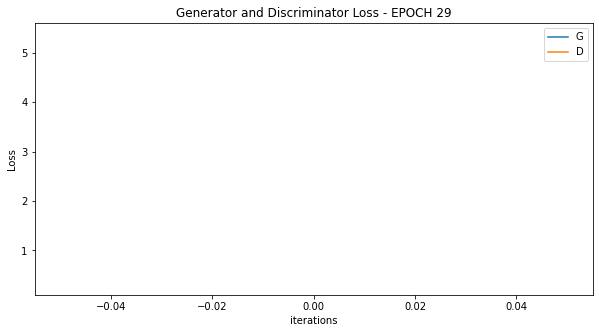

[29/100][321/644] Loss_D: 0.3502; Loss_G: 5.3506
[29/100][322/644] Loss_D: 0.3205; Loss_G: 6.5679
[29/100][323/644] Loss_D: 0.5164; Loss_G: 3.5891
[29/100][324/644] Loss_D: 0.1410; Loss_G: 3.8263
[29/100][325/644] Loss_D: 0.3084; Loss_G: 5.7721
[29/100][326/644] Loss_D: 0.2462; Loss_G: 6.4023
[29/100][327/644] Loss_D: 0.2607; Loss_G: 7.2850
[29/100][328/644] Loss_D: 0.1589; Loss_G: 5.2300
[29/100][329/644] Loss_D: 0.2428; Loss_G: 3.7428
[29/100][330/644] Loss_D: 0.1679; Loss_G: 3.5634
[29/100][331/644] Loss_D: 0.3796; Loss_G: 7.0679
[29/100][332/644] Loss_D: 0.7048; Loss_G: 2.6400
[29/100][333/644] Loss_D: 0.3322; Loss_G: 4.4088
[29/100][334/644] Loss_D: 0.0849; Loss_G: 4.4993
[29/100][335/644] Loss_D: 0.5004; Loss_G: 4.6045
[29/100][336/644] Loss_D: 0.2754; Loss_G: 3.3481
[29/100][337/644] Loss_D: 0.8363; Loss_G: 7.4798
[29/100][338/644] Loss_D: 0.6913; Loss_G: 2.8710
[29/100][339/644] Loss_D: 0.4812; Loss_G: 5.3753
[29/100][340/644] Loss_D: 0.5324; Loss_G: 4.1366
[29/100][341/644] Lo

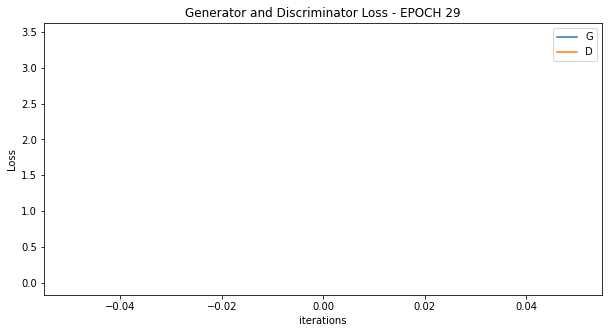

[29/100][643/644] Loss_D: 3.4543; Loss_G: 0.0012
[30/100][0/644] Loss_D: 8.6843; Loss_G: 5.2849
[30/100][1/644] Loss_D: 0.7989; Loss_G: 8.6869
[30/100][2/644] Loss_D: 2.1670; Loss_G: 0.0188
[30/100][3/644] Loss_D: 7.0889; Loss_G: 11.0006
[30/100][4/644] Loss_D: 3.5682; Loss_G: 0.3315
[30/100][5/644] Loss_D: 3.0457; Loss_G: 10.0865
[30/100][6/644] Loss_D: 2.0649; Loss_G: 2.5671
[30/100][7/644] Loss_D: 0.9060; Loss_G: 4.4845
[30/100][8/644] Loss_D: 1.0825; Loss_G: 8.3900
[30/100][9/644] Loss_D: 2.8787; Loss_G: 0.9542
[30/100][10/644] Loss_D: 2.5722; Loss_G: 7.5946
[30/100][11/644] Loss_D: 0.6607; Loss_G: 4.0282
[30/100][12/644] Loss_D: 0.2903; Loss_G: 3.6590
[30/100][13/644] Loss_D: 0.5739; Loss_G: 5.7702
[30/100][14/644] Loss_D: 0.8928; Loss_G: 4.1517
[30/100][15/644] Loss_D: 0.6925; Loss_G: 2.7481
[30/100][16/644] Loss_D: 0.9426; Loss_G: 3.3623
[30/100][17/644] Loss_D: 0.5497; Loss_G: 6.9795
[30/100][18/644] Loss_D: 0.6599; Loss_G: 3.4874
[30/100][19/644] Loss_D: 0.6282; Loss_G: 4.4267

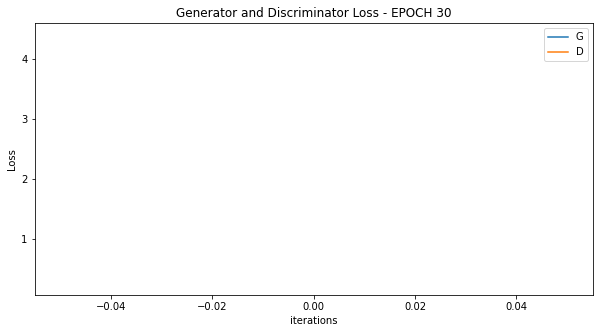

[30/100][321/644] Loss_D: 0.2793; Loss_G: 4.3878
[30/100][322/644] Loss_D: 0.1386; Loss_G: 4.9430
[30/100][323/644] Loss_D: 0.0753; Loss_G: 4.8481
[30/100][324/644] Loss_D: 0.0627; Loss_G: 6.7908
[30/100][325/644] Loss_D: 0.0954; Loss_G: 5.3781
[30/100][326/644] Loss_D: 0.1958; Loss_G: 3.9715
[30/100][327/644] Loss_D: 0.0742; Loss_G: 4.4881
[30/100][328/644] Loss_D: 0.3053; Loss_G: 4.6477
[30/100][329/644] Loss_D: 0.1444; Loss_G: 3.8063
[30/100][330/644] Loss_D: 0.3268; Loss_G: 3.6193
[30/100][331/644] Loss_D: 0.2176; Loss_G: 5.2846
[30/100][332/644] Loss_D: 0.2290; Loss_G: 4.6942
[30/100][333/644] Loss_D: 0.3790; Loss_G: 3.2021
[30/100][334/644] Loss_D: 0.1591; Loss_G: 4.2776
[30/100][335/644] Loss_D: 0.3155; Loss_G: 3.7846
[30/100][336/644] Loss_D: 0.1710; Loss_G: 4.1650
[30/100][337/644] Loss_D: 0.1578; Loss_G: 3.8593
[30/100][338/644] Loss_D: 0.2571; Loss_G: 5.3791
[30/100][339/644] Loss_D: 0.5542; Loss_G: 2.0352
[30/100][340/644] Loss_D: 0.2384; Loss_G: 4.0864
[30/100][341/644] Lo

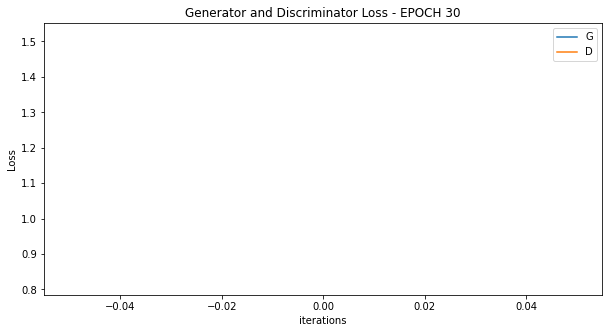

[30/100][643/644] Loss_D: 0.8198; Loss_G: 1.5172
[31/100][0/644] Loss_D: 2.4924; Loss_G: 9.3214
[31/100][1/644] Loss_D: 0.9776; Loss_G: 2.3007
[31/100][2/644] Loss_D: 0.4284; Loss_G: 5.9452
[31/100][3/644] Loss_D: 0.8665; Loss_G: 2.8489
[31/100][4/644] Loss_D: 0.5782; Loss_G: 7.2453
[31/100][5/644] Loss_D: 0.3361; Loss_G: 5.4874
[31/100][6/644] Loss_D: 0.6440; Loss_G: 2.7645
[31/100][7/644] Loss_D: 0.3762; Loss_G: 6.7380
[31/100][8/644] Loss_D: 1.5849; Loss_G: 0.4385
[31/100][9/644] Loss_D: 1.5494; Loss_G: 9.9257
[31/100][10/644] Loss_D: 0.0758; Loss_G: 7.4468
[31/100][11/644] Loss_D: 1.0143; Loss_G: 3.0200
[31/100][12/644] Loss_D: 0.3299; Loss_G: 4.1394
[31/100][13/644] Loss_D: 0.2121; Loss_G: 5.6228
[31/100][14/644] Loss_D: 0.4741; Loss_G: 4.3663
[31/100][15/644] Loss_D: 0.4035; Loss_G: 5.5872
[31/100][16/644] Loss_D: 0.4695; Loss_G: 2.8890
[31/100][17/644] Loss_D: 0.6370; Loss_G: 7.3536
[31/100][18/644] Loss_D: 0.1767; Loss_G: 6.0007
[31/100][19/644] Loss_D: 0.1450; Loss_G: 4.7630
[

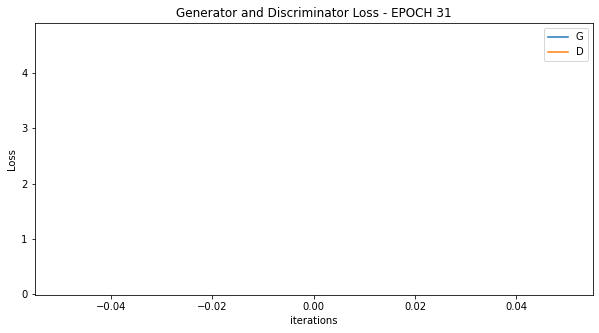

[31/100][321/644] Loss_D: 0.2122; Loss_G: 4.6778
[31/100][322/644] Loss_D: 0.1984; Loss_G: 3.4945
[31/100][323/644] Loss_D: 0.5305; Loss_G: 6.8968
[31/100][324/644] Loss_D: 0.7290; Loss_G: 2.8353
[31/100][325/644] Loss_D: 0.3436; Loss_G: 5.4480
[31/100][326/644] Loss_D: 0.1208; Loss_G: 5.2325
[31/100][327/644] Loss_D: 0.0357; Loss_G: 5.9517
[31/100][328/644] Loss_D: 0.1843; Loss_G: 5.7627
[31/100][329/644] Loss_D: 0.1038; Loss_G: 5.6727
[31/100][330/644] Loss_D: 0.4958; Loss_G: 1.8391
[31/100][331/644] Loss_D: 0.2617; Loss_G: 4.5609
[31/100][332/644] Loss_D: 0.4133; Loss_G: 7.8072
[31/100][333/644] Loss_D: 0.4762; Loss_G: 4.5682
[31/100][334/644] Loss_D: 0.1040; Loss_G: 3.3655
[31/100][335/644] Loss_D: 0.5329; Loss_G: 6.6757
[31/100][336/644] Loss_D: 0.3057; Loss_G: 5.4058
[31/100][337/644] Loss_D: 0.1260; Loss_G: 3.6696
[31/100][338/644] Loss_D: 0.4340; Loss_G: 5.5923
[31/100][339/644] Loss_D: 0.2846; Loss_G: 5.2726
[31/100][340/644] Loss_D: 0.0935; Loss_G: 4.5354
[31/100][341/644] Lo

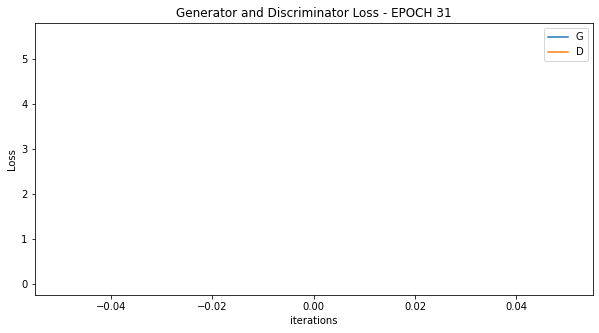

[31/100][643/644] Loss_D: 0.0324; Loss_G: 5.5204
[32/100][0/644] Loss_D: 0.1866; Loss_G: 4.6790
[32/100][1/644] Loss_D: 0.5031; Loss_G: 6.6492
[32/100][2/644] Loss_D: 0.5596; Loss_G: 4.0631
[32/100][3/644] Loss_D: 0.0605; Loss_G: 3.9881
[32/100][4/644] Loss_D: 0.3763; Loss_G: 5.1107
[32/100][5/644] Loss_D: 0.2868; Loss_G: 4.3290
[32/100][6/644] Loss_D: 0.2303; Loss_G: 5.1980
[32/100][7/644] Loss_D: 0.3137; Loss_G: 3.6768
[32/100][8/644] Loss_D: 0.2718; Loss_G: 5.7175
[32/100][9/644] Loss_D: 0.0348; Loss_G: 6.1488
[32/100][10/644] Loss_D: 0.2498; Loss_G: 4.2746
[32/100][11/644] Loss_D: 0.3236; Loss_G: 3.5455
[32/100][12/644] Loss_D: 0.4575; Loss_G: 6.8029
[32/100][13/644] Loss_D: 0.1632; Loss_G: 5.2968
[32/100][14/644] Loss_D: 0.4442; Loss_G: 3.6730
[32/100][15/644] Loss_D: 0.1679; Loss_G: 4.0091
[32/100][16/644] Loss_D: 0.1523; Loss_G: 4.7702
[32/100][17/644] Loss_D: 0.1240; Loss_G: 5.6451
[32/100][18/644] Loss_D: 0.2655; Loss_G: 3.9772
[32/100][19/644] Loss_D: 0.4332; Loss_G: 3.7629
[

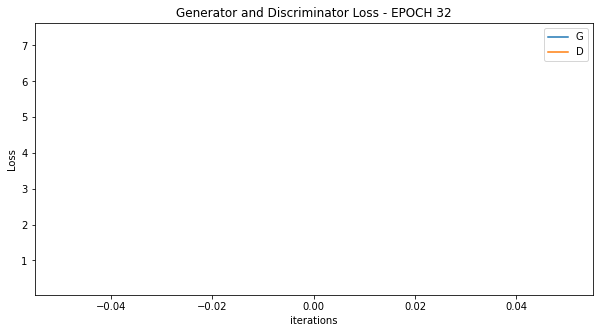

[32/100][321/644] Loss_D: 0.3867; Loss_G: 7.2825
[32/100][322/644] Loss_D: 0.5069; Loss_G: 3.1648
[32/100][323/644] Loss_D: 0.0837; Loss_G: 3.7865
[32/100][324/644] Loss_D: 0.2442; Loss_G: 5.8883
[32/100][325/644] Loss_D: 0.1841; Loss_G: 7.1358
[32/100][326/644] Loss_D: 0.1453; Loss_G: 5.9556
[32/100][327/644] Loss_D: 0.5975; Loss_G: 1.5694
[32/100][328/644] Loss_D: 0.7247; Loss_G: 8.4648
[32/100][329/644] Loss_D: 0.0482; Loss_G: 6.7726
[32/100][330/644] Loss_D: 0.1501; Loss_G: 6.3670
[32/100][331/644] Loss_D: 0.1478; Loss_G: 3.7177
[32/100][332/644] Loss_D: 0.0701; Loss_G: 4.3219
[32/100][333/644] Loss_D: 0.2388; Loss_G: 4.3215
[32/100][334/644] Loss_D: 0.2131; Loss_G: 5.0560
[32/100][335/644] Loss_D: 0.0698; Loss_G: 5.3145
[32/100][336/644] Loss_D: 0.1972; Loss_G: 3.9764
[32/100][337/644] Loss_D: 0.0837; Loss_G: 5.2419
[32/100][338/644] Loss_D: 0.0803; Loss_G: 5.0365
[32/100][339/644] Loss_D: 0.2865; Loss_G: 4.3922
[32/100][340/644] Loss_D: 0.2510; Loss_G: 5.7928
[32/100][341/644] Lo

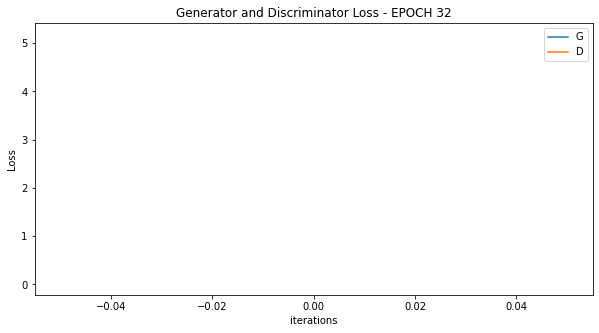

[32/100][643/644] Loss_D: 0.0389; Loss_G: 5.1621
[33/100][0/644] Loss_D: 1.1930; Loss_G: 9.6218
[33/100][1/644] Loss_D: 1.4294; Loss_G: 2.7582
[33/100][2/644] Loss_D: 0.4741; Loss_G: 5.7902
[33/100][3/644] Loss_D: 0.9487; Loss_G: 2.4097
[33/100][4/644] Loss_D: 1.0725; Loss_G: 8.9999
[33/100][5/644] Loss_D: 0.5765; Loss_G: 4.6513
[33/100][6/644] Loss_D: 0.1112; Loss_G: 3.9642
[33/100][7/644] Loss_D: 0.2999; Loss_G: 6.7621
[33/100][8/644] Loss_D: 0.1041; Loss_G: 6.1613
[33/100][9/644] Loss_D: 0.7343; Loss_G: 2.5314
[33/100][10/644] Loss_D: 0.3768; Loss_G: 4.7430
[33/100][11/644] Loss_D: 0.3767; Loss_G: 7.2669
[33/100][12/644] Loss_D: 0.6553; Loss_G: 5.3117
[33/100][13/644] Loss_D: 0.3681; Loss_G: 3.0840
[33/100][14/644] Loss_D: 0.1962; Loss_G: 3.8510
[33/100][15/644] Loss_D: 0.3420; Loss_G: 5.2494
[33/100][16/644] Loss_D: 0.1400; Loss_G: 5.1138
[33/100][17/644] Loss_D: 0.2744; Loss_G: 4.5185
[33/100][18/644] Loss_D: 0.4599; Loss_G: 5.3716
[33/100][19/644] Loss_D: 0.2322; Loss_G: 3.8421
[

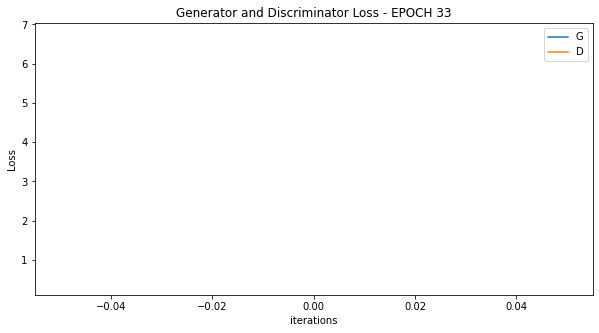

[33/100][321/644] Loss_D: 0.4280; Loss_G: 6.7206
[33/100][322/644] Loss_D: 0.3460; Loss_G: 4.0075
[33/100][323/644] Loss_D: 0.1825; Loss_G: 4.9328
[33/100][324/644] Loss_D: 0.1417; Loss_G: 5.7360
[33/100][325/644] Loss_D: 0.6415; Loss_G: 1.8577
[33/100][326/644] Loss_D: 0.7676; Loss_G: 8.3219
[33/100][327/644] Loss_D: 0.0823; Loss_G: 7.6497
[33/100][328/644] Loss_D: 0.5373; Loss_G: 1.8627
[33/100][329/644] Loss_D: 0.5111; Loss_G: 7.0878
[33/100][330/644] Loss_D: 0.1664; Loss_G: 6.2115
[33/100][331/644] Loss_D: 0.2428; Loss_G: 3.8134
[33/100][332/644] Loss_D: 0.1754; Loss_G: 4.2226
[33/100][333/644] Loss_D: 0.1794; Loss_G: 5.4340
[33/100][334/644] Loss_D: 0.1014; Loss_G: 5.8053
[33/100][335/644] Loss_D: 0.2111; Loss_G: 3.9276
[33/100][336/644] Loss_D: 0.4563; Loss_G: 7.8744
[33/100][337/644] Loss_D: 0.3424; Loss_G: 4.5342
[33/100][338/644] Loss_D: 0.1535; Loss_G: 3.3101
[33/100][339/644] Loss_D: 0.5717; Loss_G: 7.0800
[33/100][340/644] Loss_D: 0.0857; Loss_G: 5.8342
[33/100][341/644] Lo

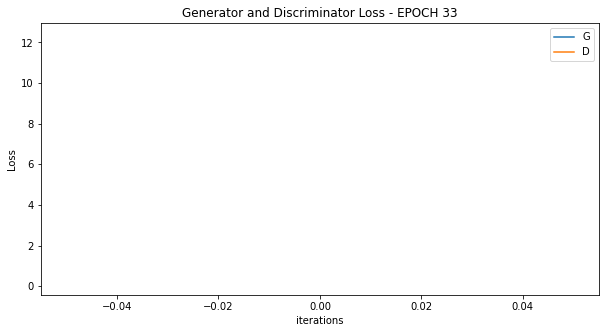

[33/100][643/644] Loss_D: 0.1842; Loss_G: 12.3458
[34/100][0/644] Loss_D: 0.9557; Loss_G: 2.9643
[34/100][1/644] Loss_D: 0.6445; Loss_G: 6.1108
[34/100][2/644] Loss_D: 0.1156; Loss_G: 5.6024
[34/100][3/644] Loss_D: 0.4036; Loss_G: 3.4041
[34/100][4/644] Loss_D: 0.1414; Loss_G: 4.6921
[34/100][5/644] Loss_D: 0.2336; Loss_G: 5.2226
[34/100][6/644] Loss_D: 0.1558; Loss_G: 4.3988
[34/100][7/644] Loss_D: 0.3544; Loss_G: 3.9589
[34/100][8/644] Loss_D: 0.1228; Loss_G: 5.0573
[34/100][9/644] Loss_D: 0.5028; Loss_G: 3.2999
[34/100][10/644] Loss_D: 0.2045; Loss_G: 4.6190
[34/100][11/644] Loss_D: 0.2955; Loss_G: 5.4723
[34/100][12/644] Loss_D: 0.2894; Loss_G: 5.3170
[34/100][13/644] Loss_D: 0.2959; Loss_G: 3.0354
[34/100][14/644] Loss_D: 0.3333; Loss_G: 5.0392
[34/100][15/644] Loss_D: 0.1826; Loss_G: 5.8870
[34/100][16/644] Loss_D: 0.3089; Loss_G: 4.1410
[34/100][17/644] Loss_D: 0.1417; Loss_G: 3.7583
[34/100][18/644] Loss_D: 0.1899; Loss_G: 4.1474
[34/100][19/644] Loss_D: 0.3443; Loss_G: 5.7304


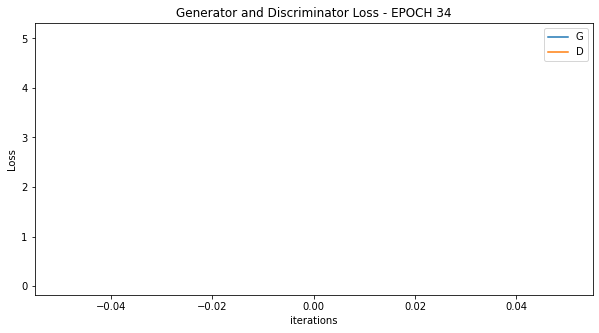

[34/100][321/644] Loss_D: 0.0742; Loss_G: 5.0607
[34/100][322/644] Loss_D: 0.2692; Loss_G: 3.2729
[34/100][323/644] Loss_D: 0.2429; Loss_G: 5.2757
[34/100][324/644] Loss_D: 0.2133; Loss_G: 4.6438
[34/100][325/644] Loss_D: 0.5748; Loss_G: 2.9140
[34/100][326/644] Loss_D: 0.5609; Loss_G: 8.9621
[34/100][327/644] Loss_D: 0.6577; Loss_G: 5.7998
[34/100][328/644] Loss_D: 0.1005; Loss_G: 3.4673
[34/100][329/644] Loss_D: 0.1590; Loss_G: 5.2319
[34/100][330/644] Loss_D: 0.1365; Loss_G: 5.1544
[34/100][331/644] Loss_D: 0.1353; Loss_G: 6.3679
[34/100][332/644] Loss_D: 0.0984; Loss_G: 6.0460
[34/100][333/644] Loss_D: 0.1141; Loss_G: 4.8497
[34/100][334/644] Loss_D: 0.3133; Loss_G: 4.0489
[34/100][335/644] Loss_D: 0.3970; Loss_G: 5.4863
[34/100][336/644] Loss_D: 0.0305; Loss_G: 7.0297
[34/100][337/644] Loss_D: 0.4112; Loss_G: 3.6025
[34/100][338/644] Loss_D: 0.1555; Loss_G: 3.5651
[34/100][339/644] Loss_D: 0.1162; Loss_G: 5.0118
[34/100][340/644] Loss_D: 0.1017; Loss_G: 5.3247
[34/100][341/644] Lo

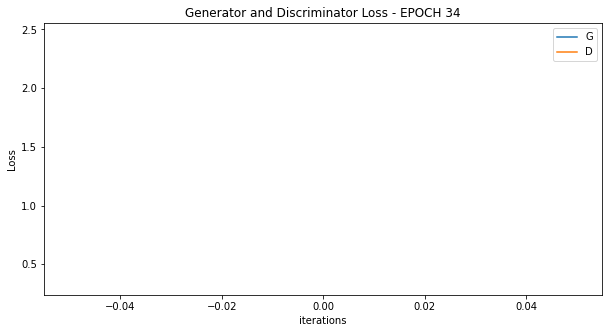

[34/100][643/644] Loss_D: 2.4493; Loss_G: 0.3454
[35/100][0/644] Loss_D: 6.4227; Loss_G: 9.8466
[35/100][1/644] Loss_D: 0.8384; Loss_G: 2.9134
[35/100][2/644] Loss_D: 0.9295; Loss_G: 6.8002
[35/100][3/644] Loss_D: 1.1077; Loss_G: 0.8281
[35/100][4/644] Loss_D: 2.8263; Loss_G: 11.4900
[35/100][5/644] Loss_D: 2.5955; Loss_G: 1.0532
[35/100][6/644] Loss_D: 0.5342; Loss_G: 4.5261
[35/100][7/644] Loss_D: 0.5598; Loss_G: 8.5148
[35/100][8/644] Loss_D: 1.4099; Loss_G: 1.4404
[35/100][9/644] Loss_D: 1.0367; Loss_G: 9.0012
[35/100][10/644] Loss_D: 1.0682; Loss_G: 4.7102
[35/100][11/644] Loss_D: 0.6320; Loss_G: 1.8275
[35/100][12/644] Loss_D: 0.8779; Loss_G: 8.2264
[35/100][13/644] Loss_D: 0.1979; Loss_G: 6.4047
[35/100][14/644] Loss_D: 0.6816; Loss_G: 2.7455
[35/100][15/644] Loss_D: 0.8711; Loss_G: 5.9274
[35/100][16/644] Loss_D: 0.2161; Loss_G: 6.1356
[35/100][17/644] Loss_D: 1.3544; Loss_G: 2.6085
[35/100][18/644] Loss_D: 0.4932; Loss_G: 5.9253
[35/100][19/644] Loss_D: 0.5251; Loss_G: 6.2152


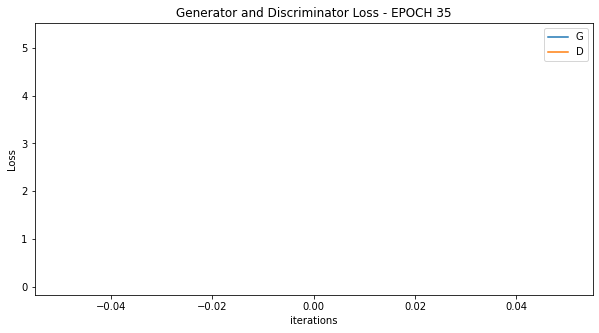

[35/100][321/644] Loss_D: 0.0951; Loss_G: 5.2574
[35/100][322/644] Loss_D: 0.2350; Loss_G: 3.8449
[35/100][323/644] Loss_D: 0.1311; Loss_G: 4.1764
[35/100][324/644] Loss_D: 0.2859; Loss_G: 6.5647
[35/100][325/644] Loss_D: 0.2660; Loss_G: 5.3070
[35/100][326/644] Loss_D: 0.2285; Loss_G: 3.2306
[35/100][327/644] Loss_D: 0.3277; Loss_G: 5.9198
[35/100][328/644] Loss_D: 0.1587; Loss_G: 4.7440
[35/100][329/644] Loss_D: 0.1782; Loss_G: 4.5104
[35/100][330/644] Loss_D: 0.1916; Loss_G: 5.0344
[35/100][331/644] Loss_D: 0.2562; Loss_G: 2.8468
[35/100][332/644] Loss_D: 0.4201; Loss_G: 7.0227
[35/100][333/644] Loss_D: 0.2283; Loss_G: 5.0348
[35/100][334/644] Loss_D: 0.3040; Loss_G: 3.0717
[35/100][335/644] Loss_D: 0.2524; Loss_G: 5.4326
[35/100][336/644] Loss_D: 0.3493; Loss_G: 6.5362
[35/100][337/644] Loss_D: 0.0373; Loss_G: 6.2584
[35/100][338/644] Loss_D: 0.2834; Loss_G: 4.1355
[35/100][339/644] Loss_D: 0.2018; Loss_G: 4.3210
[35/100][340/644] Loss_D: 0.1525; Loss_G: 6.4636
[35/100][341/644] Lo

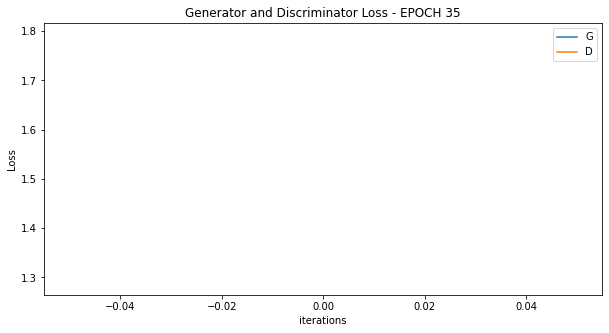

[35/100][643/644] Loss_D: 1.2900; Loss_G: 1.7914
[36/100][0/644] Loss_D: 1.7785; Loss_G: 10.9730
[36/100][1/644] Loss_D: 2.1698; Loss_G: 0.0002
[36/100][2/644] Loss_D: 14.9862; Loss_G: 9.7925
[36/100][3/644] Loss_D: 1.3925; Loss_G: 4.4698
[36/100][4/644] Loss_D: 1.8366; Loss_G: 5.3161
[36/100][5/644] Loss_D: 1.5122; Loss_G: 3.9908
[36/100][6/644] Loss_D: 1.2105; Loss_G: 2.9495
[36/100][7/644] Loss_D: 0.9472; Loss_G: 5.2653
[36/100][8/644] Loss_D: 0.8329; Loss_G: 1.7835
[36/100][9/644] Loss_D: 1.4520; Loss_G: 11.5879
[36/100][10/644] Loss_D: 1.0128; Loss_G: 2.9959
[36/100][11/644] Loss_D: 0.3483; Loss_G: 3.6217
[36/100][12/644] Loss_D: 0.8291; Loss_G: 5.2961
[36/100][13/644] Loss_D: 0.3318; Loss_G: 6.2584
[36/100][14/644] Loss_D: 1.1305; Loss_G: 1.4052
[36/100][15/644] Loss_D: 1.8876; Loss_G: 9.0824
[36/100][16/644] Loss_D: 0.0785; Loss_G: 8.7889
[36/100][17/644] Loss_D: 0.5780; Loss_G: 4.0998
[36/100][18/644] Loss_D: 0.7272; Loss_G: 1.9393
[36/100][19/644] Loss_D: 1.2518; Loss_G: 9.228

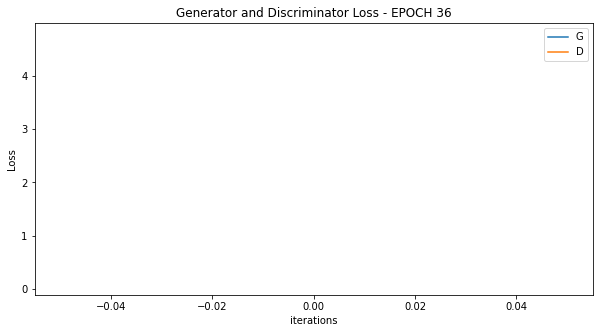

[36/100][321/644] Loss_D: 0.1196; Loss_G: 4.7638
[36/100][322/644] Loss_D: 0.1032; Loss_G: 4.3359
[36/100][323/644] Loss_D: 0.3162; Loss_G: 3.6045
[36/100][324/644] Loss_D: 0.1463; Loss_G: 4.5004
[36/100][325/644] Loss_D: 0.2650; Loss_G: 6.6691
[36/100][326/644] Loss_D: 0.5226; Loss_G: 2.4928
[36/100][327/644] Loss_D: 0.2186; Loss_G: 5.0452
[36/100][328/644] Loss_D: 0.4353; Loss_G: 6.4228
[36/100][329/644] Loss_D: 0.1206; Loss_G: 6.5405
[36/100][330/644] Loss_D: 0.3362; Loss_G: 3.7968
[36/100][331/644] Loss_D: 0.2377; Loss_G: 3.9681
[36/100][332/644] Loss_D: 0.2021; Loss_G: 4.0671
[36/100][333/644] Loss_D: 0.3321; Loss_G: 6.0057
[36/100][334/644] Loss_D: 0.1286; Loss_G: 5.1040
[36/100][335/644] Loss_D: 0.1312; Loss_G: 5.2773
[36/100][336/644] Loss_D: 0.4598; Loss_G: 2.3065
[36/100][337/644] Loss_D: 0.2465; Loss_G: 4.2127
[36/100][338/644] Loss_D: 0.2885; Loss_G: 6.7166
[36/100][339/644] Loss_D: 0.5219; Loss_G: 3.4264
[36/100][340/644] Loss_D: 0.2108; Loss_G: 3.9151
[36/100][341/644] Lo

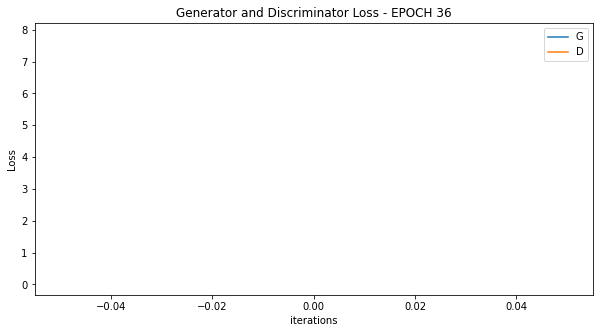

[36/100][643/644] Loss_D: 0.0609; Loss_G: 7.8219
[37/100][0/644] Loss_D: 0.9467; Loss_G: 10.6868
[37/100][1/644] Loss_D: 0.5644; Loss_G: 6.2842
[37/100][2/644] Loss_D: 0.3022; Loss_G: 1.4134
[37/100][3/644] Loss_D: 0.3189; Loss_G: 6.2711
[37/100][4/644] Loss_D: 0.1677; Loss_G: 7.3072
[37/100][5/644] Loss_D: 0.6698; Loss_G: 2.8247
[37/100][6/644] Loss_D: 0.3709; Loss_G: 5.7209
[37/100][7/644] Loss_D: 0.1938; Loss_G: 6.5411
[37/100][8/644] Loss_D: 0.0824; Loss_G: 7.0495
[37/100][9/644] Loss_D: 0.0917; Loss_G: 5.5811
[37/100][10/644] Loss_D: 0.0302; Loss_G: 5.3114
[37/100][11/644] Loss_D: 0.0858; Loss_G: 5.1837
[37/100][12/644] Loss_D: 0.3209; Loss_G: 4.2899
[37/100][13/644] Loss_D: 0.0993; Loss_G: 4.8964
[37/100][14/644] Loss_D: 0.1493; Loss_G: 5.3872
[37/100][15/644] Loss_D: 0.1022; Loss_G: 4.7469
[37/100][16/644] Loss_D: 0.3778; Loss_G: 7.6227
[37/100][17/644] Loss_D: 0.1800; Loss_G: 5.8856
[37/100][18/644] Loss_D: 0.2382; Loss_G: 4.0703
[37/100][19/644] Loss_D: 0.4479; Loss_G: 5.5991


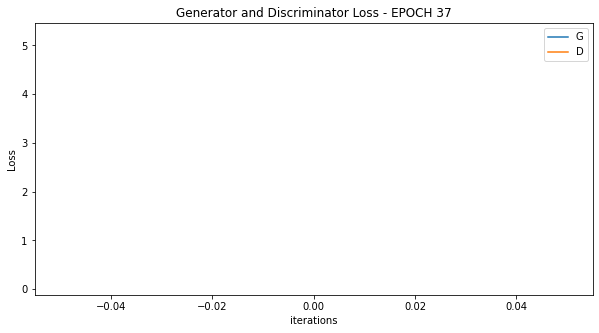

[37/100][321/644] Loss_D: 0.1396; Loss_G: 5.2049
[37/100][322/644] Loss_D: 0.0636; Loss_G: 5.3963
[37/100][323/644] Loss_D: 0.2146; Loss_G: 3.8640
[37/100][324/644] Loss_D: 0.0592; Loss_G: 4.5005
[37/100][325/644] Loss_D: 0.1318; Loss_G: 5.2719
[37/100][326/644] Loss_D: 0.3186; Loss_G: 4.0027
[37/100][327/644] Loss_D: 0.1285; Loss_G: 4.9100
[37/100][328/644] Loss_D: 0.2535; Loss_G: 6.4352
[37/100][329/644] Loss_D: 0.4584; Loss_G: 3.4137
[37/100][330/644] Loss_D: 0.0610; Loss_G: 4.7605
[37/100][331/644] Loss_D: 0.3910; Loss_G: 3.6644
[37/100][332/644] Loss_D: 0.1322; Loss_G: 4.8421
[37/100][333/644] Loss_D: 0.4378; Loss_G: 5.5756
[37/100][334/644] Loss_D: 0.0579; Loss_G: 5.8428
[37/100][335/644] Loss_D: 0.0649; Loss_G: 5.0557
[37/100][336/644] Loss_D: 0.5272; Loss_G: 1.4666
[37/100][337/644] Loss_D: 0.9899; Loss_G: 9.4288
[37/100][338/644] Loss_D: 0.2719; Loss_G: 6.3755
[37/100][339/644] Loss_D: 0.4365; Loss_G: 1.6755
[37/100][340/644] Loss_D: 0.4216; Loss_G: 6.6172
[37/100][341/644] Lo

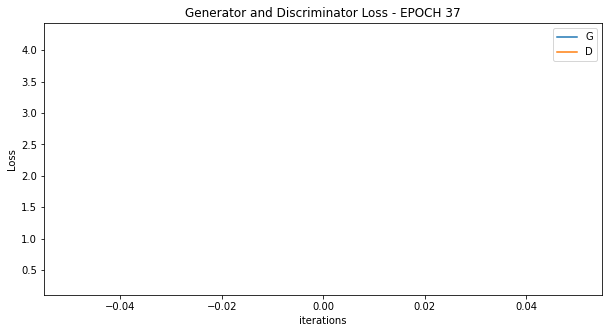

[37/100][643/644] Loss_D: 0.3012; Loss_G: 4.2367
[38/100][0/644] Loss_D: 1.0966; Loss_G: 8.8816
[38/100][1/644] Loss_D: 0.1972; Loss_G: 9.1386
[38/100][2/644] Loss_D: 0.2907; Loss_G: 3.5726
[38/100][3/644] Loss_D: 0.1590; Loss_G: 2.9299
[38/100][4/644] Loss_D: 0.6084; Loss_G: 7.1232
[38/100][5/644] Loss_D: 0.8451; Loss_G: 6.5402
[38/100][6/644] Loss_D: 0.0434; Loss_G: 5.2774
[38/100][7/644] Loss_D: 0.5693; Loss_G: 2.2872
[38/100][8/644] Loss_D: 0.7544; Loss_G: 8.3760
[38/100][9/644] Loss_D: 0.2057; Loss_G: 6.4575
[38/100][10/644] Loss_D: 0.7327; Loss_G: 1.5383
[38/100][11/644] Loss_D: 1.5088; Loss_G: 14.1642
[38/100][12/644] Loss_D: 0.5172; Loss_G: 7.4602
[38/100][13/644] Loss_D: 0.7157; Loss_G: 1.2405
[38/100][14/644] Loss_D: 1.6241; Loss_G: 10.4749
[38/100][15/644] Loss_D: 0.4690; Loss_G: 5.3108
[38/100][16/644] Loss_D: 0.4179; Loss_G: 2.8560
[38/100][17/644] Loss_D: 0.4120; Loss_G: 6.0858
[38/100][18/644] Loss_D: 0.2585; Loss_G: 6.2693
[38/100][19/644] Loss_D: 0.1613; Loss_G: 4.6646

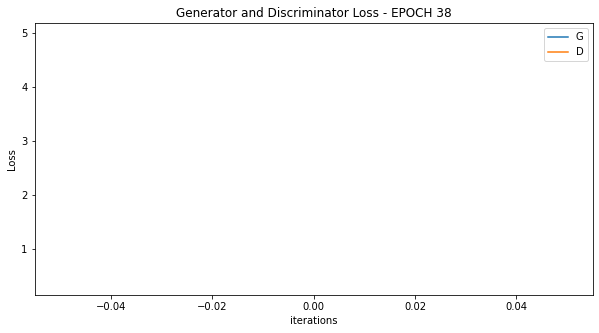

[38/100][321/644] Loss_D: 0.3741; Loss_G: 4.9590
[38/100][322/644] Loss_D: 0.1790; Loss_G: 5.2119
[38/100][323/644] Loss_D: 0.1225; Loss_G: 5.1498
[38/100][324/644] Loss_D: 0.2466; Loss_G: 4.0618
[38/100][325/644] Loss_D: 0.4726; Loss_G: 4.3559
[38/100][326/644] Loss_D: 0.1080; Loss_G: 4.7149
[38/100][327/644] Loss_D: 0.1803; Loss_G: 5.6297
[38/100][328/644] Loss_D: 0.4328; Loss_G: 5.6985
[38/100][329/644] Loss_D: 0.1628; Loss_G: 6.2419
[38/100][330/644] Loss_D: 0.3843; Loss_G: 3.8092
[38/100][331/644] Loss_D: 0.5192; Loss_G: 3.9843
[38/100][332/644] Loss_D: 0.5407; Loss_G: 5.8948
[38/100][333/644] Loss_D: 0.6890; Loss_G: 2.6815
[38/100][334/644] Loss_D: 0.5675; Loss_G: 7.3417
[38/100][335/644] Loss_D: 0.7350; Loss_G: 3.3277
[38/100][336/644] Loss_D: 0.5812; Loss_G: 5.8391
[38/100][337/644] Loss_D: 0.2600; Loss_G: 5.5682
[38/100][338/644] Loss_D: 0.4756; Loss_G: 4.7643
[38/100][339/644] Loss_D: 0.0596; Loss_G: 4.7272
[38/100][340/644] Loss_D: 0.3373; Loss_G: 4.6189
[38/100][341/644] Lo

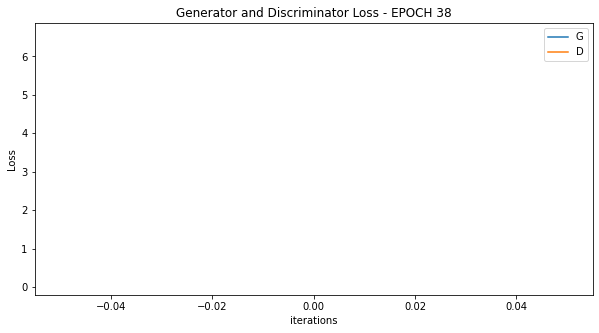

[38/100][643/644] Loss_D: 0.1184; Loss_G: 6.5461
[39/100][0/644] Loss_D: 0.0229; Loss_G: 5.7138
[39/100][1/644] Loss_D: 0.2020; Loss_G: 3.9697
[39/100][2/644] Loss_D: 0.2431; Loss_G: 5.2773
[39/100][3/644] Loss_D: 0.2311; Loss_G: 4.5981
[39/100][4/644] Loss_D: 0.1060; Loss_G: 5.4465
[39/100][5/644] Loss_D: 0.0885; Loss_G: 5.7891
[39/100][6/644] Loss_D: 0.0439; Loss_G: 6.3302
[39/100][7/644] Loss_D: 0.1154; Loss_G: 4.4981
[39/100][8/644] Loss_D: 0.1048; Loss_G: 4.6788
[39/100][9/644] Loss_D: 0.3037; Loss_G: 4.1286
[39/100][10/644] Loss_D: 0.1846; Loss_G: 4.5994
[39/100][11/644] Loss_D: 0.1400; Loss_G: 6.0276
[39/100][12/644] Loss_D: 0.2304; Loss_G: 5.2980
[39/100][13/644] Loss_D: 0.0955; Loss_G: 5.1646
[39/100][14/644] Loss_D: 0.2602; Loss_G: 6.4936
[39/100][15/644] Loss_D: 0.1345; Loss_G: 5.6211
[39/100][16/644] Loss_D: 0.0885; Loss_G: 4.6263
[39/100][17/644] Loss_D: 0.4149; Loss_G: 2.4617
[39/100][18/644] Loss_D: 0.2432; Loss_G: 6.1722
[39/100][19/644] Loss_D: 0.1094; Loss_G: 6.1568
[

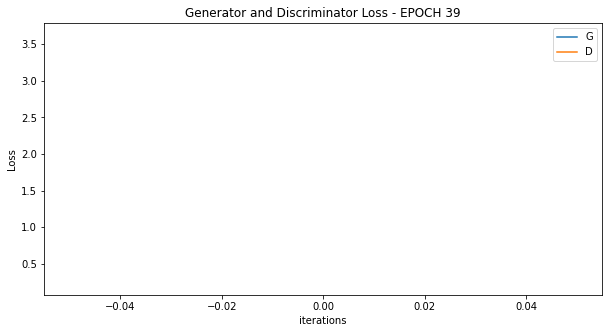

[39/100][321/644] Loss_D: 0.2461; Loss_G: 3.6189
[39/100][322/644] Loss_D: 0.1715; Loss_G: 4.7714
[39/100][323/644] Loss_D: 0.8405; Loss_G: 9.0837
[39/100][324/644] Loss_D: 0.7132; Loss_G: 5.0816
[39/100][325/644] Loss_D: 0.2426; Loss_G: 2.2471
[39/100][326/644] Loss_D: 0.7578; Loss_G: 7.5549
[39/100][327/644] Loss_D: 0.1712; Loss_G: 6.8811
[39/100][328/644] Loss_D: 0.2057; Loss_G: 6.5438
[39/100][329/644] Loss_D: 0.7711; Loss_G: 1.7999
[39/100][330/644] Loss_D: 1.1411; Loss_G: 10.1573
[39/100][331/644] Loss_D: 0.1241; Loss_G: 7.0194
[39/100][332/644] Loss_D: 0.6072; Loss_G: 1.5657
[39/100][333/644] Loss_D: 0.4791; Loss_G: 7.5801
[39/100][334/644] Loss_D: 0.3873; Loss_G: 6.1711
[39/100][335/644] Loss_D: 0.5540; Loss_G: 2.4204
[39/100][336/644] Loss_D: 0.3128; Loss_G: 3.8726
[39/100][337/644] Loss_D: 0.4547; Loss_G: 7.0389
[39/100][338/644] Loss_D: 0.1753; Loss_G: 6.3310
[39/100][339/644] Loss_D: 1.1784; Loss_G: 0.9576
[39/100][340/644] Loss_D: 1.2521; Loss_G: 8.5008
[39/100][341/644] L

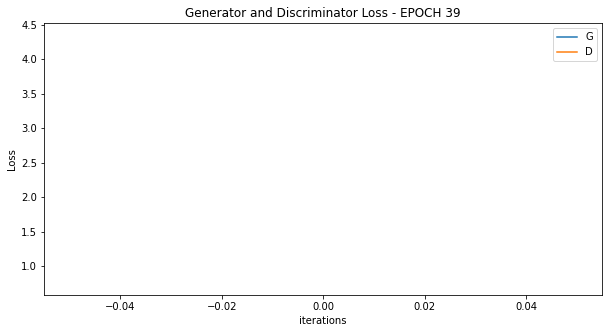

[39/100][643/644] Loss_D: 0.7619; Loss_G: 4.3429
[40/100][0/644] Loss_D: 1.6711; Loss_G: 11.6855
[40/100][1/644] Loss_D: 1.1307; Loss_G: 2.7562
[40/100][2/644] Loss_D: 0.9361; Loss_G: 10.2834
[40/100][3/644] Loss_D: 0.6794; Loss_G: 3.5008
[40/100][4/644] Loss_D: 0.2314; Loss_G: 5.1837
[40/100][5/644] Loss_D: 0.8257; Loss_G: 7.2359
[40/100][6/644] Loss_D: 0.7464; Loss_G: 4.0136
[40/100][7/644] Loss_D: 0.6845; Loss_G: 4.3284
[40/100][8/644] Loss_D: 0.4152; Loss_G: 9.0048
[40/100][9/644] Loss_D: 0.2719; Loss_G: 5.8507
[40/100][10/644] Loss_D: 0.9462; Loss_G: 4.7868
[40/100][11/644] Loss_D: 0.2269; Loss_G: 6.1948
[40/100][12/644] Loss_D: 0.3616; Loss_G: 5.4237
[40/100][13/644] Loss_D: 0.1910; Loss_G: 7.0791
[40/100][14/644] Loss_D: 0.3932; Loss_G: 4.4675
[40/100][15/644] Loss_D: 0.5878; Loss_G: 7.0460
[40/100][16/644] Loss_D: 0.4104; Loss_G: 5.3050
[40/100][17/644] Loss_D: 0.1733; Loss_G: 4.1070
[40/100][18/644] Loss_D: 0.2126; Loss_G: 5.6308
[40/100][19/644] Loss_D: 0.1527; Loss_G: 5.5112

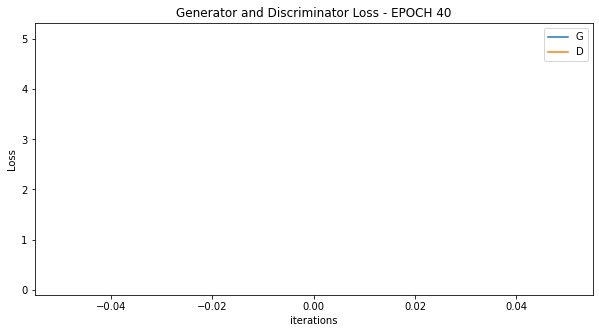

[40/100][321/644] Loss_D: 0.1455; Loss_G: 5.0735
[40/100][322/644] Loss_D: 0.1208; Loss_G: 6.4056
[40/100][323/644] Loss_D: 0.1491; Loss_G: 5.2195
[40/100][324/644] Loss_D: 0.1678; Loss_G: 4.0092
[40/100][325/644] Loss_D: 0.1982; Loss_G: 5.0029
[40/100][326/644] Loss_D: 0.3364; Loss_G: 6.4109
[40/100][327/644] Loss_D: 0.1019; Loss_G: 6.3886
[40/100][328/644] Loss_D: 0.1530; Loss_G: 4.2661
[40/100][329/644] Loss_D: 0.0715; Loss_G: 5.3944
[40/100][330/644] Loss_D: 0.1319; Loss_G: 4.6796
[40/100][331/644] Loss_D: 0.2389; Loss_G: 4.0379
[40/100][332/644] Loss_D: 0.2316; Loss_G: 6.6451
[40/100][333/644] Loss_D: 0.3988; Loss_G: 4.2075
[40/100][334/644] Loss_D: 0.1335; Loss_G: 3.9359
[40/100][335/644] Loss_D: 0.1980; Loss_G: 6.4453
[40/100][336/644] Loss_D: 0.3922; Loss_G: 7.4330
[40/100][337/644] Loss_D: 0.2529; Loss_G: 5.2027
[40/100][338/644] Loss_D: 0.6505; Loss_G: 1.1696
[40/100][339/644] Loss_D: 1.0898; Loss_G: 10.3521
[40/100][340/644] Loss_D: 0.3477; Loss_G: 5.0387
[40/100][341/644] L

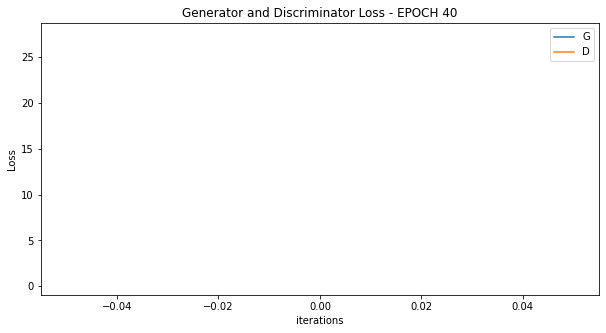

[40/100][643/644] Loss_D: 0.4069; Loss_G: 27.3765
[41/100][0/644] Loss_D: 1.0552; Loss_G: 2.5018
[41/100][1/644] Loss_D: 0.5594; Loss_G: 7.1110
[41/100][2/644] Loss_D: 0.5135; Loss_G: 3.7440
[41/100][3/644] Loss_D: 0.5559; Loss_G: 7.5363
[41/100][4/644] Loss_D: 0.8917; Loss_G: 1.9714
[41/100][5/644] Loss_D: 0.9646; Loss_G: 8.3861
[41/100][6/644] Loss_D: 0.1209; Loss_G: 6.5888
[41/100][7/644] Loss_D: 0.3500; Loss_G: 4.0774
[41/100][8/644] Loss_D: 0.7139; Loss_G: 6.3795
[41/100][9/644] Loss_D: 0.1447; Loss_G: 4.8365
[41/100][10/644] Loss_D: 0.2489; Loss_G: 4.0979
[41/100][11/644] Loss_D: 0.1800; Loss_G: 5.3620
[41/100][12/644] Loss_D: 0.1000; Loss_G: 5.7577
[41/100][13/644] Loss_D: 0.3947; Loss_G: 2.1347
[41/100][14/644] Loss_D: 1.0005; Loss_G: 10.5462
[41/100][15/644] Loss_D: 0.1916; Loss_G: 7.6894
[41/100][16/644] Loss_D: 1.2068; Loss_G: 0.3167
[41/100][17/644] Loss_D: 2.1695; Loss_G: 13.4244
[41/100][18/644] Loss_D: 0.4301; Loss_G: 7.4993
[41/100][19/644] Loss_D: 0.0852; Loss_G: 5.592

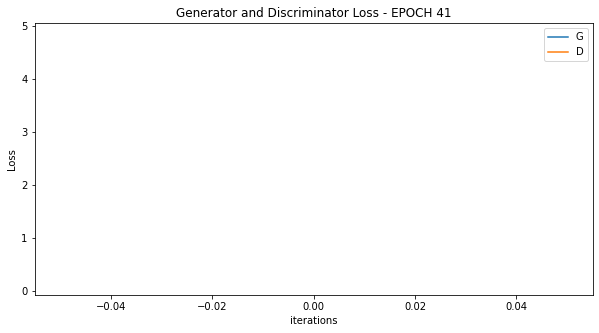

[41/100][321/644] Loss_D: 0.1553; Loss_G: 4.8218
[41/100][322/644] Loss_D: 0.1567; Loss_G: 4.4850
[41/100][323/644] Loss_D: 0.3521; Loss_G: 6.2486
[41/100][324/644] Loss_D: 0.1341; Loss_G: 6.2608
[41/100][325/644] Loss_D: 0.4562; Loss_G: 3.3045
[41/100][326/644] Loss_D: 0.3341; Loss_G: 4.7407
[41/100][327/644] Loss_D: 0.4141; Loss_G: 7.2790
[41/100][328/644] Loss_D: 0.5083; Loss_G: 4.2433
[41/100][329/644] Loss_D: 0.0931; Loss_G: 3.5813
[41/100][330/644] Loss_D: 0.4369; Loss_G: 5.6212
[41/100][331/644] Loss_D: 0.2190; Loss_G: 5.2846
[41/100][332/644] Loss_D: 0.1296; Loss_G: 5.3983
[41/100][333/644] Loss_D: 0.1539; Loss_G: 5.0999
[41/100][334/644] Loss_D: 0.1975; Loss_G: 4.1908
[41/100][335/644] Loss_D: 0.1927; Loss_G: 5.0545
[41/100][336/644] Loss_D: 0.6271; Loss_G: 8.8624
[41/100][337/644] Loss_D: 0.5077; Loss_G: 5.3118
[41/100][338/644] Loss_D: 0.1312; Loss_G: 3.7133
[41/100][339/644] Loss_D: 0.3836; Loss_G: 5.3227
[41/100][340/644] Loss_D: 0.0731; Loss_G: 4.7362
[41/100][341/644] Lo

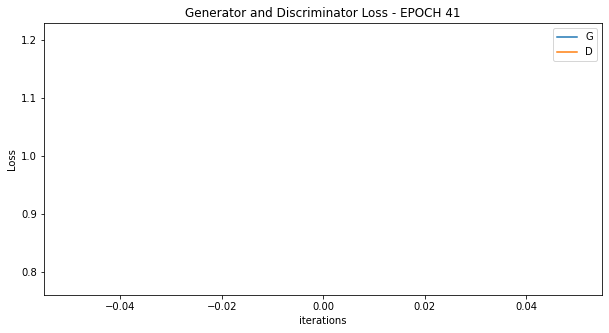

[41/100][643/644] Loss_D: 1.2078; Loss_G: 0.7822
[42/100][0/644] Loss_D: 1.9753; Loss_G: 11.5657
[42/100][1/644] Loss_D: 2.8240; Loss_G: 0.2481
[42/100][2/644] Loss_D: 3.6556; Loss_G: 14.6112
[42/100][3/644] Loss_D: 0.4084; Loss_G: 8.6724
[42/100][4/644] Loss_D: 1.5960; Loss_G: 0.3830
[42/100][5/644] Loss_D: 4.3441; Loss_G: 12.8537
[42/100][6/644] Loss_D: 1.5241; Loss_G: 2.0770
[42/100][7/644] Loss_D: 0.7773; Loss_G: 7.9295
[42/100][8/644] Loss_D: 0.5875; Loss_G: 4.0444
[42/100][9/644] Loss_D: 0.4039; Loss_G: 6.5553
[42/100][10/644] Loss_D: 0.5663; Loss_G: 4.9655
[42/100][11/644] Loss_D: 0.6547; Loss_G: 9.3285
[42/100][12/644] Loss_D: 1.3715; Loss_G: 3.4593
[42/100][13/644] Loss_D: 0.8816; Loss_G: 6.0691
[42/100][14/644] Loss_D: 0.2724; Loss_G: 5.1863
[42/100][15/644] Loss_D: 0.3780; Loss_G: 5.9587
[42/100][16/644] Loss_D: 0.3163; Loss_G: 5.0761
[42/100][17/644] Loss_D: 0.6125; Loss_G: 3.3463
[42/100][18/644] Loss_D: 1.4058; Loss_G: 11.2820
[42/100][19/644] Loss_D: 1.0315; Loss_G: 4.67

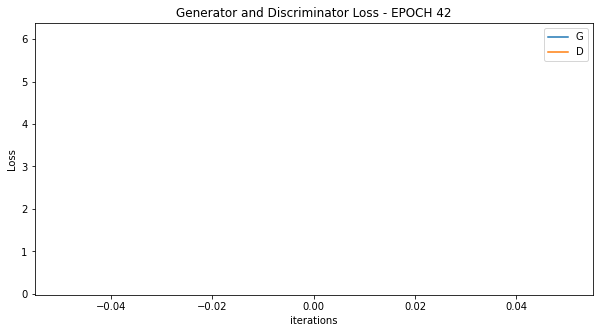

[42/100][321/644] Loss_D: 0.2677; Loss_G: 6.0884
[42/100][322/644] Loss_D: 0.2279; Loss_G: 4.1276
[42/100][323/644] Loss_D: 0.1154; Loss_G: 4.1485
[42/100][324/644] Loss_D: 0.0446; Loss_G: 5.1857
[42/100][325/644] Loss_D: 0.4243; Loss_G: 6.8613
[42/100][326/644] Loss_D: 0.0732; Loss_G: 6.2940
[42/100][327/644] Loss_D: 0.2617; Loss_G: 4.8746
[42/100][328/644] Loss_D: 0.1500; Loss_G: 5.2894
[42/100][329/644] Loss_D: 0.2020; Loss_G: 4.0844
[42/100][330/644] Loss_D: 0.1017; Loss_G: 5.6866
[42/100][331/644] Loss_D: 0.3985; Loss_G: 6.5231
[42/100][332/644] Loss_D: 0.5181; Loss_G: 3.6254
[42/100][333/644] Loss_D: 0.0855; Loss_G: 3.5053
[42/100][334/644] Loss_D: 0.1580; Loss_G: 5.1870
[42/100][335/644] Loss_D: 0.2049; Loss_G: 6.8722
[42/100][336/644] Loss_D: 0.1248; Loss_G: 6.1346
[42/100][337/644] Loss_D: 0.0665; Loss_G: 5.7819
[42/100][338/644] Loss_D: 0.2428; Loss_G: 3.4224
[42/100][339/644] Loss_D: 0.2651; Loss_G: 5.9408
[42/100][340/644] Loss_D: 0.2254; Loss_G: 4.5736
[42/100][341/644] Lo

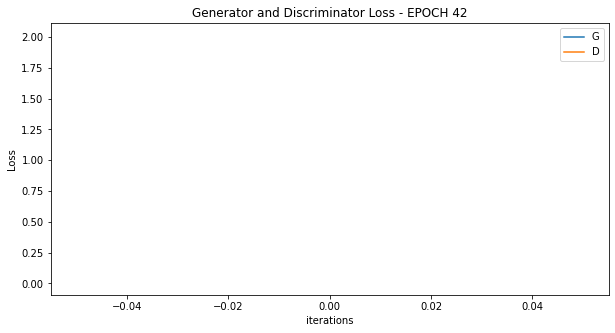

[42/100][643/644] Loss_D: 2.0137; Loss_G: 0.0084
[43/100][0/644] Loss_D: 4.8211; Loss_G: 13.5807
[43/100][1/644] Loss_D: 3.8945; Loss_G: 0.0016
[43/100][2/644] Loss_D: 16.3563; Loss_G: 8.2524
[43/100][3/644] Loss_D: 1.4995; Loss_G: 6.7513
[43/100][4/644] Loss_D: 3.3994; Loss_G: 0.0933
[43/100][5/644] Loss_D: 8.5618; Loss_G: 8.6864
[43/100][6/644] Loss_D: 1.2974; Loss_G: 9.2088
[43/100][7/644] Loss_D: 3.0093; Loss_G: 0.3142
[43/100][8/644] Loss_D: 4.8069; Loss_G: 11.1474
[43/100][9/644] Loss_D: 1.0944; Loss_G: 6.8916
[43/100][10/644] Loss_D: 1.1816; Loss_G: 1.7579
[43/100][11/644] Loss_D: 0.9731; Loss_G: 6.9450
[43/100][12/644] Loss_D: 0.5052; Loss_G: 6.5659
[43/100][13/644] Loss_D: 1.2647; Loss_G: 2.7065
[43/100][14/644] Loss_D: 1.1984; Loss_G: 7.9367
[43/100][15/644] Loss_D: 0.4043; Loss_G: 5.8032
[43/100][16/644] Loss_D: 0.8945; Loss_G: 2.3775
[43/100][17/644] Loss_D: 1.2637; Loss_G: 7.6548
[43/100][18/644] Loss_D: 0.8550; Loss_G: 5.4863
[43/100][19/644] Loss_D: 0.4264; Loss_G: 3.199

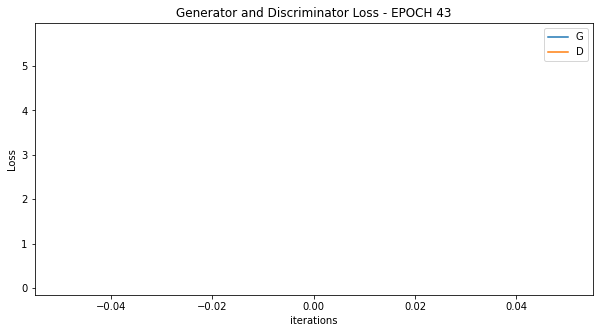

[43/100][321/644] Loss_D: 0.1286; Loss_G: 5.6885
[43/100][322/644] Loss_D: 0.1291; Loss_G: 4.3985
[43/100][323/644] Loss_D: 0.2245; Loss_G: 4.2439
[43/100][324/644] Loss_D: 0.0685; Loss_G: 5.2046
[43/100][325/644] Loss_D: 0.0296; Loss_G: 5.1770
[43/100][326/644] Loss_D: 0.2585; Loss_G: 7.1296
[43/100][327/644] Loss_D: 0.0787; Loss_G: 5.9081
[43/100][328/644] Loss_D: 0.2699; Loss_G: 4.9196
[43/100][329/644] Loss_D: 0.0724; Loss_G: 4.2068
[43/100][330/644] Loss_D: 0.1073; Loss_G: 4.3947
[43/100][331/644] Loss_D: 0.2605; Loss_G: 3.2511
[43/100][332/644] Loss_D: 0.3958; Loss_G: 7.0381
[43/100][333/644] Loss_D: 0.4519; Loss_G: 4.0186
[43/100][334/644] Loss_D: 0.2565; Loss_G: 4.8749
[43/100][335/644] Loss_D: 0.1855; Loss_G: 5.5097
[43/100][336/644] Loss_D: 0.0562; Loss_G: 5.4484
[43/100][337/644] Loss_D: 0.0703; Loss_G: 5.8078
[43/100][338/644] Loss_D: 0.4197; Loss_G: 3.6150
[43/100][339/644] Loss_D: 0.5307; Loss_G: 7.8089
[43/100][340/644] Loss_D: 0.0366; Loss_G: 7.8258
[43/100][341/644] Lo

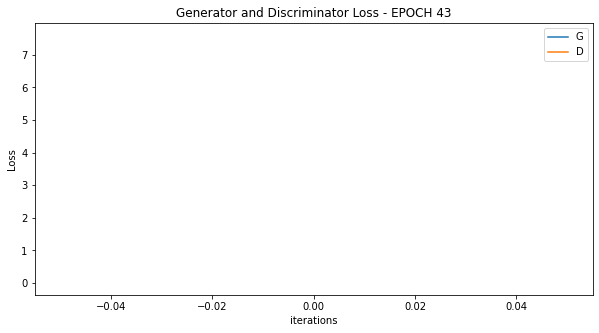

[43/100][643/644] Loss_D: 0.0177; Loss_G: 7.5931
[44/100][0/644] Loss_D: 0.0536; Loss_G: 6.0086
[44/100][1/644] Loss_D: 0.0705; Loss_G: 6.3465
[44/100][2/644] Loss_D: 0.1398; Loss_G: 5.5231
[44/100][3/644] Loss_D: 0.1426; Loss_G: 4.7993
[44/100][4/644] Loss_D: 0.0482; Loss_G: 5.6495
[44/100][5/644] Loss_D: 0.1304; Loss_G: 5.9081
[44/100][6/644] Loss_D: 0.1260; Loss_G: 4.9593
[44/100][7/644] Loss_D: 0.0456; Loss_G: 5.2563
[44/100][8/644] Loss_D: 0.0369; Loss_G: 7.7742
[44/100][9/644] Loss_D: 0.0497; Loss_G: 5.6393
[44/100][10/644] Loss_D: 0.3854; Loss_G: 2.3018
[44/100][11/644] Loss_D: 0.2029; Loss_G: 4.8124
[44/100][12/644] Loss_D: 0.3897; Loss_G: 8.4053
[44/100][13/644] Loss_D: 0.1931; Loss_G: 6.7749
[44/100][14/644] Loss_D: 0.2252; Loss_G: 5.0364
[44/100][15/644] Loss_D: 0.4578; Loss_G: 7.9539
[44/100][16/644] Loss_D: 0.4460; Loss_G: 4.5210
[44/100][17/644] Loss_D: 0.1011; Loss_G: 4.1512
[44/100][18/644] Loss_D: 0.1907; Loss_G: 4.3040
[44/100][19/644] Loss_D: 0.0528; Loss_G: 5.3605
[

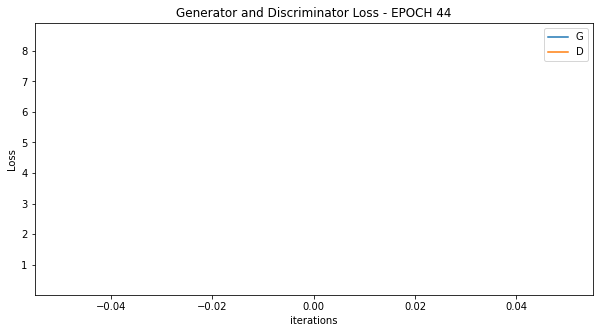

[44/100][321/644] Loss_D: 0.4164; Loss_G: 8.5070
[44/100][322/644] Loss_D: 0.1168; Loss_G: 7.4477
[44/100][323/644] Loss_D: 0.1739; Loss_G: 5.2978
[44/100][324/644] Loss_D: 0.0652; Loss_G: 4.4918
[44/100][325/644] Loss_D: 0.2526; Loss_G: 4.2290
[44/100][326/644] Loss_D: 0.1051; Loss_G: 5.5981
[44/100][327/644] Loss_D: 0.1362; Loss_G: 4.6894
[44/100][328/644] Loss_D: 0.2379; Loss_G: 3.5610
[44/100][329/644] Loss_D: 0.0408; Loss_G: 4.4486
[44/100][330/644] Loss_D: 0.3339; Loss_G: 8.2958
[44/100][331/644] Loss_D: 0.2920; Loss_G: 4.8814
[44/100][332/644] Loss_D: 0.1587; Loss_G: 5.9197
[44/100][333/644] Loss_D: 0.1364; Loss_G: 5.1002
[44/100][334/644] Loss_D: 0.1177; Loss_G: 4.1727
[44/100][335/644] Loss_D: 0.0237; Loss_G: 5.1279
[44/100][336/644] Loss_D: 0.4833; Loss_G: 8.3891
[44/100][337/644] Loss_D: 1.0585; Loss_G: 2.0738
[44/100][338/644] Loss_D: 0.6195; Loss_G: 7.2996
[44/100][339/644] Loss_D: 0.3389; Loss_G: 10.0048
[44/100][340/644] Loss_D: 0.6119; Loss_G: 3.2217
[44/100][341/644] L

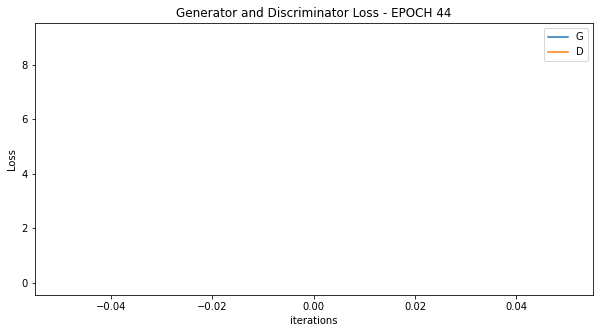

[44/100][643/644] Loss_D: 0.0054; Loss_G: 9.0770
[45/100][0/644] Loss_D: 0.3841; Loss_G: 5.4393
[45/100][1/644] Loss_D: 0.0616; Loss_G: 4.5081
[45/100][2/644] Loss_D: 0.1779; Loss_G: 6.4601
[45/100][3/644] Loss_D: 0.1380; Loss_G: 5.3057
[45/100][4/644] Loss_D: 0.1189; Loss_G: 5.1390
[45/100][5/644] Loss_D: 0.0693; Loss_G: 5.0389
[45/100][6/644] Loss_D: 0.2823; Loss_G: 6.5319
[45/100][7/644] Loss_D: 0.0498; Loss_G: 6.8499
[45/100][8/644] Loss_D: 0.0748; Loss_G: 6.2932
[45/100][9/644] Loss_D: 0.1524; Loss_G: 5.4684
[45/100][10/644] Loss_D: 0.0820; Loss_G: 5.7069
[45/100][11/644] Loss_D: 0.0866; Loss_G: 6.1286
[45/100][12/644] Loss_D: 0.1999; Loss_G: 5.1086
[45/100][13/644] Loss_D: 0.4376; Loss_G: 8.3585
[45/100][14/644] Loss_D: 0.1230; Loss_G: 7.0522
[45/100][15/644] Loss_D: 0.0804; Loss_G: 6.6835
[45/100][16/644] Loss_D: 0.0901; Loss_G: 6.4399
[45/100][17/644] Loss_D: 0.1031; Loss_G: 4.9572
[45/100][18/644] Loss_D: 0.1423; Loss_G: 4.7355
[45/100][19/644] Loss_D: 0.1121; Loss_G: 5.1292
[

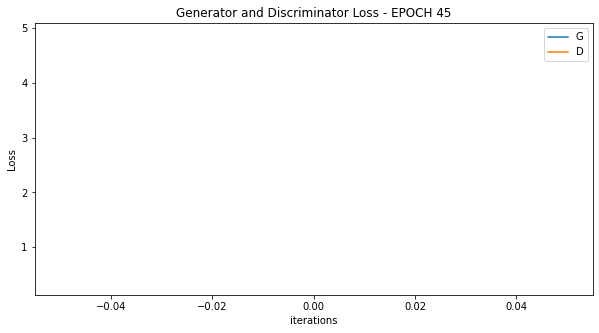

[45/100][321/644] Loss_D: 0.3583; Loss_G: 4.8664
[45/100][322/644] Loss_D: 0.6718; Loss_G: 8.3539
[45/100][323/644] Loss_D: 0.0894; Loss_G: 7.7246
[45/100][324/644] Loss_D: 0.7627; Loss_G: 3.5373
[45/100][325/644] Loss_D: 0.1279; Loss_G: 2.4775
[45/100][326/644] Loss_D: 1.0710; Loss_G: 11.6572
[45/100][327/644] Loss_D: 0.3710; Loss_G: 7.9447
[45/100][328/644] Loss_D: 0.4500; Loss_G: 2.4043
[45/100][329/644] Loss_D: 0.4109; Loss_G: 6.1028
[45/100][330/644] Loss_D: 0.2829; Loss_G: 6.7012
[45/100][331/644] Loss_D: 0.6262; Loss_G: 2.8774
[45/100][332/644] Loss_D: 1.3112; Loss_G: 9.6630
[45/100][333/644] Loss_D: 1.4516; Loss_G: 2.9966
[45/100][334/644] Loss_D: 0.2837; Loss_G: 4.5656
[45/100][335/644] Loss_D: 0.4678; Loss_G: 7.6093
[45/100][336/644] Loss_D: 0.1553; Loss_G: 6.6010
[45/100][337/644] Loss_D: 0.2124; Loss_G: 5.4898
[45/100][338/644] Loss_D: 0.2781; Loss_G: 3.9512
[45/100][339/644] Loss_D: 0.1873; Loss_G: 4.7181
[45/100][340/644] Loss_D: 0.3871; Loss_G: 6.3732
[45/100][341/644] L

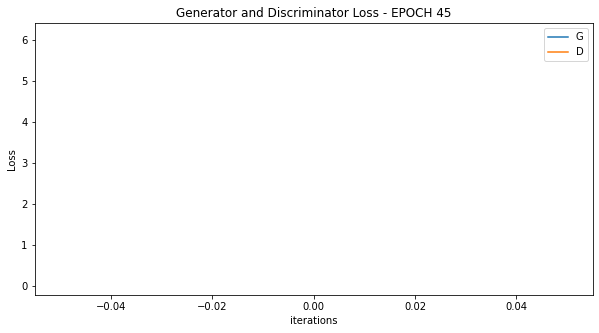

[45/100][643/644] Loss_D: 0.0818; Loss_G: 6.1197
[46/100][0/644] Loss_D: 0.2603; Loss_G: 6.2512
[46/100][1/644] Loss_D: 0.0509; Loss_G: 5.8155
[46/100][2/644] Loss_D: 0.2382; Loss_G: 4.6794
[46/100][3/644] Loss_D: 0.0522; Loss_G: 3.9972
[46/100][4/644] Loss_D: 0.1151; Loss_G: 5.1638
[46/100][5/644] Loss_D: 0.0643; Loss_G: 5.0137
[46/100][6/644] Loss_D: 0.0810; Loss_G: 5.8021
[46/100][7/644] Loss_D: 0.1086; Loss_G: 6.5473
[46/100][8/644] Loss_D: 0.9353; Loss_G: 0.6143
[46/100][9/644] Loss_D: 1.6308; Loss_G: 12.4204
[46/100][10/644] Loss_D: 0.7196; Loss_G: 4.0865
[46/100][11/644] Loss_D: 0.1955; Loss_G: 5.1421
[46/100][12/644] Loss_D: 0.1670; Loss_G: 7.5666
[46/100][13/644] Loss_D: 0.1974; Loss_G: 5.3255
[46/100][14/644] Loss_D: 0.1552; Loss_G: 4.6321
[46/100][15/644] Loss_D: 0.1399; Loss_G: 4.3289
[46/100][16/644] Loss_D: 0.0643; Loss_G: 5.4909
[46/100][17/644] Loss_D: 0.1295; Loss_G: 5.9030
[46/100][18/644] Loss_D: 0.1642; Loss_G: 5.8740
[46/100][19/644] Loss_D: 0.0777; Loss_G: 5.0009


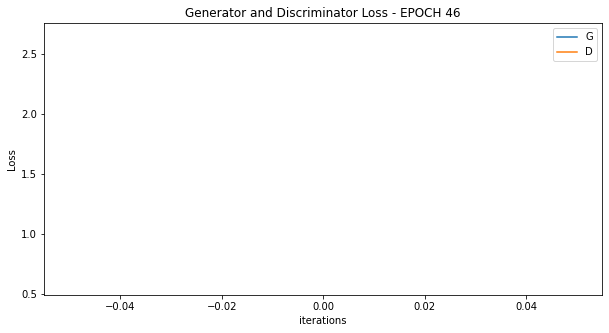

[46/100][321/644] Loss_D: 0.5973; Loss_G: 2.6525
[46/100][322/644] Loss_D: 0.9034; Loss_G: 10.2009
[46/100][323/644] Loss_D: 0.2105; Loss_G: 5.9891
[46/100][324/644] Loss_D: 0.2840; Loss_G: 3.3065
[46/100][325/644] Loss_D: 0.0885; Loss_G: 4.3701
[46/100][326/644] Loss_D: 0.6470; Loss_G: 6.6793
[46/100][327/644] Loss_D: 0.3691; Loss_G: 4.7806
[46/100][328/644] Loss_D: 0.1996; Loss_G: 4.8301
[46/100][329/644] Loss_D: 0.0755; Loss_G: 6.2890
[46/100][330/644] Loss_D: 0.2339; Loss_G: 6.6723
[46/100][331/644] Loss_D: 0.1023; Loss_G: 5.3334
[46/100][332/644] Loss_D: 0.0246; Loss_G: 5.3910
[46/100][333/644] Loss_D: 0.2038; Loss_G: 4.6176
[46/100][334/644] Loss_D: 0.0602; Loss_G: 5.4274
[46/100][335/644] Loss_D: 0.3043; Loss_G: 7.8186
[46/100][336/644] Loss_D: 0.0944; Loss_G: 6.9044
[46/100][337/644] Loss_D: 0.1477; Loss_G: 5.9275
[46/100][338/644] Loss_D: 0.0366; Loss_G: 5.9167
[46/100][339/644] Loss_D: 0.0594; Loss_G: 5.1713
[46/100][340/644] Loss_D: 0.1657; Loss_G: 5.0030
[46/100][341/644] L

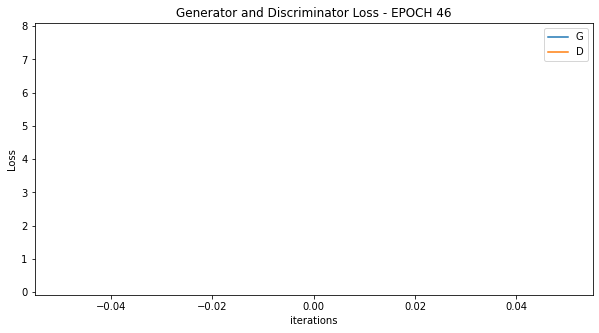

[46/100][643/644] Loss_D: 0.2884; Loss_G: 7.7239
[47/100][0/644] Loss_D: 0.5150; Loss_G: 8.5402
[47/100][1/644] Loss_D: 0.1125; Loss_G: 7.3930
[47/100][2/644] Loss_D: 0.6597; Loss_G: 3.0048
[47/100][3/644] Loss_D: 0.6568; Loss_G: 8.1622
[47/100][4/644] Loss_D: 0.5569; Loss_G: 3.4480
[47/100][5/644] Loss_D: 0.1464; Loss_G: 3.3719
[47/100][6/644] Loss_D: 0.2908; Loss_G: 6.6927
[47/100][7/644] Loss_D: 0.0977; Loss_G: 7.8889
[47/100][8/644] Loss_D: 0.0969; Loss_G: 6.8326
[47/100][9/644] Loss_D: 0.0602; Loss_G: 8.0897
[47/100][10/644] Loss_D: 0.2544; Loss_G: 2.6511
[47/100][11/644] Loss_D: 0.2136; Loss_G: 3.8686
[47/100][12/644] Loss_D: 0.1950; Loss_G: 5.4678
[47/100][13/644] Loss_D: 0.3102; Loss_G: 8.6102
[47/100][14/644] Loss_D: 0.4598; Loss_G: 5.0054
[47/100][15/644] Loss_D: 0.1315; Loss_G: 5.5704
[47/100][16/644] Loss_D: 0.2888; Loss_G: 5.0173
[47/100][17/644] Loss_D: 0.1560; Loss_G: 4.5747
[47/100][18/644] Loss_D: 0.0507; Loss_G: 5.6227
[47/100][19/644] Loss_D: 0.1620; Loss_G: 6.3207
[

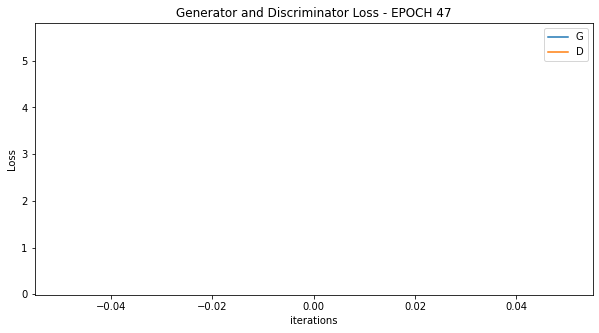

[47/100][321/644] Loss_D: 0.2535; Loss_G: 5.5446
[47/100][322/644] Loss_D: 0.2411; Loss_G: 4.8853
[47/100][323/644] Loss_D: 0.1001; Loss_G: 5.4364
[47/100][324/644] Loss_D: 0.5354; Loss_G: 2.2206
[47/100][325/644] Loss_D: 0.1987; Loss_G: 5.6328
[47/100][326/644] Loss_D: 0.0901; Loss_G: 6.3276
[47/100][327/644] Loss_D: 0.0589; Loss_G: 5.8976
[47/100][328/644] Loss_D: 0.3376; Loss_G: 3.3511
[47/100][329/644] Loss_D: 0.3408; Loss_G: 5.4652
[47/100][330/644] Loss_D: 0.1178; Loss_G: 6.2012
[47/100][331/644] Loss_D: 0.0851; Loss_G: 6.1536
[47/100][332/644] Loss_D: 0.0653; Loss_G: 5.9288
[47/100][333/644] Loss_D: 0.0651; Loss_G: 5.3496
[47/100][334/644] Loss_D: 0.1174; Loss_G: 5.4429
[47/100][335/644] Loss_D: 0.1040; Loss_G: 5.6744
[47/100][336/644] Loss_D: 0.1819; Loss_G: 5.3250
[47/100][337/644] Loss_D: 0.1300; Loss_G: 4.7212
[47/100][338/644] Loss_D: 0.3289; Loss_G: 5.8008
[47/100][339/644] Loss_D: 0.1338; Loss_G: 5.4073
[47/100][340/644] Loss_D: 0.2566; Loss_G: 3.5622
[47/100][341/644] Lo

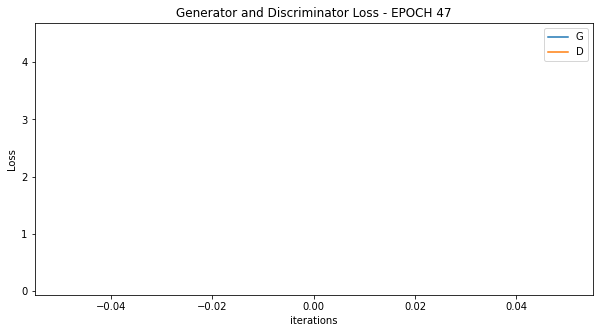

[47/100][643/644] Loss_D: 0.1507; Loss_G: 4.4692
[48/100][0/644] Loss_D: 0.4239; Loss_G: 6.1137
[48/100][1/644] Loss_D: 0.1910; Loss_G: 4.8880
[48/100][2/644] Loss_D: 0.4143; Loss_G: 4.8999
[48/100][3/644] Loss_D: 0.3287; Loss_G: 5.7402
[48/100][4/644] Loss_D: 0.9542; Loss_G: 2.0560
[48/100][5/644] Loss_D: 0.4058; Loss_G: 7.0428
[48/100][6/644] Loss_D: 0.1213; Loss_G: 6.9313
[48/100][7/644] Loss_D: 0.9489; Loss_G: 1.8991
[48/100][8/644] Loss_D: 0.8588; Loss_G: 7.8835
[48/100][9/644] Loss_D: 0.2769; Loss_G: 6.6239
[48/100][10/644] Loss_D: 0.2525; Loss_G: 6.2393
[48/100][11/644] Loss_D: 0.5012; Loss_G: 2.9777
[48/100][12/644] Loss_D: 0.2704; Loss_G: 5.6481
[48/100][13/644] Loss_D: 0.2187; Loss_G: 5.8839
[48/100][14/644] Loss_D: 0.0498; Loss_G: 5.9302
[48/100][15/644] Loss_D: 0.1205; Loss_G: 5.6364
[48/100][16/644] Loss_D: 0.3138; Loss_G: 6.3158
[48/100][17/644] Loss_D: 0.4221; Loss_G: 3.7157
[48/100][18/644] Loss_D: 0.1795; Loss_G: 3.2885
[48/100][19/644] Loss_D: 1.2794; Loss_G: 10.5697


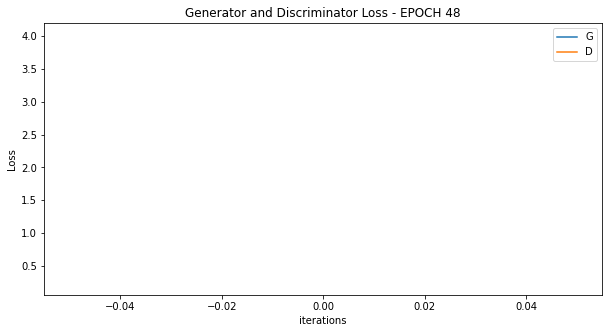

[48/100][321/644] Loss_D: 0.2504; Loss_G: 4.0087
[48/100][322/644] Loss_D: 0.0644; Loss_G: 5.2203
[48/100][323/644] Loss_D: 0.1193; Loss_G: 5.8438
[48/100][324/644] Loss_D: 0.3748; Loss_G: 3.9848
[48/100][325/644] Loss_D: 0.1774; Loss_G: 5.3734
[48/100][326/644] Loss_D: 0.0594; Loss_G: 5.9719
[48/100][327/644] Loss_D: 0.3868; Loss_G: 4.1232
[48/100][328/644] Loss_D: 0.1946; Loss_G: 3.4096
[48/100][329/644] Loss_D: 0.2372; Loss_G: 5.5467
[48/100][330/644] Loss_D: 0.1648; Loss_G: 6.7036
[48/100][331/644] Loss_D: 0.1480; Loss_G: 5.6166
[48/100][332/644] Loss_D: 0.1140; Loss_G: 5.6803
[48/100][333/644] Loss_D: 0.3218; Loss_G: 4.4102
[48/100][334/644] Loss_D: 0.1695; Loss_G: 4.8055
[48/100][335/644] Loss_D: 0.2542; Loss_G: 4.0852
[48/100][336/644] Loss_D: 0.0515; Loss_G: 5.0294
[48/100][337/644] Loss_D: 0.2087; Loss_G: 7.2749
[48/100][338/644] Loss_D: 0.2499; Loss_G: 4.5847
[48/100][339/644] Loss_D: 0.1038; Loss_G: 3.8089
[48/100][340/644] Loss_D: 0.1871; Loss_G: 6.0990
[48/100][341/644] Lo

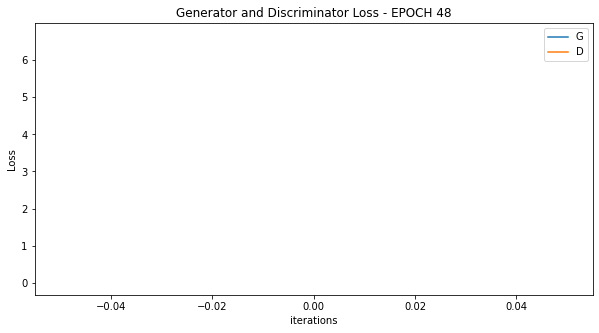

[48/100][643/644] Loss_D: 0.0095; Loss_G: 6.6668
[49/100][0/644] Loss_D: 0.0912; Loss_G: 5.4985
[49/100][1/644] Loss_D: 0.4086; Loss_G: 2.3394
[49/100][2/644] Loss_D: 1.9643; Loss_G: 15.7427
[49/100][3/644] Loss_D: 3.3972; Loss_G: 3.6414
[49/100][4/644] Loss_D: 0.8970; Loss_G: 8.3642
[49/100][5/644] Loss_D: 0.4130; Loss_G: 4.6747
[49/100][6/644] Loss_D: 0.4102; Loss_G: 7.0016
[49/100][7/644] Loss_D: 0.4948; Loss_G: 3.0309
[49/100][8/644] Loss_D: 0.5663; Loss_G: 7.7081
[49/100][9/644] Loss_D: 0.0820; Loss_G: 7.4642
[49/100][10/644] Loss_D: 0.0500; Loss_G: 6.8961
[49/100][11/644] Loss_D: 0.4955; Loss_G: 3.2892
[49/100][12/644] Loss_D: 0.3158; Loss_G: 6.1565
[49/100][13/644] Loss_D: 0.6363; Loss_G: 2.0956
[49/100][14/644] Loss_D: 1.7818; Loss_G: 14.6722
[49/100][15/644] Loss_D: 0.6141; Loss_G: 8.0405
[49/100][16/644] Loss_D: 0.1046; Loss_G: 5.2396
[49/100][17/644] Loss_D: 0.2016; Loss_G: 4.5257
[49/100][18/644] Loss_D: 0.1924; Loss_G: 4.8513
[49/100][19/644] Loss_D: 0.0784; Loss_G: 5.1205

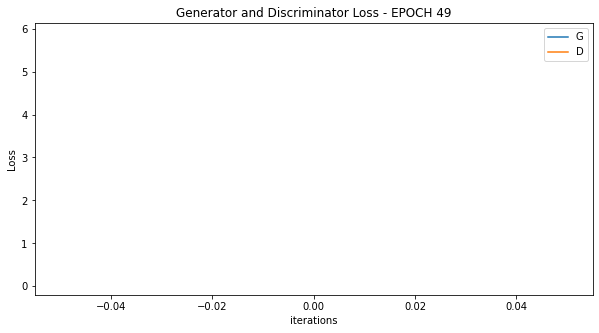

[49/100][321/644] Loss_D: 0.0880; Loss_G: 5.8462
[49/100][322/644] Loss_D: 0.0319; Loss_G: 5.4802
[49/100][323/644] Loss_D: 0.0501; Loss_G: 5.7183
[49/100][324/644] Loss_D: 0.0860; Loss_G: 4.5485
[49/100][325/644] Loss_D: 0.1263; Loss_G: 5.1763
[49/100][326/644] Loss_D: 0.1584; Loss_G: 5.4787
[49/100][327/644] Loss_D: 0.0946; Loss_G: 5.2252
[49/100][328/644] Loss_D: 0.1761; Loss_G: 4.6423
[49/100][329/644] Loss_D: 0.1024; Loss_G: 5.0516
[49/100][330/644] Loss_D: 0.0398; Loss_G: 5.6751
[49/100][331/644] Loss_D: 0.0873; Loss_G: 5.9595
[49/100][332/644] Loss_D: 0.0812; Loss_G: 5.7909
[49/100][333/644] Loss_D: 0.1878; Loss_G: 4.1074
[49/100][334/644] Loss_D: 0.0605; Loss_G: 3.9621
[49/100][335/644] Loss_D: 0.1406; Loss_G: 6.1977
[49/100][336/644] Loss_D: 0.1152; Loss_G: 5.7485
[49/100][337/644] Loss_D: 0.2157; Loss_G: 6.3716
[49/100][338/644] Loss_D: 0.0936; Loss_G: 6.3646
[49/100][339/644] Loss_D: 0.4585; Loss_G: 2.0255
[49/100][340/644] Loss_D: 0.3747; Loss_G: 6.4007
[49/100][341/644] Lo

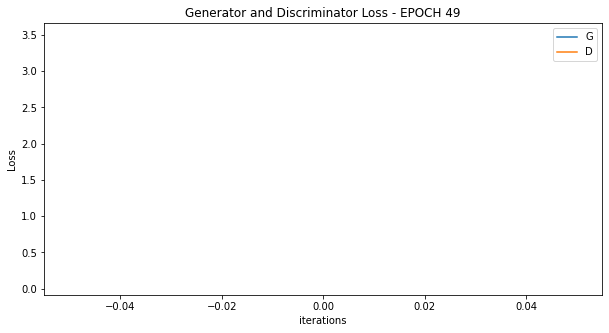

[49/100][643/644] Loss_D: 0.0857; Loss_G: 3.4935
[50/100][0/644] Loss_D: 0.5732; Loss_G: 9.3473
[50/100][1/644] Loss_D: 0.3662; Loss_G: 4.5018
[50/100][2/644] Loss_D: 1.0701; Loss_G: 3.7960
[50/100][3/644] Loss_D: 0.4568; Loss_G: 8.3294
[50/100][4/644] Loss_D: 0.2575; Loss_G: 4.9438
[50/100][5/644] Loss_D: 0.2311; Loss_G: 5.3995
[50/100][6/644] Loss_D: 0.9343; Loss_G: 1.2158
[50/100][7/644] Loss_D: 0.7453; Loss_G: 9.1366
[50/100][8/644] Loss_D: 0.1646; Loss_G: 6.6059
[50/100][9/644] Loss_D: 0.0914; Loss_G: 7.5563
[50/100][10/644] Loss_D: 0.2837; Loss_G: 4.3275
[50/100][11/644] Loss_D: 0.1932; Loss_G: 5.0772
[50/100][12/644] Loss_D: 0.6371; Loss_G: 6.3833
[50/100][13/644] Loss_D: 0.4782; Loss_G: 6.1127
[50/100][14/644] Loss_D: 0.0999; Loss_G: 6.8152
[50/100][15/644] Loss_D: 0.2327; Loss_G: 5.1872
[50/100][16/644] Loss_D: 0.4628; Loss_G: 6.8985
[50/100][17/644] Loss_D: 0.1132; Loss_G: 6.5543
[50/100][18/644] Loss_D: 0.7183; Loss_G: 2.4047
[50/100][19/644] Loss_D: 0.2144; Loss_G: 5.2157
[

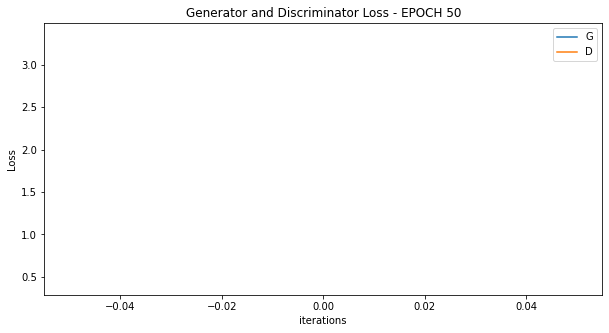

[50/100][321/644] Loss_D: 0.4351; Loss_G: 3.3437
[50/100][322/644] Loss_D: 0.3505; Loss_G: 6.2345
[50/100][323/644] Loss_D: 0.2655; Loss_G: 5.1562
[50/100][324/644] Loss_D: 0.0868; Loss_G: 4.9940
[50/100][325/644] Loss_D: 0.0693; Loss_G: 4.9251
[50/100][326/644] Loss_D: 0.1919; Loss_G: 6.0596
[50/100][327/644] Loss_D: 0.3703; Loss_G: 4.5622
[50/100][328/644] Loss_D: 0.1444; Loss_G: 4.8306
[50/100][329/644] Loss_D: 0.0448; Loss_G: 5.1942
[50/100][330/644] Loss_D: 0.3200; Loss_G: 7.0849
[50/100][331/644] Loss_D: 0.1309; Loss_G: 6.6268
[50/100][332/644] Loss_D: 0.2593; Loss_G: 3.7724
[50/100][333/644] Loss_D: 0.2169; Loss_G: 4.6364
[50/100][334/644] Loss_D: 0.2589; Loss_G: 5.3601
[50/100][335/644] Loss_D: 0.2542; Loss_G: 4.3252
[50/100][336/644] Loss_D: 0.1579; Loss_G: 3.8849
[50/100][337/644] Loss_D: 0.5483; Loss_G: 7.7122
[50/100][338/644] Loss_D: 0.1267; Loss_G: 6.8811
[50/100][339/644] Loss_D: 0.2792; Loss_G: 4.7019
[50/100][340/644] Loss_D: 0.2042; Loss_G: 4.2461
[50/100][341/644] Lo

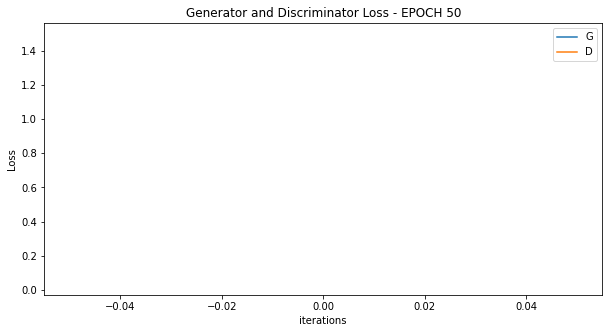

[50/100][643/644] Loss_D: 1.4900; Loss_G: 0.0438
[51/100][0/644] Loss_D: 7.3192; Loss_G: 15.7253
[51/100][1/644] Loss_D: 4.2131; Loss_G: 0.5867
[51/100][2/644] Loss_D: 4.1457; Loss_G: 14.0119
[51/100][3/644] Loss_D: 4.0356; Loss_G: 1.2487
[51/100][4/644] Loss_D: 2.9462; Loss_G: 11.2429
[51/100][5/644] Loss_D: 0.6862; Loss_G: 7.1152
[51/100][6/644] Loss_D: 1.2082; Loss_G: 0.7700
[51/100][7/644] Loss_D: 1.0828; Loss_G: 8.0340
[51/100][8/644] Loss_D: 0.5893; Loss_G: 9.2038
[51/100][9/644] Loss_D: 1.7338; Loss_G: 1.3378
[51/100][10/644] Loss_D: 1.0841; Loss_G: 8.7542
[51/100][11/644] Loss_D: 0.1373; Loss_G: 7.8342
[51/100][12/644] Loss_D: 0.2069; Loss_G: 5.8742
[51/100][13/644] Loss_D: 0.5919; Loss_G: 2.4656
[51/100][14/644] Loss_D: 0.6404; Loss_G: 7.2440
[51/100][15/644] Loss_D: 0.1963; Loss_G: 5.8673
[51/100][16/644] Loss_D: 0.1598; Loss_G: 6.1260
[51/100][17/644] Loss_D: 0.3198; Loss_G: 6.0650
[51/100][18/644] Loss_D: 0.2377; Loss_G: 4.9974
[51/100][19/644] Loss_D: 0.3662; Loss_G: 5.364

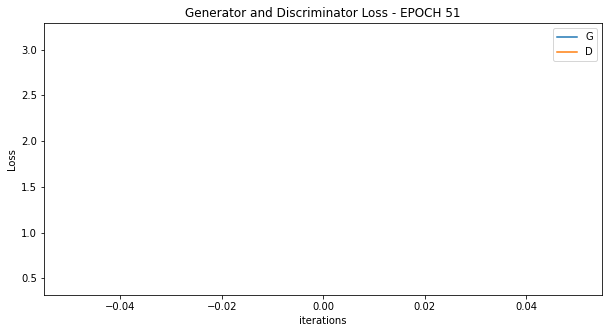

[51/100][321/644] Loss_D: 0.4542; Loss_G: 3.1550
[51/100][322/644] Loss_D: 0.2930; Loss_G: 6.3373
[51/100][323/644] Loss_D: 0.0823; Loss_G: 6.1540
[51/100][324/644] Loss_D: 0.1465; Loss_G: 5.6070
[51/100][325/644] Loss_D: 0.0968; Loss_G: 5.0520
[51/100][326/644] Loss_D: 0.1496; Loss_G: 5.8100
[51/100][327/644] Loss_D: 0.0520; Loss_G: 5.9896
[51/100][328/644] Loss_D: 0.0770; Loss_G: 5.1695
[51/100][329/644] Loss_D: 0.2916; Loss_G: 4.5968
[51/100][330/644] Loss_D: 0.1466; Loss_G: 6.0169
[51/100][331/644] Loss_D: 0.1141; Loss_G: 6.2542
[51/100][332/644] Loss_D: 0.2343; Loss_G: 4.9024
[51/100][333/644] Loss_D: 0.1179; Loss_G: 4.8474
[51/100][334/644] Loss_D: 0.1520; Loss_G: 6.1608
[51/100][335/644] Loss_D: 0.1284; Loss_G: 5.0371
[51/100][336/644] Loss_D: 0.3218; Loss_G: 3.3979
[51/100][337/644] Loss_D: 0.3558; Loss_G: 6.0767
[51/100][338/644] Loss_D: 0.1059; Loss_G: 5.4736
[51/100][339/644] Loss_D: 0.2078; Loss_G: 5.6146
[51/100][340/644] Loss_D: 0.0828; Loss_G: 5.7825
[51/100][341/644] Lo

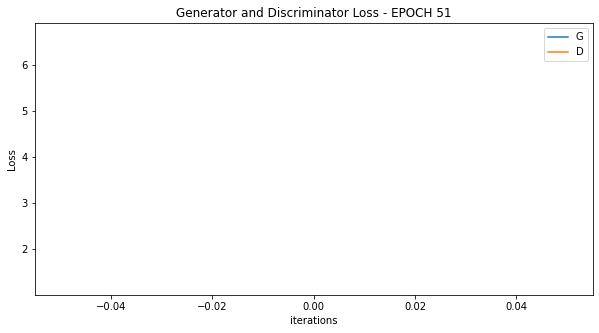

[51/100][643/644] Loss_D: 1.2799; Loss_G: 6.6476
[52/100][0/644] Loss_D: 2.9812; Loss_G: 12.9094
[52/100][1/644] Loss_D: 1.4244; Loss_G: 0.5736
[52/100][2/644] Loss_D: 2.2613; Loss_G: 12.4972
[52/100][3/644] Loss_D: 1.8994; Loss_G: 3.5250
[52/100][4/644] Loss_D: 0.8725; Loss_G: 5.1357
[52/100][5/644] Loss_D: 0.6118; Loss_G: 3.5413
[52/100][6/644] Loss_D: 0.2402; Loss_G: 5.4208
[52/100][7/644] Loss_D: 0.8229; Loss_G: 10.5912
[52/100][8/644] Loss_D: 0.7925; Loss_G: 7.8628
[52/100][9/644] Loss_D: 0.7267; Loss_G: 0.5991
[52/100][10/644] Loss_D: 3.3573; Loss_G: 12.4762
[52/100][11/644] Loss_D: 2.1308; Loss_G: 1.3146
[52/100][12/644] Loss_D: 0.8638; Loss_G: 7.4486
[52/100][13/644] Loss_D: 0.4880; Loss_G: 6.1638
[52/100][14/644] Loss_D: 1.0499; Loss_G: 1.9161
[52/100][15/644] Loss_D: 2.0519; Loss_G: 12.0258
[52/100][16/644] Loss_D: 0.3057; Loss_G: 10.0268
[52/100][17/644] Loss_D: 1.3525; Loss_G: 3.0968
[52/100][18/644] Loss_D: 0.3544; Loss_G: 4.2054
[52/100][19/644] Loss_D: 0.2080; Loss_G: 6.

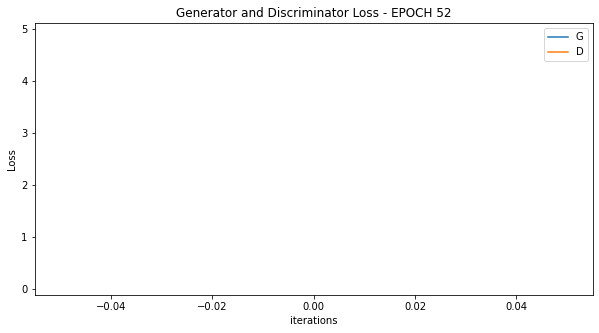

[52/100][321/644] Loss_D: 0.1285; Loss_G: 4.8756
[52/100][322/644] Loss_D: 0.0601; Loss_G: 5.3942
[52/100][323/644] Loss_D: 0.1053; Loss_G: 5.3676
[52/100][324/644] Loss_D: 0.0898; Loss_G: 4.7599
[52/100][325/644] Loss_D: 0.1979; Loss_G: 5.8547
[52/100][326/644] Loss_D: 0.0599; Loss_G: 5.6952
[52/100][327/644] Loss_D: 0.0279; Loss_G: 5.8868
[52/100][328/644] Loss_D: 0.1291; Loss_G: 7.2123
[52/100][329/644] Loss_D: 0.0357; Loss_G: 5.1062
[52/100][330/644] Loss_D: 0.0838; Loss_G: 5.0723
[52/100][331/644] Loss_D: 0.1251; Loss_G: 4.8586
[52/100][332/644] Loss_D: 0.1394; Loss_G: 5.7593
[52/100][333/644] Loss_D: 0.1704; Loss_G: 5.1858
[52/100][334/644] Loss_D: 0.1845; Loss_G: 3.9416
[52/100][335/644] Loss_D: 0.2173; Loss_G: 5.3569
[52/100][336/644] Loss_D: 0.0234; Loss_G: 6.0910
[52/100][337/644] Loss_D: 0.0581; Loss_G: 5.9873
[52/100][338/644] Loss_D: 0.0940; Loss_G: 5.4527
[52/100][339/644] Loss_D: 0.0736; Loss_G: 5.0017
[52/100][340/644] Loss_D: 0.0261; Loss_G: 6.5581
[52/100][341/644] Lo

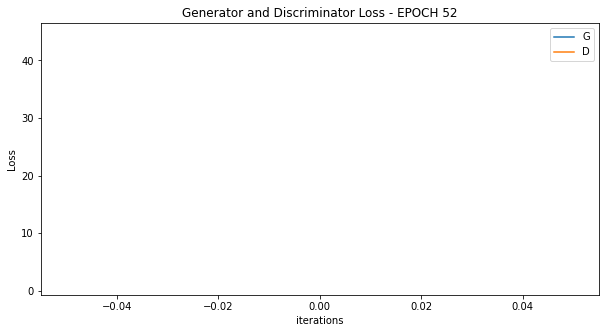

[52/100][643/644] Loss_D: 1.4609; Loss_G: 44.3623
[53/100][0/644] Loss_D: 0.5969; Loss_G: 2.8319
[53/100][1/644] Loss_D: 0.7745; Loss_G: 5.1847
[53/100][2/644] Loss_D: 0.5526; Loss_G: 9.0126
[53/100][3/644] Loss_D: 0.8982; Loss_G: 4.6726
[53/100][4/644] Loss_D: 0.7751; Loss_G: 2.5689
[53/100][5/644] Loss_D: 1.5528; Loss_G: 9.8756
[53/100][6/644] Loss_D: 0.7044; Loss_G: 5.7392
[53/100][7/644] Loss_D: 0.4767; Loss_G: 3.5879
[53/100][8/644] Loss_D: 0.4796; Loss_G: 5.6232
[53/100][9/644] Loss_D: 0.9679; Loss_G: 1.5076
[53/100][10/644] Loss_D: 1.6463; Loss_G: 11.0338
[53/100][11/644] Loss_D: 0.2730; Loss_G: 8.2830
[53/100][12/644] Loss_D: 0.3149; Loss_G: 5.7827
[53/100][13/644] Loss_D: 0.8865; Loss_G: 1.9589
[53/100][14/644] Loss_D: 1.0556; Loss_G: 7.0548
[53/100][15/644] Loss_D: 0.0946; Loss_G: 6.3348
[53/100][16/644] Loss_D: 0.6965; Loss_G: 7.5855
[53/100][17/644] Loss_D: 0.1288; Loss_G: 7.8931
[53/100][18/644] Loss_D: 1.1997; Loss_G: 4.5537
[53/100][19/644] Loss_D: 0.5640; Loss_G: 5.2297

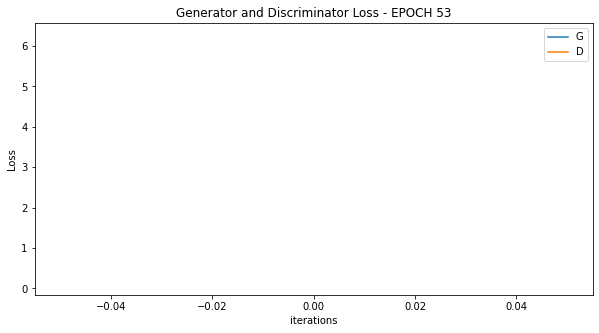

[53/100][321/644] Loss_D: 0.1484; Loss_G: 6.2609
[53/100][322/644] Loss_D: 0.0382; Loss_G: 5.6154
[53/100][323/644] Loss_D: 0.0177; Loss_G: 5.6482
[53/100][324/644] Loss_D: 0.0937; Loss_G: 6.0854
[53/100][325/644] Loss_D: 0.1411; Loss_G: 4.8086
[53/100][326/644] Loss_D: 0.0626; Loss_G: 5.5866
[53/100][327/644] Loss_D: 0.1012; Loss_G: 5.6748
[53/100][328/644] Loss_D: 0.0193; Loss_G: 6.2884
[53/100][329/644] Loss_D: 0.0376; Loss_G: 6.1337
[53/100][330/644] Loss_D: 0.0750; Loss_G: 5.1132
[53/100][331/644] Loss_D: 0.0241; Loss_G: 5.6692
[53/100][332/644] Loss_D: 0.2182; Loss_G: 5.5601
[53/100][333/644] Loss_D: 0.0638; Loss_G: 6.8574
[53/100][334/644] Loss_D: 0.1253; Loss_G: 4.2793
[53/100][335/644] Loss_D: 0.0469; Loss_G: 5.3515
[53/100][336/644] Loss_D: 0.1275; Loss_G: 5.1765
[53/100][337/644] Loss_D: 0.1774; Loss_G: 4.4380
[53/100][338/644] Loss_D: 0.1924; Loss_G: 5.4187
[53/100][339/644] Loss_D: 0.0605; Loss_G: 5.6273
[53/100][340/644] Loss_D: 0.0426; Loss_G: 5.6960
[53/100][341/644] Lo

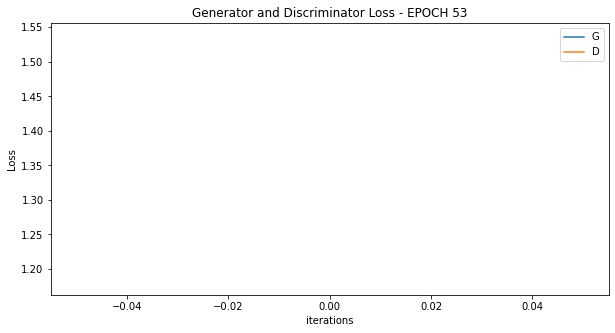

[53/100][643/644] Loss_D: 1.5382; Loss_G: 1.1806
[54/100][0/644] Loss_D: 2.4464; Loss_G: 14.3639
[54/100][1/644] Loss_D: 2.0752; Loss_G: 2.3624
[54/100][2/644] Loss_D: 1.4847; Loss_G: 10.1636
[54/100][3/644] Loss_D: 0.6209; Loss_G: 5.4253
[54/100][4/644] Loss_D: 1.2805; Loss_G: 0.8938
[54/100][5/644] Loss_D: 2.2760; Loss_G: 12.5784
[54/100][6/644] Loss_D: 1.2246; Loss_G: 5.6446
[54/100][7/644] Loss_D: 0.2703; Loss_G: 5.4618
[54/100][8/644] Loss_D: 0.3282; Loss_G: 7.5845
[54/100][9/644] Loss_D: 0.2543; Loss_G: 8.1404
[54/100][10/644] Loss_D: 0.7606; Loss_G: 2.2930
[54/100][11/644] Loss_D: 1.0230; Loss_G: 9.0364
[54/100][12/644] Loss_D: 0.4118; Loss_G: 6.1302
[54/100][13/644] Loss_D: 1.4425; Loss_G: 0.5338
[54/100][14/644] Loss_D: 2.8143; Loss_G: 12.9345
[54/100][15/644] Loss_D: 0.2725; Loss_G: 8.8417
[54/100][16/644] Loss_D: 0.8258; Loss_G: 3.5188
[54/100][17/644] Loss_D: 0.2824; Loss_G: 4.2304
[54/100][18/644] Loss_D: 0.6753; Loss_G: 9.7689
[54/100][19/644] Loss_D: 0.2730; Loss_G: 6.79

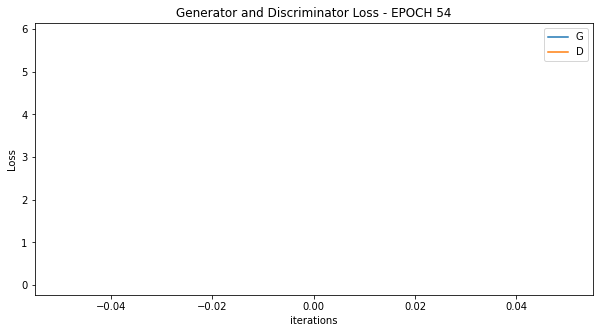

[54/100][321/644] Loss_D: 0.0588; Loss_G: 5.8529
[54/100][322/644] Loss_D: 0.2728; Loss_G: 4.0708
[54/100][323/644] Loss_D: 0.2775; Loss_G: 5.8696
[54/100][324/644] Loss_D: 0.0571; Loss_G: 5.2730
[54/100][325/644] Loss_D: 0.0152; Loss_G: 6.8283
[54/100][326/644] Loss_D: 0.0914; Loss_G: 5.5351
[54/100][327/644] Loss_D: 0.0578; Loss_G: 6.3678
[54/100][328/644] Loss_D: 0.3156; Loss_G: 2.7301
[54/100][329/644] Loss_D: 0.4836; Loss_G: 8.1478
[54/100][330/644] Loss_D: 0.1316; Loss_G: 5.7175
[54/100][331/644] Loss_D: 0.0487; Loss_G: 6.6698
[54/100][332/644] Loss_D: 0.2031; Loss_G: 3.9609
[54/100][333/644] Loss_D: 0.0813; Loss_G: 4.3219
[54/100][334/644] Loss_D: 0.3826; Loss_G: 9.1178
[54/100][335/644] Loss_D: 0.2618; Loss_G: 8.6557
[54/100][336/644] Loss_D: 0.1868; Loss_G: 3.6094
[54/100][337/644] Loss_D: 0.3012; Loss_G: 6.5552
[54/100][338/644] Loss_D: 0.0763; Loss_G: 6.9588
[54/100][339/644] Loss_D: 0.1476; Loss_G: 4.8173
[54/100][340/644] Loss_D: 0.1145; Loss_G: 4.8784
[54/100][341/644] Lo

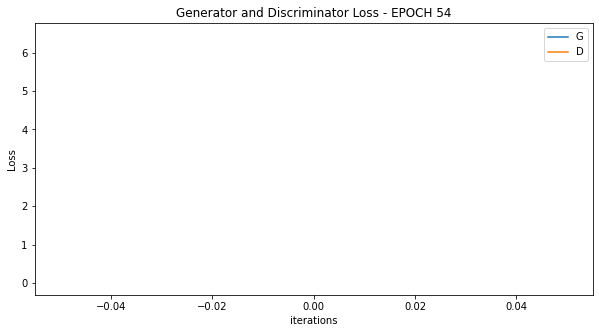

[54/100][643/644] Loss_D: 0.0147; Loss_G: 6.4527
[55/100][0/644] Loss_D: 0.2629; Loss_G: 7.7729
[55/100][1/644] Loss_D: 0.1971; Loss_G: 6.1460
[55/100][2/644] Loss_D: 0.0712; Loss_G: 5.6084
[55/100][3/644] Loss_D: 0.0091; Loss_G: 6.3308
[55/100][4/644] Loss_D: 0.1164; Loss_G: 5.5951
[55/100][5/644] Loss_D: 0.2919; Loss_G: 2.3110
[55/100][6/644] Loss_D: 0.8330; Loss_G: 10.4438
[55/100][7/644] Loss_D: 0.1322; Loss_G: 6.7492
[55/100][8/644] Loss_D: 0.6220; Loss_G: 0.1378
[55/100][9/644] Loss_D: 1.1878; Loss_G: 14.8778
[55/100][10/644] Loss_D: 0.4113; Loss_G: 7.2712
[55/100][11/644] Loss_D: 1.4527; Loss_G: 0.4267
[55/100][12/644] Loss_D: 3.0389; Loss_G: 16.1003
[55/100][13/644] Loss_D: 0.8317; Loss_G: 8.2684
[55/100][14/644] Loss_D: 0.6100; Loss_G: 0.5745
[55/100][15/644] Loss_D: 1.6908; Loss_G: 15.3429
[55/100][16/644] Loss_D: 0.5590; Loss_G: 9.7999
[55/100][17/644] Loss_D: 0.2024; Loss_G: 4.8417
[55/100][18/644] Loss_D: 0.2907; Loss_G: 6.3090
[55/100][19/644] Loss_D: 0.1300; Loss_G: 5.68

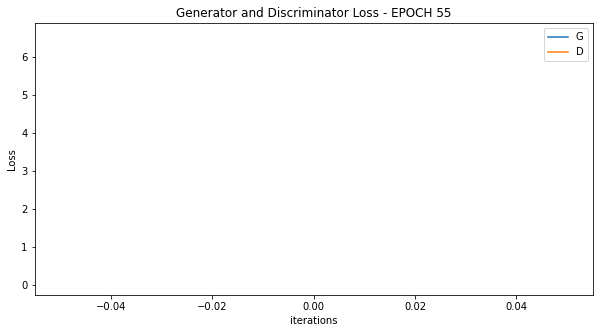

[55/100][321/644] Loss_D: 0.0730; Loss_G: 6.5565
[55/100][322/644] Loss_D: 0.5212; Loss_G: 2.7078
[55/100][323/644] Loss_D: 0.3482; Loss_G: 8.4400
[55/100][324/644] Loss_D: 0.6198; Loss_G: 3.1283
[55/100][325/644] Loss_D: 0.6871; Loss_G: 10.9940
[55/100][326/644] Loss_D: 0.4838; Loss_G: 4.9150
[55/100][327/644] Loss_D: 0.0819; Loss_G: 4.5852
[55/100][328/644] Loss_D: 0.1904; Loss_G: 7.4694
[55/100][329/644] Loss_D: 0.4316; Loss_G: 3.5744
[55/100][330/644] Loss_D: 0.5429; Loss_G: 5.8870
[55/100][331/644] Loss_D: 0.3331; Loss_G: 8.5985
[55/100][332/644] Loss_D: 0.4777; Loss_G: 4.2183
[55/100][333/644] Loss_D: 0.0662; Loss_G: 4.7493
[55/100][334/644] Loss_D: 0.3356; Loss_G: 8.5826
[55/100][335/644] Loss_D: 0.5225; Loss_G: 4.3177
[55/100][336/644] Loss_D: 0.4018; Loss_G: 5.9994
[55/100][337/644] Loss_D: 0.6415; Loss_G: 2.5162
[55/100][338/644] Loss_D: 0.4160; Loss_G: 7.6327
[55/100][339/644] Loss_D: 0.3254; Loss_G: 7.9059
[55/100][340/644] Loss_D: 1.1742; Loss_G: 1.4440
[55/100][341/644] L

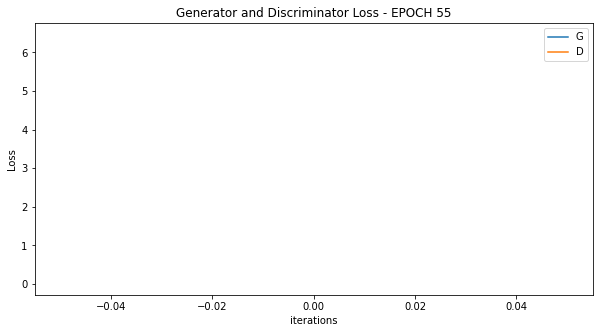

[55/100][643/644] Loss_D: 0.0382; Loss_G: 6.4422
[56/100][0/644] Loss_D: 0.0605; Loss_G: 5.2456
[56/100][1/644] Loss_D: 0.0984; Loss_G: 5.8098
[56/100][2/644] Loss_D: 0.1426; Loss_G: 5.3696
[56/100][3/644] Loss_D: 0.0778; Loss_G: 4.9244
[56/100][4/644] Loss_D: 0.0906; Loss_G: 5.8935
[56/100][5/644] Loss_D: 0.0267; Loss_G: 6.9521
[56/100][6/644] Loss_D: 0.0743; Loss_G: 7.5758
[56/100][7/644] Loss_D: 0.1008; Loss_G: 5.7192
[56/100][8/644] Loss_D: 0.1043; Loss_G: 5.5451
[56/100][9/644] Loss_D: 0.1522; Loss_G: 5.1649
[56/100][10/644] Loss_D: 0.0900; Loss_G: 4.9416
[56/100][11/644] Loss_D: 0.3273; Loss_G: 8.3589
[56/100][12/644] Loss_D: 0.0366; Loss_G: 7.8693
[56/100][13/644] Loss_D: 0.0953; Loss_G: 8.0343
[56/100][14/644] Loss_D: 0.1714; Loss_G: 5.1931
[56/100][15/644] Loss_D: 0.0720; Loss_G: 4.5942
[56/100][16/644] Loss_D: 0.0581; Loss_G: 5.4280
[56/100][17/644] Loss_D: 0.9327; Loss_G: 0.3633
[56/100][18/644] Loss_D: 2.4409; Loss_G: 15.7444
[56/100][19/644] Loss_D: 0.0504; Loss_G: 10.8774

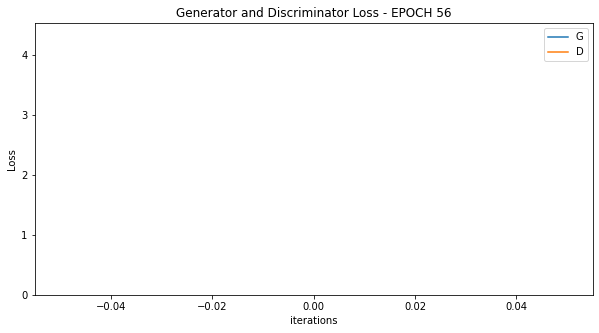

[56/100][321/644] Loss_D: 0.2023; Loss_G: 4.3216
[56/100][322/644] Loss_D: 0.0545; Loss_G: 5.6091
[56/100][323/644] Loss_D: 0.2825; Loss_G: 7.3136
[56/100][324/644] Loss_D: 0.1874; Loss_G: 6.0612
[56/100][325/644] Loss_D: 0.0753; Loss_G: 4.6127
[56/100][326/644] Loss_D: 0.2833; Loss_G: 4.4392
[56/100][327/644] Loss_D: 0.0769; Loss_G: 5.5637
[56/100][328/644] Loss_D: 0.1773; Loss_G: 6.6659
[56/100][329/644] Loss_D: 0.2041; Loss_G: 5.6473
[56/100][330/644] Loss_D: 0.2538; Loss_G: 3.4816
[56/100][331/644] Loss_D: 0.1324; Loss_G: 3.8507
[56/100][332/644] Loss_D: 0.7709; Loss_G: 10.4714
[56/100][333/644] Loss_D: 0.3628; Loss_G: 7.1928
[56/100][334/644] Loss_D: 0.2630; Loss_G: 4.3138
[56/100][335/644] Loss_D: 0.3186; Loss_G: 2.3858
[56/100][336/644] Loss_D: 0.9018; Loss_G: 12.0548
[56/100][337/644] Loss_D: 0.6996; Loss_G: 7.0458
[56/100][338/644] Loss_D: 0.4329; Loss_G: 1.7566
[56/100][339/644] Loss_D: 1.0007; Loss_G: 9.8307
[56/100][340/644] Loss_D: 0.0738; Loss_G: 8.2317
[56/100][341/644] 

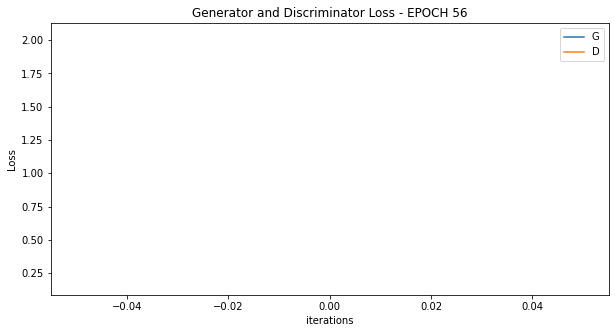

[56/100][643/644] Loss_D: 2.0364; Loss_G: 0.1794
[57/100][0/644] Loss_D: 6.0913; Loss_G: 12.5295
[57/100][1/644] Loss_D: 0.8032; Loss_G: 1.3122
[57/100][2/644] Loss_D: 1.3229; Loss_G: 7.6466
[57/100][3/644] Loss_D: 2.0093; Loss_G: 0.0257
[57/100][4/644] Loss_D: 4.7940; Loss_G: 21.0269
[57/100][5/644] Loss_D: 6.4426; Loss_G: 0.8859
[57/100][6/644] Loss_D: 3.7450; Loss_G: 17.2006
[57/100][7/644] Loss_D: 1.9121; Loss_G: 5.4823
[57/100][8/644] Loss_D: 0.7869; Loss_G: 7.3164
[57/100][9/644] Loss_D: 0.3010; Loss_G: 9.4851
[57/100][10/644] Loss_D: 3.2671; Loss_G: 0.6176
[57/100][11/644] Loss_D: 1.6208; Loss_G: 11.6992
[57/100][12/644] Loss_D: 1.1624; Loss_G: 3.3865
[57/100][13/644] Loss_D: 0.8323; Loss_G: 3.6325
[57/100][14/644] Loss_D: 2.8746; Loss_G: 19.7422
[57/100][15/644] Loss_D: 7.1441; Loss_G: 6.7206
[57/100][16/644] Loss_D: 0.2836; Loss_G: 3.1262
[57/100][17/644] Loss_D: 0.3734; Loss_G: 6.7516
[57/100][18/644] Loss_D: 0.1742; Loss_G: 6.6722
[57/100][19/644] Loss_D: 0.2321; Loss_G: 7.2

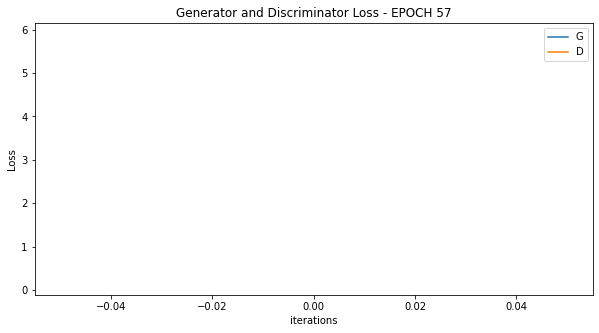

[57/100][321/644] Loss_D: 0.1770; Loss_G: 5.8668
[57/100][322/644] Loss_D: 0.2191; Loss_G: 5.0454
[57/100][323/644] Loss_D: 0.3304; Loss_G: 2.5678
[57/100][324/644] Loss_D: 0.4818; Loss_G: 8.3010
[57/100][325/644] Loss_D: 0.3883; Loss_G: 3.6703
[57/100][326/644] Loss_D: 0.2340; Loss_G: 6.8540
[57/100][327/644] Loss_D: 0.2244; Loss_G: 4.5129
[57/100][328/644] Loss_D: 0.0786; Loss_G: 6.4375
[57/100][329/644] Loss_D: 0.0524; Loss_G: 5.9265
[57/100][330/644] Loss_D: 0.1123; Loss_G: 5.9838
[57/100][331/644] Loss_D: 0.0331; Loss_G: 6.6441
[57/100][332/644] Loss_D: 0.1630; Loss_G: 5.7954
[57/100][333/644] Loss_D: 0.0681; Loss_G: 4.5651
[57/100][334/644] Loss_D: 0.2015; Loss_G: 6.5162
[57/100][335/644] Loss_D: 0.3794; Loss_G: 4.5009
[57/100][336/644] Loss_D: 0.0634; Loss_G: 4.1064
[57/100][337/644] Loss_D: 0.1605; Loss_G: 6.1864
[57/100][338/644] Loss_D: 0.0296; Loss_G: 7.1472
[57/100][339/644] Loss_D: 0.1636; Loss_G: 4.8024
[57/100][340/644] Loss_D: 0.2605; Loss_G: 3.8773
[57/100][341/644] Lo

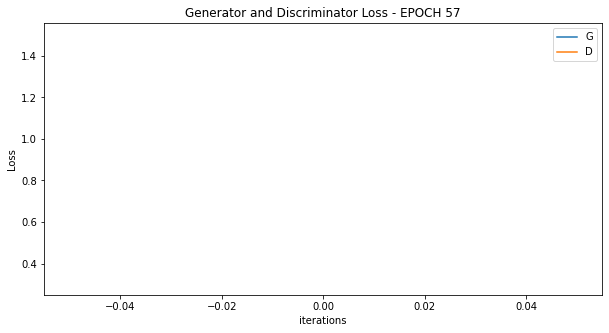

[57/100][643/644] Loss_D: 1.4983; Loss_G: 0.3093
[58/100][0/644] Loss_D: 5.5819; Loss_G: 19.6455
[58/100][1/644] Loss_D: 7.1595; Loss_G: 0.0028
[58/100][2/644] Loss_D: 6.6221; Loss_G: 20.4784
[58/100][3/644] Loss_D: 6.3730; Loss_G: 0.1965
[58/100][4/644] Loss_D: 4.2474; Loss_G: 16.8272
[58/100][5/644] Loss_D: 3.5519; Loss_G: 2.1239
[58/100][6/644] Loss_D: 1.8534; Loss_G: 7.0199
[58/100][7/644] Loss_D: 1.4265; Loss_G: 2.8583
[58/100][8/644] Loss_D: 2.7102; Loss_G: 14.7887
[58/100][9/644] Loss_D: 3.7703; Loss_G: 1.0301
[58/100][10/644] Loss_D: 1.9656; Loss_G: 8.4240
[58/100][11/644] Loss_D: 0.5283; Loss_G: 6.8312
[58/100][12/644] Loss_D: 1.3267; Loss_G: 1.3294
[58/100][13/644] Loss_D: 2.6879; Loss_G: 11.7258
[58/100][14/644] Loss_D: 0.5000; Loss_G: 6.0121
[58/100][15/644] Loss_D: 0.8826; Loss_G: 1.7708
[58/100][16/644] Loss_D: 0.6789; Loss_G: 5.9923
[58/100][17/644] Loss_D: 0.9457; Loss_G: 9.7642
[58/100][18/644] Loss_D: 1.0389; Loss_G: 5.1523
[58/100][19/644] Loss_D: 0.6678; Loss_G: 4.9

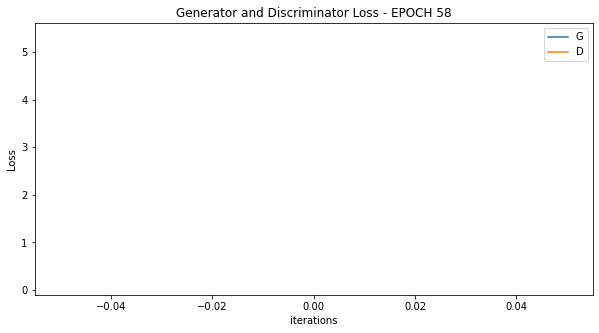

[58/100][321/644] Loss_D: 0.1561; Loss_G: 5.3550
[58/100][322/644] Loss_D: 0.1273; Loss_G: 5.3342
[58/100][323/644] Loss_D: 0.0389; Loss_G: 6.4563
[58/100][324/644] Loss_D: 0.2528; Loss_G: 3.6999
[58/100][325/644] Loss_D: 0.3484; Loss_G: 7.2508
[58/100][326/644] Loss_D: 0.0937; Loss_G: 6.4982
[58/100][327/644] Loss_D: 0.0498; Loss_G: 7.1987
[58/100][328/644] Loss_D: 0.5602; Loss_G: 3.5269
[58/100][329/644] Loss_D: 0.1800; Loss_G: 3.9972
[58/100][330/644] Loss_D: 0.2880; Loss_G: 6.9916
[58/100][331/644] Loss_D: 0.2818; Loss_G: 4.5473
[58/100][332/644] Loss_D: 0.4232; Loss_G: 3.2377
[58/100][333/644] Loss_D: 0.4682; Loss_G: 7.3079
[58/100][334/644] Loss_D: 0.0552; Loss_G: 6.4006
[58/100][335/644] Loss_D: 0.3985; Loss_G: 4.5088
[58/100][336/644] Loss_D: 0.5231; Loss_G: 8.1297
[58/100][337/644] Loss_D: 0.2813; Loss_G: 5.2323
[58/100][338/644] Loss_D: 0.0450; Loss_G: 5.0878
[58/100][339/644] Loss_D: 0.3847; Loss_G: 3.3884
[58/100][340/644] Loss_D: 0.7935; Loss_G: 10.3071
[58/100][341/644] L

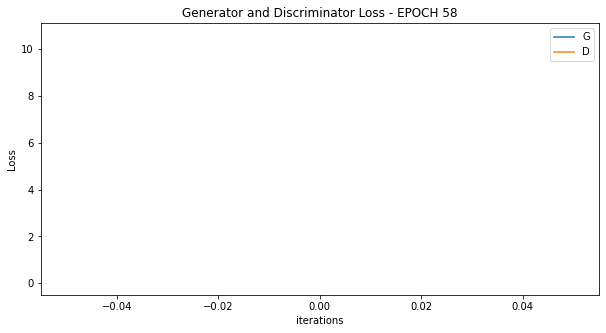

[58/100][643/644] Loss_D: 0.0353; Loss_G: 10.5801
[59/100][0/644] Loss_D: 0.7117; Loss_G: 12.4796
[59/100][1/644] Loss_D: 0.4254; Loss_G: 8.8115
[59/100][2/644] Loss_D: 0.1129; Loss_G: 6.3514
[59/100][3/644] Loss_D: 0.0657; Loss_G: 4.8828
[59/100][4/644] Loss_D: 0.0641; Loss_G: 6.1236
[59/100][5/644] Loss_D: 0.1017; Loss_G: 5.0799
[59/100][6/644] Loss_D: 0.0432; Loss_G: 6.2553
[59/100][7/644] Loss_D: 0.0742; Loss_G: 5.6085
[59/100][8/644] Loss_D: 0.1537; Loss_G: 6.4435
[59/100][9/644] Loss_D: 0.1324; Loss_G: 5.9495
[59/100][10/644] Loss_D: 0.0870; Loss_G: 5.2086
[59/100][11/644] Loss_D: 0.0465; Loss_G: 5.5272
[59/100][12/644] Loss_D: 0.0433; Loss_G: 5.5031
[59/100][13/644] Loss_D: 0.0300; Loss_G: 5.7626
[59/100][14/644] Loss_D: 0.0666; Loss_G: 5.0184
[59/100][15/644] Loss_D: 0.0227; Loss_G: 5.3618
[59/100][16/644] Loss_D: 0.0865; Loss_G: 5.5898
[59/100][17/644] Loss_D: 0.0782; Loss_G: 5.7226
[59/100][18/644] Loss_D: 0.1268; Loss_G: 5.1536
[59/100][19/644] Loss_D: 0.0369; Loss_G: 6.1640

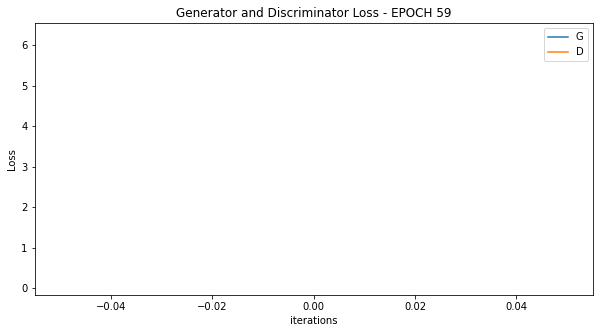

[59/100][321/644] Loss_D: 0.1406; Loss_G: 6.2457
[59/100][322/644] Loss_D: 0.0967; Loss_G: 5.6735
[59/100][323/644] Loss_D: 0.0399; Loss_G: 5.6735
[59/100][324/644] Loss_D: 0.2612; Loss_G: 7.4823
[59/100][325/644] Loss_D: 0.1002; Loss_G: 7.6200
[59/100][326/644] Loss_D: 0.3583; Loss_G: 4.4142
[59/100][327/644] Loss_D: 0.4430; Loss_G: 7.9715
[59/100][328/644] Loss_D: 0.0072; Loss_G: 8.9614
[59/100][329/644] Loss_D: 0.1066; Loss_G: 5.8647
[59/100][330/644] Loss_D: 0.2156; Loss_G: 6.4042
[59/100][331/644] Loss_D: 0.0353; Loss_G: 5.2820
[59/100][332/644] Loss_D: 0.0281; Loss_G: 6.2444
[59/100][333/644] Loss_D: 0.0363; Loss_G: 6.2890
[59/100][334/644] Loss_D: 0.1019; Loss_G: 4.8806
[59/100][335/644] Loss_D: 0.1590; Loss_G: 5.5054
[59/100][336/644] Loss_D: 0.0721; Loss_G: 4.9642
[59/100][337/644] Loss_D: 0.0904; Loss_G: 5.2818
[59/100][338/644] Loss_D: 0.0840; Loss_G: 6.3990
[59/100][339/644] Loss_D: 0.1010; Loss_G: 6.6200
[59/100][340/644] Loss_D: 0.1198; Loss_G: 4.9757
[59/100][341/644] Lo

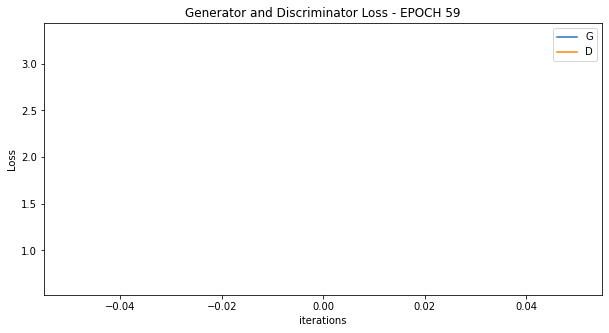

[59/100][643/644] Loss_D: 0.6576; Loss_G: 3.3026
[60/100][0/644] Loss_D: 0.5273; Loss_G: 6.4255
[60/100][1/644] Loss_D: 0.4862; Loss_G: 8.4589
[60/100][2/644] Loss_D: 0.4651; Loss_G: 5.6747
[60/100][3/644] Loss_D: 0.1595; Loss_G: 4.8292
[60/100][4/644] Loss_D: 0.1536; Loss_G: 6.2583
[60/100][5/644] Loss_D: 0.3576; Loss_G: 6.1860
[60/100][6/644] Loss_D: 0.1221; Loss_G: 6.1594
[60/100][7/644] Loss_D: 0.0282; Loss_G: 6.4419
[60/100][8/644] Loss_D: 0.1512; Loss_G: 5.5371
[60/100][9/644] Loss_D: 0.1662; Loss_G: 4.8479
[60/100][10/644] Loss_D: 0.2124; Loss_G: 7.0058
[60/100][11/644] Loss_D: 0.0955; Loss_G: 6.5456
[60/100][12/644] Loss_D: 0.2871; Loss_G: 7.4623
[60/100][13/644] Loss_D: 0.1579; Loss_G: 5.6169
[60/100][14/644] Loss_D: 0.0574; Loss_G: 5.3729
[60/100][15/644] Loss_D: 0.4468; Loss_G: 7.4147
[60/100][16/644] Loss_D: 0.2598; Loss_G: 4.7313
[60/100][17/644] Loss_D: 0.3589; Loss_G: 2.9909
[60/100][18/644] Loss_D: 0.1193; Loss_G: 5.6499
[60/100][19/644] Loss_D: 0.1084; Loss_G: 6.5069
[

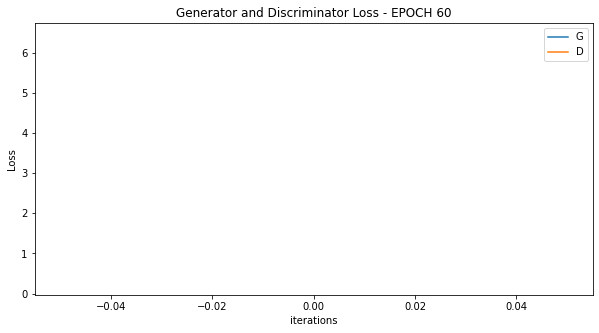

[60/100][321/644] Loss_D: 0.2754; Loss_G: 6.4295
[60/100][322/644] Loss_D: 0.2554; Loss_G: 4.1910
[60/100][323/644] Loss_D: 0.1896; Loss_G: 5.7041
[60/100][324/644] Loss_D: 0.1199; Loss_G: 6.6541
[60/100][325/644] Loss_D: 0.0761; Loss_G: 5.9449
[60/100][326/644] Loss_D: 0.0246; Loss_G: 5.7937
[60/100][327/644] Loss_D: 0.4333; Loss_G: 4.3676
[60/100][328/644] Loss_D: 0.3170; Loss_G: 8.2566
[60/100][329/644] Loss_D: 0.2443; Loss_G: 5.8032
[60/100][330/644] Loss_D: 0.0231; Loss_G: 6.3903
[60/100][331/644] Loss_D: 0.1017; Loss_G: 5.9226
[60/100][332/644] Loss_D: 0.1591; Loss_G: 5.9376
[60/100][333/644] Loss_D: 0.0491; Loss_G: 6.2643
[60/100][334/644] Loss_D: 0.3285; Loss_G: 4.1230
[60/100][335/644] Loss_D: 0.2210; Loss_G: 5.8817
[60/100][336/644] Loss_D: 0.0631; Loss_G: 6.4965
[60/100][337/644] Loss_D: 0.1010; Loss_G: 7.2271
[60/100][338/644] Loss_D: 0.1098; Loss_G: 5.6320
[60/100][339/644] Loss_D: 0.1715; Loss_G: 4.5548
[60/100][340/644] Loss_D: 0.2858; Loss_G: 5.9054
[60/100][341/644] Lo

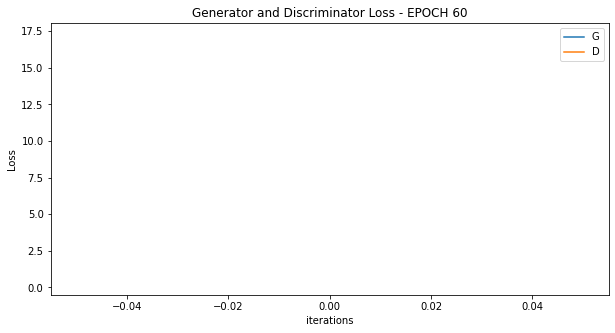

[60/100][643/644] Loss_D: 0.3378; Loss_G: 17.2128
[61/100][0/644] Loss_D: 0.2143; Loss_G: 5.5308
[61/100][1/644] Loss_D: 0.1894; Loss_G: 7.6283
[61/100][2/644] Loss_D: 0.2213; Loss_G: 5.7050
[61/100][3/644] Loss_D: 0.1192; Loss_G: 6.1730
[61/100][4/644] Loss_D: 0.2788; Loss_G: 3.6314
[61/100][5/644] Loss_D: 0.3462; Loss_G: 5.3098
[61/100][6/644] Loss_D: 0.2438; Loss_G: 8.5029
[61/100][7/644] Loss_D: 0.3370; Loss_G: 4.1818
[61/100][8/644] Loss_D: 0.1419; Loss_G: 5.4912
[61/100][9/644] Loss_D: 0.0592; Loss_G: 5.7748
[61/100][10/644] Loss_D: 0.2501; Loss_G: 8.6800
[61/100][11/644] Loss_D: 0.4153; Loss_G: 5.1863
[61/100][12/644] Loss_D: 0.3984; Loss_G: 4.4447
[61/100][13/644] Loss_D: 0.1420; Loss_G: 5.8403
[61/100][14/644] Loss_D: 0.4562; Loss_G: 9.6532
[61/100][15/644] Loss_D: 0.3287; Loss_G: 6.8429
[61/100][16/644] Loss_D: 0.1080; Loss_G: 4.1536
[61/100][17/644] Loss_D: 0.1463; Loss_G: 5.0174
[61/100][18/644] Loss_D: 0.0711; Loss_G: 5.9450
[61/100][19/644] Loss_D: 0.1747; Loss_G: 4.5698


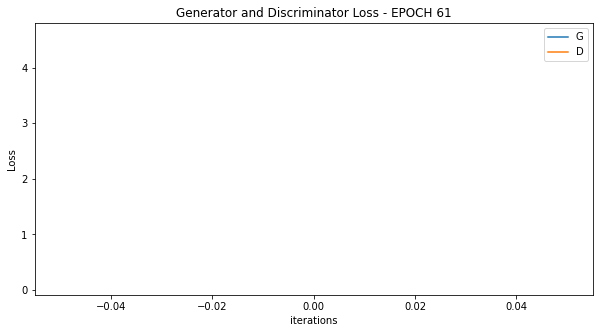

[61/100][321/644] Loss_D: 0.1385; Loss_G: 4.5783
[61/100][322/644] Loss_D: 0.0650; Loss_G: 5.6352
[61/100][323/644] Loss_D: 0.1116; Loss_G: 6.0531
[61/100][324/644] Loss_D: 0.4581; Loss_G: 2.8065
[61/100][325/644] Loss_D: 0.2523; Loss_G: 4.8630
[61/100][326/644] Loss_D: 0.2997; Loss_G: 7.8648
[61/100][327/644] Loss_D: 0.1327; Loss_G: 7.3141
[61/100][328/644] Loss_D: 0.0562; Loss_G: 7.5618
[61/100][329/644] Loss_D: 0.2112; Loss_G: 4.6318
[61/100][330/644] Loss_D: 0.1012; Loss_G: 5.2376
[61/100][331/644] Loss_D: 0.1342; Loss_G: 4.8730
[61/100][332/644] Loss_D: 0.1146; Loss_G: 6.2731
[61/100][333/644] Loss_D: 0.3575; Loss_G: 8.6902
[61/100][334/644] Loss_D: 0.0493; Loss_G: 8.5997
[61/100][335/644] Loss_D: 0.9160; Loss_G: 1.1247
[61/100][336/644] Loss_D: 0.5238; Loss_G: 8.6038
[61/100][337/644] Loss_D: 0.1834; Loss_G: 6.2009
[61/100][338/644] Loss_D: 0.1992; Loss_G: 5.5117
[61/100][339/644] Loss_D: 0.1377; Loss_G: 6.1947
[61/100][340/644] Loss_D: 0.3879; Loss_G: 2.7348
[61/100][341/644] Lo

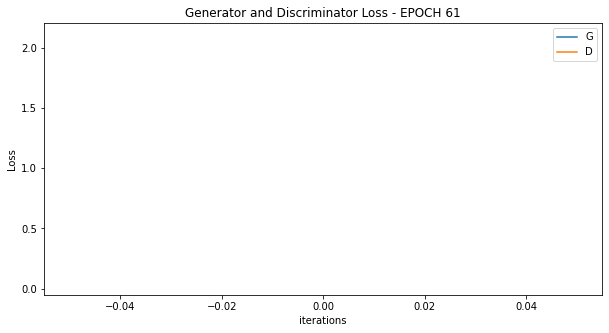

[61/100][643/644] Loss_D: 2.1023; Loss_G: 0.0504
[62/100][0/644] Loss_D: 10.4642; Loss_G: 12.2982
[62/100][1/644] Loss_D: 3.7112; Loss_G: 0.0861
[62/100][2/644] Loss_D: 9.0015; Loss_G: 14.4817
[62/100][3/644] Loss_D: 3.6829; Loss_G: 0.4522
[62/100][4/644] Loss_D: 4.8457; Loss_G: 7.0323
[62/100][5/644] Loss_D: 1.0747; Loss_G: 11.0155
[62/100][6/644] Loss_D: 2.6854; Loss_G: 1.5051
[62/100][7/644] Loss_D: 4.3914; Loss_G: 12.0355
[62/100][8/644] Loss_D: 0.6738; Loss_G: 8.6152
[62/100][9/644] Loss_D: 1.8150; Loss_G: 1.7258
[62/100][10/644] Loss_D: 1.8777; Loss_G: 11.0539
[62/100][11/644] Loss_D: 0.8848; Loss_G: 6.3465
[62/100][12/644] Loss_D: 0.6753; Loss_G: 3.4215
[62/100][13/644] Loss_D: 1.3626; Loss_G: 10.3979
[62/100][14/644] Loss_D: 0.5091; Loss_G: 5.4358
[62/100][15/644] Loss_D: 0.7036; Loss_G: 2.5492
[62/100][16/644] Loss_D: 1.1734; Loss_G: 9.0909
[62/100][17/644] Loss_D: 0.1218; Loss_G: 7.3368
[62/100][18/644] Loss_D: 0.3578; Loss_G: 6.2947
[62/100][19/644] Loss_D: 0.3371; Loss_G: 6

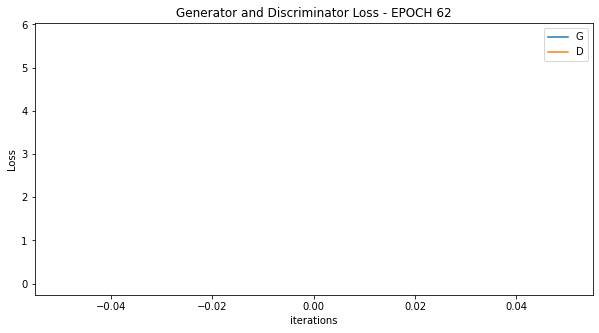

[62/100][321/644] Loss_D: 0.0287; Loss_G: 5.7480
[62/100][322/644] Loss_D: 0.0856; Loss_G: 5.2250
[62/100][323/644] Loss_D: 0.1272; Loss_G: 5.7818
[62/100][324/644] Loss_D: 0.3032; Loss_G: 3.9250
[62/100][325/644] Loss_D: 0.7901; Loss_G: 10.0518
[62/100][326/644] Loss_D: 0.3919; Loss_G: 6.5325
[62/100][327/644] Loss_D: 0.8055; Loss_G: 3.0766
[62/100][328/644] Loss_D: 0.0922; Loss_G: 5.7957
[62/100][329/644] Loss_D: 0.1583; Loss_G: 5.7052
[62/100][330/644] Loss_D: 0.2845; Loss_G: 4.7711
[62/100][331/644] Loss_D: 0.2285; Loss_G: 6.9720
[62/100][332/644] Loss_D: 0.0577; Loss_G: 6.9344
[62/100][333/644] Loss_D: 0.0806; Loss_G: 7.0204
[62/100][334/644] Loss_D: 0.4879; Loss_G: 3.5612
[62/100][335/644] Loss_D: 0.1732; Loss_G: 4.6008
[62/100][336/644] Loss_D: 0.3732; Loss_G: 8.1094
[62/100][337/644] Loss_D: 0.0755; Loss_G: 8.4573
[62/100][338/644] Loss_D: 0.0068; Loss_G: 7.5542
[62/100][339/644] Loss_D: 0.0650; Loss_G: 5.6890
[62/100][340/644] Loss_D: 0.1414; Loss_G: 4.7906
[62/100][341/644] L

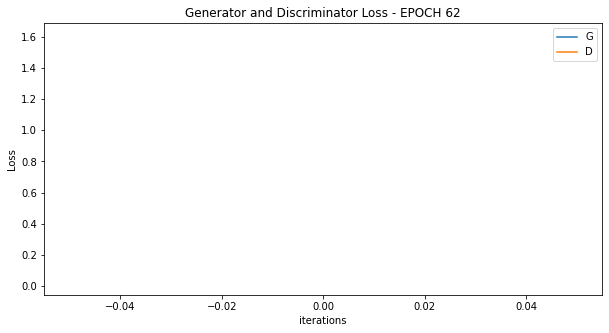

[62/100][643/644] Loss_D: 1.6083; Loss_G: 0.0230
[63/100][0/644] Loss_D: 5.4220; Loss_G: 13.6993
[63/100][1/644] Loss_D: 0.5446; Loss_G: 5.3878
[63/100][2/644] Loss_D: 0.1807; Loss_G: 4.4277
[63/100][3/644] Loss_D: 0.5970; Loss_G: 8.0904
[63/100][4/644] Loss_D: 0.5356; Loss_G: 4.7746
[63/100][5/644] Loss_D: 0.2576; Loss_G: 3.7738
[63/100][6/644] Loss_D: 1.4324; Loss_G: 12.0406
[63/100][7/644] Loss_D: 1.0561; Loss_G: 2.8905
[63/100][8/644] Loss_D: 0.3431; Loss_G: 5.3526
[63/100][9/644] Loss_D: 1.0513; Loss_G: 5.3460
[63/100][10/644] Loss_D: 0.5152; Loss_G: 10.4032
[63/100][11/644] Loss_D: 2.4488; Loss_G: 0.9373
[63/100][12/644] Loss_D: 1.2810; Loss_G: 10.7872
[63/100][13/644] Loss_D: 0.0816; Loss_G: 9.2971
[63/100][14/644] Loss_D: 1.2686; Loss_G: 1.8030
[63/100][15/644] Loss_D: 0.3367; Loss_G: 5.1844
[63/100][16/644] Loss_D: 2.5994; Loss_G: 16.1022
[63/100][17/644] Loss_D: 4.2629; Loss_G: 2.1995
[63/100][18/644] Loss_D: 0.7402; Loss_G: 4.7800
[63/100][19/644] Loss_D: 0.5428; Loss_G: 8.8

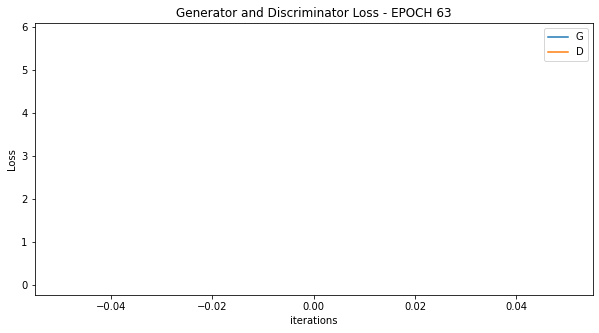

[63/100][321/644] Loss_D: 0.0490; Loss_G: 5.7986
[63/100][322/644] Loss_D: 0.2001; Loss_G: 5.8305
[63/100][323/644] Loss_D: 0.0106; Loss_G: 5.7961
[63/100][324/644] Loss_D: 0.0352; Loss_G: 6.5748
[63/100][325/644] Loss_D: 0.2976; Loss_G: 6.6651
[63/100][326/644] Loss_D: 0.0646; Loss_G: 6.4703
[63/100][327/644] Loss_D: 0.0372; Loss_G: 6.6202
[63/100][328/644] Loss_D: 0.0073; Loss_G: 6.7477
[63/100][329/644] Loss_D: 0.0818; Loss_G: 5.6592
[63/100][330/644] Loss_D: 0.0324; Loss_G: 5.3744
[63/100][331/644] Loss_D: 0.0816; Loss_G: 5.9555
[63/100][332/644] Loss_D: 0.1425; Loss_G: 6.3499
[63/100][333/644] Loss_D: 0.0153; Loss_G: 7.4240
[63/100][334/644] Loss_D: 0.0905; Loss_G: 4.8265
[63/100][335/644] Loss_D: 0.0716; Loss_G: 5.7720
[63/100][336/644] Loss_D: 0.0844; Loss_G: 5.0341
[63/100][337/644] Loss_D: 0.2219; Loss_G: 6.8320
[63/100][338/644] Loss_D: 0.1548; Loss_G: 5.6720
[63/100][339/644] Loss_D: 0.1113; Loss_G: 4.7160
[63/100][340/644] Loss_D: 0.0790; Loss_G: 4.0918
[63/100][341/644] Lo

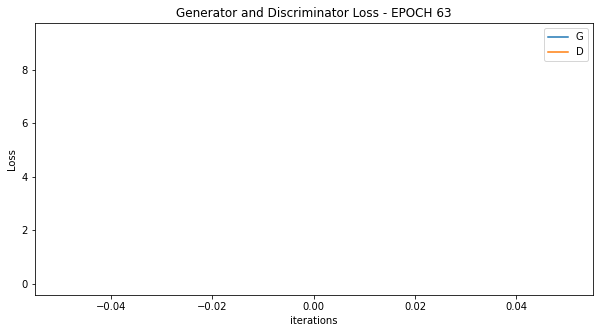

[63/100][643/644] Loss_D: 0.0459; Loss_G: 9.2771
[64/100][0/644] Loss_D: 0.1246; Loss_G: 5.7164
[64/100][1/644] Loss_D: 0.1303; Loss_G: 5.7083
[64/100][2/644] Loss_D: 0.0623; Loss_G: 5.7372
[64/100][3/644] Loss_D: 0.2006; Loss_G: 5.2759
[64/100][4/644] Loss_D: 0.2334; Loss_G: 5.7340
[64/100][5/644] Loss_D: 0.1367; Loss_G: 5.3514
[64/100][6/644] Loss_D: 0.1599; Loss_G: 5.0117
[64/100][7/644] Loss_D: 0.4111; Loss_G: 5.9709
[64/100][8/644] Loss_D: 0.1648; Loss_G: 5.3422
[64/100][9/644] Loss_D: 0.0935; Loss_G: 5.1326
[64/100][10/644] Loss_D: 0.1144; Loss_G: 5.5063
[64/100][11/644] Loss_D: 0.1792; Loss_G: 5.5361
[64/100][12/644] Loss_D: 0.1111; Loss_G: 5.2149
[64/100][13/644] Loss_D: 0.0691; Loss_G: 7.1015
[64/100][14/644] Loss_D: 0.1497; Loss_G: 6.0995
[64/100][15/644] Loss_D: 0.1261; Loss_G: 4.2956
[64/100][16/644] Loss_D: 0.1926; Loss_G: 5.7256
[64/100][17/644] Loss_D: 0.1236; Loss_G: 5.2836
[64/100][18/644] Loss_D: 0.1883; Loss_G: 5.0387
[64/100][19/644] Loss_D: 0.3695; Loss_G: 7.8730
[

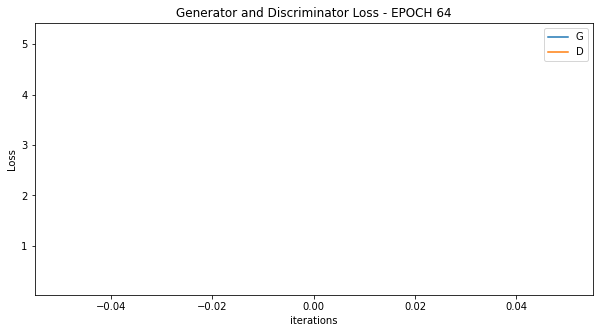

[64/100][321/644] Loss_D: 0.2733; Loss_G: 5.1733
[64/100][322/644] Loss_D: 0.0117; Loss_G: 5.9090
[64/100][323/644] Loss_D: 0.1565; Loss_G: 4.6821
[64/100][324/644] Loss_D: 0.0675; Loss_G: 5.9587
[64/100][325/644] Loss_D: 0.0950; Loss_G: 5.8165
[64/100][326/644] Loss_D: 0.0440; Loss_G: 5.9677
[64/100][327/644] Loss_D: 0.0331; Loss_G: 5.0739
[64/100][328/644] Loss_D: 0.1453; Loss_G: 6.3523
[64/100][329/644] Loss_D: 0.0491; Loss_G: 6.5513
[64/100][330/644] Loss_D: 0.0799; Loss_G: 6.2001
[64/100][331/644] Loss_D: 0.0516; Loss_G: 7.4411
[64/100][332/644] Loss_D: 0.0644; Loss_G: 5.0905
[64/100][333/644] Loss_D: 0.1310; Loss_G: 4.6543
[64/100][334/644] Loss_D: 0.0680; Loss_G: 4.8226
[64/100][335/644] Loss_D: 0.0677; Loss_G: 5.6247
[64/100][336/644] Loss_D: 0.0636; Loss_G: 5.6632
[64/100][337/644] Loss_D: 0.1283; Loss_G: 5.7760
[64/100][338/644] Loss_D: 0.0754; Loss_G: 5.3804
[64/100][339/644] Loss_D: 0.0573; Loss_G: 6.0473
[64/100][340/644] Loss_D: 0.0947; Loss_G: 6.1208
[64/100][341/644] Lo

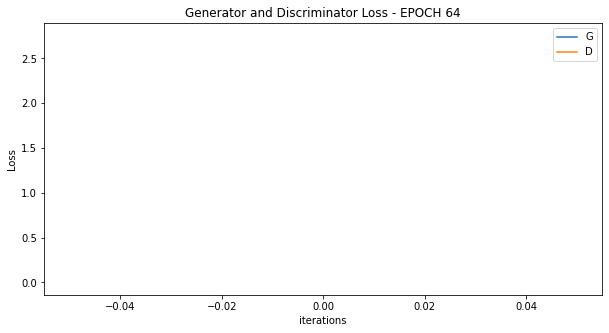

[64/100][643/644] Loss_D: 2.7575; Loss_G: 0.0001
[65/100][0/644] Loss_D: 7.8755; Loss_G: 14.6662
[65/100][1/644] Loss_D: 3.0400; Loss_G: 0.1458
[65/100][2/644] Loss_D: 8.2513; Loss_G: 15.7312
[65/100][3/644] Loss_D: 4.4034; Loss_G: 1.0644
[65/100][4/644] Loss_D: 1.1992; Loss_G: 5.6580
[65/100][5/644] Loss_D: 3.0932; Loss_G: 19.1678
[65/100][6/644] Loss_D: 5.7935; Loss_G: 3.8807
[65/100][7/644] Loss_D: 0.3288; Loss_G: 3.2720
[65/100][8/644] Loss_D: 1.5038; Loss_G: 11.3865
[65/100][9/644] Loss_D: 1.0774; Loss_G: 4.9552
[65/100][10/644] Loss_D: 0.4750; Loss_G: 2.7054
[65/100][11/644] Loss_D: 0.8477; Loss_G: 9.1373
[65/100][12/644] Loss_D: 0.5907; Loss_G: 5.8318
[65/100][13/644] Loss_D: 0.7534; Loss_G: 8.6258
[65/100][14/644] Loss_D: 0.9550; Loss_G: 3.4194
[65/100][15/644] Loss_D: 0.9094; Loss_G: 6.4669
[65/100][16/644] Loss_D: 0.1763; Loss_G: 5.6345
[65/100][17/644] Loss_D: 0.1712; Loss_G: 4.7094
[65/100][18/644] Loss_D: 0.7671; Loss_G: 10.5167
[65/100][19/644] Loss_D: 1.0386; Loss_G: 3.0

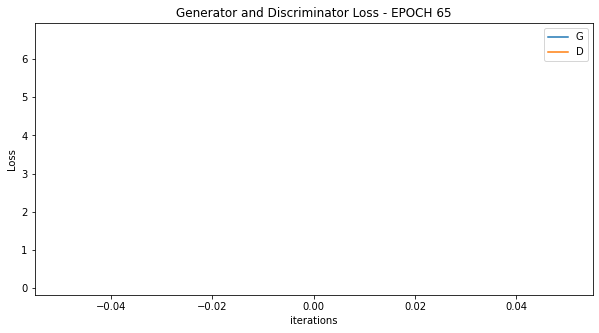

[65/100][321/644] Loss_D: 0.1475; Loss_G: 6.6232
[65/100][322/644] Loss_D: 0.1793; Loss_G: 4.7708
[65/100][323/644] Loss_D: 0.0847; Loss_G: 5.5971
[65/100][324/644] Loss_D: 0.0998; Loss_G: 5.9116
[65/100][325/644] Loss_D: 0.1116; Loss_G: 5.8114
[65/100][326/644] Loss_D: 0.1142; Loss_G: 4.9829
[65/100][327/644] Loss_D: 0.1126; Loss_G: 4.8412
[65/100][328/644] Loss_D: 0.0521; Loss_G: 5.2583
[65/100][329/644] Loss_D: 0.0328; Loss_G: 5.4317
[65/100][330/644] Loss_D: 0.1224; Loss_G: 4.9497
[65/100][331/644] Loss_D: 0.0574; Loss_G: 6.0281
[65/100][332/644] Loss_D: 0.0989; Loss_G: 5.4845
[65/100][333/644] Loss_D: 0.0617; Loss_G: 6.4054
[65/100][334/644] Loss_D: 0.0489; Loss_G: 4.9353
[65/100][335/644] Loss_D: 0.1332; Loss_G: 5.3575
[65/100][336/644] Loss_D: 0.0944; Loss_G: 4.7272
[65/100][337/644] Loss_D: 0.0263; Loss_G: 5.9410
[65/100][338/644] Loss_D: 0.1180; Loss_G: 5.1375
[65/100][339/644] Loss_D: 0.1197; Loss_G: 5.2735
[65/100][340/644] Loss_D: 0.1396; Loss_G: 6.5805
[65/100][341/644] Lo

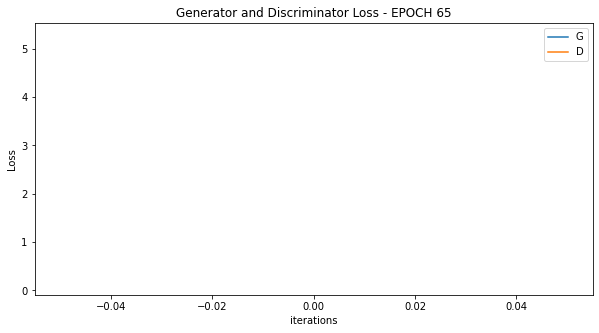

[65/100][643/644] Loss_D: 0.1665; Loss_G: 5.2776
[66/100][0/644] Loss_D: 0.0769; Loss_G: 4.1128
[66/100][1/644] Loss_D: 0.1322; Loss_G: 5.9152
[66/100][2/644] Loss_D: 0.2230; Loss_G: 7.4886
[66/100][3/644] Loss_D: 0.0442; Loss_G: 8.0865
[66/100][4/644] Loss_D: 0.1673; Loss_G: 6.5198
[66/100][5/644] Loss_D: 0.6740; Loss_G: 2.9094
[66/100][6/644] Loss_D: 0.4942; Loss_G: 7.6813
[66/100][7/644] Loss_D: 0.1173; Loss_G: 6.4777
[66/100][8/644] Loss_D: 0.0626; Loss_G: 5.8953
[66/100][9/644] Loss_D: 0.0371; Loss_G: 6.4813
[66/100][10/644] Loss_D: 0.1555; Loss_G: 4.8040
[66/100][11/644] Loss_D: 0.1391; Loss_G: 5.2679
[66/100][12/644] Loss_D: 0.2844; Loss_G: 6.4084
[66/100][13/644] Loss_D: 0.1726; Loss_G: 6.7178
[66/100][14/644] Loss_D: 0.1851; Loss_G: 6.0237
[66/100][15/644] Loss_D: 0.1009; Loss_G: 7.2197
[66/100][16/644] Loss_D: 0.9294; Loss_G: 0.6935
[66/100][17/644] Loss_D: 1.3880; Loss_G: 10.6675
[66/100][18/644] Loss_D: 0.0792; Loss_G: 7.4025
[66/100][19/644] Loss_D: 0.5121; Loss_G: 2.7858


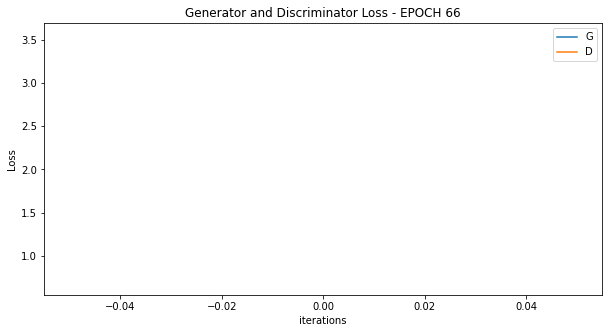

[66/100][321/644] Loss_D: 0.6927; Loss_G: 3.5523
[66/100][322/644] Loss_D: 0.4427; Loss_G: 6.5300
[66/100][323/644] Loss_D: 0.1270; Loss_G: 5.4034
[66/100][324/644] Loss_D: 0.2364; Loss_G: 7.8469
[66/100][325/644] Loss_D: 0.4602; Loss_G: 5.2997
[66/100][326/644] Loss_D: 0.1751; Loss_G: 4.7070
[66/100][327/644] Loss_D: 0.0439; Loss_G: 5.7241
[66/100][328/644] Loss_D: 0.0986; Loss_G: 5.4980
[66/100][329/644] Loss_D: 0.1957; Loss_G: 6.0515
[66/100][330/644] Loss_D: 0.2943; Loss_G: 5.1312
[66/100][331/644] Loss_D: 0.0820; Loss_G: 5.4970
[66/100][332/644] Loss_D: 0.0795; Loss_G: 5.1251
[66/100][333/644] Loss_D: 0.0823; Loss_G: 5.9754
[66/100][334/644] Loss_D: 0.1056; Loss_G: 5.4274
[66/100][335/644] Loss_D: 0.0420; Loss_G: 6.7806
[66/100][336/644] Loss_D: 0.2251; Loss_G: 4.6946
[66/100][337/644] Loss_D: 0.1197; Loss_G: 3.9542
[66/100][338/644] Loss_D: 0.5000; Loss_G: 8.5655
[66/100][339/644] Loss_D: 0.5053; Loss_G: 4.5707
[66/100][340/644] Loss_D: 0.1580; Loss_G: 4.6758
[66/100][341/644] Lo

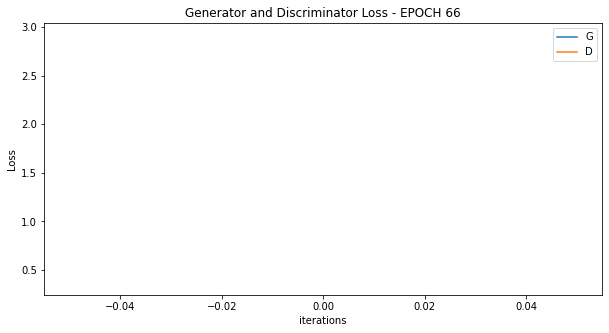

[66/100][643/644] Loss_D: 0.3703; Loss_G: 2.9162
[67/100][0/644] Loss_D: 0.3958; Loss_G: 5.8252
[67/100][1/644] Loss_D: 0.8957; Loss_G: 10.4174
[67/100][2/644] Loss_D: 1.2136; Loss_G: 2.2781
[67/100][3/644] Loss_D: 0.4172; Loss_G: 6.2493
[67/100][4/644] Loss_D: 0.3055; Loss_G: 8.2709
[67/100][5/644] Loss_D: 0.6184; Loss_G: 5.5740
[67/100][6/644] Loss_D: 0.1462; Loss_G: 4.8185
[67/100][7/644] Loss_D: 0.0919; Loss_G: 6.4381
[67/100][8/644] Loss_D: 0.4449; Loss_G: 7.5495
[67/100][9/644] Loss_D: 0.0902; Loss_G: 6.7449
[67/100][10/644] Loss_D: 0.4224; Loss_G: 4.3147
[67/100][11/644] Loss_D: 0.2807; Loss_G: 4.8602
[67/100][12/644] Loss_D: 0.0949; Loss_G: 6.5980
[67/100][13/644] Loss_D: 0.1222; Loss_G: 6.2194
[67/100][14/644] Loss_D: 0.1330; Loss_G: 5.7920
[67/100][15/644] Loss_D: 0.2513; Loss_G: 4.8591
[67/100][16/644] Loss_D: 0.0585; Loss_G: 5.8008
[67/100][17/644] Loss_D: 0.0850; Loss_G: 5.6238
[67/100][18/644] Loss_D: 0.1085; Loss_G: 5.5417
[67/100][19/644] Loss_D: 0.0928; Loss_G: 5.1367


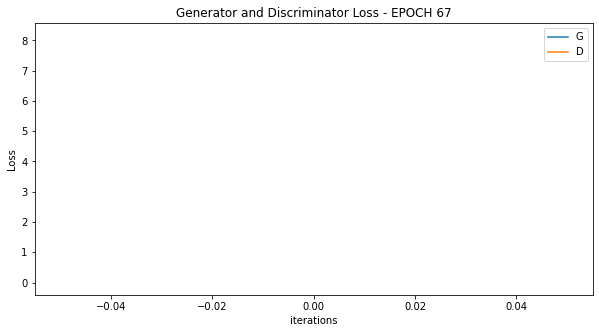

[67/100][321/644] Loss_D: 0.0043; Loss_G: 8.1652
[67/100][322/644] Loss_D: 0.1055; Loss_G: 6.2909
[67/100][323/644] Loss_D: 0.0241; Loss_G: 5.3555
[67/100][324/644] Loss_D: 0.0321; Loss_G: 5.8041
[67/100][325/644] Loss_D: 0.1026; Loss_G: 6.5137
[67/100][326/644] Loss_D: 0.1692; Loss_G: 8.3206
[67/100][327/644] Loss_D: 0.1782; Loss_G: 6.5104
[67/100][328/644] Loss_D: 0.1882; Loss_G: 4.5022
[67/100][329/644] Loss_D: 0.0412; Loss_G: 4.9300
[67/100][330/644] Loss_D: 0.1229; Loss_G: 5.9497
[67/100][331/644] Loss_D: 0.1842; Loss_G: 6.7629
[67/100][332/644] Loss_D: 0.0393; Loss_G: 6.9978
[67/100][333/644] Loss_D: 0.0543; Loss_G: 7.3461
[67/100][334/644] Loss_D: 0.0951; Loss_G: 4.7110
[67/100][335/644] Loss_D: 0.1875; Loss_G: 3.8447
[67/100][336/644] Loss_D: 0.1230; Loss_G: 5.4048
[67/100][337/644] Loss_D: 0.2666; Loss_G: 8.4916
[67/100][338/644] Loss_D: 0.2937; Loss_G: 4.2477
[67/100][339/644] Loss_D: 0.0810; Loss_G: 6.2760
[67/100][340/644] Loss_D: 0.0622; Loss_G: 5.0585
[67/100][341/644] Lo

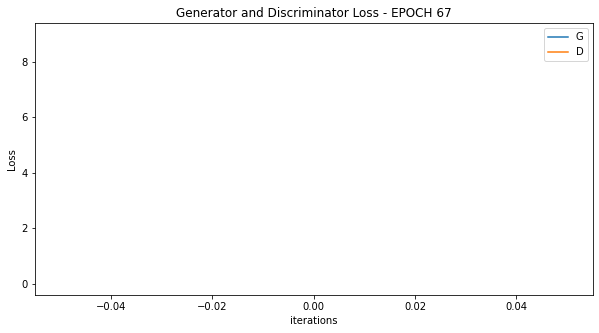

[67/100][643/644] Loss_D: 0.0512; Loss_G: 8.9434
[68/100][0/644] Loss_D: 0.1096; Loss_G: 6.1362
[68/100][1/644] Loss_D: 0.2589; Loss_G: 3.7411
[68/100][2/644] Loss_D: 0.5044; Loss_G: 5.5573
[68/100][3/644] Loss_D: 0.1409; Loss_G: 6.6186
[68/100][4/644] Loss_D: 0.1429; Loss_G: 6.2600
[68/100][5/644] Loss_D: 1.6666; Loss_G: 1.0784
[68/100][6/644] Loss_D: 3.2852; Loss_G: 19.5987
[68/100][7/644] Loss_D: 1.3425; Loss_G: 3.3895
[68/100][8/644] Loss_D: 0.7135; Loss_G: 7.6769
[68/100][9/644] Loss_D: 0.6598; Loss_G: 2.8134
[68/100][10/644] Loss_D: 1.1298; Loss_G: 15.1292
[68/100][11/644] Loss_D: 1.5289; Loss_G: 2.6419
[68/100][12/644] Loss_D: 0.3468; Loss_G: 6.5522
[68/100][13/644] Loss_D: 0.1852; Loss_G: 8.0070
[68/100][14/644] Loss_D: 0.3102; Loss_G: 4.1103
[68/100][15/644] Loss_D: 0.2140; Loss_G: 5.3546
[68/100][16/644] Loss_D: 0.1474; Loss_G: 6.4070
[68/100][17/644] Loss_D: 0.1174; Loss_G: 6.6985
[68/100][18/644] Loss_D: 0.1421; Loss_G: 6.1584
[68/100][19/644] Loss_D: 0.1764; Loss_G: 4.9214

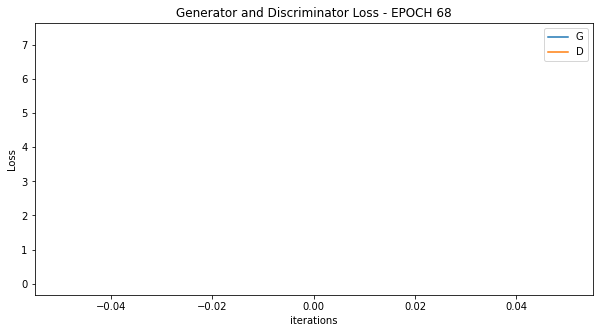

[68/100][321/644] Loss_D: 0.0351; Loss_G: 7.2825
[68/100][322/644] Loss_D: 0.9569; Loss_G: 4.1290
[68/100][323/644] Loss_D: 0.1280; Loss_G: 4.3997
[68/100][324/644] Loss_D: 0.4427; Loss_G: 9.4304
[68/100][325/644] Loss_D: 0.4668; Loss_G: 5.8750
[68/100][326/644] Loss_D: 0.2645; Loss_G: 5.1411
[68/100][327/644] Loss_D: 0.0413; Loss_G: 6.5232
[68/100][328/644] Loss_D: 0.2363; Loss_G: 6.9610
[68/100][329/644] Loss_D: 0.1065; Loss_G: 5.3918
[68/100][330/644] Loss_D: 0.0671; Loss_G: 6.0326
[68/100][331/644] Loss_D: 0.0666; Loss_G: 6.0783
[68/100][332/644] Loss_D: 0.1664; Loss_G: 6.2257
[68/100][333/644] Loss_D: 0.1618; Loss_G: 6.2711
[68/100][334/644] Loss_D: 0.1663; Loss_G: 6.4527
[68/100][335/644] Loss_D: 0.1847; Loss_G: 5.2550
[68/100][336/644] Loss_D: 0.1084; Loss_G: 4.9412
[68/100][337/644] Loss_D: 0.0262; Loss_G: 5.8965
[68/100][338/644] Loss_D: 0.0514; Loss_G: 6.2598
[68/100][339/644] Loss_D: 0.0377; Loss_G: 5.2806
[68/100][340/644] Loss_D: 0.1267; Loss_G: 6.2909
[68/100][341/644] Lo

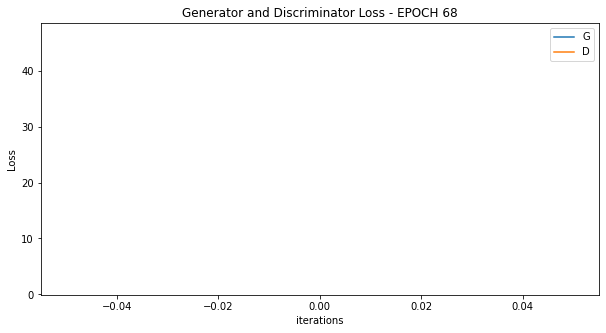

[68/100][643/644] Loss_D: 2.1459; Loss_G: 46.2909
[69/100][0/644] Loss_D: 3.9713; Loss_G: 0.0731
[69/100][1/644] Loss_D: 5.7137; Loss_G: 15.7132
[69/100][2/644] Loss_D: 4.3433; Loss_G: 1.5353
[69/100][3/644] Loss_D: 1.3997; Loss_G: 11.5033
[69/100][4/644] Loss_D: 1.3797; Loss_G: 6.2439
[69/100][5/644] Loss_D: 1.6969; Loss_G: 1.1537
[69/100][6/644] Loss_D: 2.5238; Loss_G: 12.9591
[69/100][7/644] Loss_D: 1.7526; Loss_G: 2.8551
[69/100][8/644] Loss_D: 1.6008; Loss_G: 11.0604
[69/100][9/644] Loss_D: 0.3198; Loss_G: 9.7796
[69/100][10/644] Loss_D: 0.1697; Loss_G: 6.0356
[69/100][11/644] Loss_D: 0.5270; Loss_G: 4.9451
[69/100][12/644] Loss_D: 0.4601; Loss_G: 9.4019
[69/100][13/644] Loss_D: 0.4405; Loss_G: 5.3580
[69/100][14/644] Loss_D: 0.2142; Loss_G: 4.9868
[69/100][15/644] Loss_D: 0.1972; Loss_G: 5.0277
[69/100][16/644] Loss_D: 0.3377; Loss_G: 6.6806
[69/100][17/644] Loss_D: 0.2706; Loss_G: 6.6076
[69/100][18/644] Loss_D: 0.3179; Loss_G: 4.6404
[69/100][19/644] Loss_D: 0.3128; Loss_G: 5.5

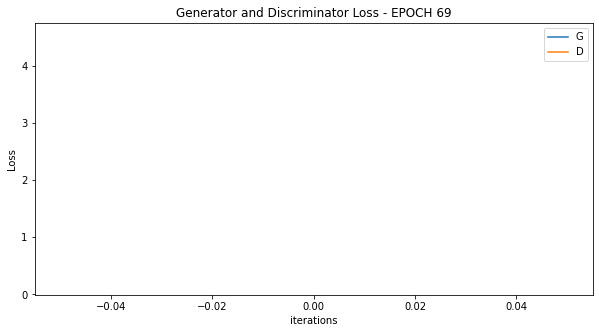

[69/100][321/644] Loss_D: 0.2081; Loss_G: 4.5389
[69/100][322/644] Loss_D: 0.9001; Loss_G: 0.7483
[69/100][323/644] Loss_D: 1.2689; Loss_G: 11.0768
[69/100][324/644] Loss_D: 0.0273; Loss_G: 8.8262
[69/100][325/644] Loss_D: 0.1675; Loss_G: 6.0232
[69/100][326/644] Loss_D: 0.1837; Loss_G: 5.8983
[69/100][327/644] Loss_D: 0.1981; Loss_G: 4.6498
[69/100][328/644] Loss_D: 0.1225; Loss_G: 5.1756
[69/100][329/644] Loss_D: 0.1303; Loss_G: 5.8549
[69/100][330/644] Loss_D: 0.2004; Loss_G: 7.3543
[69/100][331/644] Loss_D: 0.1227; Loss_G: 8.0085
[69/100][332/644] Loss_D: 0.0468; Loss_G: 7.0711
[69/100][333/644] Loss_D: 0.1826; Loss_G: 5.2510
[69/100][334/644] Loss_D: 0.0467; Loss_G: 5.1123
[69/100][335/644] Loss_D: 0.0417; Loss_G: 5.4708
[69/100][336/644] Loss_D: 0.0473; Loss_G: 6.8206
[69/100][337/644] Loss_D: 0.0947; Loss_G: 5.9126
[69/100][338/644] Loss_D: 0.0749; Loss_G: 5.7557
[69/100][339/644] Loss_D: 0.2056; Loss_G: 4.3577
[69/100][340/644] Loss_D: 0.0517; Loss_G: 5.4032
[69/100][341/644] L

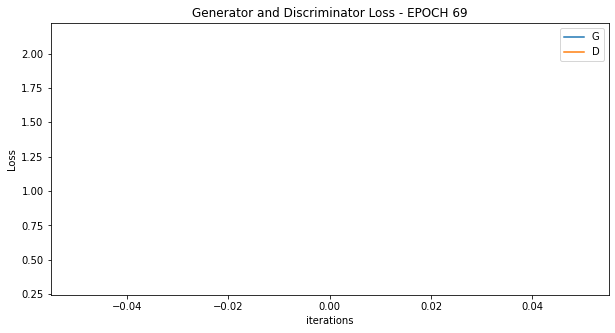

[69/100][643/644] Loss_D: 0.3342; Loss_G: 2.1328
[70/100][0/644] Loss_D: 2.5488; Loss_G: 16.1117
[70/100][1/644] Loss_D: 0.2733; Loss_G: 8.9305
[70/100][2/644] Loss_D: 1.1245; Loss_G: 4.3220
[70/100][3/644] Loss_D: 0.1481; Loss_G: 4.1218
[70/100][4/644] Loss_D: 1.4164; Loss_G: 15.2096
[70/100][5/644] Loss_D: 2.3068; Loss_G: 2.6601
[70/100][6/644] Loss_D: 0.4610; Loss_G: 6.8957
[70/100][7/644] Loss_D: 0.3167; Loss_G: 9.2084
[70/100][8/644] Loss_D: 0.1635; Loss_G: 7.0430
[70/100][9/644] Loss_D: 0.0588; Loss_G: 6.6959
[70/100][10/644] Loss_D: 0.0877; Loss_G: 5.2676
[70/100][11/644] Loss_D: 0.0614; Loss_G: 6.0044
[70/100][12/644] Loss_D: 0.1272; Loss_G: 5.1437
[70/100][13/644] Loss_D: 0.3751; Loss_G: 3.5380
[70/100][14/644] Loss_D: 0.5515; Loss_G: 10.2660
[70/100][15/644] Loss_D: 1.3149; Loss_G: 1.7566
[70/100][16/644] Loss_D: 0.7662; Loss_G: 9.4142
[70/100][17/644] Loss_D: 0.2878; Loss_G: 6.5036
[70/100][18/644] Loss_D: 0.4100; Loss_G: 7.9117
[70/100][19/644] Loss_D: 0.2049; Loss_G: 6.229

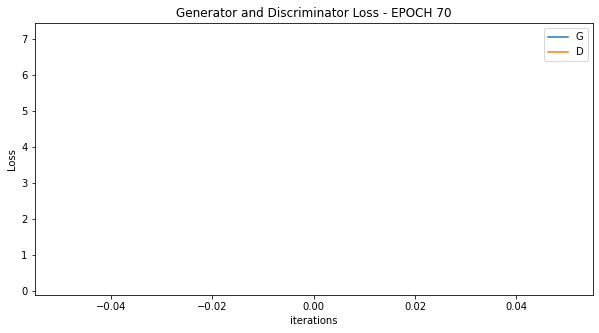

[70/100][321/644] Loss_D: 0.2259; Loss_G: 7.0929
[70/100][322/644] Loss_D: 0.1773; Loss_G: 6.4318
[70/100][323/644] Loss_D: 0.0160; Loss_G: 6.9434
[70/100][324/644] Loss_D: 0.0223; Loss_G: 6.3866
[70/100][325/644] Loss_D: 0.0149; Loss_G: 7.5139
[70/100][326/644] Loss_D: 0.1175; Loss_G: 4.9039
[70/100][327/644] Loss_D: 0.1330; Loss_G: 5.6968
[70/100][328/644] Loss_D: 0.1440; Loss_G: 6.8462
[70/100][329/644] Loss_D: 0.0902; Loss_G: 5.2763
[70/100][330/644] Loss_D: 0.0709; Loss_G: 5.0118
[70/100][331/644] Loss_D: 0.0302; Loss_G: 6.2842
[70/100][332/644] Loss_D: 0.0293; Loss_G: 5.6846
[70/100][333/644] Loss_D: 0.3855; Loss_G: 9.3458
[70/100][334/644] Loss_D: 0.0617; Loss_G: 7.9649
[70/100][335/644] Loss_D: 0.1975; Loss_G: 6.5245
[70/100][336/644] Loss_D: 0.0401; Loss_G: 4.9737
[70/100][337/644] Loss_D: 0.3258; Loss_G: 1.9364
[70/100][338/644] Loss_D: 1.0809; Loss_G: 15.1167
[70/100][339/644] Loss_D: 0.6367; Loss_G: 7.5476
[70/100][340/644] Loss_D: 0.1827; Loss_G: 3.3135
[70/100][341/644] L

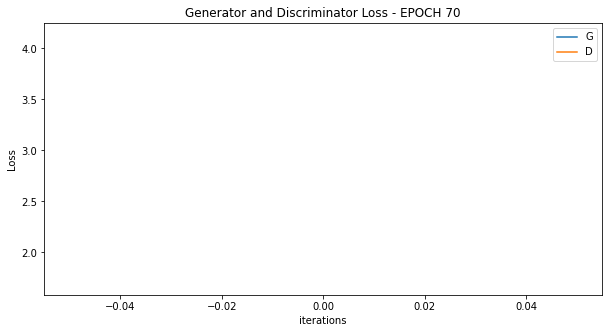

[70/100][643/644] Loss_D: 1.7058; Loss_G: 4.1277
[71/100][0/644] Loss_D: 5.7958; Loss_G: 15.1412
[71/100][1/644] Loss_D: 4.8769; Loss_G: 0.0003
[71/100][2/644] Loss_D: 51.6449; Loss_G: 2.1968
[71/100][3/644] Loss_D: 4.1068; Loss_G: 25.4978
[71/100][4/644] Loss_D: 19.7519; Loss_G: 1.8720
[71/100][5/644] Loss_D: 2.0821; Loss_G: 1.8968
[71/100][6/644] Loss_D: 8.5037; Loss_G: 19.9409
[71/100][7/644] Loss_D: 11.0069; Loss_G: 6.7966
[71/100][8/644] Loss_D: 9.3975; Loss_G: 0.1213
[71/100][9/644] Loss_D: 6.7496; Loss_G: 11.0761
[71/100][10/644] Loss_D: 3.3338; Loss_G: 4.6488
[71/100][11/644] Loss_D: 2.3241; Loss_G: 0.3746
[71/100][12/644] Loss_D: 3.6589; Loss_G: 9.7145
[71/100][13/644] Loss_D: 1.8786; Loss_G: 5.8570
[71/100][14/644] Loss_D: 1.1043; Loss_G: 4.6166
[71/100][15/644] Loss_D: 0.6216; Loss_G: 4.7249
[71/100][16/644] Loss_D: 0.7469; Loss_G: 5.1831
[71/100][17/644] Loss_D: 1.1349; Loss_G: 3.1562
[71/100][18/644] Loss_D: 1.7870; Loss_G: 11.3893
[71/100][19/644] Loss_D: 1.1307; Loss_G: 

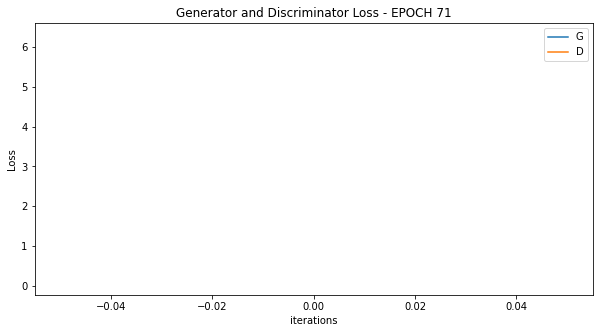

[71/100][321/644] Loss_D: 0.0845; Loss_G: 6.2923
[71/100][322/644] Loss_D: 0.2258; Loss_G: 7.4603
[71/100][323/644] Loss_D: 0.0580; Loss_G: 8.6520
[71/100][324/644] Loss_D: 0.3566; Loss_G: 3.3261
[71/100][325/644] Loss_D: 0.0837; Loss_G: 4.1064
[71/100][326/644] Loss_D: 0.5726; Loss_G: 8.7488
[71/100][327/644] Loss_D: 0.0962; Loss_G: 6.8366
[71/100][328/644] Loss_D: 0.4537; Loss_G: 4.1400
[71/100][329/644] Loss_D: 0.1487; Loss_G: 4.2842
[71/100][330/644] Loss_D: 0.1239; Loss_G: 5.8235
[71/100][331/644] Loss_D: 0.0618; Loss_G: 6.1919
[71/100][332/644] Loss_D: 0.0576; Loss_G: 5.5555
[71/100][333/644] Loss_D: 0.0317; Loss_G: 6.5058
[71/100][334/644] Loss_D: 0.0992; Loss_G: 6.3966
[71/100][335/644] Loss_D: 0.5175; Loss_G: 3.2176
[71/100][336/644] Loss_D: 0.1907; Loss_G: 5.9964
[71/100][337/644] Loss_D: 0.1379; Loss_G: 6.6116
[71/100][338/644] Loss_D: 0.1002; Loss_G: 6.9278
[71/100][339/644] Loss_D: 0.1056; Loss_G: 5.2423
[71/100][340/644] Loss_D: 0.1820; Loss_G: 4.6630
[71/100][341/644] Lo

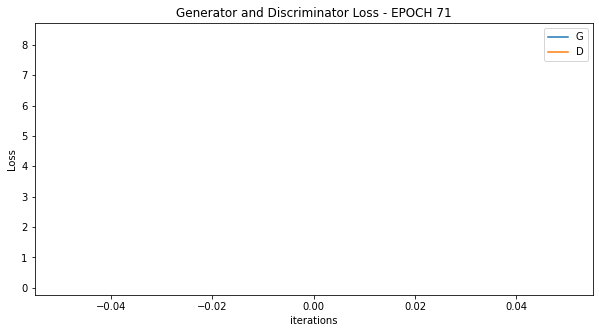

[71/100][643/644] Loss_D: 0.1726; Loss_G: 8.3105
[72/100][0/644] Loss_D: 0.0304; Loss_G: 4.9271
[72/100][1/644] Loss_D: 0.0634; Loss_G: 5.9542
[72/100][2/644] Loss_D: 0.1126; Loss_G: 6.1898
[72/100][3/644] Loss_D: 0.0363; Loss_G: 6.5130
[72/100][4/644] Loss_D: 0.1142; Loss_G: 6.1860
[72/100][5/644] Loss_D: 0.1988; Loss_G: 4.1127
[72/100][6/644] Loss_D: 0.0720; Loss_G: 5.4913
[72/100][7/644] Loss_D: 0.1835; Loss_G: 4.8609
[72/100][8/644] Loss_D: 0.0809; Loss_G: 6.2781
[72/100][9/644] Loss_D: 0.0249; Loss_G: 6.4669
[72/100][10/644] Loss_D: 0.0180; Loss_G: 6.4581
[72/100][11/644] Loss_D: 0.0515; Loss_G: 6.4985
[72/100][12/644] Loss_D: 0.1162; Loss_G: 4.6076
[72/100][13/644] Loss_D: 0.0498; Loss_G: 4.6985
[72/100][14/644] Loss_D: 0.0817; Loss_G: 6.5197
[72/100][15/644] Loss_D: 0.0499; Loss_G: 5.9695
[72/100][16/644] Loss_D: 0.1118; Loss_G: 6.5156
[72/100][17/644] Loss_D: 0.2099; Loss_G: 6.2425
[72/100][18/644] Loss_D: 0.0403; Loss_G: 5.6892
[72/100][19/644] Loss_D: 0.0398; Loss_G: 5.5579
[

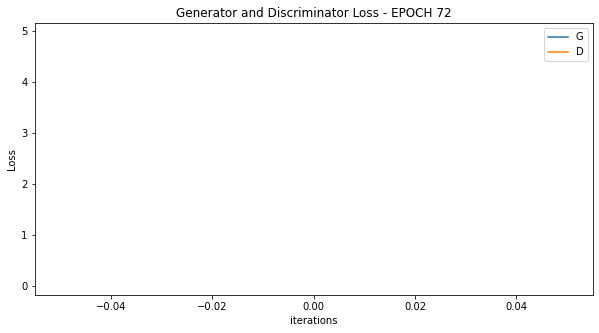

[72/100][321/644] Loss_D: 0.0638; Loss_G: 4.9082
[72/100][322/644] Loss_D: 0.2722; Loss_G: 9.0927
[72/100][323/644] Loss_D: 0.0232; Loss_G: 10.0714
[72/100][324/644] Loss_D: 0.4901; Loss_G: 3.2007
[72/100][325/644] Loss_D: 0.1003; Loss_G: 4.4010
[72/100][326/644] Loss_D: 0.7061; Loss_G: 12.7423
[72/100][327/644] Loss_D: 0.0695; Loss_G: 9.4435
[72/100][328/644] Loss_D: 0.4688; Loss_G: 4.7943
[72/100][329/644] Loss_D: 0.2300; Loss_G: 7.3707
[72/100][330/644] Loss_D: 0.0159; Loss_G: 7.4548
[72/100][331/644] Loss_D: 0.0212; Loss_G: 6.8210
[72/100][332/644] Loss_D: 0.3090; Loss_G: 3.7963
[72/100][333/644] Loss_D: 0.6716; Loss_G: 10.4895
[72/100][334/644] Loss_D: 0.0244; Loss_G: 10.5287
[72/100][335/644] Loss_D: 0.2660; Loss_G: 5.5256
[72/100][336/644] Loss_D: 0.0289; Loss_G: 4.9775
[72/100][337/644] Loss_D: 0.1261; Loss_G: 6.1140
[72/100][338/644] Loss_D: 0.0167; Loss_G: 6.7507
[72/100][339/644] Loss_D: 0.0219; Loss_G: 7.3051
[72/100][340/644] Loss_D: 0.1024; Loss_G: 7.2020
[72/100][341/644

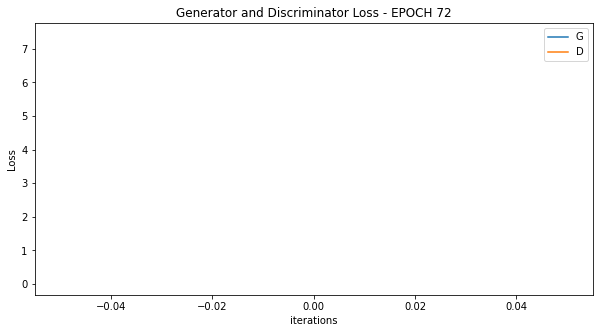

[72/100][643/644] Loss_D: 0.0469; Loss_G: 7.3969
[73/100][0/644] Loss_D: 0.1061; Loss_G: 4.9785
[73/100][1/644] Loss_D: 0.1979; Loss_G: 5.3045
[73/100][2/644] Loss_D: 0.0884; Loss_G: 6.0524
[73/100][3/644] Loss_D: 0.0173; Loss_G: 7.1797
[73/100][4/644] Loss_D: 0.3316; Loss_G: 4.3360
[73/100][5/644] Loss_D: 0.1721; Loss_G: 5.4361
[73/100][6/644] Loss_D: 0.1049; Loss_G: 6.4589
[73/100][7/644] Loss_D: 0.0615; Loss_G: 5.9779
[73/100][8/644] Loss_D: 0.0381; Loss_G: 5.7659
[73/100][9/644] Loss_D: 0.0675; Loss_G: 6.3134
[73/100][10/644] Loss_D: 0.0182; Loss_G: 6.7432
[73/100][11/644] Loss_D: 0.0232; Loss_G: 7.0981
[73/100][12/644] Loss_D: 0.0255; Loss_G: 6.4222
[73/100][13/644] Loss_D: 0.0104; Loss_G: 7.5042
[73/100][14/644] Loss_D: 0.0485; Loss_G: 5.4522
[73/100][15/644] Loss_D: 0.0144; Loss_G: 6.0027
[73/100][16/644] Loss_D: 0.0549; Loss_G: 5.3421
[73/100][17/644] Loss_D: 0.3467; Loss_G: 4.2600
[73/100][18/644] Loss_D: 0.4568; Loss_G: 6.9710
[73/100][19/644] Loss_D: 0.2627; Loss_G: 7.7931
[

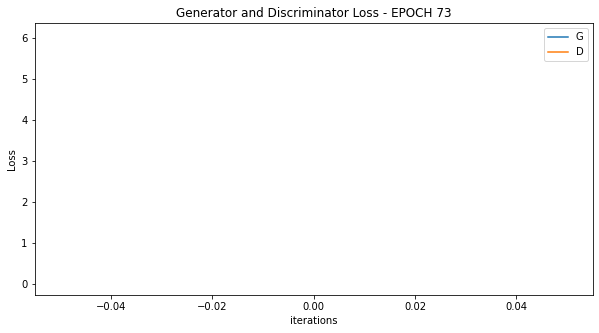

[73/100][321/644] Loss_D: 0.0301; Loss_G: 6.0647
[73/100][322/644] Loss_D: 0.0813; Loss_G: 6.3250
[73/100][323/644] Loss_D: 0.0484; Loss_G: 6.2189
[73/100][324/644] Loss_D: 0.0413; Loss_G: 5.6263
[73/100][325/644] Loss_D: 0.0232; Loss_G: 6.1439
[73/100][326/644] Loss_D: 0.1681; Loss_G: 4.0346
[73/100][327/644] Loss_D: 0.4114; Loss_G: 11.3698
[73/100][328/644] Loss_D: 0.2417; Loss_G: 9.5067
[73/100][329/644] Loss_D: 0.1708; Loss_G: 5.1456
[73/100][330/644] Loss_D: 0.0745; Loss_G: 4.4302
[73/100][331/644] Loss_D: 0.0617; Loss_G: 5.1159
[73/100][332/644] Loss_D: 0.0542; Loss_G: 6.6852
[73/100][333/644] Loss_D: 0.0603; Loss_G: 6.1639
[73/100][334/644] Loss_D: 0.0619; Loss_G: 5.4305
[73/100][335/644] Loss_D: 0.0653; Loss_G: 5.1217
[73/100][336/644] Loss_D: 0.0178; Loss_G: 5.9168
[73/100][337/644] Loss_D: 0.0478; Loss_G: 5.7778
[73/100][338/644] Loss_D: 0.0740; Loss_G: 6.0462
[73/100][339/644] Loss_D: 0.0672; Loss_G: 5.4633
[73/100][340/644] Loss_D: 0.0236; Loss_G: 7.2289
[73/100][341/644] L

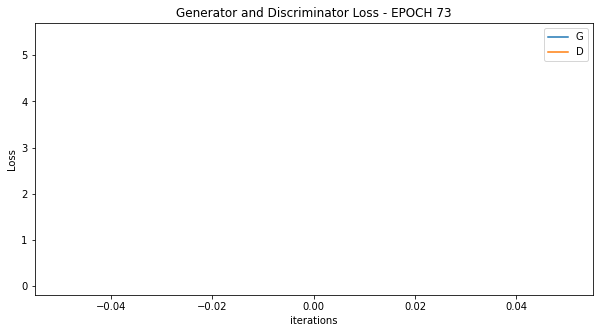

[73/100][643/644] Loss_D: 0.0806; Loss_G: 5.4315
[74/100][0/644] Loss_D: 0.4551; Loss_G: 10.4351
[74/100][1/644] Loss_D: 0.0384; Loss_G: 8.5744
[74/100][2/644] Loss_D: 0.3053; Loss_G: 6.1582
[74/100][3/644] Loss_D: 0.0036; Loss_G: 6.5724
[74/100][4/644] Loss_D: 0.0113; Loss_G: 5.9368
[74/100][5/644] Loss_D: 0.0358; Loss_G: 5.7460
[74/100][6/644] Loss_D: 0.0937; Loss_G: 7.1281
[74/100][7/644] Loss_D: 0.1022; Loss_G: 7.1076
[74/100][8/644] Loss_D: 0.0456; Loss_G: 5.6578
[74/100][9/644] Loss_D: 0.1291; Loss_G: 5.9956
[74/100][10/644] Loss_D: 0.0212; Loss_G: 6.9353
[74/100][11/644] Loss_D: 0.0202; Loss_G: 6.3777
[74/100][12/644] Loss_D: 0.1889; Loss_G: 5.0108
[74/100][13/644] Loss_D: 0.1260; Loss_G: 5.4950
[74/100][14/644] Loss_D: 0.1911; Loss_G: 7.8409
[74/100][15/644] Loss_D: 0.0098; Loss_G: 7.6245
[74/100][16/644] Loss_D: 0.0664; Loss_G: 7.2154
[74/100][17/644] Loss_D: 0.1037; Loss_G: 4.9955
[74/100][18/644] Loss_D: 0.0927; Loss_G: 7.0888
[74/100][19/644] Loss_D: 0.1238; Loss_G: 5.1065


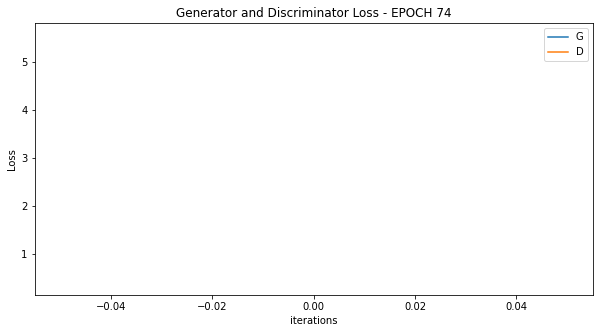

[74/100][321/644] Loss_D: 0.4080; Loss_G: 5.5588
[74/100][322/644] Loss_D: 0.2144; Loss_G: 5.3696
[74/100][323/644] Loss_D: 0.5116; Loss_G: 8.3795
[74/100][324/644] Loss_D: 0.2547; Loss_G: 6.2083
[74/100][325/644] Loss_D: 0.1996; Loss_G: 4.5344
[74/100][326/644] Loss_D: 0.4502; Loss_G: 6.3468
[74/100][327/644] Loss_D: 0.4026; Loss_G: 8.5443
[74/100][328/644] Loss_D: 0.2846; Loss_G: 6.5070
[74/100][329/644] Loss_D: 0.5353; Loss_G: 2.6050
[74/100][330/644] Loss_D: 0.9647; Loss_G: 9.6943
[74/100][331/644] Loss_D: 0.1157; Loss_G: 8.2971
[74/100][332/644] Loss_D: 0.1280; Loss_G: 6.6205
[74/100][333/644] Loss_D: 0.0272; Loss_G: 8.7415
[74/100][334/644] Loss_D: 0.1990; Loss_G: 6.0072
[74/100][335/644] Loss_D: 0.2085; Loss_G: 6.4916
[74/100][336/644] Loss_D: 0.3258; Loss_G: 4.4688
[74/100][337/644] Loss_D: 0.3942; Loss_G: 3.6004
[74/100][338/644] Loss_D: 0.2575; Loss_G: 5.2942
[74/100][339/644] Loss_D: 0.1241; Loss_G: 6.7418
[74/100][340/644] Loss_D: 0.2777; Loss_G: 7.9874
[74/100][341/644] Lo

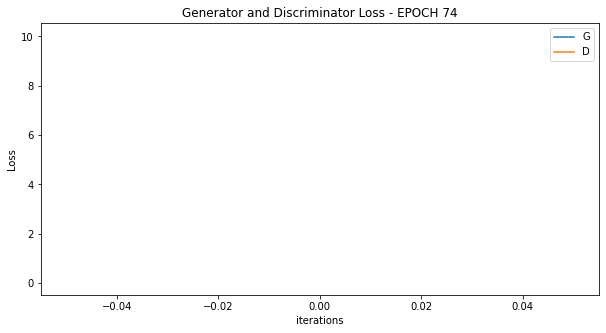

[74/100][643/644] Loss_D: 0.0210; Loss_G: 10.0428
[75/100][0/644] Loss_D: 0.2288; Loss_G: 4.3750
[75/100][1/644] Loss_D: 0.2377; Loss_G: 5.3211
[75/100][2/644] Loss_D: 0.0893; Loss_G: 5.3699
[75/100][3/644] Loss_D: 0.1835; Loss_G: 4.4219
[75/100][4/644] Loss_D: 0.1573; Loss_G: 5.9258
[75/100][5/644] Loss_D: 0.1070; Loss_G: 6.6601
[75/100][6/644] Loss_D: 0.2168; Loss_G: 5.6494
[75/100][7/644] Loss_D: 0.0219; Loss_G: 6.0195
[75/100][8/644] Loss_D: 0.0485; Loss_G: 6.3896
[75/100][9/644] Loss_D: 0.0691; Loss_G: 6.1319
[75/100][10/644] Loss_D: 0.0151; Loss_G: 5.9261
[75/100][11/644] Loss_D: 0.0380; Loss_G: 6.0853
[75/100][12/644] Loss_D: 0.0673; Loss_G: 5.8745
[75/100][13/644] Loss_D: 0.3321; Loss_G: 2.3576
[75/100][14/644] Loss_D: 0.2110; Loss_G: 5.5389
[75/100][15/644] Loss_D: 0.1126; Loss_G: 7.3552
[75/100][16/644] Loss_D: 0.0059; Loss_G: 8.6675
[75/100][17/644] Loss_D: 0.0250; Loss_G: 6.8912
[75/100][18/644] Loss_D: 0.1111; Loss_G: 8.2317
[75/100][19/644] Loss_D: 0.0256; Loss_G: 6.0796


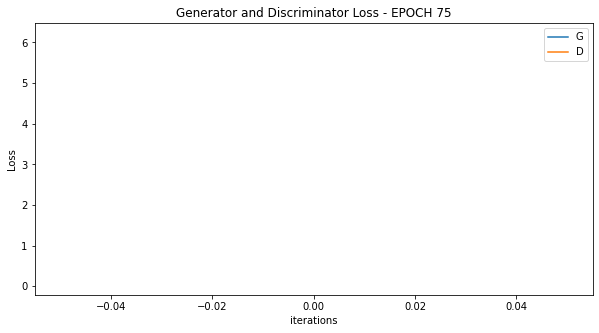

[75/100][321/644] Loss_D: 0.0944; Loss_G: 6.1713
[75/100][322/644] Loss_D: 0.0464; Loss_G: 6.6555
[75/100][323/644] Loss_D: 0.2669; Loss_G: 6.0248
[75/100][324/644] Loss_D: 0.0448; Loss_G: 6.9328
[75/100][325/644] Loss_D: 0.0287; Loss_G: 6.0666
[75/100][326/644] Loss_D: 0.0940; Loss_G: 5.5264
[75/100][327/644] Loss_D: 0.0673; Loss_G: 5.7240
[75/100][328/644] Loss_D: 0.1084; Loss_G: 5.1355
[75/100][329/644] Loss_D: 0.0664; Loss_G: 6.2863
[75/100][330/644] Loss_D: 0.0252; Loss_G: 7.2035
[75/100][331/644] Loss_D: 0.0741; Loss_G: 5.1098
[75/100][332/644] Loss_D: 0.0490; Loss_G: 5.9444
[75/100][333/644] Loss_D: 0.0683; Loss_G: 5.3438
[75/100][334/644] Loss_D: 0.1235; Loss_G: 6.4217
[75/100][335/644] Loss_D: 0.0364; Loss_G: 7.7615
[75/100][336/644] Loss_D: 0.1035; Loss_G: 5.2793
[75/100][337/644] Loss_D: 0.1975; Loss_G: 6.5911
[75/100][338/644] Loss_D: 0.0944; Loss_G: 6.3703
[75/100][339/644] Loss_D: 0.1184; Loss_G: 5.2553
[75/100][340/644] Loss_D: 0.1189; Loss_G: 6.3341
[75/100][341/644] Lo

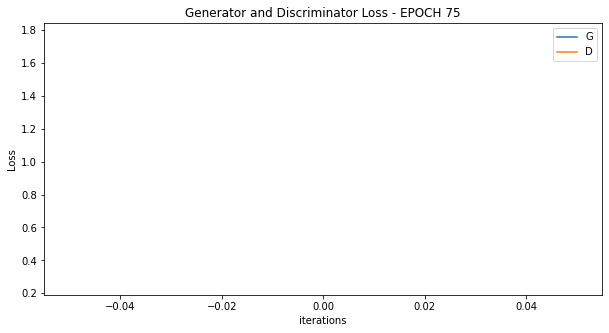

[75/100][643/644] Loss_D: 1.7681; Loss_G: 0.2657
[76/100][0/644] Loss_D: 5.3465; Loss_G: 17.9175
[76/100][1/644] Loss_D: 1.2864; Loss_G: 2.2981
[76/100][2/644] Loss_D: 0.9770; Loss_G: 10.0855
[76/100][3/644] Loss_D: 0.3749; Loss_G: 5.9161
[76/100][4/644] Loss_D: 0.5895; Loss_G: 2.6570
[76/100][5/644] Loss_D: 0.7977; Loss_G: 11.4982
[76/100][6/644] Loss_D: 1.4061; Loss_G: 2.7606
[76/100][7/644] Loss_D: 0.8468; Loss_G: 11.4331
[76/100][8/644] Loss_D: 0.2142; Loss_G: 7.9722
[76/100][9/644] Loss_D: 1.1930; Loss_G: 2.7377
[76/100][10/644] Loss_D: 0.8067; Loss_G: 9.3089
[76/100][11/644] Loss_D: 0.3614; Loss_G: 5.3110
[76/100][12/644] Loss_D: 0.5204; Loss_G: 5.4342
[76/100][13/644] Loss_D: 0.4549; Loss_G: 4.7866
[76/100][14/644] Loss_D: 0.1551; Loss_G: 6.8452
[76/100][15/644] Loss_D: 0.7086; Loss_G: 5.0373
[76/100][16/644] Loss_D: 0.2582; Loss_G: 7.5999
[76/100][17/644] Loss_D: 0.3771; Loss_G: 4.4719
[76/100][18/644] Loss_D: 0.2156; Loss_G: 3.6064
[76/100][19/644] Loss_D: 1.1978; Loss_G: 13.5

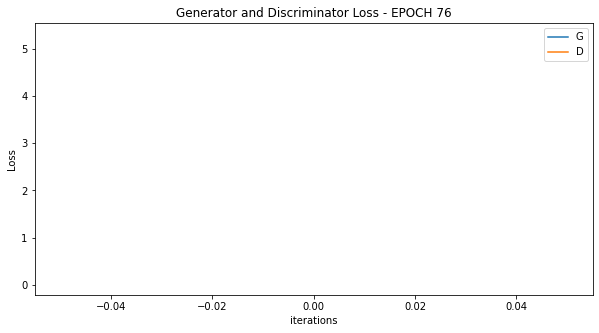

[76/100][321/644] Loss_D: 0.0521; Loss_G: 5.2800
[76/100][322/644] Loss_D: 0.0159; Loss_G: 6.3898
[76/100][323/644] Loss_D: 0.0762; Loss_G: 6.2591
[76/100][324/644] Loss_D: 0.0741; Loss_G: 6.0461
[76/100][325/644] Loss_D: 0.0186; Loss_G: 6.7831
[76/100][326/644] Loss_D: 0.0090; Loss_G: 7.3371
[76/100][327/644] Loss_D: 0.0715; Loss_G: 5.9046
[76/100][328/644] Loss_D: 0.1602; Loss_G: 4.5186
[76/100][329/644] Loss_D: 0.0801; Loss_G: 4.5475
[76/100][330/644] Loss_D: 0.3498; Loss_G: 9.0215
[76/100][331/644] Loss_D: 0.0366; Loss_G: 8.3512
[76/100][332/644] Loss_D: 0.3397; Loss_G: 7.5291
[76/100][333/644] Loss_D: 0.0909; Loss_G: 4.4266
[76/100][334/644] Loss_D: 0.1157; Loss_G: 5.8150
[76/100][335/644] Loss_D: 0.0844; Loss_G: 5.4690
[76/100][336/644] Loss_D: 0.0452; Loss_G: 6.2364
[76/100][337/644] Loss_D: 0.0456; Loss_G: 7.1898
[76/100][338/644] Loss_D: 0.0382; Loss_G: 6.6966
[76/100][339/644] Loss_D: 0.0833; Loss_G: 6.0954
[76/100][340/644] Loss_D: 0.1582; Loss_G: 5.0446
[76/100][341/644] Lo

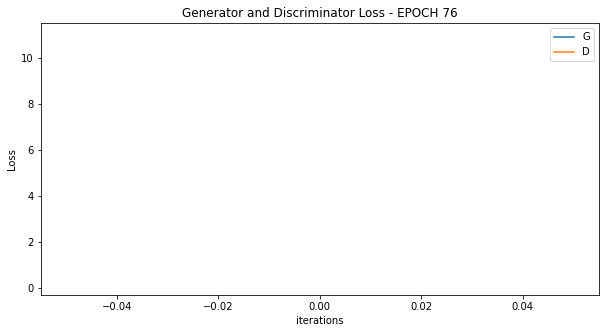

[76/100][643/644] Loss_D: 0.2285; Loss_G: 10.9918
[77/100][0/644] Loss_D: 0.6908; Loss_G: 1.4740
[77/100][1/644] Loss_D: 0.9015; Loss_G: 11.3283
[77/100][2/644] Loss_D: 0.2586; Loss_G: 6.2732
[77/100][3/644] Loss_D: 0.0700; Loss_G: 5.5666
[77/100][4/644] Loss_D: 0.0388; Loss_G: 5.7377
[77/100][5/644] Loss_D: 0.2336; Loss_G: 4.5500
[77/100][6/644] Loss_D: 0.0992; Loss_G: 5.6003
[77/100][7/644] Loss_D: 0.1396; Loss_G: 7.0958
[77/100][8/644] Loss_D: 0.1659; Loss_G: 8.3882
[77/100][9/644] Loss_D: 0.0708; Loss_G: 7.3779
[77/100][10/644] Loss_D: 0.3449; Loss_G: 5.0869
[77/100][11/644] Loss_D: 0.0314; Loss_G: 4.5399
[77/100][12/644] Loss_D: 0.5569; Loss_G: 9.5994
[77/100][13/644] Loss_D: 0.1058; Loss_G: 6.1297
[77/100][14/644] Loss_D: 0.0838; Loss_G: 6.3256
[77/100][15/644] Loss_D: 0.0877; Loss_G: 6.6746
[77/100][16/644] Loss_D: 0.0930; Loss_G: 7.3211
[77/100][17/644] Loss_D: 0.0545; Loss_G: 5.7418
[77/100][18/644] Loss_D: 0.0306; Loss_G: 5.7525
[77/100][19/644] Loss_D: 0.0363; Loss_G: 6.7191

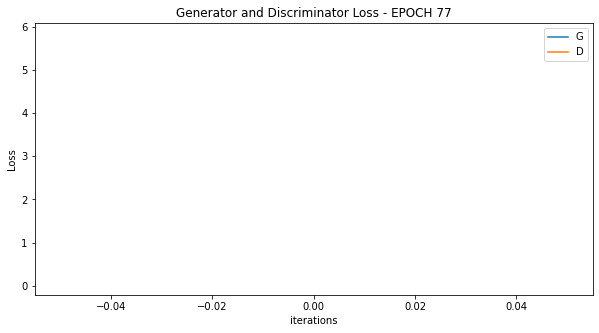

[77/100][321/644] Loss_D: 0.0742; Loss_G: 5.8023
[77/100][322/644] Loss_D: 0.0274; Loss_G: 7.3546
[77/100][323/644] Loss_D: 0.0553; Loss_G: 7.5181
[77/100][324/644] Loss_D: 0.1477; Loss_G: 6.3785
[77/100][325/644] Loss_D: 0.0609; Loss_G: 6.8186
[77/100][326/644] Loss_D: 0.0683; Loss_G: 5.2750
[77/100][327/644] Loss_D: 0.0385; Loss_G: 5.7769
[77/100][328/644] Loss_D: 0.0870; Loss_G: 5.3848
[77/100][329/644] Loss_D: 0.0784; Loss_G: 4.6756
[77/100][330/644] Loss_D: 0.0943; Loss_G: 5.7736
[77/100][331/644] Loss_D: 0.0113; Loss_G: 7.0652
[77/100][332/644] Loss_D: 0.0350; Loss_G: 7.0615
[77/100][333/644] Loss_D: 0.0938; Loss_G: 6.2480
[77/100][334/644] Loss_D: 0.0397; Loss_G: 6.3768
[77/100][335/644] Loss_D: 0.0294; Loss_G: 6.2753
[77/100][336/644] Loss_D: 0.0250; Loss_G: 6.2457
[77/100][337/644] Loss_D: 0.0128; Loss_G: 6.6986
[77/100][338/644] Loss_D: 0.0702; Loss_G: 5.5027
[77/100][339/644] Loss_D: 0.1028; Loss_G: 7.5394
[77/100][340/644] Loss_D: 0.0670; Loss_G: 5.5960
[77/100][341/644] Lo

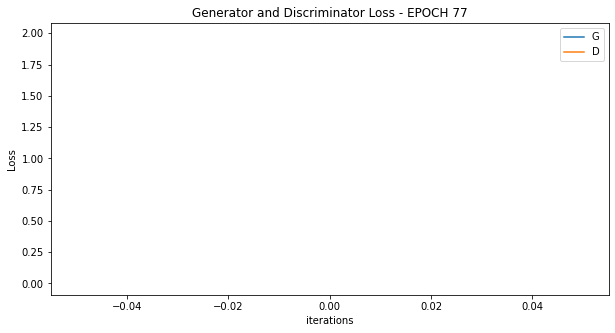

[77/100][643/644] Loss_D: 1.9830; Loss_G: 0.0080
[78/100][0/644] Loss_D: 8.6807; Loss_G: 14.3829
[78/100][1/644] Loss_D: 1.6399; Loss_G: 2.5739
[78/100][2/644] Loss_D: 1.0243; Loss_G: 0.1738
[78/100][3/644] Loss_D: 8.4451; Loss_G: 16.0239
[78/100][4/644] Loss_D: 3.1891; Loss_G: 1.6607
[78/100][5/644] Loss_D: 1.9289; Loss_G: 11.6464
[78/100][6/644] Loss_D: 1.5629; Loss_G: 1.8100
[78/100][7/644] Loss_D: 2.6651; Loss_G: 15.2650
[78/100][8/644] Loss_D: 1.8398; Loss_G: 6.0799
[78/100][9/644] Loss_D: 0.4684; Loss_G: 2.7926
[78/100][10/644] Loss_D: 1.5182; Loss_G: 11.3195
[78/100][11/644] Loss_D: 1.5697; Loss_G: 2.9759
[78/100][12/644] Loss_D: 1.0387; Loss_G: 2.2634
[78/100][13/644] Loss_D: 0.5317; Loss_G: 8.0124
[78/100][14/644] Loss_D: 0.3966; Loss_G: 9.1722
[78/100][15/644] Loss_D: 2.1324; Loss_G: 0.5035
[78/100][16/644] Loss_D: 2.5432; Loss_G: 13.5304
[78/100][17/644] Loss_D: 1.4589; Loss_G: 6.4288
[78/100][18/644] Loss_D: 0.2201; Loss_G: 6.3053
[78/100][19/644] Loss_D: 0.1017; Loss_G: 6.

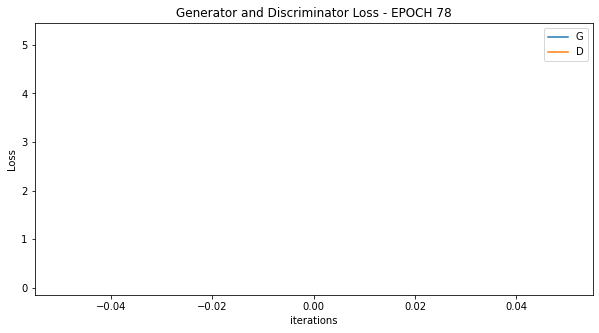

[78/100][321/644] Loss_D: 0.1102; Loss_G: 5.1947
[78/100][322/644] Loss_D: 0.1094; Loss_G: 5.5982
[78/100][323/644] Loss_D: 0.1005; Loss_G: 5.5486
[78/100][324/644] Loss_D: 0.0169; Loss_G: 6.8186
[78/100][325/644] Loss_D: 0.0794; Loss_G: 5.4576
[78/100][326/644] Loss_D: 0.0786; Loss_G: 5.0444
[78/100][327/644] Loss_D: 0.0249; Loss_G: 5.5772
[78/100][328/644] Loss_D: 0.0707; Loss_G: 5.8440
[78/100][329/644] Loss_D: 0.0465; Loss_G: 6.1938
[78/100][330/644] Loss_D: 0.0565; Loss_G: 7.0562
[78/100][331/644] Loss_D: 0.0499; Loss_G: 5.8770
[78/100][332/644] Loss_D: 0.0784; Loss_G: 6.1396
[78/100][333/644] Loss_D: 0.3704; Loss_G: 4.7027
[78/100][334/644] Loss_D: 0.1557; Loss_G: 4.1824
[78/100][335/644] Loss_D: 0.3035; Loss_G: 8.0815
[78/100][336/644] Loss_D: 0.0249; Loss_G: 8.7335
[78/100][337/644] Loss_D: 0.1117; Loss_G: 6.8836
[78/100][338/644] Loss_D: 0.0328; Loss_G: 6.6393
[78/100][339/644] Loss_D: 0.2119; Loss_G: 5.4076
[78/100][340/644] Loss_D: 0.0502; Loss_G: 3.7600
[78/100][341/644] Lo

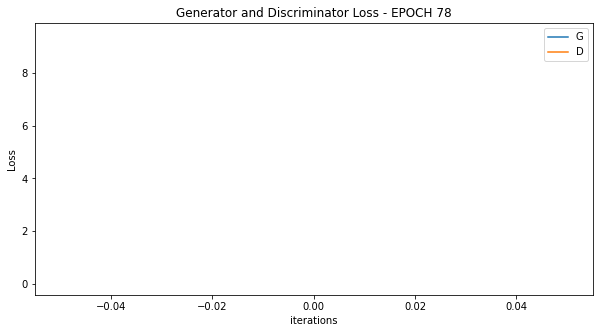

[78/100][643/644] Loss_D: 0.0543; Loss_G: 9.4186
[79/100][0/644] Loss_D: 0.0934; Loss_G: 6.6373
[79/100][1/644] Loss_D: 0.0605; Loss_G: 6.1587
[79/100][2/644] Loss_D: 0.3284; Loss_G: 2.9052
[79/100][3/644] Loss_D: 0.3404; Loss_G: 7.9199
[79/100][4/644] Loss_D: 0.0829; Loss_G: 6.2594
[79/100][5/644] Loss_D: 0.0794; Loss_G: 4.9291
[79/100][6/644] Loss_D: 0.7884; Loss_G: 1.3662
[79/100][7/644] Loss_D: 0.7743; Loss_G: 11.0389
[79/100][8/644] Loss_D: 0.2919; Loss_G: 5.4324
[79/100][9/644] Loss_D: 0.2005; Loss_G: 3.9177
[79/100][10/644] Loss_D: 0.0738; Loss_G: 5.2415
[79/100][11/644] Loss_D: 0.0757; Loss_G: 6.1196
[79/100][12/644] Loss_D: 0.0617; Loss_G: 6.2770
[79/100][13/644] Loss_D: 0.0314; Loss_G: 6.2344
[79/100][14/644] Loss_D: 0.0621; Loss_G: 5.4589
[79/100][15/644] Loss_D: 0.0343; Loss_G: 6.3601
[79/100][16/644] Loss_D: 0.0367; Loss_G: 6.3969
[79/100][17/644] Loss_D: 0.0066; Loss_G: 6.2351
[79/100][18/644] Loss_D: 0.4666; Loss_G: 2.4562
[79/100][19/644] Loss_D: 0.4530; Loss_G: 7.8295


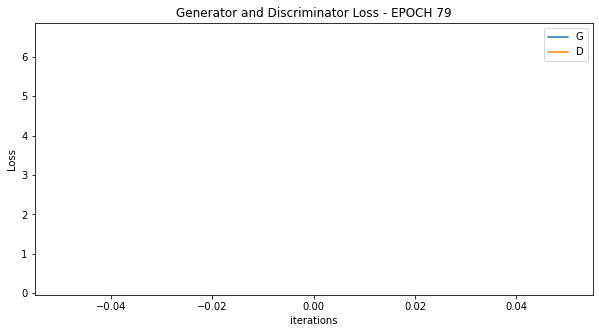

[79/100][321/644] Loss_D: 0.2704; Loss_G: 6.5426
[79/100][322/644] Loss_D: 0.0295; Loss_G: 4.2466
[79/100][323/644] Loss_D: 0.2072; Loss_G: 7.8927
[79/100][324/644] Loss_D: 0.0204; Loss_G: 6.8549
[79/100][325/644] Loss_D: 0.0948; Loss_G: 5.8787
[79/100][326/644] Loss_D: 0.0768; Loss_G: 6.4617
[79/100][327/644] Loss_D: 0.0779; Loss_G: 6.0966
[79/100][328/644] Loss_D: 0.1460; Loss_G: 5.7146
[79/100][329/644] Loss_D: 0.0250; Loss_G: 5.8853
[79/100][330/644] Loss_D: 0.0288; Loss_G: 5.8598
[79/100][331/644] Loss_D: 0.0396; Loss_G: 5.7251
[79/100][332/644] Loss_D: 0.0089; Loss_G: 7.3767
[79/100][333/644] Loss_D: 0.0500; Loss_G: 5.6268
[79/100][334/644] Loss_D: 0.0172; Loss_G: 7.5640
[79/100][335/644] Loss_D: 0.0942; Loss_G: 5.3411
[79/100][336/644] Loss_D: 0.1219; Loss_G: 7.0312
[79/100][337/644] Loss_D: 0.0592; Loss_G: 6.8873
[79/100][338/644] Loss_D: 0.0409; Loss_G: 6.4132
[79/100][339/644] Loss_D: 0.0222; Loss_G: 6.9444
[79/100][340/644] Loss_D: 0.0629; Loss_G: 5.0605
[79/100][341/644] Lo

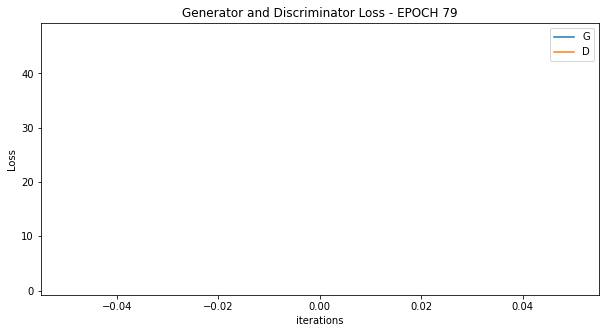

[79/100][643/644] Loss_D: 1.4958; Loss_G: 47.0109
[80/100][0/644] Loss_D: 0.4837; Loss_G: 5.4906
[80/100][1/644] Loss_D: 0.5155; Loss_G: 3.3636
[80/100][2/644] Loss_D: 0.3123; Loss_G: 4.6988
[80/100][3/644] Loss_D: 0.8389; Loss_G: 14.4097
[80/100][4/644] Loss_D: 2.9033; Loss_G: 1.9937
[80/100][5/644] Loss_D: 1.1759; Loss_G: 8.7631
[80/100][6/644] Loss_D: 0.3153; Loss_G: 9.3569
[80/100][7/644] Loss_D: 0.6298; Loss_G: 5.4780
[80/100][8/644] Loss_D: 0.6723; Loss_G: 11.5719
[80/100][9/644] Loss_D: 0.3553; Loss_G: 9.7968
[80/100][10/644] Loss_D: 0.4336; Loss_G: 4.5709
[80/100][11/644] Loss_D: 0.1860; Loss_G: 5.7100
[80/100][12/644] Loss_D: 0.1040; Loss_G: 5.8701
[80/100][13/644] Loss_D: 0.3077; Loss_G: 8.6661
[80/100][14/644] Loss_D: 0.1033; Loss_G: 8.0280
[80/100][15/644] Loss_D: 0.2580; Loss_G: 5.0196
[80/100][16/644] Loss_D: 0.1565; Loss_G: 4.6624
[80/100][17/644] Loss_D: 0.1476; Loss_G: 7.2285
[80/100][18/644] Loss_D: 0.4401; Loss_G: 3.5192
[80/100][19/644] Loss_D: 0.0777; Loss_G: 5.346

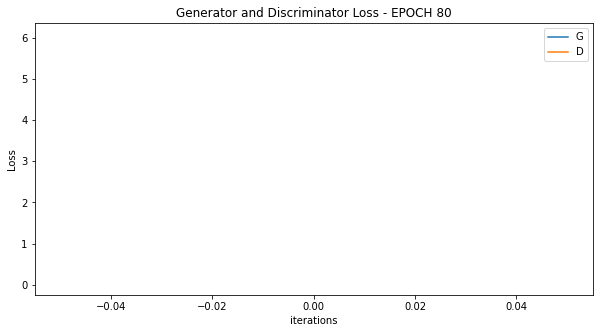

[80/100][321/644] Loss_D: 0.0583; Loss_G: 6.0546
[80/100][322/644] Loss_D: 0.1621; Loss_G: 4.2042
[80/100][323/644] Loss_D: 0.3291; Loss_G: 8.1357
[80/100][324/644] Loss_D: 0.0569; Loss_G: 6.7581
[80/100][325/644] Loss_D: 0.0396; Loss_G: 7.4776
[80/100][326/644] Loss_D: 0.0111; Loss_G: 7.2426
[80/100][327/644] Loss_D: 0.0565; Loss_G: 6.2056
[80/100][328/644] Loss_D: 0.0492; Loss_G: 5.8851
[80/100][329/644] Loss_D: 0.0876; Loss_G: 6.7258
[80/100][330/644] Loss_D: 0.0558; Loss_G: 6.4901
[80/100][331/644] Loss_D: 0.0650; Loss_G: 7.4726
[80/100][332/644] Loss_D: 0.0257; Loss_G: 7.1621
[80/100][333/644] Loss_D: 0.2448; Loss_G: 4.9782
[80/100][334/644] Loss_D: 0.1099; Loss_G: 5.6807
[80/100][335/644] Loss_D: 0.2448; Loss_G: 7.8916
[80/100][336/644] Loss_D: 0.0768; Loss_G: 8.1569
[80/100][337/644] Loss_D: 0.0870; Loss_G: 9.3667
[80/100][338/644] Loss_D: 0.0727; Loss_G: 6.3014
[80/100][339/644] Loss_D: 0.0474; Loss_G: 4.6734
[80/100][340/644] Loss_D: 0.0801; Loss_G: 5.6938
[80/100][341/644] Lo

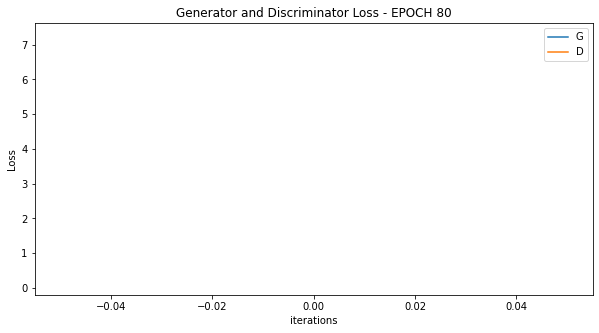

[80/100][643/644] Loss_D: 0.1557; Loss_G: 7.2704
[81/100][0/644] Loss_D: 0.1909; Loss_G: 4.3041
[81/100][1/644] Loss_D: 0.3582; Loss_G: 8.2421
[81/100][2/644] Loss_D: 0.1405; Loss_G: 8.6406
[81/100][3/644] Loss_D: 0.2717; Loss_G: 5.6274
[81/100][4/644] Loss_D: 0.1130; Loss_G: 5.5791
[81/100][5/644] Loss_D: 0.1558; Loss_G: 6.3717
[81/100][6/644] Loss_D: 0.0822; Loss_G: 6.4556
[81/100][7/644] Loss_D: 0.2747; Loss_G: 7.7345
[81/100][8/644] Loss_D: 0.3461; Loss_G: 6.3639
[81/100][9/644] Loss_D: 0.1536; Loss_G: 4.7947
[81/100][10/644] Loss_D: 0.0315; Loss_G: 6.1725
[81/100][11/644] Loss_D: 0.1307; Loss_G: 6.7511
[81/100][12/644] Loss_D: 0.1536; Loss_G: 6.4260
[81/100][13/644] Loss_D: 0.2548; Loss_G: 5.0908
[81/100][14/644] Loss_D: 0.0327; Loss_G: 5.4676
[81/100][15/644] Loss_D: 0.1892; Loss_G: 4.4263
[81/100][16/644] Loss_D: 0.2165; Loss_G: 5.0106
[81/100][17/644] Loss_D: 0.2751; Loss_G: 7.5870
[81/100][18/644] Loss_D: 0.0570; Loss_G: 6.6278
[81/100][19/644] Loss_D: 0.0084; Loss_G: 7.7464
[

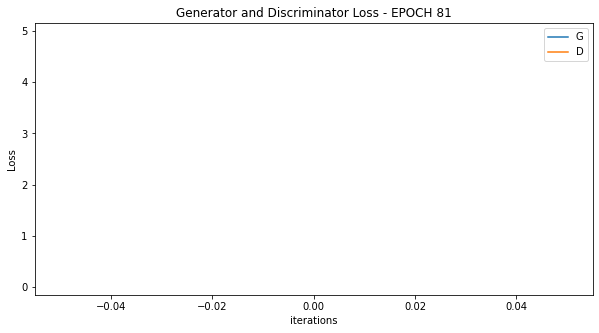

[81/100][321/644] Loss_D: 0.0911; Loss_G: 4.9161
[81/100][322/644] Loss_D: 0.0868; Loss_G: 5.2832
[81/100][323/644] Loss_D: 0.2404; Loss_G: 4.8197
[81/100][324/644] Loss_D: 0.1441; Loss_G: 7.2165
[81/100][325/644] Loss_D: 0.0046; Loss_G: 8.3794
[81/100][326/644] Loss_D: 0.0389; Loss_G: 7.0333
[81/100][327/644] Loss_D: 0.0518; Loss_G: 7.1984
[81/100][328/644] Loss_D: 0.3314; Loss_G: 4.4525
[81/100][329/644] Loss_D: 0.0652; Loss_G: 4.1108
[81/100][330/644] Loss_D: 0.3627; Loss_G: 9.6536
[81/100][331/644] Loss_D: 0.1615; Loss_G: 6.4242
[81/100][332/644] Loss_D: 0.0278; Loss_G: 8.1620
[81/100][333/644] Loss_D: 0.0728; Loss_G: 5.7490
[81/100][334/644] Loss_D: 0.1067; Loss_G: 5.7599
[81/100][335/644] Loss_D: 0.0548; Loss_G: 5.9837
[81/100][336/644] Loss_D: 0.0656; Loss_G: 7.0465
[81/100][337/644] Loss_D: 0.1549; Loss_G: 5.2874
[81/100][338/644] Loss_D: 0.2257; Loss_G: 8.3555
[81/100][339/644] Loss_D: 0.1843; Loss_G: 5.9119
[81/100][340/644] Loss_D: 0.0047; Loss_G: 6.6969
[81/100][341/644] Lo

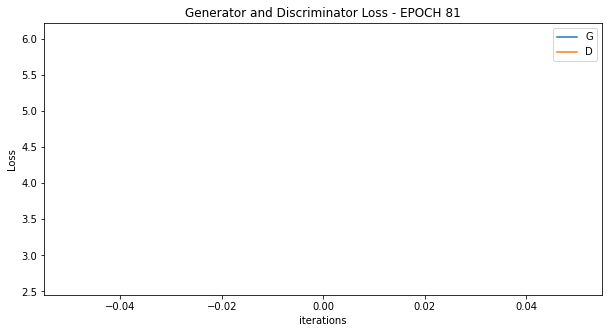

[81/100][643/644] Loss_D: 2.6238; Loss_G: 6.0505
[82/100][0/644] Loss_D: 2.3811; Loss_G: 12.0846
[82/100][1/644] Loss_D: 0.7173; Loss_G: 13.0719
[82/100][2/644] Loss_D: 3.5282; Loss_G: 0.9214
[82/100][3/644] Loss_D: 3.3443; Loss_G: 14.8729
[82/100][4/644] Loss_D: 0.6614; Loss_G: 5.4942
[82/100][5/644] Loss_D: 0.5724; Loss_G: 6.3340
[82/100][6/644] Loss_D: 0.4206; Loss_G: 4.1972
[82/100][7/644] Loss_D: 1.2946; Loss_G: 11.6684
[82/100][8/644] Loss_D: 3.0337; Loss_G: 0.2358
[82/100][9/644] Loss_D: 3.9729; Loss_G: 16.4757
[82/100][10/644] Loss_D: 0.8985; Loss_G: 7.3441
[82/100][11/644] Loss_D: 0.4399; Loss_G: 2.5056
[82/100][12/644] Loss_D: 0.9219; Loss_G: 7.8727
[82/100][13/644] Loss_D: 0.4141; Loss_G: 7.0974
[82/100][14/644] Loss_D: 0.7472; Loss_G: 2.8813
[82/100][15/644] Loss_D: 0.8837; Loss_G: 10.5626
[82/100][16/644] Loss_D: 0.0393; Loss_G: 10.3324
[82/100][17/644] Loss_D: 0.5094; Loss_G: 4.2954
[82/100][18/644] Loss_D: 0.6190; Loss_G: 7.7154
[82/100][19/644] Loss_D: 0.3250; Loss_G: 5

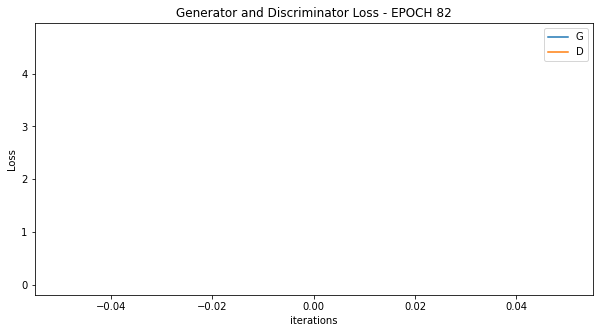

[82/100][321/644] Loss_D: 0.0483; Loss_G: 4.7233
[82/100][322/644] Loss_D: 0.0220; Loss_G: 6.1760
[82/100][323/644] Loss_D: 0.1395; Loss_G: 7.0591
[82/100][324/644] Loss_D: 0.0783; Loss_G: 6.6383
[82/100][325/644] Loss_D: 0.1501; Loss_G: 4.7503
[82/100][326/644] Loss_D: 0.1346; Loss_G: 5.1406
[82/100][327/644] Loss_D: 0.1137; Loss_G: 5.0195
[82/100][328/644] Loss_D: 0.2682; Loss_G: 6.9144
[82/100][329/644] Loss_D: 0.0778; Loss_G: 6.5676
[82/100][330/644] Loss_D: 0.0564; Loss_G: 6.0950
[82/100][331/644] Loss_D: 0.1163; Loss_G: 5.6311
[82/100][332/644] Loss_D: 0.0677; Loss_G: 6.1882
[82/100][333/644] Loss_D: 0.0425; Loss_G: 5.9694
[82/100][334/644] Loss_D: 0.0694; Loss_G: 5.2877
[82/100][335/644] Loss_D: 0.0878; Loss_G: 6.4500
[82/100][336/644] Loss_D: 0.0754; Loss_G: 5.8129
[82/100][337/644] Loss_D: 0.0896; Loss_G: 6.6036
[82/100][338/644] Loss_D: 0.1043; Loss_G: 5.3883
[82/100][339/644] Loss_D: 0.0541; Loss_G: 5.2786
[82/100][340/644] Loss_D: 0.0124; Loss_G: 7.5786
[82/100][341/644] Lo

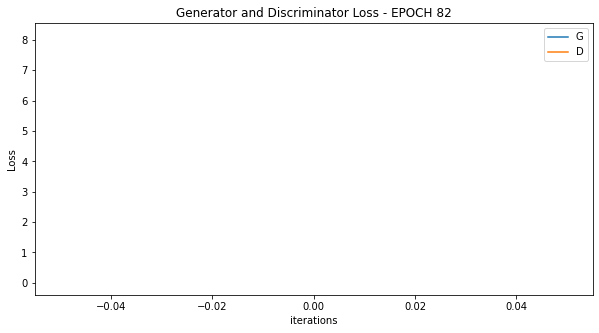

[82/100][643/644] Loss_D: 0.0132; Loss_G: 8.1461
[83/100][0/644] Loss_D: 0.0452; Loss_G: 6.2852
[83/100][1/644] Loss_D: 0.0613; Loss_G: 6.8261
[83/100][2/644] Loss_D: 0.0365; Loss_G: 6.6347
[83/100][3/644] Loss_D: 0.1711; Loss_G: 5.8327
[83/100][4/644] Loss_D: 0.3022; Loss_G: 7.2072
[83/100][5/644] Loss_D: 0.1296; Loss_G: 5.8956
[83/100][6/644] Loss_D: 0.1426; Loss_G: 6.7801
[83/100][7/644] Loss_D: 0.5734; Loss_G: 2.3589
[83/100][8/644] Loss_D: 1.3401; Loss_G: 14.2121
[83/100][9/644] Loss_D: 0.6397; Loss_G: 8.5431
[83/100][10/644] Loss_D: 0.2900; Loss_G: 7.3860
[83/100][11/644] Loss_D: 0.1539; Loss_G: 6.0268
[83/100][12/644] Loss_D: 0.0897; Loss_G: 5.7993
[83/100][13/644] Loss_D: 0.0390; Loss_G: 5.5290
[83/100][14/644] Loss_D: 0.0933; Loss_G: 6.7086
[83/100][15/644] Loss_D: 0.0487; Loss_G: 6.8742
[83/100][16/644] Loss_D: 0.0435; Loss_G: 7.3340
[83/100][17/644] Loss_D: 0.4134; Loss_G: 4.6910
[83/100][18/644] Loss_D: 0.4766; Loss_G: 6.3379
[83/100][19/644] Loss_D: 0.0918; Loss_G: 6.4693


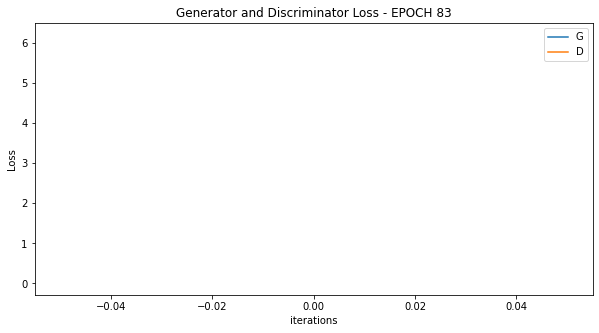

[83/100][321/644] Loss_D: 0.0232; Loss_G: 6.1893
[83/100][322/644] Loss_D: 0.1145; Loss_G: 5.0530
[83/100][323/644] Loss_D: 0.3865; Loss_G: 2.6960
[83/100][324/644] Loss_D: 0.9138; Loss_G: 16.9789
[83/100][325/644] Loss_D: 0.2745; Loss_G: 9.0559
[83/100][326/644] Loss_D: 0.1785; Loss_G: 4.3888
[83/100][327/644] Loss_D: 0.0891; Loss_G: 4.7268
[83/100][328/644] Loss_D: 0.1357; Loss_G: 7.2009
[83/100][329/644] Loss_D: 0.2429; Loss_G: 3.9967
[83/100][330/644] Loss_D: 0.1426; Loss_G: 6.1614
[83/100][331/644] Loss_D: 0.3698; Loss_G: 12.4280
[83/100][332/644] Loss_D: 1.0548; Loss_G: 1.7579
[83/100][333/644] Loss_D: 1.6879; Loss_G: 18.9152
[83/100][334/644] Loss_D: 1.2098; Loss_G: 8.4984
[83/100][335/644] Loss_D: 0.2953; Loss_G: 2.1125
[83/100][336/644] Loss_D: 0.8560; Loss_G: 13.5766
[83/100][337/644] Loss_D: 0.2786; Loss_G: 6.8710
[83/100][338/644] Loss_D: 0.2218; Loss_G: 4.9889
[83/100][339/644] Loss_D: 0.1622; Loss_G: 4.5572
[83/100][340/644] Loss_D: 0.8793; Loss_G: 14.6027
[83/100][341/64

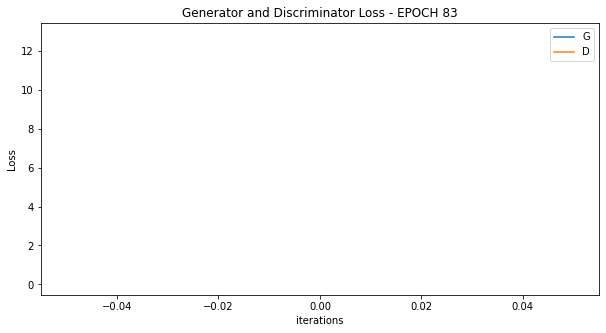

[83/100][643/644] Loss_D: 0.0982; Loss_G: 12.8096
[84/100][0/644] Loss_D: 0.7472; Loss_G: 12.9509
[84/100][1/644] Loss_D: 0.2332; Loss_G: 9.0166
[84/100][2/644] Loss_D: 0.2584; Loss_G: 4.1690
[84/100][3/644] Loss_D: 0.1041; Loss_G: 4.8619
[84/100][4/644] Loss_D: 0.1485; Loss_G: 4.9047
[84/100][5/644] Loss_D: 0.1664; Loss_G: 7.8653
[84/100][6/644] Loss_D: 0.0069; Loss_G: 8.8749
[84/100][7/644] Loss_D: 0.0011; Loss_G: 8.8385
[84/100][8/644] Loss_D: 0.2107; Loss_G: 5.0021
[84/100][9/644] Loss_D: 0.1218; Loss_G: 3.9955
[84/100][10/644] Loss_D: 0.1105; Loss_G: 5.7957
[84/100][11/644] Loss_D: 0.0886; Loss_G: 7.5531
[84/100][12/644] Loss_D: 0.0317; Loss_G: 7.8816
[84/100][13/644] Loss_D: 0.1395; Loss_G: 5.7999
[84/100][14/644] Loss_D: 0.0596; Loss_G: 7.4168
[84/100][15/644] Loss_D: 0.2509; Loss_G: 5.2539
[84/100][16/644] Loss_D: 0.0310; Loss_G: 5.6600
[84/100][17/644] Loss_D: 0.0436; Loss_G: 5.4297
[84/100][18/644] Loss_D: 0.0556; Loss_G: 5.8880
[84/100][19/644] Loss_D: 0.0167; Loss_G: 7.6498

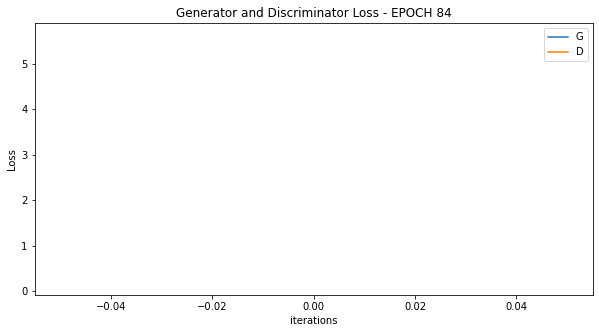

[84/100][321/644] Loss_D: 0.1881; Loss_G: 5.6187
[84/100][322/644] Loss_D: 0.0526; Loss_G: 6.9597
[84/100][323/644] Loss_D: 0.0789; Loss_G: 5.6784
[84/100][324/644] Loss_D: 0.0458; Loss_G: 5.0310
[84/100][325/644] Loss_D: 0.0504; Loss_G: 5.4435
[84/100][326/644] Loss_D: 0.0146; Loss_G: 6.4492
[84/100][327/644] Loss_D: 0.0629; Loss_G: 6.4024
[84/100][328/644] Loss_D: 0.0619; Loss_G: 6.9367
[84/100][329/644] Loss_D: 0.1205; Loss_G: 6.4224
[84/100][330/644] Loss_D: 0.0883; Loss_G: 5.1578
[84/100][331/644] Loss_D: 0.0756; Loss_G: 6.3932
[84/100][332/644] Loss_D: 0.0987; Loss_G: 5.2324
[84/100][333/644] Loss_D: 0.0375; Loss_G: 6.3030
[84/100][334/644] Loss_D: 0.1115; Loss_G: 5.2456
[84/100][335/644] Loss_D: 0.1711; Loss_G: 6.3023
[84/100][336/644] Loss_D: 0.0571; Loss_G: 6.1216
[84/100][337/644] Loss_D: 0.2011; Loss_G: 6.2927
[84/100][338/644] Loss_D: 0.0234; Loss_G: 5.2461
[84/100][339/644] Loss_D: 0.3420; Loss_G: 8.4255
[84/100][340/644] Loss_D: 0.1792; Loss_G: 6.0321
[84/100][341/644] Lo

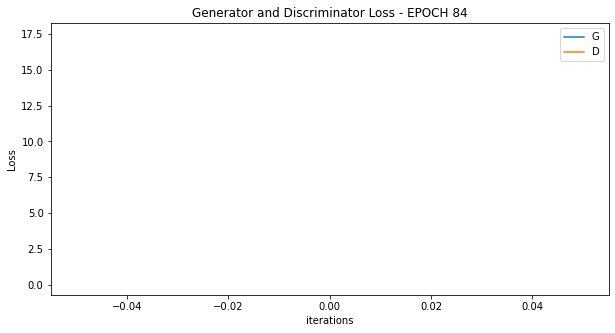

[84/100][643/644] Loss_D: 0.1507; Loss_G: 17.4013
[85/100][0/644] Loss_D: 0.0861; Loss_G: 6.4998
[85/100][1/644] Loss_D: 0.0385; Loss_G: 6.0871
[85/100][2/644] Loss_D: 0.1137; Loss_G: 5.8890
[85/100][3/644] Loss_D: 0.3871; Loss_G: 7.0095
[85/100][4/644] Loss_D: 0.1447; Loss_G: 6.0717
[85/100][5/644] Loss_D: 0.1067; Loss_G: 4.4064
[85/100][6/644] Loss_D: 0.1383; Loss_G: 5.4501
[85/100][7/644] Loss_D: 0.0784; Loss_G: 5.6691
[85/100][8/644] Loss_D: 0.0487; Loss_G: 5.0456
[85/100][9/644] Loss_D: 0.1023; Loss_G: 5.5203
[85/100][10/644] Loss_D: 0.0168; Loss_G: 6.1215
[85/100][11/644] Loss_D: 0.1989; Loss_G: 7.0035
[85/100][12/644] Loss_D: 0.0483; Loss_G: 7.3685
[85/100][13/644] Loss_D: 0.0390; Loss_G: 9.3169
[85/100][14/644] Loss_D: 0.5418; Loss_G: 3.5298
[85/100][15/644] Loss_D: 0.2102; Loss_G: 5.4443
[85/100][16/644] Loss_D: 0.1331; Loss_G: 6.4348
[85/100][17/644] Loss_D: 0.0578; Loss_G: 6.5671
[85/100][18/644] Loss_D: 0.1491; Loss_G: 4.8016
[85/100][19/644] Loss_D: 0.2850; Loss_G: 8.1509


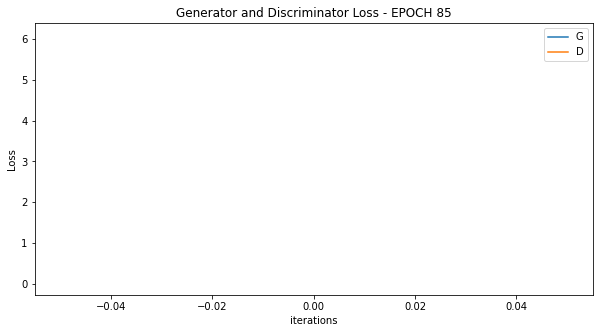

[85/100][321/644] Loss_D: 0.0261; Loss_G: 6.0945
[85/100][322/644] Loss_D: 0.2273; Loss_G: 6.5775
[85/100][323/644] Loss_D: 0.0245; Loss_G: 7.3255
[85/100][324/644] Loss_D: 0.0087; Loss_G: 6.9466
[85/100][325/644] Loss_D: 0.0877; Loss_G: 6.4173
[85/100][326/644] Loss_D: 0.1146; Loss_G: 5.2152
[85/100][327/644] Loss_D: 0.0264; Loss_G: 5.8353
[85/100][328/644] Loss_D: 0.1504; Loss_G: 6.5552
[85/100][329/644] Loss_D: 0.0408; Loss_G: 6.5395
[85/100][330/644] Loss_D: 0.0336; Loss_G: 6.2483
[85/100][331/644] Loss_D: 0.0318; Loss_G: 6.1644
[85/100][332/644] Loss_D: 0.1689; Loss_G: 5.1047
[85/100][333/644] Loss_D: 0.0272; Loss_G: 5.9296
[85/100][334/644] Loss_D: 0.0489; Loss_G: 5.4413
[85/100][335/644] Loss_D: 0.0171; Loss_G: 7.1370
[85/100][336/644] Loss_D: 0.0634; Loss_G: 6.0808
[85/100][337/644] Loss_D: 0.0772; Loss_G: 8.0604
[85/100][338/644] Loss_D: 0.0267; Loss_G: 7.2270
[85/100][339/644] Loss_D: 0.0964; Loss_G: 7.1301
[85/100][340/644] Loss_D: 0.0456; Loss_G: 5.5727
[85/100][341/644] Lo

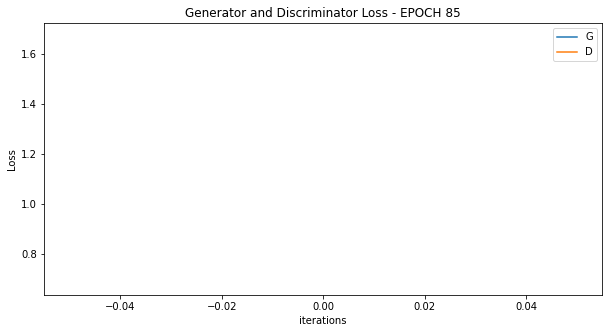

[85/100][643/644] Loss_D: 0.6872; Loss_G: 1.6756
[86/100][0/644] Loss_D: 3.7142; Loss_G: 22.2698
[86/100][1/644] Loss_D: 8.2441; Loss_G: 0.0011
[86/100][2/644] Loss_D: 18.1028; Loss_G: 17.2520
[86/100][3/644] Loss_D: 2.7414; Loss_G: 2.5035
[86/100][4/644] Loss_D: 1.6103; Loss_G: 16.6484
[86/100][5/644] Loss_D: 3.7981; Loss_G: 0.6486
[86/100][6/644] Loss_D: 3.5746; Loss_G: 14.6649
[86/100][7/644] Loss_D: 0.5062; Loss_G: 8.1179
[86/100][8/644] Loss_D: 0.2513; Loss_G: 5.9067
[86/100][9/644] Loss_D: 1.0505; Loss_G: 15.1678
[86/100][10/644] Loss_D: 4.6255; Loss_G: 1.0027
[86/100][11/644] Loss_D: 3.1282; Loss_G: 15.5209
[86/100][12/644] Loss_D: 0.2057; Loss_G: 10.1560
[86/100][13/644] Loss_D: 2.5744; Loss_G: 0.0823
[86/100][14/644] Loss_D: 4.9414; Loss_G: 15.3550
[86/100][15/644] Loss_D: 0.1720; Loss_G: 11.5343
[86/100][16/644] Loss_D: 2.8415; Loss_G: 0.0099
[86/100][17/644] Loss_D: 8.7398; Loss_G: 14.2022
[86/100][18/644] Loss_D: 1.0066; Loss_G: 7.8770
[86/100][19/644] Loss_D: 2.0167; Loss_

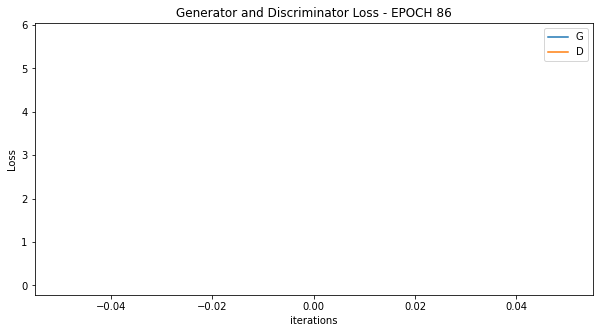

[86/100][321/644] Loss_D: 0.0679; Loss_G: 5.7616
[86/100][322/644] Loss_D: 0.0318; Loss_G: 6.4948
[86/100][323/644] Loss_D: 0.0627; Loss_G: 5.6284
[86/100][324/644] Loss_D: 0.0813; Loss_G: 6.6827
[86/100][325/644] Loss_D: 0.0166; Loss_G: 6.9342
[86/100][326/644] Loss_D: 0.1249; Loss_G: 5.5161
[86/100][327/644] Loss_D: 0.0601; Loss_G: 5.5161
[86/100][328/644] Loss_D: 0.1813; Loss_G: 7.5218
[86/100][329/644] Loss_D: 0.2061; Loss_G: 5.7700
[86/100][330/644] Loss_D: 0.0741; Loss_G: 7.3676
[86/100][331/644] Loss_D: 0.0839; Loss_G: 5.2408
[86/100][332/644] Loss_D: 0.0290; Loss_G: 5.1546
[86/100][333/644] Loss_D: 0.0764; Loss_G: 6.5510
[86/100][334/644] Loss_D: 0.0984; Loss_G: 6.6819
[86/100][335/644] Loss_D: 0.0105; Loss_G: 7.6029
[86/100][336/644] Loss_D: 0.0271; Loss_G: 7.4953
[86/100][337/644] Loss_D: 0.1283; Loss_G: 4.8836
[86/100][338/644] Loss_D: 0.0819; Loss_G: 4.9913
[86/100][339/644] Loss_D: 0.0510; Loss_G: 5.1250
[86/100][340/644] Loss_D: 0.4393; Loss_G: 9.5544
[86/100][341/644] Lo

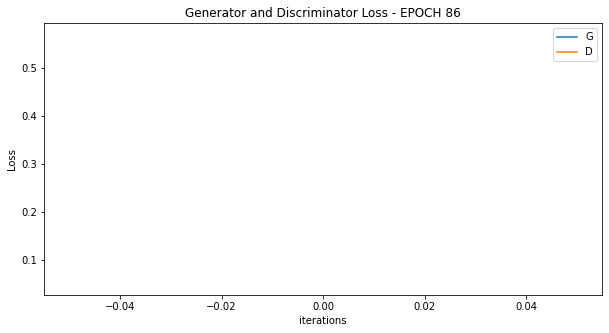

[86/100][643/644] Loss_D: 0.5677; Loss_G: 0.0524
[87/100][0/644] Loss_D: 6.7441; Loss_G: 23.0293
[87/100][1/644] Loss_D: 7.1578; Loss_G: 1.4103
[87/100][2/644] Loss_D: 3.2454; Loss_G: 17.8879
[87/100][3/644] Loss_D: 4.4042; Loss_G: 0.2184
[87/100][4/644] Loss_D: 7.1418; Loss_G: 16.6027
[87/100][5/644] Loss_D: 1.0206; Loss_G: 7.4545
[87/100][6/644] Loss_D: 0.4929; Loss_G: 5.4195
[87/100][7/644] Loss_D: 0.1958; Loss_G: 6.6199
[87/100][8/644] Loss_D: 1.6591; Loss_G: 0.6100
[87/100][9/644] Loss_D: 7.2166; Loss_G: 17.8806
[87/100][10/644] Loss_D: 4.4712; Loss_G: 0.2547
[87/100][11/644] Loss_D: 3.3677; Loss_G: 17.4644
[87/100][12/644] Loss_D: 1.5080; Loss_G: 7.3291
[87/100][13/644] Loss_D: 0.4156; Loss_G: 3.0682
[87/100][14/644] Loss_D: 1.2728; Loss_G: 11.3126
[87/100][15/644] Loss_D: 0.2833; Loss_G: 7.4883
[87/100][16/644] Loss_D: 0.0627; Loss_G: 8.6210
[87/100][17/644] Loss_D: 0.4402; Loss_G: 5.5280
[87/100][18/644] Loss_D: 0.4859; Loss_G: 6.8161
[87/100][19/644] Loss_D: 0.6031; Loss_G: 7.

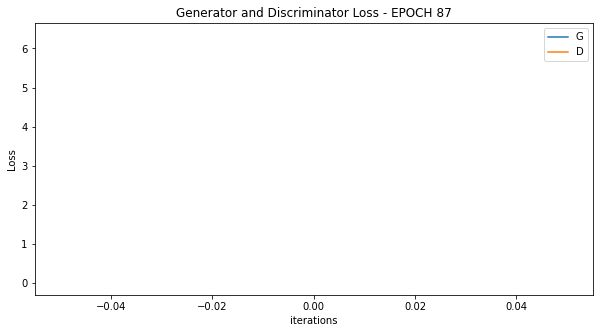

[87/100][321/644] Loss_D: 0.0192; Loss_G: 6.3353
[87/100][322/644] Loss_D: 0.0967; Loss_G: 5.1783
[87/100][323/644] Loss_D: 0.1019; Loss_G: 6.3070
[87/100][324/644] Loss_D: 0.0293; Loss_G: 6.4146
[87/100][325/644] Loss_D: 0.1501; Loss_G: 6.4447
[87/100][326/644] Loss_D: 0.0622; Loss_G: 6.1779
[87/100][327/644] Loss_D: 0.0480; Loss_G: 5.9660
[87/100][328/644] Loss_D: 0.0273; Loss_G: 6.0560
[87/100][329/644] Loss_D: 0.1809; Loss_G: 5.5293
[87/100][330/644] Loss_D: 0.4731; Loss_G: 2.7082
[87/100][331/644] Loss_D: 0.2373; Loss_G: 6.7668
[87/100][332/644] Loss_D: 0.4582; Loss_G: 11.2194
[87/100][333/644] Loss_D: 1.3749; Loss_G: 1.9143
[87/100][334/644] Loss_D: 0.4219; Loss_G: 6.6930
[87/100][335/644] Loss_D: 0.8578; Loss_G: 13.7612
[87/100][336/644] Loss_D: 1.0774; Loss_G: 4.5173
[87/100][337/644] Loss_D: 0.0427; Loss_G: 2.5488
[87/100][338/644] Loss_D: 0.8610; Loss_G: 14.2193
[87/100][339/644] Loss_D: 0.3985; Loss_G: 9.1053
[87/100][340/644] Loss_D: 0.0365; Loss_G: 8.6686
[87/100][341/644]

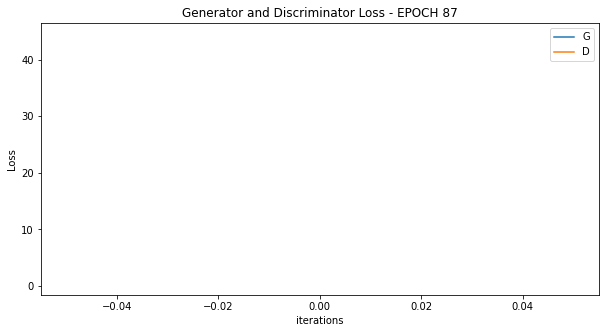

[87/100][643/644] Loss_D: 0.6505; Loss_G: 44.2655
[88/100][0/644] Loss_D: 0.2448; Loss_G: 5.6471
[88/100][1/644] Loss_D: 0.3361; Loss_G: 4.2650
[88/100][2/644] Loss_D: 0.8580; Loss_G: 12.7185
[88/100][3/644] Loss_D: 1.0030; Loss_G: 3.9702
[88/100][4/644] Loss_D: 0.6103; Loss_G: 8.9580
[88/100][5/644] Loss_D: 0.0485; Loss_G: 8.6052
[88/100][6/644] Loss_D: 0.5249; Loss_G: 3.6986
[88/100][7/644] Loss_D: 0.4804; Loss_G: 8.6126
[88/100][8/644] Loss_D: 0.2132; Loss_G: 5.5923
[88/100][9/644] Loss_D: 0.1130; Loss_G: 6.0760
[88/100][10/644] Loss_D: 0.0377; Loss_G: 8.2986
[88/100][11/644] Loss_D: 0.0864; Loss_G: 5.7900
[88/100][12/644] Loss_D: 0.0335; Loss_G: 6.4271
[88/100][13/644] Loss_D: 0.0561; Loss_G: 6.8379
[88/100][14/644] Loss_D: 0.1928; Loss_G: 8.5394
[88/100][15/644] Loss_D: 0.0238; Loss_G: 9.1675
[88/100][16/644] Loss_D: 0.2716; Loss_G: 6.5374
[88/100][17/644] Loss_D: 0.0262; Loss_G: 5.3626
[88/100][18/644] Loss_D: 0.3934; Loss_G: 9.9761
[88/100][19/644] Loss_D: 0.5460; Loss_G: 4.8824

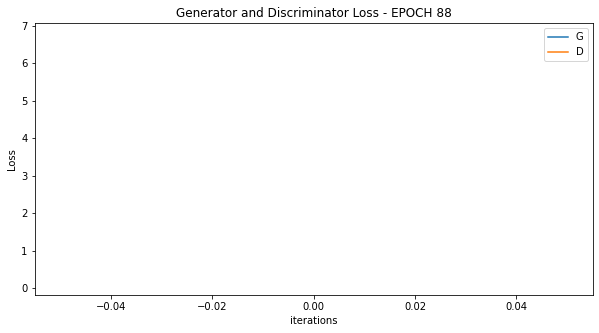

[88/100][321/644] Loss_D: 0.1512; Loss_G: 6.7456
[88/100][322/644] Loss_D: 0.2224; Loss_G: 4.2553
[88/100][323/644] Loss_D: 0.0167; Loss_G: 5.3073
[88/100][324/644] Loss_D: 0.0541; Loss_G: 5.6517
[88/100][325/644] Loss_D: 0.0679; Loss_G: 6.3628
[88/100][326/644] Loss_D: 0.0348; Loss_G: 7.4753
[88/100][327/644] Loss_D: 0.0706; Loss_G: 5.0703
[88/100][328/644] Loss_D: 0.1784; Loss_G: 5.9148
[88/100][329/644] Loss_D: 0.0167; Loss_G: 5.5846
[88/100][330/644] Loss_D: 0.3251; Loss_G: 8.2340
[88/100][331/644] Loss_D: 0.2461; Loss_G: 6.0035
[88/100][332/644] Loss_D: 0.0873; Loss_G: 5.9578
[88/100][333/644] Loss_D: 0.2664; Loss_G: 6.4088
[88/100][334/644] Loss_D: 0.3504; Loss_G: 3.6840
[88/100][335/644] Loss_D: 0.1534; Loss_G: 5.5593
[88/100][336/644] Loss_D: 0.0272; Loss_G: 6.2860
[88/100][337/644] Loss_D: 0.0125; Loss_G: 7.4409
[88/100][338/644] Loss_D: 0.0379; Loss_G: 6.2393
[88/100][339/644] Loss_D: 0.0074; Loss_G: 7.7016
[88/100][340/644] Loss_D: 0.0423; Loss_G: 6.3859
[88/100][341/644] Lo

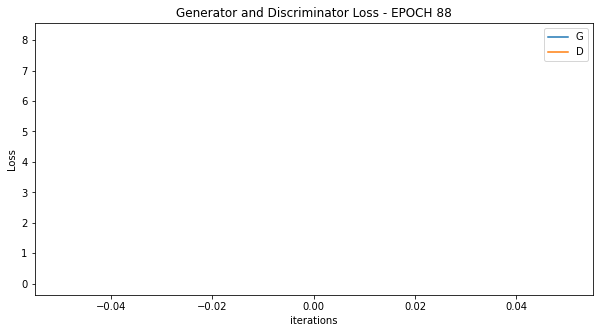

[88/100][643/644] Loss_D: 0.0402; Loss_G: 8.1587
[89/100][0/644] Loss_D: 0.0372; Loss_G: 6.0445
[89/100][1/644] Loss_D: 0.0561; Loss_G: 6.1645
[89/100][2/644] Loss_D: 0.0977; Loss_G: 6.9836
[89/100][3/644] Loss_D: 0.0194; Loss_G: 7.0803
[89/100][4/644] Loss_D: 0.0241; Loss_G: 7.0754
[89/100][5/644] Loss_D: 0.3018; Loss_G: 4.1908
[89/100][6/644] Loss_D: 0.1141; Loss_G: 5.1059
[89/100][7/644] Loss_D: 0.0887; Loss_G: 6.8727
[89/100][8/644] Loss_D: 0.0535; Loss_G: 7.0557
[89/100][9/644] Loss_D: 0.0117; Loss_G: 6.8006
[89/100][10/644] Loss_D: 0.0746; Loss_G: 5.7861
[89/100][11/644] Loss_D: 0.0344; Loss_G: 6.1897
[89/100][12/644] Loss_D: 0.2501; Loss_G: 5.0264
[89/100][13/644] Loss_D: 0.0330; Loss_G: 6.5086
[89/100][14/644] Loss_D: 0.1041; Loss_G: 5.8275
[89/100][15/644] Loss_D: 0.0877; Loss_G: 5.9632
[89/100][16/644] Loss_D: 0.0267; Loss_G: 6.3029
[89/100][17/644] Loss_D: 0.0256; Loss_G: 6.2478
[89/100][18/644] Loss_D: 0.0183; Loss_G: 7.4880
[89/100][19/644] Loss_D: 0.0358; Loss_G: 6.3670
[

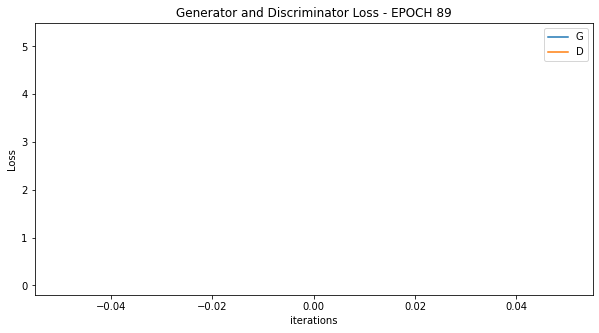

[89/100][321/644] Loss_D: 0.0602; Loss_G: 5.2305
[89/100][322/644] Loss_D: 0.0514; Loss_G: 5.6847
[89/100][323/644] Loss_D: 0.1320; Loss_G: 6.3522
[89/100][324/644] Loss_D: 0.1811; Loss_G: 7.7998
[89/100][325/644] Loss_D: 0.0849; Loss_G: 7.8206
[89/100][326/644] Loss_D: 0.6676; Loss_G: 3.2355
[89/100][327/644] Loss_D: 0.2561; Loss_G: 5.4146
[89/100][328/644] Loss_D: 0.3935; Loss_G: 9.1772
[89/100][329/644] Loss_D: 0.1426; Loss_G: 7.8302
[89/100][330/644] Loss_D: 0.1526; Loss_G: 5.9154
[89/100][331/644] Loss_D: 0.1132; Loss_G: 6.2157
[89/100][332/644] Loss_D: 0.0724; Loss_G: 6.2637
[89/100][333/644] Loss_D: 0.0267; Loss_G: 6.4835
[89/100][334/644] Loss_D: 0.0524; Loss_G: 5.8628
[89/100][335/644] Loss_D: 0.1202; Loss_G: 7.5076
[89/100][336/644] Loss_D: 0.0087; Loss_G: 8.3838
[89/100][337/644] Loss_D: 0.0020; Loss_G: 9.8063
[89/100][338/644] Loss_D: 0.2229; Loss_G: 6.2118
[89/100][339/644] Loss_D: 0.2014; Loss_G: 4.7299
[89/100][340/644] Loss_D: 0.1068; Loss_G: 6.5893
[89/100][341/644] Lo

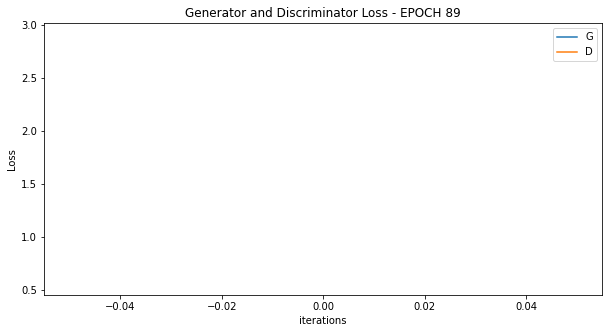

[89/100][643/644] Loss_D: 0.5729; Loss_G: 2.9035
[90/100][0/644] Loss_D: 4.3705; Loss_G: 21.7424
[90/100][1/644] Loss_D: 2.2167; Loss_G: 1.0907
[90/100][2/644] Loss_D: 1.2264; Loss_G: 12.7003
[90/100][3/644] Loss_D: 0.6024; Loss_G: 5.2958
[90/100][4/644] Loss_D: 0.2508; Loss_G: 5.8775
[90/100][5/644] Loss_D: 0.4515; Loss_G: 5.1878
[90/100][6/644] Loss_D: 0.4433; Loss_G: 2.3489
[90/100][7/644] Loss_D: 0.4888; Loss_G: 8.7449
[90/100][8/644] Loss_D: 0.2266; Loss_G: 8.6605
[90/100][9/644] Loss_D: 0.2975; Loss_G: 7.5778
[90/100][10/644] Loss_D: 0.1241; Loss_G: 5.3554
[90/100][11/644] Loss_D: 0.0763; Loss_G: 5.8378
[90/100][12/644] Loss_D: 0.3394; Loss_G: 5.8690
[90/100][13/644] Loss_D: 0.6624; Loss_G: 6.5227
[90/100][14/644] Loss_D: 0.4965; Loss_G: 6.8616
[90/100][15/644] Loss_D: 0.2548; Loss_G: 8.9382
[90/100][16/644] Loss_D: 0.4497; Loss_G: 6.9026
[90/100][17/644] Loss_D: 0.1077; Loss_G: 5.3555
[90/100][18/644] Loss_D: 0.1276; Loss_G: 5.7791
[90/100][19/644] Loss_D: 0.0379; Loss_G: 6.7896

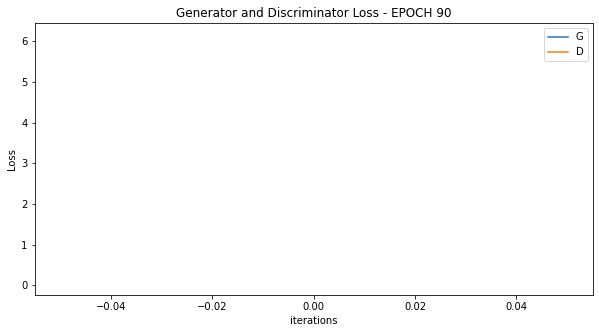

[90/100][321/644] Loss_D: 0.0669; Loss_G: 6.1447
[90/100][322/644] Loss_D: 0.0470; Loss_G: 6.4257
[90/100][323/644] Loss_D: 0.0341; Loss_G: 5.6668
[90/100][324/644] Loss_D: 0.0119; Loss_G: 6.3696
[90/100][325/644] Loss_D: 0.0223; Loss_G: 6.6224
[90/100][326/644] Loss_D: 0.0110; Loss_G: 6.9996
[90/100][327/644] Loss_D: 0.0348; Loss_G: 6.3103
[90/100][328/644] Loss_D: 0.0116; Loss_G: 6.9270
[90/100][329/644] Loss_D: 0.0152; Loss_G: 7.4734
[90/100][330/644] Loss_D: 0.0141; Loss_G: 6.5892
[90/100][331/644] Loss_D: 0.0536; Loss_G: 6.9983
[90/100][332/644] Loss_D: 0.0392; Loss_G: 7.5304
[90/100][333/644] Loss_D: 0.0111; Loss_G: 6.5970
[90/100][334/644] Loss_D: 0.1443; Loss_G: 5.4017
[90/100][335/644] Loss_D: 0.0917; Loss_G: 5.9317
[90/100][336/644] Loss_D: 0.1556; Loss_G: 4.8856
[90/100][337/644] Loss_D: 0.2764; Loss_G: 9.8390
[90/100][338/644] Loss_D: 0.0199; Loss_G: 11.1075
[90/100][339/644] Loss_D: 0.0642; Loss_G: 10.9171
[90/100][340/644] Loss_D: 0.2071; Loss_G: 5.9265
[90/100][341/644] 

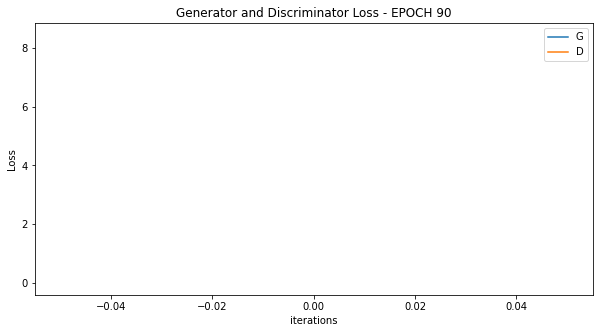

[90/100][643/644] Loss_D: 0.0191; Loss_G: 8.4243
[91/100][0/644] Loss_D: 0.0273; Loss_G: 7.7843
[91/100][1/644] Loss_D: 0.0104; Loss_G: 7.7106
[91/100][2/644] Loss_D: 0.4653; Loss_G: 2.5237
[91/100][3/644] Loss_D: 0.3436; Loss_G: 6.8814
[91/100][4/644] Loss_D: 0.0316; Loss_G: 7.3660
[91/100][5/644] Loss_D: 0.2350; Loss_G: 4.6753
[91/100][6/644] Loss_D: 0.3056; Loss_G: 7.8950
[91/100][7/644] Loss_D: 0.0259; Loss_G: 7.6888
[91/100][8/644] Loss_D: 0.2361; Loss_G: 5.0356
[91/100][9/644] Loss_D: 0.0602; Loss_G: 6.5863
[91/100][10/644] Loss_D: 0.0683; Loss_G: 6.2085
[91/100][11/644] Loss_D: 0.1064; Loss_G: 8.0145
[91/100][12/644] Loss_D: 0.0139; Loss_G: 8.5824
[91/100][13/644] Loss_D: 0.0350; Loss_G: 9.6099
[91/100][14/644] Loss_D: 0.0041; Loss_G: 8.3233
[91/100][15/644] Loss_D: 0.0429; Loss_G: 6.9207
[91/100][16/644] Loss_D: 0.1444; Loss_G: 4.7127
[91/100][17/644] Loss_D: 0.0294; Loss_G: 5.6265
[91/100][18/644] Loss_D: 0.1089; Loss_G: 6.9649
[91/100][19/644] Loss_D: 0.1201; Loss_G: 6.8535
[

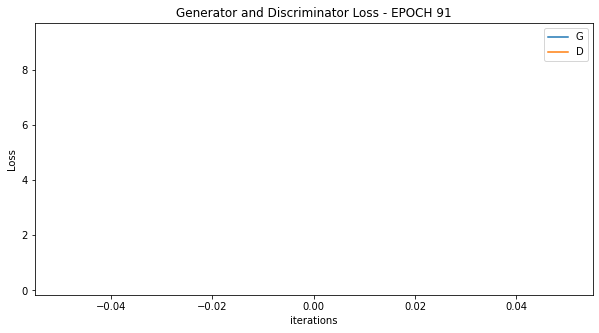

[91/100][321/644] Loss_D: 0.2871; Loss_G: 9.2479
[91/100][322/644] Loss_D: 0.1356; Loss_G: 5.7363
[91/100][323/644] Loss_D: 0.1136; Loss_G: 4.9919
[91/100][324/644] Loss_D: 0.2228; Loss_G: 8.2474
[91/100][325/644] Loss_D: 0.0343; Loss_G: 8.3775
[91/100][326/644] Loss_D: 0.0198; Loss_G: 8.7073
[91/100][327/644] Loss_D: 0.0190; Loss_G: 9.4854
[91/100][328/644] Loss_D: 0.1238; Loss_G: 4.9791
[91/100][329/644] Loss_D: 0.1188; Loss_G: 6.1181
[91/100][330/644] Loss_D: 0.0207; Loss_G: 6.5849
[91/100][331/644] Loss_D: 0.0742; Loss_G: 7.0434
[91/100][332/644] Loss_D: 0.2119; Loss_G: 5.3728
[91/100][333/644] Loss_D: 0.1748; Loss_G: 7.1309
[91/100][334/644] Loss_D: 0.0211; Loss_G: 6.8333
[91/100][335/644] Loss_D: 0.1210; Loss_G: 7.4438
[91/100][336/644] Loss_D: 0.0128; Loss_G: 6.3837
[91/100][337/644] Loss_D: 0.1077; Loss_G: 8.2323
[91/100][338/644] Loss_D: 0.0155; Loss_G: 7.7528
[91/100][339/644] Loss_D: 0.0173; Loss_G: 6.7357
[91/100][340/644] Loss_D: 0.0806; Loss_G: 6.8661
[91/100][341/644] Lo

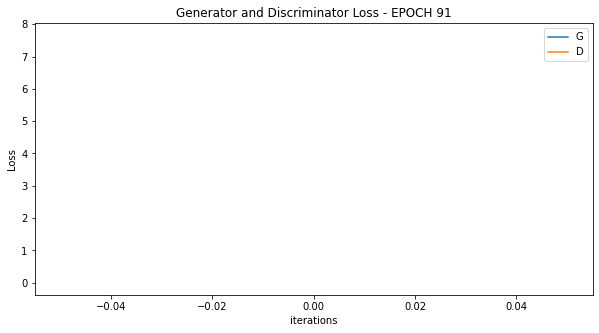

[91/100][643/644] Loss_D: 0.0071; Loss_G: 7.6556
[92/100][0/644] Loss_D: 0.1464; Loss_G: 7.2617
[92/100][1/644] Loss_D: 0.1431; Loss_G: 8.6842
[92/100][2/644] Loss_D: 0.0729; Loss_G: 7.4275
[92/100][3/644] Loss_D: 0.0681; Loss_G: 7.2243
[92/100][4/644] Loss_D: 0.0423; Loss_G: 5.7215
[92/100][5/644] Loss_D: 0.0153; Loss_G: 6.9310
[92/100][6/644] Loss_D: 0.1771; Loss_G: 6.9236
[92/100][7/644] Loss_D: 0.0338; Loss_G: 9.1097
[92/100][8/644] Loss_D: 0.0148; Loss_G: 7.0263
[92/100][9/644] Loss_D: 0.0246; Loss_G: 7.4058
[92/100][10/644] Loss_D: 0.0332; Loss_G: 6.8875
[92/100][11/644] Loss_D: 0.0551; Loss_G: 6.6175
[92/100][12/644] Loss_D: 0.0020; Loss_G: 8.2488
[92/100][13/644] Loss_D: 0.1364; Loss_G: 5.4397
[92/100][14/644] Loss_D: 0.0094; Loss_G: 5.7617
[92/100][15/644] Loss_D: 0.0417; Loss_G: 6.0619
[92/100][16/644] Loss_D: 0.0536; Loss_G: 6.3246
[92/100][17/644] Loss_D: 0.0021; Loss_G: 9.2066
[92/100][18/644] Loss_D: 0.1199; Loss_G: 7.3375
[92/100][19/644] Loss_D: 0.1008; Loss_G: 7.4451
[

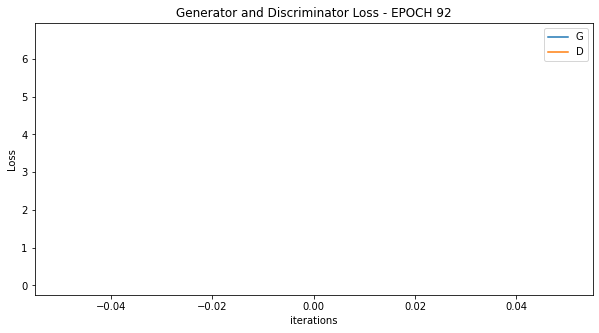

[92/100][321/644] Loss_D: 0.0768; Loss_G: 6.6229
[92/100][322/644] Loss_D: 0.0167; Loss_G: 8.3175
[92/100][323/644] Loss_D: 0.0178; Loss_G: 6.8840
[92/100][324/644] Loss_D: 0.0707; Loss_G: 7.0725
[92/100][325/644] Loss_D: 0.0302; Loss_G: 7.6109
[92/100][326/644] Loss_D: 0.0909; Loss_G: 5.3915
[92/100][327/644] Loss_D: 0.1116; Loss_G: 6.2484
[92/100][328/644] Loss_D: 0.0874; Loss_G: 6.8106
[92/100][329/644] Loss_D: 0.0405; Loss_G: 7.2956
[92/100][330/644] Loss_D: 0.3263; Loss_G: 4.1514
[92/100][331/644] Loss_D: 0.0770; Loss_G: 5.0653
[92/100][332/644] Loss_D: 0.1036; Loss_G: 6.9195
[92/100][333/644] Loss_D: 0.0282; Loss_G: 6.8565
[92/100][334/644] Loss_D: 0.0787; Loss_G: 6.5904
[92/100][335/644] Loss_D: 0.2143; Loss_G: 8.2678
[92/100][336/644] Loss_D: 0.4412; Loss_G: 2.6316
[92/100][337/644] Loss_D: 0.5852; Loss_G: 11.7426
[92/100][338/644] Loss_D: 0.1766; Loss_G: 7.7085
[92/100][339/644] Loss_D: 1.2169; Loss_G: 0.9001
[92/100][340/644] Loss_D: 1.6190; Loss_G: 17.6399
[92/100][341/644] 

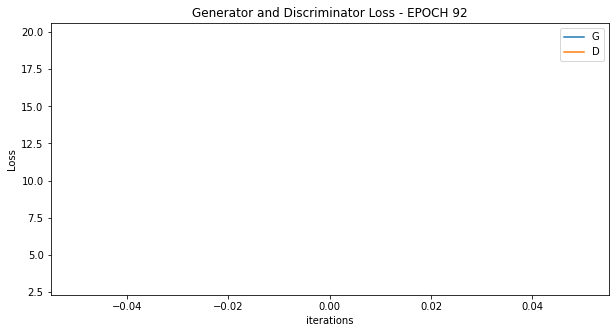

[92/100][643/644] Loss_D: 3.1363; Loss_G: 19.7875
[93/100][0/644] Loss_D: 6.8905; Loss_G: 17.5196
[93/100][1/644] Loss_D: 1.1075; Loss_G: 4.8170
[93/100][2/644] Loss_D: 1.7664; Loss_G: 12.4695
[93/100][3/644] Loss_D: 1.1012; Loss_G: 3.0818
[93/100][4/644] Loss_D: 1.6504; Loss_G: 11.9836
[93/100][5/644] Loss_D: 0.7413; Loss_G: 6.9559
[93/100][6/644] Loss_D: 0.9311; Loss_G: 1.0908
[93/100][7/644] Loss_D: 2.6592; Loss_G: 18.1423
[93/100][8/644] Loss_D: 2.7697; Loss_G: 2.7347
[93/100][9/644] Loss_D: 0.9080; Loss_G: 9.8537
[93/100][10/644] Loss_D: 0.4427; Loss_G: 10.9989
[93/100][11/644] Loss_D: 1.0803; Loss_G: 3.6998
[93/100][12/644] Loss_D: 0.2805; Loss_G: 4.8411
[93/100][13/644] Loss_D: 1.1295; Loss_G: 11.2595
[93/100][14/644] Loss_D: 0.2108; Loss_G: 8.4675
[93/100][15/644] Loss_D: 0.9600; Loss_G: 6.3412
[93/100][16/644] Loss_D: 0.9086; Loss_G: 9.6160
[93/100][17/644] Loss_D: 1.0431; Loss_G: 3.2789
[93/100][18/644] Loss_D: 0.4836; Loss_G: 6.5409
[93/100][19/644] Loss_D: 0.1512; Loss_G: 7

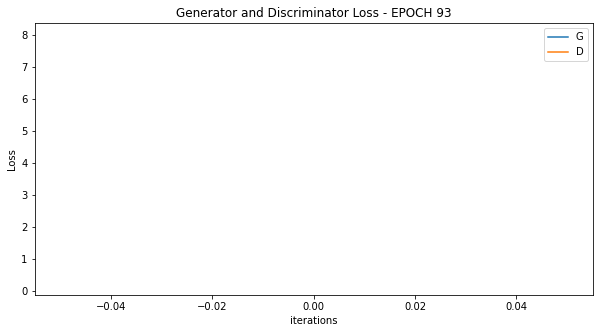

[93/100][321/644] Loss_D: 0.2534; Loss_G: 7.9793
[93/100][322/644] Loss_D: 0.0150; Loss_G: 8.2756
[93/100][323/644] Loss_D: 0.4823; Loss_G: 4.1083
[93/100][324/644] Loss_D: 0.0260; Loss_G: 5.8490
[93/100][325/644] Loss_D: 0.1586; Loss_G: 6.2913
[93/100][326/644] Loss_D: 0.1950; Loss_G: 7.6487
[93/100][327/644] Loss_D: 0.1531; Loss_G: 6.9849
[93/100][328/644] Loss_D: 0.0207; Loss_G: 5.9306
[93/100][329/644] Loss_D: 0.0173; Loss_G: 6.4690
[93/100][330/644] Loss_D: 0.0841; Loss_G: 6.1887
[93/100][331/644] Loss_D: 0.0829; Loss_G: 5.9055
[93/100][332/644] Loss_D: 0.0465; Loss_G: 6.6118
[93/100][333/644] Loss_D: 0.0619; Loss_G: 7.8649
[93/100][334/644] Loss_D: 0.6590; Loss_G: 1.4425
[93/100][335/644] Loss_D: 0.5969; Loss_G: 10.9564
[93/100][336/644] Loss_D: 0.0137; Loss_G: 8.8187
[93/100][337/644] Loss_D: 0.7174; Loss_G: 3.2880
[93/100][338/644] Loss_D: 0.4261; Loss_G: 7.8937
[93/100][339/644] Loss_D: 0.0512; Loss_G: 8.2645
[93/100][340/644] Loss_D: 0.1296; Loss_G: 8.8431
[93/100][341/644] L

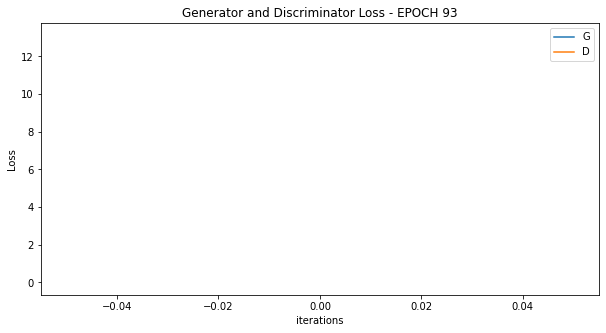

[93/100][643/644] Loss_D: 0.0001; Loss_G: 13.1186
[94/100][0/644] Loss_D: 0.0198; Loss_G: 6.9801
[94/100][1/644] Loss_D: 0.0365; Loss_G: 6.0363
[94/100][2/644] Loss_D: 0.0152; Loss_G: 6.9498
[94/100][3/644] Loss_D: 0.0326; Loss_G: 7.6064
[94/100][4/644] Loss_D: 0.0219; Loss_G: 6.6453
[94/100][5/644] Loss_D: 0.0473; Loss_G: 6.2525
[94/100][6/644] Loss_D: 0.0338; Loss_G: 6.4702
[94/100][7/644] Loss_D: 0.0415; Loss_G: 6.1605
[94/100][8/644] Loss_D: 0.0252; Loss_G: 6.2056
[94/100][9/644] Loss_D: 0.0918; Loss_G: 5.6384
[94/100][10/644] Loss_D: 0.1032; Loss_G: 4.8486
[94/100][11/644] Loss_D: 0.0894; Loss_G: 6.3263
[94/100][12/644] Loss_D: 0.0229; Loss_G: 7.3458
[94/100][13/644] Loss_D: 0.0661; Loss_G: 6.5993
[94/100][14/644] Loss_D: 0.0844; Loss_G: 4.7577
[94/100][15/644] Loss_D: 0.0275; Loss_G: 5.4581
[94/100][16/644] Loss_D: 0.0390; Loss_G: 6.3829
[94/100][17/644] Loss_D: 0.0184; Loss_G: 6.1237
[94/100][18/644] Loss_D: 0.1098; Loss_G: 6.9703
[94/100][19/644] Loss_D: 0.1762; Loss_G: 7.0443


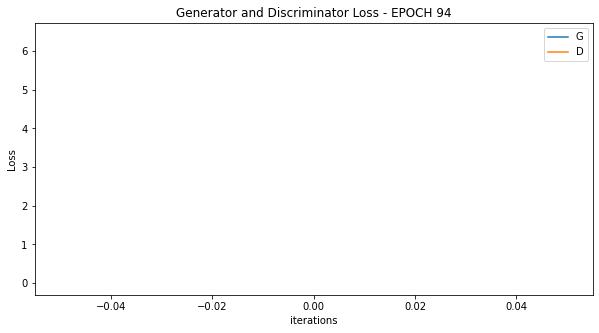

[94/100][321/644] Loss_D: 0.0167; Loss_G: 6.4050
[94/100][322/644] Loss_D: 0.2173; Loss_G: 6.7969
[94/100][323/644] Loss_D: 0.1103; Loss_G: 6.0825
[94/100][324/644] Loss_D: 0.0207; Loss_G: 5.6139
[94/100][325/644] Loss_D: 0.4795; Loss_G: 14.0425
[94/100][326/644] Loss_D: 1.4267; Loss_G: 1.1770
[94/100][327/644] Loss_D: 1.2098; Loss_G: 14.4387
[94/100][328/644] Loss_D: 0.1713; Loss_G: 8.0391
[94/100][329/644] Loss_D: 0.0988; Loss_G: 5.5632
[94/100][330/644] Loss_D: 0.1675; Loss_G: 5.8672
[94/100][331/644] Loss_D: 0.1151; Loss_G: 6.4987
[94/100][332/644] Loss_D: 0.1759; Loss_G: 4.4906
[94/100][333/644] Loss_D: 0.0630; Loss_G: 5.9038
[94/100][334/644] Loss_D: 0.0610; Loss_G: 6.8273
[94/100][335/644] Loss_D: 0.1216; Loss_G: 5.4117
[94/100][336/644] Loss_D: 0.1785; Loss_G: 7.7877
[94/100][337/644] Loss_D: 0.1048; Loss_G: 6.8239
[94/100][338/644] Loss_D: 0.0228; Loss_G: 8.0507
[94/100][339/644] Loss_D: 0.1030; Loss_G: 5.6908
[94/100][340/644] Loss_D: 0.0437; Loss_G: 5.7731
[94/100][341/644] 

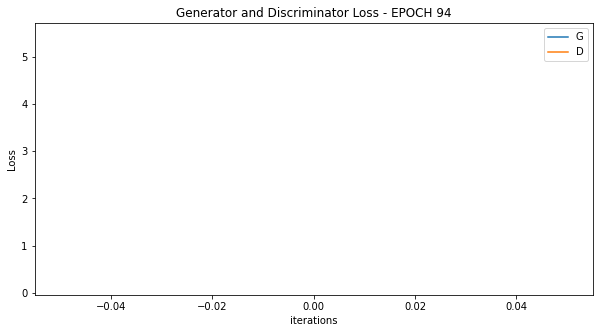

[94/100][643/644] Loss_D: 0.2233; Loss_G: 5.4517
[95/100][0/644] Loss_D: 0.2571; Loss_G: 6.2226
[95/100][1/644] Loss_D: 0.1127; Loss_G: 6.4297
[95/100][2/644] Loss_D: 0.1176; Loss_G: 5.8810
[95/100][3/644] Loss_D: 0.2074; Loss_G: 6.2371
[95/100][4/644] Loss_D: 0.1873; Loss_G: 5.7814
[95/100][5/644] Loss_D: 0.0858; Loss_G: 6.9048
[95/100][6/644] Loss_D: 0.6535; Loss_G: 3.0676
[95/100][7/644] Loss_D: 0.5273; Loss_G: 8.4178
[95/100][8/644] Loss_D: 0.6178; Loss_G: 3.0453
[95/100][9/644] Loss_D: 1.2304; Loss_G: 12.2887
[95/100][10/644] Loss_D: 0.2745; Loss_G: 9.5143
[95/100][11/644] Loss_D: 0.3687; Loss_G: 5.5505
[95/100][12/644] Loss_D: 0.2168; Loss_G: 4.9909
[95/100][13/644] Loss_D: 0.3591; Loss_G: 6.8778
[95/100][14/644] Loss_D: 0.0471; Loss_G: 6.4705
[95/100][15/644] Loss_D: 0.1785; Loss_G: 8.2873
[95/100][16/644] Loss_D: 0.4903; Loss_G: 4.0168
[95/100][17/644] Loss_D: 0.0419; Loss_G: 3.8787
[95/100][18/644] Loss_D: 0.6366; Loss_G: 10.7933
[95/100][19/644] Loss_D: 0.2110; Loss_G: 7.2789

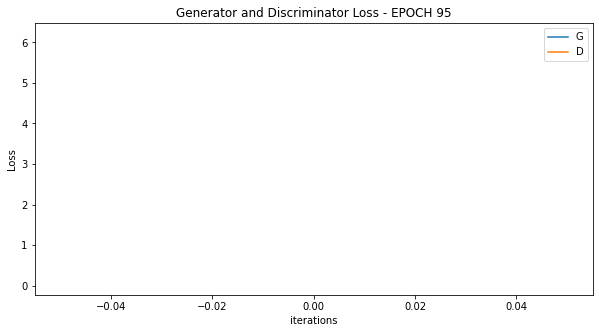

[95/100][321/644] Loss_D: 0.0802; Loss_G: 6.1732
[95/100][322/644] Loss_D: 0.0312; Loss_G: 7.1553
[95/100][323/644] Loss_D: 0.1725; Loss_G: 5.7807
[95/100][324/644] Loss_D: 0.0043; Loss_G: 7.0985
[95/100][325/644] Loss_D: 0.0751; Loss_G: 6.4764
[95/100][326/644] Loss_D: 0.0166; Loss_G: 7.6383
[95/100][327/644] Loss_D: 0.0525; Loss_G: 5.7700
[95/100][328/644] Loss_D: 0.0558; Loss_G: 6.2298
[95/100][329/644] Loss_D: 0.0502; Loss_G: 6.4642
[95/100][330/644] Loss_D: 0.1698; Loss_G: 4.9814
[95/100][331/644] Loss_D: 0.0240; Loss_G: 5.9150
[95/100][332/644] Loss_D: 0.1666; Loss_G: 7.3130
[95/100][333/644] Loss_D: 0.0355; Loss_G: 7.0999
[95/100][334/644] Loss_D: 0.2602; Loss_G: 5.7876
[95/100][335/644] Loss_D: 0.0341; Loss_G: 5.0527
[95/100][336/644] Loss_D: 0.1775; Loss_G: 6.8255
[95/100][337/644] Loss_D: 0.0357; Loss_G: 7.5393
[95/100][338/644] Loss_D: 0.0664; Loss_G: 5.9794
[95/100][339/644] Loss_D: 0.0349; Loss_G: 6.1971
[95/100][340/644] Loss_D: 0.0258; Loss_G: 6.1490
[95/100][341/644] Lo

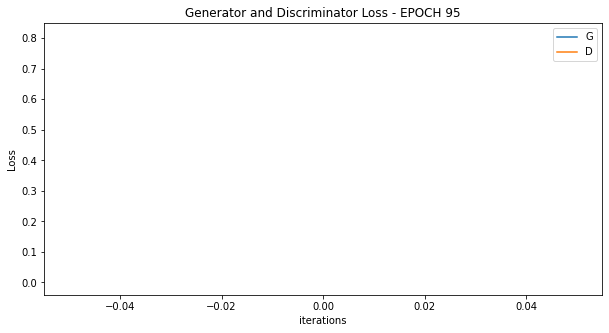

[95/100][643/644] Loss_D: 0.8093; Loss_G: 0.0001
[96/100][0/644] Loss_D: 12.9755; Loss_G: 18.0473
[96/100][1/644] Loss_D: 4.9199; Loss_G: 0.0068
[96/100][2/644] Loss_D: 7.3298; Loss_G: 19.1795
[96/100][3/644] Loss_D: 4.2950; Loss_G: 0.0239
[96/100][4/644] Loss_D: 6.1519; Loss_G: 19.0698
[96/100][5/644] Loss_D: 5.4964; Loss_G: 0.0043
[96/100][6/644] Loss_D: 17.3950; Loss_G: 19.6026
[96/100][7/644] Loss_D: 7.8884; Loss_G: 0.0077
[96/100][8/644] Loss_D: 26.5191; Loss_G: 7.4610
[96/100][9/644] Loss_D: 6.6903; Loss_G: 18.0373
[96/100][10/644] Loss_D: 10.3470; Loss_G: 1.5617
[96/100][11/644] Loss_D: 3.3848; Loss_G: 9.6182
[96/100][12/644] Loss_D: 0.8261; Loss_G: 11.4307
[96/100][13/644] Loss_D: 2.9880; Loss_G: 1.1985
[96/100][14/644] Loss_D: 3.4053; Loss_G: 13.4556
[96/100][15/644] Loss_D: 1.3489; Loss_G: 9.0827
[96/100][16/644] Loss_D: 2.6640; Loss_G: 1.7969
[96/100][17/644] Loss_D: 3.4450; Loss_G: 13.8978
[96/100][18/644] Loss_D: 1.3891; Loss_G: 6.7954
[96/100][19/644] Loss_D: 0.2330; Loss

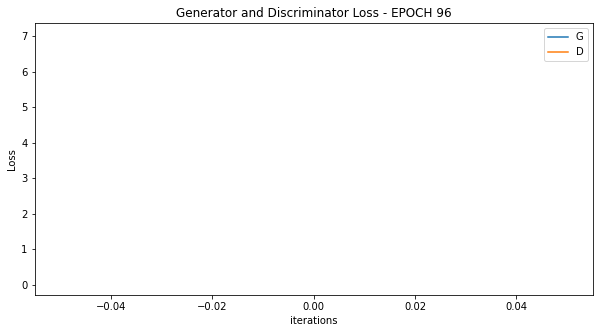

[96/100][321/644] Loss_D: 0.0599; Loss_G: 7.0265
[96/100][322/644] Loss_D: 0.1216; Loss_G: 6.5220
[96/100][323/644] Loss_D: 0.0372; Loss_G: 7.8126
[96/100][324/644] Loss_D: 0.1213; Loss_G: 4.7397
[96/100][325/644] Loss_D: 0.0390; Loss_G: 4.8979
[96/100][326/644] Loss_D: 0.2025; Loss_G: 5.8401
[96/100][327/644] Loss_D: 0.1468; Loss_G: 7.7888
[96/100][328/644] Loss_D: 0.0315; Loss_G: 9.8112
[96/100][329/644] Loss_D: 0.1901; Loss_G: 6.5014
[96/100][330/644] Loss_D: 0.0558; Loss_G: 5.6806
[96/100][331/644] Loss_D: 0.0489; Loss_G: 5.5792
[96/100][332/644] Loss_D: 0.0746; Loss_G: 6.1279
[96/100][333/644] Loss_D: 0.0198; Loss_G: 6.0363
[96/100][334/644] Loss_D: 0.0380; Loss_G: 6.4588
[96/100][335/644] Loss_D: 0.0901; Loss_G: 6.3965
[96/100][336/644] Loss_D: 0.0960; Loss_G: 6.2098
[96/100][337/644] Loss_D: 0.2717; Loss_G: 3.4477
[96/100][338/644] Loss_D: 0.1621; Loss_G: 5.8301
[96/100][339/644] Loss_D: 0.1238; Loss_G: 7.0513
[96/100][340/644] Loss_D: 0.2187; Loss_G: 5.1115
[96/100][341/644] Lo

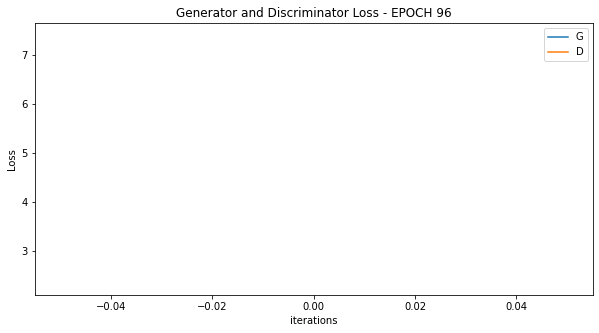

[96/100][643/644] Loss_D: 2.3605; Loss_G: 7.4027
[97/100][0/644] Loss_D: 6.2361; Loss_G: 20.4619
[97/100][1/644] Loss_D: 5.1535; Loss_G: 0.4946
[97/100][2/644] Loss_D: 2.4946; Loss_G: 15.8612
[97/100][3/644] Loss_D: 0.6775; Loss_G: 4.7873
[97/100][4/644] Loss_D: 0.3475; Loss_G: 3.0848
[97/100][5/644] Loss_D: 1.8760; Loss_G: 16.5943
[97/100][6/644] Loss_D: 4.0197; Loss_G: 0.6871
[97/100][7/644] Loss_D: 1.4707; Loss_G: 10.5513
[97/100][8/644] Loss_D: 0.2567; Loss_G: 10.2274
[97/100][9/644] Loss_D: 1.6089; Loss_G: 1.0961
[97/100][10/644] Loss_D: 2.0862; Loss_G: 12.8116
[97/100][11/644] Loss_D: 0.6710; Loss_G: 5.4235
[97/100][12/644] Loss_D: 0.1914; Loss_G: 6.3346
[97/100][13/644] Loss_D: 1.0199; Loss_G: 8.8396
[97/100][14/644] Loss_D: 0.2612; Loss_G: 9.9905
[97/100][15/644] Loss_D: 1.1531; Loss_G: 1.5085
[97/100][16/644] Loss_D: 1.0703; Loss_G: 10.1696
[97/100][17/644] Loss_D: 0.5191; Loss_G: 4.7905
[97/100][18/644] Loss_D: 1.0208; Loss_G: 11.4135
[97/100][19/644] Loss_D: 0.7968; Loss_G: 

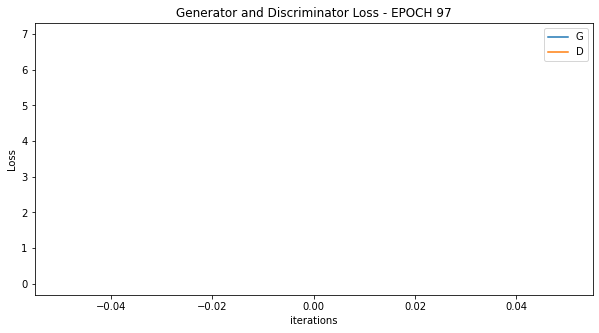

[97/100][321/644] Loss_D: 0.0304; Loss_G: 6.9696
[97/100][322/644] Loss_D: 0.0641; Loss_G: 6.5600
[97/100][323/644] Loss_D: 0.0625; Loss_G: 6.8843
[97/100][324/644] Loss_D: 0.0046; Loss_G: 9.1629
[97/100][325/644] Loss_D: 0.0681; Loss_G: 7.2342
[97/100][326/644] Loss_D: 0.0683; Loss_G: 6.6641
[97/100][327/644] Loss_D: 0.0157; Loss_G: 5.6893
[97/100][328/644] Loss_D: 0.0467; Loss_G: 5.2154
[97/100][329/644] Loss_D: 0.2503; Loss_G: 8.5440
[97/100][330/644] Loss_D: 0.0124; Loss_G: 9.0877
[97/100][331/644] Loss_D: 0.0387; Loss_G: 9.4349
[97/100][332/644] Loss_D: 0.5149; Loss_G: 3.5991
[97/100][333/644] Loss_D: 0.2124; Loss_G: 4.6585
[97/100][334/644] Loss_D: 0.3241; Loss_G: 8.9174
[97/100][335/644] Loss_D: 0.1076; Loss_G: 7.6890
[97/100][336/644] Loss_D: 0.0427; Loss_G: 7.6143
[97/100][337/644] Loss_D: 0.2310; Loss_G: 6.7945
[97/100][338/644] Loss_D: 0.0234; Loss_G: 4.7598
[97/100][339/644] Loss_D: 0.4075; Loss_G: 9.4757
[97/100][340/644] Loss_D: 0.1174; Loss_G: 8.0976
[97/100][341/644] Lo

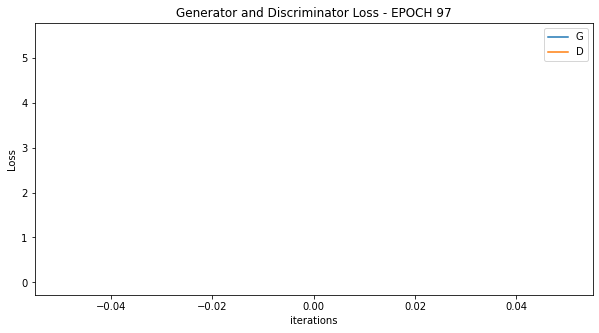

[97/100][643/644] Loss_D: 0.0001; Loss_G: 5.4961
[98/100][0/644] Loss_D: 0.5389; Loss_G: 10.2269
[98/100][1/644] Loss_D: 0.2082; Loss_G: 7.6586
[98/100][2/644] Loss_D: 0.0648; Loss_G: 8.2338
[98/100][3/644] Loss_D: 0.3986; Loss_G: 3.2051
[98/100][4/644] Loss_D: 0.2630; Loss_G: 6.6025
[98/100][5/644] Loss_D: 0.0438; Loss_G: 7.4015
[98/100][6/644] Loss_D: 0.3125; Loss_G: 4.0616
[98/100][7/644] Loss_D: 0.0844; Loss_G: 6.3603
[98/100][8/644] Loss_D: 0.1397; Loss_G: 7.4774
[98/100][9/644] Loss_D: 0.0530; Loss_G: 6.4745
[98/100][10/644] Loss_D: 0.5664; Loss_G: 15.3919
[98/100][11/644] Loss_D: 1.2747; Loss_G: 5.8225
[98/100][12/644] Loss_D: 0.0930; Loss_G: 3.3174
[98/100][13/644] Loss_D: 0.1227; Loss_G: 6.1486
[98/100][14/644] Loss_D: 0.2979; Loss_G: 9.7996
[98/100][15/644] Loss_D: 0.0329; Loss_G: 8.8436
[98/100][16/644] Loss_D: 0.0266; Loss_G: 7.4075
[98/100][17/644] Loss_D: 0.2442; Loss_G: 7.3420
[98/100][18/644] Loss_D: 0.1341; Loss_G: 5.8331
[98/100][19/644] Loss_D: 0.0875; Loss_G: 5.4613

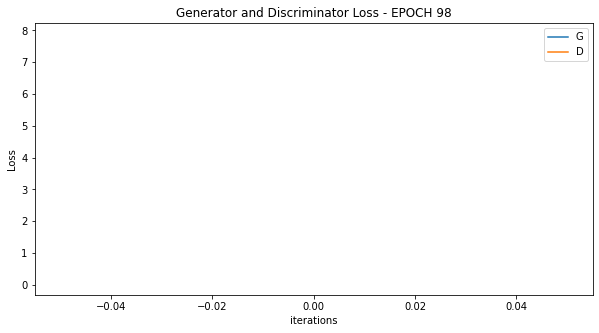

[98/100][321/644] Loss_D: 0.0766; Loss_G: 7.8469
[98/100][322/644] Loss_D: 0.2056; Loss_G: 4.0990
[98/100][323/644] Loss_D: 0.0501; Loss_G: 7.0874
[98/100][324/644] Loss_D: 0.0478; Loss_G: 6.0144
[98/100][325/644] Loss_D: 0.0841; Loss_G: 7.3583
[98/100][326/644] Loss_D: 0.0166; Loss_G: 7.2870
[98/100][327/644] Loss_D: 0.0617; Loss_G: 8.2801
[98/100][328/644] Loss_D: 0.0062; Loss_G: 7.5882
[98/100][329/644] Loss_D: 0.0342; Loss_G: 7.5973
[98/100][330/644] Loss_D: 0.0470; Loss_G: 5.7781
[98/100][331/644] Loss_D: 0.0322; Loss_G: 6.4795
[98/100][332/644] Loss_D: 0.0152; Loss_G: 7.1356
[98/100][333/644] Loss_D: 0.0292; Loss_G: 5.9449
[98/100][334/644] Loss_D: 0.0439; Loss_G: 6.3148
[98/100][335/644] Loss_D: 0.1330; Loss_G: 6.1426
[98/100][336/644] Loss_D: 0.0077; Loss_G: 7.2223
[98/100][337/644] Loss_D: 0.1065; Loss_G: 6.7001
[98/100][338/644] Loss_D: 0.2552; Loss_G: 7.2979
[98/100][339/644] Loss_D: 0.0512; Loss_G: 6.5630
[98/100][340/644] Loss_D: 0.0810; Loss_G: 6.4400
[98/100][341/644] Lo

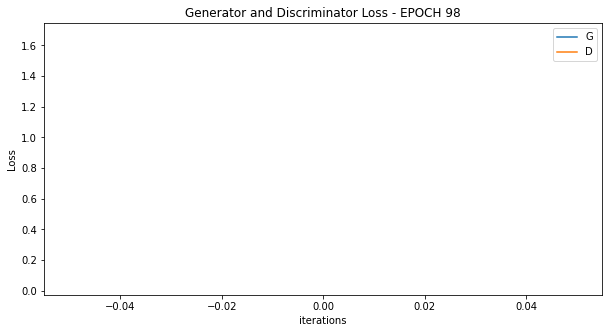

[98/100][643/644] Loss_D: 1.6654; Loss_G: 0.0534
[99/100][0/644] Loss_D: 9.1812; Loss_G: 14.1522
[99/100][1/644] Loss_D: 0.6334; Loss_G: 4.8056
[99/100][2/644] Loss_D: 0.8380; Loss_G: 1.4506
[99/100][3/644] Loss_D: 3.1317; Loss_G: 17.7953
[99/100][4/644] Loss_D: 4.0127; Loss_G: 1.8289
[99/100][5/644] Loss_D: 1.0514; Loss_G: 9.4751
[99/100][6/644] Loss_D: 0.3832; Loss_G: 5.7315
[99/100][7/644] Loss_D: 1.8471; Loss_G: 14.6962
[99/100][8/644] Loss_D: 2.6719; Loss_G: 2.5199
[99/100][9/644] Loss_D: 0.9105; Loss_G: 8.7275
[99/100][10/644] Loss_D: 0.3697; Loss_G: 9.8761
[99/100][11/644] Loss_D: 1.7889; Loss_G: 0.7447
[99/100][12/644] Loss_D: 1.6229; Loss_G: 10.3998
[99/100][13/644] Loss_D: 0.1897; Loss_G: 9.9899
[99/100][14/644] Loss_D: 0.3666; Loss_G: 6.2160
[99/100][15/644] Loss_D: 2.1135; Loss_G: 0.2616
[99/100][16/644] Loss_D: 2.2816; Loss_G: 15.4533
[99/100][17/644] Loss_D: 0.5371; Loss_G: 6.0291
[99/100][18/644] Loss_D: 0.3760; Loss_G: 5.1178
[99/100][19/644] Loss_D: 1.4489; Loss_G: 17.

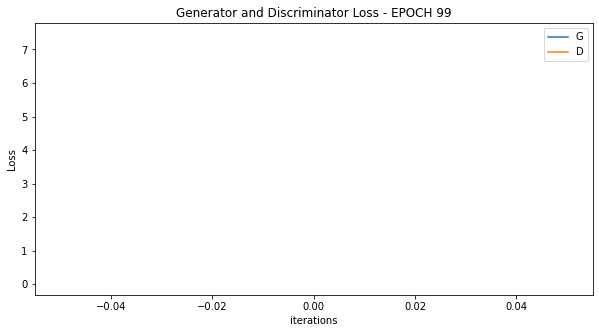

[99/100][321/644] Loss_D: 0.0533; Loss_G: 7.4194
[99/100][322/644] Loss_D: 0.3355; Loss_G: 3.1991
[99/100][323/644] Loss_D: 0.3719; Loss_G: 8.7710
[99/100][324/644] Loss_D: 0.0298; Loss_G: 7.2566
[99/100][325/644] Loss_D: 0.4216; Loss_G: 4.5277
[99/100][326/644] Loss_D: 0.0999; Loss_G: 3.8106
[99/100][327/644] Loss_D: 1.2646; Loss_G: 18.0269
[99/100][328/644] Loss_D: 2.2973; Loss_G: 5.6637
[99/100][329/644] Loss_D: 0.1362; Loss_G: 3.3129
[99/100][330/644] Loss_D: 0.7444; Loss_G: 11.3424
[99/100][331/644] Loss_D: 0.3836; Loss_G: 9.1042
[99/100][332/644] Loss_D: 0.0803; Loss_G: 6.6678
[99/100][333/644] Loss_D: 0.1357; Loss_G: 6.3446
[99/100][334/644] Loss_D: 0.1058; Loss_G: 6.3028
[99/100][335/644] Loss_D: 0.0592; Loss_G: 6.3596
[99/100][336/644] Loss_D: 0.2205; Loss_G: 7.0583
[99/100][337/644] Loss_D: 0.2841; Loss_G: 8.1864
[99/100][338/644] Loss_D: 0.2544; Loss_G: 6.1135
[99/100][339/644] Loss_D: 0.0467; Loss_G: 6.6031
[99/100][340/644] Loss_D: 0.0983; Loss_G: 7.5215
[99/100][341/644] 

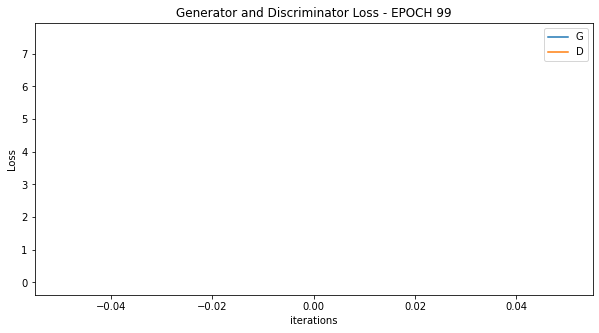

[99/100][643/644] Loss_D: 7.5623; Loss_G: 0.0001


In [12]:

for epoch in range(EPOCH):
    for i, data in enumerate(train_loader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real,_ = data
        input = Variable(real).to(device)
        target = Variable(torch.ones(input.size()[0],device=device))
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1, device=device))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0],device=device))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0],device=device))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (i+1) % (len(train_loader)//2) == 0:
            plot_loss (G_losses, D_losses, epoch)
        G_losses = []
        D_losses = []
            
            
    
        #if epoch % 10 == 0:
            #show_generated_img()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(train_loader), errD.item(), errG.item()))
        

        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./", epoch), normalize=True)
